# Pump it Up: Data Mining the Water Table

## LLUIS GONZAGA FUSTER

La estructura de este texto es la siguiente: la primera mitad explica el código con el que participé en el conjunto, comentando las decisiones que fui tomando y si actualmente me parecen acertadas o no. Las posibles mejoras encontradas en esta primera parte del código serán implementadas en la segunda parte. La segunda parte contiene mi mejor modelo, llevado a cabo con las directrices y mejoras propuestas a lo largo de la primera parte de la práctica.


Nota: En esta primera etapa del código tenía los datos de entrenamiento y los datos test en dataframes diferentes. Por tanto, las transformaciones de variables que hacía en uno las tenía que volver a escribir para el otro, de manera que escribía dos veces las mismas líneas (una vez para 'train_features' y otra para 'test_data'. No es un enfoque incorrecto, pero es mejorable. En el apartado final he unido los dos dataframes y trabajado de forma conjunta. (Los he separado al final para hacer las predicciones).

# Primera parte

Llamada a librerías básicas y lectura de los datos.

In [141]:
import sklearn
import pandas as pd
import numpy as np

pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')

#Leemos los datos de entrenamiento y los guardamos en features y target
train_features = pd.read_csv('trainingsetlabels.csv')
train_target = pd.read_csv('trainingsetvalues.csv')

#Leemos los datos de test
test_data = pd.read_csv('testsetvalues.csv')

Defino un par de funciones que voy a usar para evaluar los datos

In [142]:
#custom function that creates a numerical data quality report
def numerical_dqr(df):
  
    # Select numerical columns
    numerical = df.select_dtypes(include = ['int', 'Int64', 'float']).columns.tolist()
  
    # Data type
    data_types = pd.DataFrame(df[numerical].dtypes, columns = ['Data Type'])
  
    # Missing data
    missing_data = pd.DataFrame(df[numerical].isnull().sum(), columns = ['Missing Values'])
  
    # Unique values
    unique_values = pd.DataFrame(columns = ['Unique Values'])
    for row in list(df[numerical].columns.values):
        unique_values.loc[row] = [df[numerical][row].nunique()]
    
    # Number of records
    count_values = pd.DataFrame(columns = ['Count'])
    for row in list(df[numerical].columns.values):
        count_values.loc[row] = [df[numerical][row].count()]
    
    # Maximum value
    maximum_values = pd.DataFrame(columns = ['Maximum Value'])
    for row in list(df[numerical].columns.values):
        maximum_values.loc[row] = [df[numerical][row].max()]
    
    # Minimum value
    minimum_values = pd.DataFrame(columns = ['Minimum Value'])
    for row in list(df[numerical].columns.values):
        minimum_values.loc[row] = [df[numerical][row].min()]
    
    # Mean value
    mean_values = pd.DataFrame(columns = ['Mean Value'])
    for row in list(df[numerical].columns.values):
        mean_values.loc[row] = [df[numerical][row].mean()]
        
    # Standard Deviation
    std = pd.DataFrame(columns=['Standard Deviation'])
    for row in list(df[numerical].columns.values):
        std.loc[row] = [np.std(df[numerical][row])]
    
    # First quartile
    quartile_1 = pd.DataFrame(columns = ['1st Quartile'])
    for row in list(df[numerical].columns.values):
        quartile_1.loc[row] = [df[numerical][row].quantile(0.25)]
    
    # Median
    median = pd.DataFrame(columns = ['Median'])
    for row in list(df[numerical].columns.values):
        median.loc[row] = [df[numerical][row].quantile(0.5)]
    
    # Third quartile
    quartile_3 = pd.DataFrame(columns = ['3rd Quartile'])
    for row in list(df[numerical].columns.values):
        quartile_3.loc[row] = [df[numerical][row].quantile(0.75)]

    # Join columns
    dq_report_num = data_types.join(count_values).join(missing_data).join(unique_values).join(minimum_values)\
        .join(maximum_values).join(mean_values).join(std).join(quartile_1).join(median).join(quartile_3)

    # Percentage missing
    dq_report_num['Missing %'] = (dq_report_num['Missing Values'] / len(df[numerical]) * 100)

    # Change order of columns
    dq_report_num = dq_report_num[['Data Type', 'Count', 'Unique Values', 'Missing Values', 'Missing %', 'Mean Value',
                                   'Standard Deviation', 'Minimum Value', '1st Quartile', 'Median', '3rd Quartile',
                                   'Maximum Value']]

    # Round
    dq_report_num[['Missing %', 'Mean Value', 'Standard Deviation', 'Minimum Value', '1st Quartile', 'Median', '3rd Quartile', 'Maximum Value']] =  dq_report_num[['Missing %', 'Mean Value', 'Standard Deviation', 'Minimum Value', '1st Quartile', 'Median', '3rd Quartile', 'Maximum Value']].round(1)
  
    # Return report
    return(dq_report_num)

In [143]:
def categorical_dqr(df):

  #select categorical columns
  categorical = df.select_dtypes(include = ['object', 'category']).columns.tolist()

  #datatype
  data_types = pd.DataFrame(
    df[categorical].dtypes,
    columns=['Data Type'])
  
  #count
  count_values = pd.DataFrame(
      columns=['Records'])
  for row in list(df[categorical].columns.values):
    count_values.loc[row] = [df[categorical][row].count()]
  
   #missing data
  missing_data = pd.DataFrame(
    df[categorical].isnull().sum(),
    columns=['Missing Values'])
  
  #unique values
  unique_values = pd.DataFrame(
      columns=['Unique Values'])
  for row in list(df[categorical].columns.values):
    unique_values.loc[row] = [df[categorical][row].nunique()]

  #mode
  mode_values = pd.DataFrame(
      columns=['Mode'])
  for row in list(df[categorical].columns.values): 
    mode_values.loc[row] = [df[categorical][row].mode()[0]]
    mode = mode_values.loc[row]
  
  #mode frequency
  listModeFreq = []
  for row in categorical:
    mode = df[row].mode().iat[0]
    ModeFreq = df[row].value_counts()[mode]
    #print(x, mode, df[x].value_counts()[mode])
    listModeFreq .append(ModeFreq )
  listModeFreq  = np.array(listModeFreq )
    
  
   #create data quality report
  dq_report_cat = data_types.join(missing_data).join(count_values).join(unique_values).join(mode_values)
  dq_report_cat['Mode freq.'] = listModeFreq 
  dq_report_cat['Mode %'] = (dq_report_cat['Mode freq.'] / dq_report_cat['Records']*100) .astype('float')
  dq_report_cat['Missing %'] = (dq_report_cat['Missing Values'] / len(df[categorical]) *100)

  #change order of columns
  dq_report_cat = dq_report_cat[['Data Type', 'Records', 'Unique Values', 'Missing Values', 'Missing %', 'Mode', 'Mode freq.', 'Mode %']]
  dq_report_cat[['Missing %', 'Mode %']] =   dq_report_cat[['Missing %' , 'Mode %']].round(1  )

  #return report
  return(dq_report_cat)


Convertimos las fechas, inicialmente en formato 'object' a formato 'datetime'. De las siguientes líneas he aprendido un truco. La propia función pd.read_csv permite modificar el tipo de las 'fechas automáticamente' con una simple opción en su argumento. Luego estará corregido.

In [144]:
#Convertimos 'date_recorded' en fecha en ambos features
train_features['fe_date_recorded'] = pd.to_datetime(train_features['date_recorded'], format = '%Y/%m/%d')
test_data['fe_date_recorded'] = pd.to_datetime(test_data['date_recorded'], format = '%Y/%m/%d')

In [145]:
# Guardamos los id de test y borramos las columnas de id y date_recorded que no sirven para nada
test_id = test_data['id']
test_data.drop(['id','date_recorded'], axis = 'columns', inplace = True)

#Borramos id y date de train_features y, también, id de train_target, porque lo vamos a juntar y trabajar conjuntamente
train_features.drop(['date_recorded', 'id'], axis = 'columns', inplace = True)
train_target.drop([ 'id'], axis = 'columns', inplace = True)

# Usamos concat porque los id están ordenados. Si no, merge
train_data = pd.concat([train_features, train_target], axis = 1)

#train_data contiene features y target de los datos train, juntos.

Creamos una serie de nuevas columnas a partir de las fechas y eliminamos la columna orginal de fechas. En principio, pueden tener cierto poder predictivo, pero no lo sabemos con seguridad. Ya lo comprobaremos más adelante.

In [146]:
# De la columna de fechas, extraemos nuevas columnas, como el año, el mes, el trimestre, el día y el día de la semana
# para los conjuntos train y test

train_data['fe_year'] = train_data['fe_date_recorded'].dt.year
train_data['fe_month'] = train_data['fe_date_recorded'].dt.month
train_data['fe_day'] = train_data['fe_date_recorded'].dt.day
train_data['fe_dia_semana'] = train_data['fe_date_recorded'].dt.strftime('%A')
train_data['fe_trimestre'] = train_data['fe_date_recorded'].dt.quarter

test_data['fe_year'] = test_data['fe_date_recorded'].dt.year
test_data['fe_month'] = test_data['fe_date_recorded'].dt.month
test_data['fe_day'] = test_data['fe_date_recorded'].dt.day
test_data['fe_dia_semana'] = test_data['fe_date_recorded'].dt.strftime('%A')
test_data['fe_trimestre'] = test_data['fe_date_recorded'].dt.quarter

#A continuación, borramos la columna 'fe_date_recorded' de los datos train y test
train_data.drop('fe_date_recorded', axis = 1, inplace = True)
test_data.drop('fe_date_recorded', axis = 1, inplace = True)

Creamos otra nueva columna para los días. Dividimos los días del mes en tres grupos de 10 días. Lo hacemos para ambos datos, train_data y test_data


In [147]:
# Definir las condiciones y los valores a asignar
condiciones = [
    (train_data['fe_day'] >= 1) & (train_data['fe_day'] <= 9),
    (train_data['fe_day'] >= 10) & (train_data['fe_day'] <= 19),
    (train_data['fe_day'] >= 20) & (train_data['fe_day'] <= 31)
]
valores = [1, 2, 3]

# Aplicar las condiciones y asignar los valores a una nueva columna 'fe_day_10'
train_data['fe_day_10'] = np.select(condiciones, valores, default = None)

# Definir las condiciones y los valores a asignar
condiciones = [
    (test_data['fe_day'] >= 1) & (test_data['fe_day'] <= 9),
    (test_data['fe_day'] >= 10) & (test_data['fe_day'] <= 19),
    (test_data['fe_day'] >= 20) & (test_data['fe_day'] <= 31)
]
valores = [1, 2, 3]

# Aplicar las condiciones y asignar los valores a una nueva columna 'fe_day_10'
test_data['fe_day_10'] = np.select(condiciones, valores, default=None)



In [148]:
numerical_dqr(train_data)

,Data Type,Count,Unique Values,Missing Values,Missing %,Mean Value,Standard Deviation,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
amount_tsh,float64,59400,98,0,0.0,317.7,2997.5,0.0,0.0,0.0,20.0,350000.0
gps_height,int64,59400,2428,0,0.0,668.3,693.1,-90.0,0.0,369.0,1319.2,2770.0
longitude,float64,59400,57516,0,0.0,34.1,6.6,0.0,33.1,34.9,37.2,40.3
latitude,float64,59400,57517,0,0.0,-5.7,2.9,-11.6,-8.5,-5.0,-3.3,-0.0
num_private,int64,59400,65,0,0.0,0.5,12.2,0.0,0.0,0.0,0.0,1776.0
region_code,int64,59400,27,0,0.0,15.3,17.6,1.0,5.0,12.0,17.0,99.0
district_code,int64,59400,20,0,0.0,5.6,9.6,0.0,2.0,3.0,5.0,80.0
population,int64,59400,1049,0,0.0,179.9,471.5,0.0,0.0,25.0,215.0,30500.0
construction_year,int64,59400,55,0,0.0,1300.7,951.6,0.0,0.0,1986.0,2004.0,2013.0
fe_year,int64,59400,5,0,0.0,2011.9,1.0,2002.0,2011.0,2012.0,2013.0,2013.0


Conclusiones de las variables numéricas:
- No hay missings, en principio, en ninguna variable. No obstante, existen datos mal codificados, como longitud cero, que no existe en Tanzania.
- El año medio de construcción es 1289. Evidentemente la variable 'construction_year' tiene valores mal codificados. 1st quartile es cero. Por tanto, es probable que tenga muchos ceros (que signifiquen missing)
- Altura del GPS negativo... está mal también.
- Máximos valores de gps_heigth y population desproporcionados con la mediana. Posibles outliers.
- num_private y amount_tsh tienen muchos ceros. Posibles missings mal codificados.
- Alguna variables son de tipo objetc, no numérica. Por ejemplo: ['region_code','district_code', 'num_private', 'id']

In [149]:
categorical_dqr(train_data)

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
funder,object,55765,1897,3635,6.1,Government Of Tanzania,9084,16.3
installer,object,55745,2145,3655,6.2,DWE,17402,31.2
wpt_name,object,59400,37400,0,0.0,none,3563,6.0
basin,object,59400,9,0,0.0,Lake Victoria,10248,17.3
subvillage,object,59029,19287,371,0.6,Madukani,508,0.9
region,object,59400,21,0,0.0,Iringa,5294,8.9
lga,object,59400,125,0,0.0,Njombe,2503,4.2
ward,object,59400,2092,0,0.0,Igosi,307,0.5
public_meeting,object,56066,2,3334,5.6,True,51011,91.0
recorded_by,object,59400,1,0,0.0,GeoData Consultants Ltd,59400,100.0


La mayor parte de los 0 son valores missings mal codificados. Lo corregimos.

In [150]:
# Codificamos correctamente los missings. La variable construction_year tiene muchos valores cero. Evidentemente, son missing mal codificados. Los corregimos
# El valor 0 es Nan evidentemente. Lo corregimos
train_data['construction_year'] = train_data['construction_year'].replace(0, np.nan)
test_data['construction_year'] = test_data['construction_year'].replace(0, np.nan)

# También hay variables numéricas muy descompensadas, con muchos ceros que no tienen sentido. Los convertimos a nan
# El 0 de gps_height es nan
# El 0 de longitude tmbien es nan
# El 0 de population también
columnas_cambiar = ['gps_height', 'longitude', 'population']
train_data[columnas_cambiar] = train_data[columnas_cambiar].replace(0, np.nan)
test_data[columnas_cambiar] = test_data[columnas_cambiar].replace(0, np.nan)

# Con todos estos cambios. He borrado columnas inútiles, he codificado correctamente todos los nan y he creado nuevas columnas que pudieran ser de interés
# A continuación, podemos convertir a category las variables object y agrupar categorías infrarrepresentadas

El siguiente código:
- Agrupa todas las categorías con representación menor del umbral a una nueva categoría llamada 'other'
- Guarda en un diccionario, categorias_superan_umbral, las categorías que deben estar presentes en cada columna


Creo que este es un de los 'grandes errores' del código que había realizado. Decidí agrupar, para cada columna, todas las categorías con representación menor del 6% en una nueva categoría llamada 'other'. En algunas columnas puede ser correcto, pero en otras, estaba agrupando datos que teníanr comportamientos muy diferentes en relación a la variable objetivo. Esta decisión que tomé de 'café con leche para todos' es cómoda pero no es la mejor para ganar unas décimas en mi modelo de predicción.

In [365]:
# Definir un umbral de representación mínima (5%)
umbral = 0.06

# Obtener las columnas de tipo 'object'
columnas_object = train_data.select_dtypes(include = 'object').columns

# Crear un diccionario para almacenar las categorías que superan el umbral
categorias_superan_umbral = {}

# Iterar a través de las columnas de tipo 'object'
for col in columnas_object:
    print(f"Columna: {col}")
    # Obtener la frecuencia de aparición de cada categoría en la columna
    freq = train_data[col].value_counts(normalize = True)
    # Obtener las categorías cuya frecuencia es menor al umbral
    categorias_otros = freq[freq < umbral].index.tolist()
    # Almacenar las categorías que superan el umbral en el diccionario
    categorias_superan_umbral[col] = freq[freq >= umbral].index.tolist()
    # Agrupar las categorías en la nueva categoría 'Otros'
    train_data[col] = train_data[col].apply(lambda x: 'other' if x in categorias_otros else x)
    # Imprimir la nueva frecuencia de aparición de las categorías
    #print(train_data[col].value_counts(normalize = True))
    #print("-----------")

# Crear un diccionario para almacenar las categorías finales después de aplicar el código
categorias_finales = {}

# Obtener las categorías finales después de aplicar el código
for col in columnas_object:
    # Obtener las categorías únicas en la columna después de aplicar la agrupación
    categorias_finales[col] = train_data[col].unique().tolist()

#Categorías_finales es el bueno. Contiene las categorías finales  que tienen los datos train
#Borro 'status_group' del diccionario porque no me hará falta para test_data
# Verificar si 'status_group' está presente en el diccionario
if 'status_group' in categorias_finales:
    # Obtener las categorías asociadas a la clave 'status_group'
    categorias = categorias_finales['status_group']
    # Eliminar la clave 'status_group' del diccionario
    del categorias_finales['status_group']
    # Eliminar las categorías asociadas a la clave 'status_group'
    categorias_finales = {k: v for k, v in categorias_finales.items() if v != categorias}


In [152]:
# Comprobamos alguna cosa:

In [153]:
# Una vez bien categorizado en train_data, extrapolamos a test_data

# Iterar a través de las columnas del DataFrame de prueba
for col, categorias in categorias_finales.items():
    # Mapear las categorías a mantener utilizando el diccionario
    test_data[col] = test_data[col].map(lambda x: x if x in categorias else 'other')


Se borran las columnas con sólo una categoría:

In [154]:
# Se nos había olvidado borrar las columnas con sólo una categoría

# Obtener las columnas que tienen solo una categoría en los datos train
columnas_unica_categoria = train_data.columns[train_data.nunique() == 1].tolist()

# Guardar las columnas en una lista
columnas_borrar = columnas_unica_categoria

# Borrar las columnas del dataframe train_data
train_data = train_data.drop(columnas_borrar, axis = 1)
test_data = test_data.drop(columnas_borrar, axis = 1)

En las siguientes líneas convertí a tipo 'category' las columnas con menos de 10 categorías distintas, asi como las columnas tipo object.

Actualmente, todavía no entiendo 100% el por qué de esta decisión. No sé el motivo por el que es mejor trabajar con variables de tipo 'category' en lugar de tipo 'object', pero he leído que es mejor.

Nota: Ya entiendo el motivo. Es más eficiente trabajar con 'category' porque requiere de menos espacio de memoria.

In [155]:
# Encontramos columnas numéricas con menos de 10 valores 
columnas_object = train_data.select_dtypes(include = 'object').columns.tolist()

# Crear una lista para almacenar las columnas numéricas con menos de 10 categorías distintas
columnas_numericas_con_pocas_categorias = []

# Iterar a través de las columnas del DataFrame
for col in train_data.columns:
    # Verificar si la columna es de tipo numérico
    if train_data[col].dtype != 'object':
        # Verificar si la columna tiene menos de 10 categorías distintas
        if train_data[col].nunique() < 10:
            # Agregar la columna a la lista de columnas numéricas con pocas categorías distintas
            columnas_numericas_con_pocas_categorias.append(col)
    
# En este momento tenemos dos listas de columnas que hay que convertir a categóricas
# Las podemos juntar para mayor comodidad
columnas_seleccionadas = columnas_object + columnas_numericas_con_pocas_categorias



In [156]:
#Ya tenemos las columnas que van a ser transformadas a category. Hacemos la conversión en ambos datasets
# Crear una función para convertir columnas a tipo 'category'
def convert_to_category(df, cols):
    """
    Convierte las columnas especificadas en la lista 'cols' a tipo 'category' en el DataFrame 'df'.
    """
    for col in cols:
        df[col] = df[col].astype('category')
    return df

# Llamar a la función para convertir las columnas en 'train_data' a tipo 'category'
train_data = convert_to_category(train_data, columnas_seleccionadas)

# Eliminar 'status_group' de la lista 'columnas_seleccionadas'
columnas_seleccionadas.remove('status_group')

# Aplicar la función de conversión a tipo 'category' en las columnas seleccionadas del conjunto de prueba
test_data = convert_to_category(test_data, columnas_seleccionadas)

Compruebo el número de dimensiones de test_data y train_data

In [157]:
print(test_data.shape)
print(train_data.shape)
#Hasta aquí, todo está correcto. Tienen el mismo número de columnas (a train_data hayq que quitarle la columna 'status_group')
#Por tanto, está correcto

(14850, 38)
(59400, 39)


¿Qué tenemos este momento?

Tenemos datos que están en el tipo correcto (numérico y categórico). Sin valores mal codificados. Con algunas columnas 'tontas' borradas y con algunas columnas creadas que quizás tengan poder predictivo. También se han borrado las columnas con sólo una categoría (no tienen ningún poder predictivo)

¿Qué me queda por hacer?

Aun no he tratado los outliers ni imputado los nan (hay bastantes)

Outliers

Usamos una función propia para 'corregir' un poco los outliers de las variables numéricas. Se distingue si la variable es simétrica o no

In [158]:
#Tratamos los outliers, mediante nuestra función propia (esta parte no es vital)
exec(open('C:\\Users\\Usuario\\OneDrive\\Escritorio\\Máster Big Data\\Minería con Python\\Notebooks\\NuestrasFunciones.py').read())


In [159]:
# Llamada gestiona_outliers en modo check
train_data.select_dtypes(include = np.number).copy().apply(lambda x: gestiona_outliers(x))
print('------')
test_data.select_dtypes(include = np.number).copy().apply(lambda x: gestiona_outliers(x))


amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year
fe_month
fe_day
------
amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year
fe_month
fe_day


,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,fe_month,fe_day
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,1.656566,0.0,0.0,0.0,0.801347,2.053872,2.875421,1.351495,0.0,0.0,0.0
2,1.656566,0.0,0.0,0.0,0.801347,2.053872,2.875421,1.351495,0.0,0.0,0.0


In [160]:
# Crear copia para evitar pisar información
train_vinCont = train_data.select_dtypes(include = np.number).copy()

# Aplicar la gestión de outliers en modelo winsor
train_data_num = train_vinCont.apply(lambda x: gestiona_outliers(x, clas = 'winsor'))

# Crear copia para evitar pisar información
test_vinCont = test_data.select_dtypes(include = np.number).copy()

# Aplicar la gestión de outliers en modelo winsor
test_data_num = test_vinCont.apply(lambda x: gestiona_outliers(x, clas = 'winsor'))

amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year
fe_month
fe_day
amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year
fe_month
fe_day


In [161]:
#Juntamos columnas con join train
train_data_wins = train_data_num.join(train_data.select_dtypes(exclude = np.number))

#Juntamos columnas con join test
test_data_wins = test_data_num.join(test_data.select_dtypes(exclude = np.number))

In [162]:
#Hacemos comprobaciones
train_data_wins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   amount_tsh             59400 non-null  float64 
 1   gps_height             38962 non-null  float64 
 2   longitude              57588 non-null  float64 
 3   latitude               59400 non-null  float64 
 4   num_private            59400 non-null  int64   
 5   region_code            59400 non-null  int64   
 6   district_code          59400 non-null  int64   
 7   population             38019 non-null  float64 
 8   construction_year      38691 non-null  float64 
 9   fe_month               59400 non-null  int64   
 10  fe_day                 59400 non-null  int64   
 11  funder                 55765 non-null  category
 12  installer              55745 non-null  category
 13  basin                  59400 non-null  category
 14  region                 59400 non-null 

Las dimensiones de los datos test y train siguen siendo correctas

In [163]:
print(train_data_wins.shape)
print(test_data_wins.shape)
# Correcto

(59400, 39)
(14850, 38)


En este momento, ya teníamos tratados los outliers.

Pasamos a tratar los missings mediante imputación:
- Se usa imputación por knn para variables numéricas
- Se usa imputación por moda para variables categóricas.

In [164]:
# Obtener las columnas numéricas y categóricas
columnas_numericas = train_data_wins.select_dtypes(include = 'number').columns
columnas_categoricas = train_data_wins.select_dtypes(include = 'category').columns

In [165]:
#if 'status_group' in columnas_categoricas:
#    columnas_categoricas.tolist().remove('status_group')
columnas_categoricas = columnas_categoricas.tolist()
columnas_categoricas.remove('status_group')

In [166]:
from sklearn.impute import KNNImputer, SimpleImputer

############################################
#Imputación para los datos de entrenamiento:

# Imputación por KNN en columnas numéricas
imputer_numerico = KNNImputer(n_neighbors = 5)
train_data_wins[columnas_numericas] = imputer_numerico.fit_transform(train_data_wins[columnas_numericas])

# Imputación por moda en columnas categóricas
imputer_moda = SimpleImputer(strategy = 'most_frequent', missing_values = np.nan)
train_data_wins[columnas_categoricas] = imputer_moda.fit_transform(train_data_wins[columnas_categoricas])

##########################################
#Imputación para los datos test

# Imputación por KNN en columnas numéricas en test_data_wins
test_data_wins[columnas_numericas] = imputer_numerico.transform(test_data_wins[columnas_numericas])

# Imputación por moda en columnas categóricas en test_data_wins
test_data_wins[columnas_categoricas] = imputer_moda.transform(test_data_wins[columnas_categoricas])


Estas líneas de código tardaron un poco. La imputación por vecinos más próximas es un poco más lenta que otros tipos más sencillos. Por otro lado, estas conversiones modificaron los tipos de las variables de texto. Volvimos a pasarlo a 'category'

In [167]:
# Obtener las columnas de tipo 'object'
object_cols = train_data_wins.select_dtypes(include = ['object']).columns

# Convertir las columnas de tipo 'object' a tipo 'category'
train_data_wins[object_cols] = train_data_wins[object_cols].astype('category')
test_data_wins[object_cols] = test_data_wins[object_cols].astype('category')


En este punto ya teníamos los datos en el tipo correcto, sin outliers y sin missings, con los valores imputados. Por tanto, perfectamente preparados para empezar a predecir

In [168]:
# Separamos de nuevo target y features para aplicar correctamente los modelos
X = train_data_wins.drop('status_group', axis = 1)
y = train_data_wins['status_group']


En este punto, se estandarizaron las variables numéricas. Es otra decisión cuestionable porque ni siquiera comprobamos la precisión de los modelos sin hacer la estandarización ni probando otros tipos de estandarización. Por tanto, otra fuente de mejora para la corrección que haremos más alante.

In [169]:
# Estandarizamos numéricas
from sklearn.preprocessing import StandardScaler

# Crear instancia de StandardScaler
scaler = StandardScaler()

# Aplicar la estandarización en todas las columnas numéricas del DataFrame
X[X.select_dtypes(include = 'number').columns] = scaler.fit_transform(X.select_dtypes(include = 'number'))
test_data_wins[test_data_wins.select_dtypes(include='number').columns] = scaler.fit_transform(test_data_wins.select_dtypes(include='number'))



En este punto, se tomó otra decisión cuestionable. Se convirtieron a tipo dummy todas las columnas categóricas. Es cierto y necesario convertir las columnas categóricas a numéricas para que podamos desarrollar la mayoría de modelos predictivos. No obstante, se podría haber probado un método alternativo a 'get_dummies'. Especialmente me refiero a 'Label Encoding' y a 'Frequency Encoding'

'Label Encoding' asigna a cada categoría un valor numérico único. Pienso que es útil en caso de que exista cierto orden entre las categorías, (por ejemplo, "Primaria", "Secundaria", "Universidad") . Pero en estos datos esto no ocurre así en la mayoría de columnas. Introduce ordinalidad artificial

'Frequency Encoding' reemplaza las categorías por su frecuencia relativa en los datos. No introduce ordinalidad artificial, como 'label encoding' y maneja muy bien las categorías raras o infrecuentes. Por el contratrio, es muy sensible a categorías extremadamente raras.

Viendo el código que realicé para el concurso junto con este análisis, creo que una buena manera de abordar este problema es no agrupar las categorías infrarrepresentadas en 'other' (al menor NO ser tan rígido y tajante en eso) y usar 'frequency Encoder'. Pienso que esa combinación puede resultar correcta. Luego lo comprobaremos.

In [170]:
# Seleccionar las columnas categóricas
categoricas = X.select_dtypes(include = ['category']).columns

# Crear variables dummy para las columnas categóricas
X = pd.get_dummies(X, columns = categoricas)


In [171]:
test_data_wins = pd.get_dummies(test_data_wins, columns = categoricas)

In [172]:
print(X.shape)
print(test_data_wins.shape)
#Coinciden las dimensiones. Tiene buena pinta

(59400, 126)
(14850, 126)


Se construye una función que evalua modelos de manera consecutiva mediante validación cruzada repetida y muestra el 'scoring' elegido, así como la matriz de confusión si así lo deseamos.

In [ ]:
#Aplicamos modelos por fin
from sklearn.metrics import confusion_matrix 

def model_evaluation(model, X = X, y = y, scoring = 'accuracy', confussion = False):

    names = []
    cv_results = []

    for name, model in models:
        kfold = KFold(n_splits = 4, shuffle = True, random_state = 42)
        results = cross_val_score(model, X, y, cv = kfold, scoring = scoring)
        
        cv_results.append(results)
        names.append(name)
        print(name + ': ' + str(results.mean()))
        
        if confussion == True:
            y_pred = cross_val_predict(model, X, y, cv = kfold)
            print(confusion_matrix(y_pred, y))
            print(' *** ')
        
    plt.figure(figsize=(8,8))
    plt.title(scoring)
    plt.boxplot(cv_results)
    plt.xticks(range(1, len(names) + 1), names)
    plt.show()

In [314]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


Inicialmente, se probaron modelo básicos, como logisticRegression, DecisionTreeClassifier o RandomForest, que son rápidos y eficientes. Posteriormente, busqué información acerca de nuevos modelos y surgieron algunos muy interesantes y que no conocía hasta el momento.
- MultinomialNB(): El modelo Multinomial Naive Bayes (MultinomialNB) es un algoritmo de aprendizaje supervisado que se utiliza principalmente para la clasificación de textos con múltiples categorías, donde las características son representadas como frecuencias de términos o recuentos de palabras. Es una variante del algoritmo Naive Bayes que está diseñada específicamente para variables categóricas con múltiples categorías.
- MLPClassifier(): El MLPClassifier es un algoritmo versátil que puede ser utilizado para problemas de clasificación binaria y multiclase. Está basado en redes neuronales.
- SVC(): utiliza un enfoque de separación de clases basado en la búsqueda de un hiperplano de separación óptimo en el espacio de características. Se puede utilizar para predicción multiclase. Podemos variar el kernel: 'linear', 'poly', 'radial' (por defecto), 'sigmoidal'.
- XGBClassifier(): XGBClassifier es un algoritmo de aprendizaje automático basado en árboles de decisión llamado Extreme Gradient Boosting (XGBoost) que se utiliza para la clasificación de datos. Es una implementación optimizada y eficiente de gradient boosting que ofrece una mayor precisión y velocidad en comparación con otros algoritmos de boosting. Cuidado! Requiere que la variable objetivo venga codificada como números. Podremos probarlo después.
- GradientBoostingClassifier(): Necesita de codificación numérica de la variable objetivo.

En definitiva, para una primera toma de contacto se prueba con logisticRegression, DecisionTreeClassifier y RandomForest. Luego veremos si probamos con otro algoritmo

In [315]:
models= []
models.append(('LR', LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')))
models.append(('DTC', DecisionTreeClassifier()))
#models.append(('NAIVE', MultinomialNB()))
#models.append(('LDA', MLPClassifier())) #muy lento
models.append(('RF', RandomForestClassifier()))
#models.append(('SVCrbf', SVC()))
#models.append(('xgb', XGBClassifier(random_state = 42, objective = 'multi:softmax')))
#models.append(('SVCLinear', SVC(kernel = 'linear')))
#models.append(('SVCPoly', SVC(kernel = 'poly')))
#models.append(('GBC', GradientBoostingClassifier()))

scorings = ['accuracy','roc_auc','neg_log_loss']

LR: 0.7277104377104378
DTC: 0.7503703703703704
RF: 0.8015993265993265


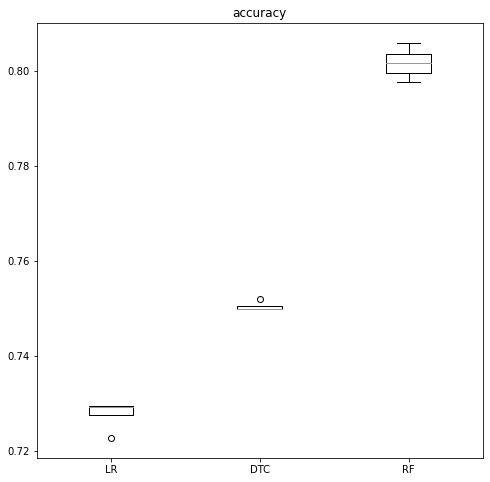

In [176]:
model_evaluation(models)

Claramente se obtiene que el algoritmo RandomForest es el mejor, hasta el momento.
Se tunean algunos hiperparámetros para tratar de mejorarlo un poco, mediante el grid.

# Tuneo del Random Forest

In [177]:
from sklearn.model_selection import GridSearchCV  # Para búsqueda de hiperparámetros
rf_model = RandomForestClassifier(random_state = 42)  # O RandomForestRegressor para regresión
parametros = {
    'n_estimators': [200,300], # número de árboles en el bosque
    'criterion': ['gini', 'entropy'],  # Criterio para medir la calidad de la división
    'max_depth': [None,10,30,50,100],  # Profundidad máxima del árbol
    'min_samples_split': [1,2,5,10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1,4,10],  # Número mínimo de muestras requeridas en una hoja
    'max_features': ['auto', 'sqrt', 'log2'],  # Número máximo de características a considerar en la división
    'bootstrap': [False, True],  # Si se realiza muestreo con reemplazo en la construcción de árboles

}

In [366]:
#Creamos el grid
grid_search = GridSearchCV(estimator = rf_model, param_grid = parametros, cv = 5, scoring = 'accuracy')  # 5-fold cross-validation
grid_search.fit(X, y)

In [ ]:
#Sacamos los mejores parámetros
mejores_parametros = grid_search.best_params_
modelo_ajustado = grid_search.best_estimator_
best_score = grid_search.best_score_

print(mejores_parametros)
print(modelo_ajustado)
print(best_score)

In [316]:
# Crear una instancia del mejor modelo ajustado
best_rf_model = RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_split = 2, min_samples_leaf = 2, 
                                      max_features = 'auto', bootstrap = False, random_state = 42)

# Ajustar el modelo a tus datos de entrenamiento 
best_rf_model.fit(X, y) 


RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=2,
                       n_estimators=200, random_state=42)

In [317]:
#Lanzamos el modelo para los datos test para ver la puntuación
y_pred = best_rf_model.predict(test)


Se junta el id con la predicción y posteriormente se guarda junto con las predicciones en un csv que enviaremos a la plataforma evaluar la puntuación.

In [318]:
prediccion = pd.concat([test_id, pd.DataFrame(y_pred, columns = ['status_group'])], axis = 1)


In [319]:
prediccion.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [320]:
# Exportar el DataFrame a un archivo CSV
prediccion.to_csv('prediccion.csv', index = False)


A estas alturas, ya teníamos un modelo válido y relativamente competitivo (puntuación de 0.815 aproximadamente). Esto es lo que hice para el concurso. Estuve probando multitud de nuevos algoritmos pero he elimnado el código porque ninguno mejora el modelo propuesto por el RandomForest. Pienso que debo realizar un proceso más preciso de creación y tratamiento de variables y ya, con eso optimizado, probar modelos más complejos.

A partir de este punto, empezamos de nuevo el problema con las consideraciones que he ido haciendo a lo largo de las líneas anteriores.

# Segunda parte

# ¡Nuevo modelo!
### Recordatorio: A lo largo de las siguientes líneas he desarrollado un nuevo modelo que mejora el anterior en el que he implementado las mejoras que he ido considerando a lo largo de la explicación anterior.

Leemos los datos de nuevo, aprovechando las opciones que ofrece pd.read_csv y a sabiendas de que los nan viene codificados como 0.

Nota: Se unen los 'input' de los datos train y test para hacer las transformaciones de manera conjunta. Al final se vovlerán a separar (esto es mucho más eficiente en cuanto a código se refiere que lo que hice en la primera parte).

In [210]:
# La opción 'parse_dates' convierte a fecha la columna indicada. ¡Qué locura!
train_features = pd.read_csv('trainingsetlabels.csv', parse_dates = ['date_recorded'])
train_target = pd.read_csv('trainingsetvalues.csv',  na_values = [0, '0'])
test_features = pd.read_csv('testsetvalues.csv', parse_dates = ['date_recorded'] , na_values = [0, '0'])
test_id = test_features['id']

# Extraer la columna "status_group" de target
status_group = train_target["status_group"]

# Seleccionar las columnas presentes en my_train en my_test
col_test = test_features.columns.intersection(train_features.columns)

# Crear un nuevo DataFrame con las filas de my_train y las columnas seleccionadas de my_test
completo = pd.concat([train_features, test_features[col_test]], ignore_index = True)

# Mostrar una vista previa de las primeras filas del DataFrame completo
completo.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0.0,Lake Nyasa,Mnyusi B,Iringa,11,5.0,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0.0,Lake Victoria,Nyamara,Mara,20,2.0,Serengeti,Natta,280.0,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0.0,Pangani,Majengo,Manyara,21,4.0,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0.0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63.0,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,Shuleni,0.0,Lake Victoria,Kyanyamisa,Kagera,18,1.0,Karagwe,Nyakasimbi,0.0,True,GeoData Consultants Ltd,NaN,NaN,True,0.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Usamos nuestras funciones propias para analizar las principales características de nuestros datos

In [211]:
numerical_dqr(completo)

,Data Type,Count,Unique Values,Missing Values,Missing %,Mean Value,Standard Deviation,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
id,int64,74250,74250,0,0.0,37124.5,21434.1,0.0,18562.2,37124.5,55686.8,74249.0
amount_tsh,float64,63840,102,10410,14.0,370.7,3131.7,0.0,0.0,0.0,50.0,350000.0
gps_height,float64,69039,2456,5211,7.0,715.9,692.9,-90.0,0.0,500.0,1348.0,2777.0
longitude,float64,73793,71870,457,0.6,34.3,6.0,0.0,33.1,34.9,37.2,40.3
latitude,float64,74250,71869,0,0.0,-5.7,2.9,-11.6,-8.5,-5.0,-3.3,-0.0
num_private,float64,59594,68,14656,19.7,0.6,12.9,0.0,0.0,0.0,0.0,1776.0
region_code,int64,74250,27,0,0.0,15.3,17.5,1.0,5.0,12.0,17.0,99.0
district_code,float64,74246,20,4,0.0,5.6,9.6,0.0,2.0,3.0,5.0,80.0
population,float64,68797,1128,5453,7.3,195.1,486.5,0.0,0.0,50.0,250.0,30500.0
construction_year,float64,68990,55,5260,7.1,1397.5,915.3,0.0,0.0,1990.0,2005.0,2013.0


Conclusiones de las variables numéricas:
- No hay missings, en principio, en ninguna variable. No obstante, existen datos mal codificados, como longitud cero, que no existe en Tanzania.
- El año medio de construcción es 1289. Evidentemente la variable 'construction_year' tiene valores mal codificados. 1st quartile es cero. Por tanto, es probable que tenga muchos ceros (que signifiquen missing)
- Altura del GPS negativo... está mal también.
- Máximos valores de gps_heigth y population desproporcionados con la mediana. Posibles outliers.
- num_private y amount_tsh tienen muchos ceros. Posibles missings mal codificados.
- Alguna variables son de tipo objetc, no numérica. Por ejemplo: ['region_code','district_code', 'num_private', 'id']

In [212]:
# Convertir tipos incorrectos
completo[['region_code','district_code', 'num_private', 'id']] = completo[['region_code','district_code', 'num_private', 'id']].astype('object')


In [213]:
categorical_dqr(completo)

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
id,object,74250,74250,0,0.0,0,1,0.0
funder,object,69543,2140,4707,6.3,Government Of Tanzania,11299,16.2
installer,object,69515,2410,4735,6.4,DWE,21751,31.3
wpt_name,object,74250,45684,0,0.0,none,4440,6.0
num_private,object,59594,68,14656,19.7,0.0,58643,98.4
basin,object,74250,9,0,0.0,Lake Victoria,12871,17.3
subvillage,object,73780,21425,470,0.6,Shuleni,646,0.9
region,object,74250,21,0,0.0,Iringa,6599,8.9
region_code,object,74250,27,0,0.0,11,6608,8.9
district_code,object,74246,20,4,0.0,1.0,15299,20.6


Conclusiones de las variables categóricas:
- Algunas variables tienen muchos missings. Veremos qué hacemos con ello.
- Variables con una sola variable serán eliminadas.
- Existen variables con muchísimas categorías diferentes. Las vamos a eliminar porque son muy complicadas de tratar y pueden contribuir a aumentar el sobreajuste.
- Dejamos en el límite la variable 'funder' con 2145 categorías diferentes.

In [214]:
# Crear un nuevo DataFrame con las columnas de tipo caracter de completo
completo_cat = completo.select_dtypes(include = "object")

# Crear un nuevo DataFrame categorias con los nombres de las columnas y el número de categorías únicas
categorias = pd.DataFrame({"variables": completo_cat.columns,
                          "categorias": completo_cat.nunique()})

# Ordenar el DataFrame categorias por la columna "categorias"
categorias = categorias.sort_values("categorias")

# Filtrar las filas donde el valor en la columna "categorias" es mayor que 2145
cat_mal = categorias[categorias["categorias"] > 2145]["variables"]

# Eliminar las columnas del DataFrame completo cuyos nombres están en cat_mal
completo = completo.drop(cat_mal, axis = 1)

Ahora que ya hemos eliminado alguna variable, creamos las nuevas a partir de la fecha: además de las mencionadas anteriormente, se han añadido dos columnas nuevas, 'fe_anti_pozo' y 'fe_date_recorded', que representan la antigüedad del pozo respecto de la última fecha presente en los datos y la diferencia de días entre la fecha guardada y la actual, respectivamente.


In [215]:
completo['fe_year'] = completo['date_recorded'].dt.year
completo['fe_month'] = completo['date_recorded'].dt.month
completo['fe_day'] = completo['date_recorded'].dt.day
completo['fe_dia_semana'] = completo['date_recorded'].dt.strftime('%A')
completo['fe_trimestre'] = completo['date_recorded'].dt.quarter
completo['fe_anti_pozo'] = 2014 - completo['construction_year']
completo['fe_date_recorded'] = max(completo['date_recorded']) - completo['date_recorded']

condiciones = [
    (completo['fe_day'] >= 1) & (completo['fe_day'] <= 9),
    (completo['fe_day'] >= 10) & (completo['fe_day'] <= 19),
    (completo['fe_day'] >= 20) & (completo['fe_day'] <= 31)
]
valores = [1, 2, 3]

# Aplicar las condiciones y asignar los valores a una nueva columna 'fe_day_10'
completo['fe_day_10'] = np.select(condiciones, valores, default = None)


In [216]:
completo.drop('recorded_by', axis = 1, inplace = True)

In [217]:
completo = completo.drop(['extraction_type', 'payment_type', 'quantity_group'], axis = 1)


En este punto, vamos a trabajar las variables categóricas para convertirlas a numéricas. Para el concurso aplicamos 'dummies'. Ahora probaremos otras cosas, como frequency Encoding

Voy a usar 'LabelEncoding' para las variables que tengan relación de orden
y 'FrequencyEncoding' para las demás

In [218]:
#Voy a repasar las columnas que tengo
completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   amount_tsh             63840 non-null  float64        
 1   date_recorded          74250 non-null  datetime64[ns] 
 2   funder                 69543 non-null  object         
 3   gps_height             69039 non-null  float64        
 4   longitude              73793 non-null  float64        
 5   latitude               74250 non-null  float64        
 6   num_private            59594 non-null  object         
 7   basin                  74250 non-null  object         
 8   region                 74250 non-null  object         
 9   region_code            74250 non-null  object         
 10  district_code          74246 non-null  object         
 11  lga                    74250 non-null  object         
 12  ward                   74250 non-null  object 

In [219]:
# Mostrar para cada columna las categorías que tiene así como su frecuencia de aparición.
#for col in completo.columns:
#    print("Columna:", col)
#    print(completo[col].value_counts())
#    print()

Observo que no hay variables categóricas que tengas algún tipo de orden. Por tanto, usamos 'frequency encoding' para todas

In [220]:
variables_label_encoding = []

In [221]:
cat_cols = completo.select_dtypes(include = 'object')
for col in cat_cols.columns:
    completo['fe_' + col] = completo.groupby(col)[col].transform('count')
completo = completo.drop(cat_cols.columns, axis = 1)



Fijémonos en cómo todas las variables de tipo 'object' ahora se han convertido en numéricas.

In [222]:
completo.head()


,amount_tsh,date_recorded,gps_height,longitude,latitude,population,construction_year,fe_year,fe_month,fe_day,fe_trimestre,fe_anti_pozo,fe_date_recorded,fe_funder,fe_num_private,fe_basin,fe_region,fe_region_code,fe_district_code,fe_lga,fe_ward,fe_public_meeting,fe_scheme_management,fe_permit,fe_extraction_type_group,fe_extraction_type_class,fe_management,fe_management_group,fe_payment,fe_water_quality,fe_quality_group,fe_quantity,fe_source,fe_source_type,fe_source_class,fe_waterpoint_type,fe_waterpoint_type_group,fe_fe_dia_semana,fe_fe_day_10
0,6000.0,2011-03-14,1390.0,34.938093,-9.856322,109.0,1999.0,2011,3,14,1,15.0,995 days,336.0,58643.0,6332,6599,6608,5428.0,687,41,63749.0,45917.0,21851.0,33263,33263,50624,65538,4570,63505,63505,41522,21216,21216,57286,35628,43239,10366,25045
1,0.0,2013-03-06,1399.0,34.698766,-2.147466,280.0,2010.0,2013,3,6,1,4.0,272 days,64.0,58643.0,12871,2451,2451,13929.0,905,90,NaN,996.0,48606.0,33263,33263,8108,65538,31712,63505,63505,18896,2863,2863,16617,35628,43239,11669,21829
2,25.0,2013-02-25,686.0,37.460664,-3.821329,250.0,2009.0,2013,2,25,1,5.0,281 days,9.0,58643.0,11143,1972,1972,11253.0,372,13,63749.0,45917.0,48606.0,33263,33263,50624,65538,11266,63505,63505,41522,840,840,16617,7611,43239,10366,27376
3,0.0,2013-01-28,263.0,38.486161,-11.155298,58.0,1986.0,2013,1,28,1,28.0,309 days,1324.0,58643.0,5587,2144,1133,264.0,213,41,63749.0,45917.0,48606.0,7772,7772,50624,65538,31712,63505,63505,7782,13822,14930,57286,7611,43239,10366,27376
4,0.0,2011-07-13,0.0,31.130847,-1.825359,0.0,0.0,2011,7,13,3,2014.0,874 days,1.0,58643.0,12871,4174,4183,15299.0,967,14,63749.0,NaN,48606.0,33263,33263,1083,1209,31712,63505,63505,5075,2863,2863,16617,35628,43239,11669,25045


Se borran las columnas de tipo fecha

In [223]:
completo.drop(['date_recorded', 'fe_date_recorded'] , axis = 1, inplace = True)

Se añaden nuevas variables, en particular, dos que tienen que ver con la distancia:
- 'fe_dist_geo' mide la distancia entre un punto y el punto de (latitude, longitude) = (0,0)
- 'distancia_al_punto_max' mide la distancia entre un punto cualquiera y el pico superior derecho del país

Imputamos mediante KNN 

In [224]:
columnas_numericas = completo.select_dtypes(include = 'number').columns

from sklearn.impute import KNNImputer, SimpleImputer

# Imputación por KNN en columnas numéricas
imputer_numerico = KNNImputer(n_neighbors = 3)
completo[columnas_numericas] = imputer_numerico.fit_transform(completo[columnas_numericas])

In [225]:
import geopy.distance

# Validar latitud y longitud
valid_lat_range = (-90, 90)
valid_lon_range = (-180, 180)

completo['fe_dist_geo'] = completo.apply(lambda row: geopy.distance.distance((0, 0), (row['latitude'], row['longitude'])).km if valid_lat_range[0] <= row['latitude'] <= valid_lat_range[1] and valid_lon_range[0] <= row['longitude'] <= valid_lon_range[1] else np.nan, axis=1)


In [226]:
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import pairwise_distances

latitud_max = completo['latitude'].max()
longitud_max = completo['longitude'].max()

# Calcular las distancias utilizando la fórmula de Vincenty
distancias = pairwise_distances(completo[['latitude', 'longitude']], [[latitud_max, longitud_max]], metric = 'cosine')

# Crear una nueva columna en el DataFrame 'completo' con las distancias calculadas
completo['distancia_al_punto_max'] = distancias

In [227]:
#Última comprobación de los datos
completo.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,fe_year,fe_month,fe_day,fe_trimestre,fe_anti_pozo,fe_funder,fe_num_private,fe_basin,fe_region,fe_region_code,fe_district_code,fe_lga,fe_ward,fe_public_meeting,fe_scheme_management,fe_permit,fe_extraction_type_group,fe_extraction_type_class,fe_management,fe_management_group,fe_payment,fe_water_quality,fe_quality_group,fe_quantity,fe_source,fe_source_type,fe_source_class,fe_waterpoint_type,fe_waterpoint_type_group,fe_fe_dia_semana,fe_fe_day_10,fe_dist_geo,distancia_al_punto_max
0,6000.0,1390.0,34.938093,-9.856322,109.0,1999.0,2011.0,3.0,14.0,1.0,15.0,336.0,58643.0,6332.0,6599.0,6608.0,5428.0,687.0,41.0,63749.000000,45917.0,21851.0,33263.0,33263.0,50624.0,65538.0,4570.0,63505.0,63505.0,41522.0,21216.0,21216.0,57286.0,35628.0,43239.0,10366.0,25045.0,4020.231393,0.037565
1,0.0,1399.0,34.698766,-2.147466,280.0,2010.0,2013.0,3.0,6.0,1.0,4.0,64.0,58643.0,12871.0,2451.0,2451.0,13929.0,905.0,90.0,25480.333333,996.0,48606.0,33263.0,33263.0,8108.0,65538.0,31712.0,63505.0,63505.0,18896.0,2863.0,2863.0,16617.0,35628.0,43239.0,11669.0,21829.0,3869.021176,0.001910
2,25.0,686.0,37.460664,-3.821329,250.0,2009.0,2013.0,2.0,25.0,1.0,5.0,9.0,58643.0,11143.0,1972.0,1972.0,11253.0,372.0,13.0,63749.000000,45917.0,48606.0,33263.0,33263.0,50624.0,65538.0,11266.0,63505.0,63505.0,41522.0,840.0,840.0,16617.0,7611.0,43239.0,10366.0,27376.0,4188.306569,0.005163
3,0.0,263.0,38.486161,-11.155298,58.0,1986.0,2013.0,1.0,28.0,1.0,28.0,1324.0,58643.0,5587.0,2144.0,1133.0,264.0,213.0,41.0,63749.000000,45917.0,48606.0,7772.0,7772.0,50624.0,65538.0,31712.0,63505.0,63505.0,7782.0,13822.0,14930.0,57286.0,7611.0,43239.0,10366.0,27376.0,4431.537591,0.039533
4,0.0,0.0,31.130847,-1.825359,0.0,0.0,2011.0,7.0,13.0,3.0,2014.0,1.0,58643.0,12871.0,4174.0,4183.0,15299.0,967.0,14.0,63749.000000,1372.0,48606.0,33263.0,33263.0,1083.0,1209.0,31712.0,63505.0,63505.0,5075.0,2863.0,2863.0,16617.0,35628.0,43239.0,11669.0,25045.0,3470.749580,0.001715


Previamente, antes de entrenar el modelo, se separan los datos train / test

In [228]:
# Agregar una columna de índice a completo
completo['index'] = range(1, len(completo) + 1)

# Filtrar las filas para crear el dataframe de entrenamiento
train = completo[completo['index'] <= len(train_features)].drop(columns = ['index'])
train['status_group'] = pd.factorize(train_target['status_group'])[0]

# Filtrar las filas para crear el dataframe de prueba
test = completo[completo['index'] > len(train_features)].drop(columns =['index'])


In [205]:
test.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,fe_year,fe_month,fe_day,fe_trimestre,fe_anti_pozo,fe_funder,fe_basin,fe_region,fe_lga,fe_ward,fe_public_meeting,fe_scheme_management,fe_permit,fe_extraction_type_group,fe_extraction_type_class,fe_management,fe_management_group,fe_payment,fe_water_quality,fe_quality_group,fe_quantity,fe_source,fe_source_type,fe_source_class,fe_waterpoint_type,fe_waterpoint_type_group,fe_fe_dia_semana,fe_fe_day_10,fe_dist_geo,distancia_al_punto_max
59400,50785.0,0.0,1996.0,35.290799,-4.059696,0.0,21.0,3.0,321.0,2012.0,2013.0,2.0,4.0,1.0,2.0,237.0,9642.0,1972.0,385.0,29.0,63749.0,2124.0,48606.000000,8102.0,8102.0,2229.0,2229.0,31712.0,63505.0,63505.0,5075.0,2863.0,2863.0,16617.0,8010.0,8010.0,10366.0,21829.0,3950.785973,0.006552
59401,51630.0,0.0,1569.0,36.656709,-3.309214,0.0,2.0,2.0,300.0,2000.0,2013.0,2.0,4.0,1.0,14.0,11299.0,11143.0,4111.0,1521.0,93.0,63749.0,45917.0,48606.000000,33263.0,33263.0,50624.0,65538.0,31712.0,63505.0,63505.0,18896.0,21216.0,21216.0,57286.0,35628.0,43239.0,10366.0,21829.0,4094.669871,0.004050
59402,17168.0,0.0,1567.0,34.767863,-5.004344,0.0,13.0,2.0,500.0,2010.0,2013.0,2.0,1.0,1.0,4.0,53.0,9642.0,2536.0,1202.0,52.0,63749.0,45917.0,30769.333333,8102.0,8102.0,50624.0,65538.0,31712.0,63505.0,63505.0,18896.0,2863.0,2863.0,16617.0,8010.0,8010.0,10985.0,21829.0,3904.731355,0.010201
59403,45559.0,0.0,267.0,38.058046,-9.418672,0.0,80.0,43.0,250.0,1987.0,2013.0,1.0,22.0,1.0,27.0,41.0,5587.0,1920.0,205.0,7.0,63749.0,45917.0,48606.000000,8102.0,8102.0,50624.0,65538.0,10149.0,63505.0,63505.0,7782.0,21140.0,21140.0,57286.0,8010.0,8010.0,10607.0,27376.0,4343.707450,0.029285
59404,49871.0,500.0,1260.0,35.006123,-10.950412,0.0,10.0,3.0,60.0,2000.0,2013.0,3.0,27.0,1.0,14.0,25.0,5587.0,3306.0,943.0,69.0,63749.0,3462.0,48606.000000,33263.0,33263.0,3688.0,65538.0,10397.0,63505.0,63505.0,41522.0,21216.0,21216.0,57286.0,35628.0,43239.0,11669.0,27376.0,4057.480310,0.045605


Para nuestras funciones, usamos los nombres X e y para las variables train y test, respectivamente.

In [239]:
y = status_group
X = train.drop('status_group', axis = 1).copy()

In [240]:
print(y.unique())

['functional' 'non functional' 'functional needs repair']


Para ciertos modelos, que requieren una variable objetivo categórica numérica, vamos a realizar la siguiente codificación.

In [242]:
# Crear un diccionario de mapeo de valores
mapeo = {'functional': 0, 'functional needs repair': 1, 'non functional': 2}

# Aplicar el mapeo de valores a la columna 'columna_deseada' en el DataFrame 'y'
y_prueba = y.map(mapeo)


La variable y_prueba contiene a la variable objetivo, pero codificada de forma numérica, tal y como se muestra en la variable 'mapeo'. Este cambio nos permite tener acceso a modelos potentes como XGBoost y CatBoostClassifier.

## Tuneado del modelo

In [236]:
models = []
models.append(('LR', LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')))
models.append(('DTC', DecisionTreeClassifier()))
#models.append(('NAIVE', MultinomialNB()))
#models.append(('LDA', MLPClassifier())) #muy lento
models.append(('RF', RandomForestClassifier()))
#models.append(('SVCrbf', SVC()))
#models.append(('xgb', XGBClassifier(random_state = 42, objective = 'multi:softmax')))
#models.append(('SVCLinear', SVC(kernel = 'linear')))
#models.append(('SVCPoly', SVC(kernel = 'poly')))
#models.append(('GBC', GradientBoostingClassifier()))

scorings = ['accuracy','roc_auc','neg_log_loss']

LR: 0.6676599326599326
DTC: 0.7540909090909091
RF: 0.804074074074074


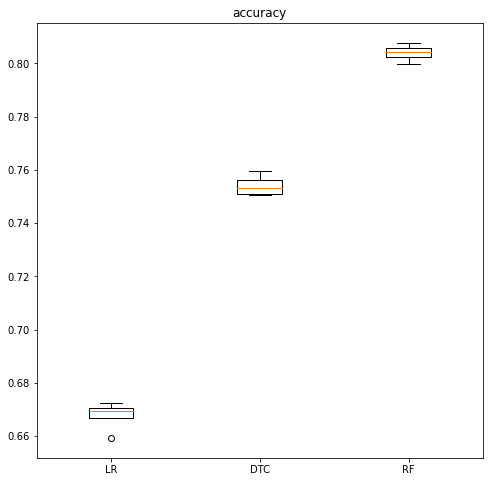

In [237]:
model_evaluation(models)

## Probando xgboost

In [326]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Crear el modelo de clasificación XGBoost
modelo_xgb = xgb.XGBClassifier()

# Ajustar el modelo a los datos de entrenamiento
modelo_xgb.fit(X, y_prueba)

# Realizar predicciones en los datos de prueba
y_pred = modelo_xgb.predict(X)

# Calcular la precisión del modelo
precision = accuracy_score(y_prueba, y_pred)

# Imprimir la precisión del modelo
print("Precisión del modelo XGBoost:", precision)

#Si es bueno, pienso en cómo meterlo en el ensemble

Precisión del modelo XGBoost: 0.8491582491582491


In [327]:
models = []
models.append(('xgb', modelo_xgb))

xgb: 0.8018518518518518


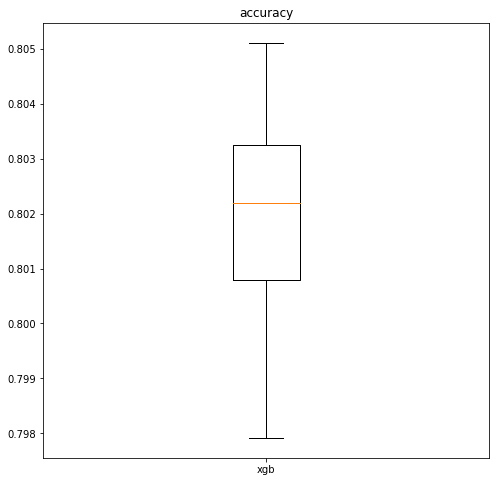

In [328]:
model_evaluation(models, y = y_prueba)

In [251]:
#Para volver a los nombres en vez de a los números:

# Crear un diccionario invertido del mapeo de valores
mapeo_invertido = {0: 'functional', 1: 'functional needs repair', 2: 'non functional'}

# Aplicar el mapeo invertido a la columna 'columna_deseada' en el DataFrame 'y'
y_pred = pd.Series(y_pred).map(mapeo_invertido)


## Probando Naive

Este modelo necesita que todos los datos de entrada sean numéricos y positivos. Vamos a aplicar

In [369]:
from sklearn.preprocessing import MinMaxScaler

# Crear una copia del DataFrame original para mantenerlo sin cambios
X_scaled = X.copy()

scaler = MinMaxScaler()

# Aplicar la normalización Min-Max a los datos en 'X_scaled'
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])
# Crear el modelo de clasificación Naive_Bayes
modelo_NB = MultinomialNB()

# Ajustar el modelo a los datos de entrenamiento
modelo_NB.fit(X_scaled, y_prueba)

# Realizar predicciones en los datos de prueba
y_pred = modelo_xgb.predict(X_scaled)

# Calcular la precisión del modelo
precision = accuracy_score(y_prueba, y_pred)

# Imprimir la precisión del modelo
print("Precisión del modelo Naive_Bayes:", precision)

Precisión del modelo Naive_Bayes: 0.3842424242424242


La precisión es ridícula. Obviamos el modelo y avanzamos al siguiente.

Nota: Hemos tenido que escalar los datos input entre 0 y 1 puesto que el método 'MultinomialNB()', sólo admite valores numéricos positivos. positivos

# GradientBoostingClassifier

### ¿Es competitivo?

In [329]:
gbc = GradientBoostingClassifier()
# Ajustar el modelo a los datos de entrenamiento
gbc.fit(X, y_prueba)

# Realizar predicciones en los datos de prueba
y_pred = gbc.predict(X)

# Calcular la precisión del modelo
precision = accuracy_score(y_prueba, y_pred)

# Imprimir la precisión del modelo
print("Precisión del modelo XBC:", precision)

Precisión del modelo XBC: 0.758013468013468


El modelo no es muy competitivo. No tuneamos los hiperparámetros para no perder tiempo

# Tuneo del gradientBoostingClassifier

In [1]:
# Crear una instancia del clasificador GradientBoostingClassifier
#gbc = GradientBoostingClassifier()

# Definir los hiperparámetros y sus posibles valores a sintonizar
#param_grid = {
#    'min_samples_split':[10, 100],
#    'subsample': [0.5, 0.8, 1.0],
#    'n_estimators': [50, 100, 200],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [3, 4, 5]
#}

# Realizar la búsqueda en cuadrícula utilizando GridSearchCV
#grid_search = GridSearchCV(gbc, param_grid, cv = 5)
#grid_search.fit(X, y)


In [ ]:
# Obtener los mejores hiperparámetros encontrados
#best_params = grid_search.best_params_
#print(best_params)

In [ ]:
# Los mejores parámetros para GradientBoostingClassifier
#best_gbc_model = GradientBoostingClassifier()

# Tuneo de la regresión logística

In [330]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Crear una instancia del modelo LogisticRegression
logreg = LogisticRegression()

# Definir los hiperparámetros y sus posibles valores para ajustar
param_grid = {'C': [0.001, 0.01],
              'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'solver': ['lbfgs']}

# Crear una instancia de GridSearchCV con el modelo y los hiperparámetros a ajustar
grid_search = GridSearchCV(logreg, param_grid, cv = 5, scoring = 'accuracy')

# Ajustar el modelo usando GridSearchCV
grid_search.fit(X, y)

#Sacamos los mejores parámetros
mejores_parametros = grid_search.best_params_
modelo_ajustado = grid_search.best_estimator_
best_score = grid_search.best_score_



In [331]:
print(mejores_parametros)
print(modelo_ajustado)
print(best_score)

{'C': 0.001, 'penalty': 'none', 'solver': 'lbfgs'}
LogisticRegression(C=0.001, penalty='none')
0.667979797979798


In [332]:
# Los mejores parámetros para Regresión logística
best_logreg_model = LogisticRegression(C=0.001, penalty='none')
best_logreg_model.fit(X,y)

LogisticRegression(C=0.001, penalty='none')

In [333]:
# Realizar predicciones en los datos de prueba
y_pred = best_logreg_model.predict(X)

# Calcular la precisión del modelo
precision = accuracy_score(y, y_pred)

# Imprimir la precisión del modelo
print("Precisión del modelo de regresión lineal:", precision)

Precisión del modelo de regresión lineal: 0.6662289562289563


Claramente descartamos la regresión logística

# Best_cat_model

In [334]:
from catboost import CatBoostClassifier  # Para importar el modelo CatBoostClassifier

best_cat_model = CatBoostClassifier(random_state = 42, rsm = 0.2, max_depth = 9, iterations = 1000)
best_cat_model.fit(X, y_prueba)

#hay problemas con este algoritmo no sé por qué.

Learning rate set to 0.097451
0:	learn: 1.0396163	total: 45ms	remaining: 45s
1:	learn: 0.9839778	total: 69.6ms	remaining: 34.7s
2:	learn: 0.9346491	total: 110ms	remaining: 36.7s
3:	learn: 0.8953774	total: 155ms	remaining: 38.6s
4:	learn: 0.8612463	total: 197ms	remaining: 39.3s
5:	learn: 0.8323164	total: 240ms	remaining: 39.8s
6:	learn: 0.8082600	total: 278ms	remaining: 39.5s
7:	learn: 0.7857886	total: 308ms	remaining: 38.1s
8:	learn: 0.7686142	total: 330ms	remaining: 36.4s
9:	learn: 0.7528709	total: 365ms	remaining: 36.2s
10:	learn: 0.7371781	total: 395ms	remaining: 35.5s
11:	learn: 0.7242132	total: 432ms	remaining: 35.6s
12:	learn: 0.7108063	total: 470ms	remaining: 35.7s
13:	learn: 0.6995996	total: 509ms	remaining: 35.8s
14:	learn: 0.6905854	total: 550ms	remaining: 36.1s
15:	learn: 0.6816373	total: 588ms	remaining: 36.2s
16:	learn: 0.6748322	total: 624ms	remaining: 36.1s
17:	learn: 0.6671131	total: 662ms	remaining: 36.1s
18:	learn: 0.6608443	total: 698ms	remaining: 36s
19:	learn: 0.65

162:	learn: 0.4738909	total: 6.08s	remaining: 31.2s
163:	learn: 0.4735573	total: 6.12s	remaining: 31.2s
164:	learn: 0.4732043	total: 6.17s	remaining: 31.2s
165:	learn: 0.4727424	total: 6.21s	remaining: 31.2s
166:	learn: 0.4724458	total: 6.23s	remaining: 31.1s
167:	learn: 0.4721771	total: 6.28s	remaining: 31.1s
168:	learn: 0.4717666	total: 6.32s	remaining: 31.1s
169:	learn: 0.4712896	total: 6.36s	remaining: 31s
170:	learn: 0.4705341	total: 6.38s	remaining: 30.9s
171:	learn: 0.4699877	total: 6.41s	remaining: 30.8s
172:	learn: 0.4695163	total: 6.45s	remaining: 30.8s
173:	learn: 0.4689095	total: 6.49s	remaining: 30.8s
174:	learn: 0.4684520	total: 6.52s	remaining: 30.7s
175:	learn: 0.4674063	total: 6.56s	remaining: 30.7s
176:	learn: 0.4670133	total: 6.59s	remaining: 30.6s
177:	learn: 0.4666301	total: 6.63s	remaining: 30.6s
178:	learn: 0.4663695	total: 6.67s	remaining: 30.6s
179:	learn: 0.4660418	total: 6.71s	remaining: 30.6s
180:	learn: 0.4655126	total: 6.75s	remaining: 30.6s
181:	learn: 0.

323:	learn: 0.4153564	total: 12.2s	remaining: 25.4s
324:	learn: 0.4152299	total: 12.2s	remaining: 25.4s
325:	learn: 0.4150471	total: 12.3s	remaining: 25.4s
326:	learn: 0.4147810	total: 12.3s	remaining: 25.3s
327:	learn: 0.4145619	total: 12.4s	remaining: 25.3s
328:	learn: 0.4145027	total: 12.4s	remaining: 25.3s
329:	learn: 0.4143709	total: 12.4s	remaining: 25.2s
330:	learn: 0.4140475	total: 12.5s	remaining: 25.2s
331:	learn: 0.4137367	total: 12.5s	remaining: 25.2s
332:	learn: 0.4135538	total: 12.5s	remaining: 25.1s
333:	learn: 0.4133345	total: 12.6s	remaining: 25.1s
334:	learn: 0.4132052	total: 12.6s	remaining: 25.1s
335:	learn: 0.4127195	total: 12.7s	remaining: 25s
336:	learn: 0.4125733	total: 12.7s	remaining: 25s
337:	learn: 0.4120901	total: 12.7s	remaining: 24.9s
338:	learn: 0.4118830	total: 12.8s	remaining: 24.9s
339:	learn: 0.4116465	total: 12.8s	remaining: 24.9s
340:	learn: 0.4114905	total: 12.8s	remaining: 24.8s
341:	learn: 0.4111937	total: 12.9s	remaining: 24.8s
342:	learn: 0.41

486:	learn: 0.3768874	total: 18.2s	remaining: 19.2s
487:	learn: 0.3767251	total: 18.3s	remaining: 19.2s
488:	learn: 0.3765527	total: 18.3s	remaining: 19.1s
489:	learn: 0.3764532	total: 18.3s	remaining: 19.1s
490:	learn: 0.3761947	total: 18.4s	remaining: 19s
491:	learn: 0.3758499	total: 18.4s	remaining: 19s
492:	learn: 0.3754420	total: 18.4s	remaining: 19s
493:	learn: 0.3750328	total: 18.5s	remaining: 18.9s
494:	learn: 0.3748334	total: 18.5s	remaining: 18.9s
495:	learn: 0.3746084	total: 18.6s	remaining: 18.9s
496:	learn: 0.3744396	total: 18.6s	remaining: 18.8s
497:	learn: 0.3742800	total: 18.6s	remaining: 18.8s
498:	learn: 0.3741491	total: 18.7s	remaining: 18.7s
499:	learn: 0.3739129	total: 18.7s	remaining: 18.7s
500:	learn: 0.3736338	total: 18.7s	remaining: 18.7s
501:	learn: 0.3734847	total: 18.8s	remaining: 18.6s
502:	learn: 0.3732951	total: 18.8s	remaining: 18.6s
503:	learn: 0.3731144	total: 18.9s	remaining: 18.6s
504:	learn: 0.3729595	total: 18.9s	remaining: 18.5s
505:	learn: 0.3728

649:	learn: 0.3491801	total: 24.5s	remaining: 13.2s
650:	learn: 0.3490137	total: 24.5s	remaining: 13.2s
651:	learn: 0.3489284	total: 24.6s	remaining: 13.1s
652:	learn: 0.3488246	total: 24.6s	remaining: 13.1s
653:	learn: 0.3487530	total: 24.6s	remaining: 13s
654:	learn: 0.3485426	total: 24.7s	remaining: 13s
655:	learn: 0.3482724	total: 24.7s	remaining: 13s
656:	learn: 0.3481306	total: 24.8s	remaining: 12.9s
657:	learn: 0.3479398	total: 24.8s	remaining: 12.9s
658:	learn: 0.3478169	total: 24.9s	remaining: 12.9s
659:	learn: 0.3477188	total: 24.9s	remaining: 12.8s
660:	learn: 0.3475148	total: 24.9s	remaining: 12.8s
661:	learn: 0.3474052	total: 25s	remaining: 12.7s
662:	learn: 0.3472916	total: 25s	remaining: 12.7s
663:	learn: 0.3471112	total: 25s	remaining: 12.7s
664:	learn: 0.3469824	total: 25.1s	remaining: 12.6s
665:	learn: 0.3468430	total: 25.1s	remaining: 12.6s
666:	learn: 0.3467375	total: 25.2s	remaining: 12.6s
667:	learn: 0.3465899	total: 25.2s	remaining: 12.5s
668:	learn: 0.3465254	to

809:	learn: 0.3277239	total: 30.6s	remaining: 7.17s
810:	learn: 0.3275807	total: 30.6s	remaining: 7.13s
811:	learn: 0.3274867	total: 30.7s	remaining: 7.1s
812:	learn: 0.3274116	total: 30.7s	remaining: 7.06s
813:	learn: 0.3273157	total: 30.7s	remaining: 7.02s
814:	learn: 0.3271142	total: 30.8s	remaining: 6.98s
815:	learn: 0.3269342	total: 30.8s	remaining: 6.95s
816:	learn: 0.3268275	total: 30.8s	remaining: 6.91s
817:	learn: 0.3266865	total: 30.9s	remaining: 6.87s
818:	learn: 0.3266056	total: 30.9s	remaining: 6.83s
819:	learn: 0.3264762	total: 30.9s	remaining: 6.79s
820:	learn: 0.3263955	total: 31s	remaining: 6.75s
821:	learn: 0.3262857	total: 31s	remaining: 6.72s
822:	learn: 0.3261727	total: 31.1s	remaining: 6.68s
823:	learn: 0.3260441	total: 31.1s	remaining: 6.64s
824:	learn: 0.3259526	total: 31.1s	remaining: 6.6s
825:	learn: 0.3258029	total: 31.2s	remaining: 6.57s
826:	learn: 0.3256401	total: 31.2s	remaining: 6.53s
827:	learn: 0.3255250	total: 31.3s	remaining: 6.49s
828:	learn: 0.3253

969:	learn: 0.3101175	total: 36.7s	remaining: 1.13s
970:	learn: 0.3099900	total: 36.7s	remaining: 1.1s
971:	learn: 0.3098932	total: 36.8s	remaining: 1.06s
972:	learn: 0.3097895	total: 36.8s	remaining: 1.02s
973:	learn: 0.3096434	total: 36.8s	remaining: 983ms
974:	learn: 0.3095288	total: 36.9s	remaining: 945ms
975:	learn: 0.3094178	total: 36.9s	remaining: 907ms
976:	learn: 0.3093213	total: 36.9s	remaining: 869ms
977:	learn: 0.3092619	total: 37s	remaining: 831ms
978:	learn: 0.3091731	total: 37s	remaining: 793ms
979:	learn: 0.3091043	total: 37s	remaining: 755ms
980:	learn: 0.3089547	total: 37s	remaining: 718ms
981:	learn: 0.3088775	total: 37.1s	remaining: 680ms
982:	learn: 0.3087863	total: 37.1s	remaining: 642ms
983:	learn: 0.3086549	total: 37.2s	remaining: 604ms
984:	learn: 0.3085272	total: 37.2s	remaining: 567ms
985:	learn: 0.3083732	total: 37.3s	remaining: 529ms
986:	learn: 0.3082898	total: 37.3s	remaining: 491ms
987:	learn: 0.3080907	total: 37.3s	remaining: 453ms
988:	learn: 0.3080409

In [335]:
# Ganador
best_cat_model = CatBoostClassifier(random_state = 42, rsm = 0.2, max_depth = 9, iterations = 1000)

In [336]:
best_cat_model.fit(X,y_prueba)
pred = best_cat_model.predict(X)


Learning rate set to 0.097451
0:	learn: 1.0396163	total: 40.2ms	remaining: 40.1s
1:	learn: 0.9839778	total: 65.3ms	remaining: 32.6s
2:	learn: 0.9346491	total: 108ms	remaining: 35.8s
3:	learn: 0.8953774	total: 152ms	remaining: 38s
4:	learn: 0.8612463	total: 197ms	remaining: 39.2s
5:	learn: 0.8323164	total: 242ms	remaining: 40.1s
6:	learn: 0.8082600	total: 284ms	remaining: 40.2s
7:	learn: 0.7857886	total: 315ms	remaining: 39s
8:	learn: 0.7686142	total: 341ms	remaining: 37.5s
9:	learn: 0.7528709	total: 384ms	remaining: 38s
10:	learn: 0.7371781	total: 417ms	remaining: 37.5s
11:	learn: 0.7242132	total: 458ms	remaining: 37.7s
12:	learn: 0.7108063	total: 500ms	remaining: 38s
13:	learn: 0.6995996	total: 547ms	remaining: 38.5s
14:	learn: 0.6905854	total: 593ms	remaining: 38.9s
15:	learn: 0.6816373	total: 634ms	remaining: 39s
16:	learn: 0.6748322	total: 678ms	remaining: 39.2s
17:	learn: 0.6671131	total: 722ms	remaining: 39.4s
18:	learn: 0.6608443	total: 758ms	remaining: 39.1s
19:	learn: 0.654369

163:	learn: 0.4735573	total: 6.22s	remaining: 31.7s
164:	learn: 0.4732043	total: 6.26s	remaining: 31.7s
165:	learn: 0.4727424	total: 6.3s	remaining: 31.6s
166:	learn: 0.4724458	total: 6.32s	remaining: 31.5s
167:	learn: 0.4721771	total: 6.36s	remaining: 31.5s
168:	learn: 0.4717666	total: 6.4s	remaining: 31.5s
169:	learn: 0.4712896	total: 6.44s	remaining: 31.4s
170:	learn: 0.4705341	total: 6.46s	remaining: 31.3s
171:	learn: 0.4699877	total: 6.48s	remaining: 31.2s
172:	learn: 0.4695163	total: 6.52s	remaining: 31.2s
173:	learn: 0.4689095	total: 6.57s	remaining: 31.2s
174:	learn: 0.4684520	total: 6.59s	remaining: 31.1s
175:	learn: 0.4674063	total: 6.63s	remaining: 31s
176:	learn: 0.4670133	total: 6.65s	remaining: 30.9s
177:	learn: 0.4666301	total: 6.69s	remaining: 30.9s
178:	learn: 0.4663695	total: 6.72s	remaining: 30.8s
179:	learn: 0.4660418	total: 6.75s	remaining: 30.8s
180:	learn: 0.4655126	total: 6.79s	remaining: 30.7s
181:	learn: 0.4648563	total: 6.83s	remaining: 30.7s
182:	learn: 0.46

324:	learn: 0.4152299	total: 12.2s	remaining: 25.4s
325:	learn: 0.4150471	total: 12.3s	remaining: 25.3s
326:	learn: 0.4147810	total: 12.3s	remaining: 25.3s
327:	learn: 0.4145619	total: 12.3s	remaining: 25.3s
328:	learn: 0.4145027	total: 12.4s	remaining: 25.2s
329:	learn: 0.4143709	total: 12.4s	remaining: 25.2s
330:	learn: 0.4140475	total: 12.4s	remaining: 25.1s
331:	learn: 0.4137367	total: 12.5s	remaining: 25.1s
332:	learn: 0.4135538	total: 12.5s	remaining: 25.1s
333:	learn: 0.4133345	total: 12.6s	remaining: 25.1s
334:	learn: 0.4132052	total: 12.6s	remaining: 25s
335:	learn: 0.4127195	total: 12.6s	remaining: 25s
336:	learn: 0.4125733	total: 12.7s	remaining: 24.9s
337:	learn: 0.4120901	total: 12.7s	remaining: 24.9s
338:	learn: 0.4118830	total: 12.7s	remaining: 24.8s
339:	learn: 0.4116465	total: 12.8s	remaining: 24.8s
340:	learn: 0.4114905	total: 12.8s	remaining: 24.8s
341:	learn: 0.4111937	total: 12.9s	remaining: 24.7s
342:	learn: 0.4109960	total: 12.9s	remaining: 24.7s
343:	learn: 0.41

487:	learn: 0.3767251	total: 18.3s	remaining: 19.2s
488:	learn: 0.3765527	total: 18.4s	remaining: 19.2s
489:	learn: 0.3764532	total: 18.4s	remaining: 19.1s
490:	learn: 0.3761947	total: 18.4s	remaining: 19.1s
491:	learn: 0.3758499	total: 18.5s	remaining: 19.1s
492:	learn: 0.3754420	total: 18.5s	remaining: 19s
493:	learn: 0.3750328	total: 18.6s	remaining: 19s
494:	learn: 0.3748334	total: 18.6s	remaining: 19s
495:	learn: 0.3746084	total: 18.6s	remaining: 18.9s
496:	learn: 0.3744396	total: 18.7s	remaining: 18.9s
497:	learn: 0.3742800	total: 18.7s	remaining: 18.9s
498:	learn: 0.3741491	total: 18.7s	remaining: 18.8s
499:	learn: 0.3739129	total: 18.8s	remaining: 18.8s
500:	learn: 0.3736338	total: 18.8s	remaining: 18.8s
501:	learn: 0.3734847	total: 18.9s	remaining: 18.7s
502:	learn: 0.3732951	total: 18.9s	remaining: 18.7s
503:	learn: 0.3731144	total: 19s	remaining: 18.7s
504:	learn: 0.3729595	total: 19s	remaining: 18.6s
505:	learn: 0.3728173	total: 19s	remaining: 18.6s
506:	learn: 0.3727084	to

648:	learn: 0.3493934	total: 24.5s	remaining: 13.3s
649:	learn: 0.3491801	total: 24.6s	remaining: 13.2s
650:	learn: 0.3490137	total: 24.6s	remaining: 13.2s
651:	learn: 0.3489284	total: 24.7s	remaining: 13.2s
652:	learn: 0.3488246	total: 24.7s	remaining: 13.1s
653:	learn: 0.3487530	total: 24.7s	remaining: 13.1s
654:	learn: 0.3485426	total: 24.8s	remaining: 13s
655:	learn: 0.3482724	total: 24.8s	remaining: 13s
656:	learn: 0.3481306	total: 24.8s	remaining: 13s
657:	learn: 0.3479398	total: 24.9s	remaining: 12.9s
658:	learn: 0.3478169	total: 24.9s	remaining: 12.9s
659:	learn: 0.3477188	total: 24.9s	remaining: 12.8s
660:	learn: 0.3475148	total: 25s	remaining: 12.8s
661:	learn: 0.3474052	total: 25s	remaining: 12.8s
662:	learn: 0.3472916	total: 25.1s	remaining: 12.7s
663:	learn: 0.3471112	total: 25.1s	remaining: 12.7s
664:	learn: 0.3469824	total: 25.1s	remaining: 12.7s
665:	learn: 0.3468430	total: 25.2s	remaining: 12.6s
666:	learn: 0.3467375	total: 25.2s	remaining: 12.6s
667:	learn: 0.3465899	

808:	learn: 0.3278221	total: 30.6s	remaining: 7.22s
809:	learn: 0.3277239	total: 30.6s	remaining: 7.19s
810:	learn: 0.3275807	total: 30.7s	remaining: 7.15s
811:	learn: 0.3274867	total: 30.7s	remaining: 7.11s
812:	learn: 0.3274116	total: 30.8s	remaining: 7.08s
813:	learn: 0.3273157	total: 30.8s	remaining: 7.04s
814:	learn: 0.3271142	total: 30.8s	remaining: 7s
815:	learn: 0.3269342	total: 30.9s	remaining: 6.96s
816:	learn: 0.3268275	total: 30.9s	remaining: 6.93s
817:	learn: 0.3266865	total: 30.9s	remaining: 6.88s
818:	learn: 0.3266056	total: 31s	remaining: 6.85s
819:	learn: 0.3264762	total: 31s	remaining: 6.81s
820:	learn: 0.3263955	total: 31.1s	remaining: 6.77s
821:	learn: 0.3262857	total: 31.1s	remaining: 6.74s
822:	learn: 0.3261727	total: 31.1s	remaining: 6.7s
823:	learn: 0.3260441	total: 31.2s	remaining: 6.66s
824:	learn: 0.3259526	total: 31.2s	remaining: 6.62s
825:	learn: 0.3258029	total: 31.3s	remaining: 6.58s
826:	learn: 0.3256401	total: 31.3s	remaining: 6.55s
827:	learn: 0.325525

972:	learn: 0.3097895	total: 37s	remaining: 1.02s
973:	learn: 0.3096434	total: 37s	remaining: 988ms
974:	learn: 0.3095288	total: 37s	remaining: 950ms
975:	learn: 0.3094178	total: 37.1s	remaining: 912ms
976:	learn: 0.3093213	total: 37.1s	remaining: 874ms
977:	learn: 0.3092619	total: 37.1s	remaining: 835ms
978:	learn: 0.3091731	total: 37.2s	remaining: 797ms
979:	learn: 0.3091043	total: 37.2s	remaining: 759ms
980:	learn: 0.3089547	total: 37.2s	remaining: 721ms
981:	learn: 0.3088775	total: 37.3s	remaining: 683ms
982:	learn: 0.3087863	total: 37.3s	remaining: 645ms
983:	learn: 0.3086549	total: 37.3s	remaining: 607ms
984:	learn: 0.3085272	total: 37.4s	remaining: 569ms
985:	learn: 0.3083732	total: 37.4s	remaining: 531ms
986:	learn: 0.3082898	total: 37.5s	remaining: 493ms
987:	learn: 0.3080907	total: 37.5s	remaining: 455ms
988:	learn: 0.3080409	total: 37.5s	remaining: 417ms
989:	learn: 0.3079819	total: 37.6s	remaining: 380ms
990:	learn: 0.3078008	total: 37.6s	remaining: 342ms
991:	learn: 0.3077

In [337]:
precision = accuracy_score(y_prueba, pred)
print(precision)

0.8869191919191919


Learning rate set to 0.096032
0:	learn: 1.0414912	total: 35ms	remaining: 35s
1:	learn: 0.9908521	total: 54ms	remaining: 27s
2:	learn: 0.9416222	total: 89.3ms	remaining: 29.7s
3:	learn: 0.9031060	total: 128ms	remaining: 31.9s
4:	learn: 0.8692748	total: 167ms	remaining: 33.3s
5:	learn: 0.8403303	total: 205ms	remaining: 34s
6:	learn: 0.8168278	total: 245ms	remaining: 34.8s
7:	learn: 0.7945385	total: 269ms	remaining: 33.4s
8:	learn: 0.7778587	total: 288ms	remaining: 31.7s
9:	learn: 0.7624719	total: 323ms	remaining: 32s
10:	learn: 0.7463752	total: 349ms	remaining: 31.3s
11:	learn: 0.7325195	total: 385ms	remaining: 31.7s
12:	learn: 0.7188374	total: 422ms	remaining: 32.1s
13:	learn: 0.7066544	total: 458ms	remaining: 32.3s
14:	learn: 0.6963567	total: 494ms	remaining: 32.4s
15:	learn: 0.6867597	total: 531ms	remaining: 32.6s
16:	learn: 0.6788403	total: 564ms	remaining: 32.6s
17:	learn: 0.6709179	total: 603ms	remaining: 32.9s
18:	learn: 0.6641267	total: 638ms	remaining: 33s
19:	learn: 0.6575498	t

162:	learn: 0.4704328	total: 5.48s	remaining: 28.1s
163:	learn: 0.4700471	total: 5.52s	remaining: 28.1s
164:	learn: 0.4694868	total: 5.56s	remaining: 28.1s
165:	learn: 0.4690570	total: 5.6s	remaining: 28.1s
166:	learn: 0.4682743	total: 5.62s	remaining: 28s
167:	learn: 0.4678576	total: 5.65s	remaining: 28s
168:	learn: 0.4675304	total: 5.69s	remaining: 28s
169:	learn: 0.4668366	total: 5.72s	remaining: 27.9s
170:	learn: 0.4663851	total: 5.74s	remaining: 27.8s
171:	learn: 0.4659472	total: 5.76s	remaining: 27.7s
172:	learn: 0.4654430	total: 5.79s	remaining: 27.7s
173:	learn: 0.4648347	total: 5.83s	remaining: 27.7s
174:	learn: 0.4643565	total: 5.85s	remaining: 27.6s
175:	learn: 0.4640935	total: 5.89s	remaining: 27.6s
176:	learn: 0.4635753	total: 5.91s	remaining: 27.5s
177:	learn: 0.4632744	total: 5.94s	remaining: 27.4s
178:	learn: 0.4626622	total: 5.96s	remaining: 27.4s
179:	learn: 0.4621224	total: 6s	remaining: 27.3s
180:	learn: 0.4618909	total: 6.04s	remaining: 27.3s
181:	learn: 0.4614459	

323:	learn: 0.4055415	total: 10.9s	remaining: 22.7s
324:	learn: 0.4052252	total: 10.9s	remaining: 22.7s
325:	learn: 0.4047911	total: 11s	remaining: 22.7s
326:	learn: 0.4043849	total: 11s	remaining: 22.6s
327:	learn: 0.4039955	total: 11s	remaining: 22.6s
328:	learn: 0.4036409	total: 11.1s	remaining: 22.6s
329:	learn: 0.4032408	total: 11.1s	remaining: 22.5s
330:	learn: 0.4028702	total: 11.1s	remaining: 22.5s
331:	learn: 0.4026867	total: 11.2s	remaining: 22.5s
332:	learn: 0.4023046	total: 11.2s	remaining: 22.4s
333:	learn: 0.4020383	total: 11.2s	remaining: 22.4s
334:	learn: 0.4018857	total: 11.3s	remaining: 22.4s
335:	learn: 0.4016525	total: 11.3s	remaining: 22.4s
336:	learn: 0.4014642	total: 11.3s	remaining: 22.3s
337:	learn: 0.4011069	total: 11.4s	remaining: 22.3s
338:	learn: 0.4009244	total: 11.4s	remaining: 22.2s
339:	learn: 0.4006034	total: 11.4s	remaining: 22.2s
340:	learn: 0.4002486	total: 11.5s	remaining: 22.2s
341:	learn: 0.3999435	total: 11.5s	remaining: 22.2s
342:	learn: 0.3995

487:	learn: 0.3648820	total: 16.3s	remaining: 17s
488:	learn: 0.3646276	total: 16.3s	remaining: 17s
489:	learn: 0.3644340	total: 16.3s	remaining: 17s
490:	learn: 0.3642990	total: 16.3s	remaining: 16.9s
491:	learn: 0.3641428	total: 16.4s	remaining: 16.9s
492:	learn: 0.3639796	total: 16.4s	remaining: 16.9s
493:	learn: 0.3637882	total: 16.5s	remaining: 16.9s
494:	learn: 0.3636455	total: 16.5s	remaining: 16.8s
495:	learn: 0.3633884	total: 16.5s	remaining: 16.8s
496:	learn: 0.3632007	total: 16.5s	remaining: 16.7s
497:	learn: 0.3630928	total: 16.6s	remaining: 16.7s
498:	learn: 0.3627745	total: 16.6s	remaining: 16.7s
499:	learn: 0.3626349	total: 16.6s	remaining: 16.6s
500:	learn: 0.3624640	total: 16.7s	remaining: 16.6s
501:	learn: 0.3623292	total: 16.7s	remaining: 16.6s
502:	learn: 0.3620780	total: 16.8s	remaining: 16.6s
503:	learn: 0.3618503	total: 16.8s	remaining: 16.5s
504:	learn: 0.3615881	total: 16.8s	remaining: 16.5s
505:	learn: 0.3613089	total: 16.9s	remaining: 16.5s
506:	learn: 0.3611

649:	learn: 0.3352210	total: 21.7s	remaining: 11.7s
650:	learn: 0.3351291	total: 21.8s	remaining: 11.7s
651:	learn: 0.3349111	total: 21.8s	remaining: 11.6s
652:	learn: 0.3347818	total: 21.8s	remaining: 11.6s
653:	learn: 0.3345697	total: 21.9s	remaining: 11.6s
654:	learn: 0.3343371	total: 21.9s	remaining: 11.5s
655:	learn: 0.3340783	total: 21.9s	remaining: 11.5s
656:	learn: 0.3339862	total: 22s	remaining: 11.5s
657:	learn: 0.3338715	total: 22s	remaining: 11.4s
658:	learn: 0.3337219	total: 22.1s	remaining: 11.4s
659:	learn: 0.3334753	total: 22.1s	remaining: 11.4s
660:	learn: 0.3333423	total: 22.1s	remaining: 11.3s
661:	learn: 0.3331041	total: 22.1s	remaining: 11.3s
662:	learn: 0.3328280	total: 22.2s	remaining: 11.3s
663:	learn: 0.3326099	total: 22.2s	remaining: 11.2s
664:	learn: 0.3323241	total: 22.3s	remaining: 11.2s
665:	learn: 0.3322172	total: 22.3s	remaining: 11.2s
666:	learn: 0.3319572	total: 22.3s	remaining: 11.1s
667:	learn: 0.3318270	total: 22.4s	remaining: 11.1s
668:	learn: 0.33

811:	learn: 0.3106549	total: 27.2s	remaining: 6.3s
812:	learn: 0.3105793	total: 27.3s	remaining: 6.27s
813:	learn: 0.3103936	total: 27.3s	remaining: 6.23s
814:	learn: 0.3102660	total: 27.3s	remaining: 6.2s
815:	learn: 0.3100990	total: 27.4s	remaining: 6.17s
816:	learn: 0.3099660	total: 27.4s	remaining: 6.13s
817:	learn: 0.3098636	total: 27.4s	remaining: 6.09s
818:	learn: 0.3096485	total: 27.4s	remaining: 6.06s
819:	learn: 0.3095695	total: 27.5s	remaining: 6.03s
820:	learn: 0.3094508	total: 27.5s	remaining: 6s
821:	learn: 0.3092895	total: 27.5s	remaining: 5.96s
822:	learn: 0.3090886	total: 27.6s	remaining: 5.93s
823:	learn: 0.3089884	total: 27.6s	remaining: 5.9s
824:	learn: 0.3088189	total: 27.6s	remaining: 5.86s
825:	learn: 0.3087088	total: 27.7s	remaining: 5.83s
826:	learn: 0.3085197	total: 27.7s	remaining: 5.8s
827:	learn: 0.3083291	total: 27.7s	remaining: 5.76s
828:	learn: 0.3082278	total: 27.8s	remaining: 5.73s
829:	learn: 0.3080938	total: 27.8s	remaining: 5.7s
830:	learn: 0.307999

976:	learn: 0.2898580	total: 32.9s	remaining: 775ms
977:	learn: 0.2897718	total: 32.9s	remaining: 741ms
978:	learn: 0.2896981	total: 33s	remaining: 707ms
979:	learn: 0.2895201	total: 33s	remaining: 674ms
980:	learn: 0.2893793	total: 33s	remaining: 640ms
981:	learn: 0.2892621	total: 33.1s	remaining: 606ms
982:	learn: 0.2890656	total: 33.1s	remaining: 572ms
983:	learn: 0.2889417	total: 33.1s	remaining: 539ms
984:	learn: 0.2887708	total: 33.2s	remaining: 505ms
985:	learn: 0.2886286	total: 33.2s	remaining: 472ms
986:	learn: 0.2885248	total: 33.2s	remaining: 438ms
987:	learn: 0.2884515	total: 33.3s	remaining: 404ms
988:	learn: 0.2883737	total: 33.3s	remaining: 370ms
989:	learn: 0.2882833	total: 33.3s	remaining: 337ms
990:	learn: 0.2880900	total: 33.4s	remaining: 303ms
991:	learn: 0.2879698	total: 33.4s	remaining: 269ms
992:	learn: 0.2878929	total: 33.4s	remaining: 236ms
993:	learn: 0.2877818	total: 33.5s	remaining: 202ms
994:	learn: 0.2876781	total: 33.5s	remaining: 168ms
995:	learn: 0.2874

136:	learn: 0.4879599	total: 4.44s	remaining: 27.9s
137:	learn: 0.4871831	total: 4.47s	remaining: 27.9s
138:	learn: 0.4863452	total: 4.51s	remaining: 27.9s
139:	learn: 0.4858196	total: 4.54s	remaining: 27.9s
140:	learn: 0.4851934	total: 4.58s	remaining: 27.9s
141:	learn: 0.4845878	total: 4.62s	remaining: 27.9s
142:	learn: 0.4839420	total: 4.65s	remaining: 27.9s
143:	learn: 0.4836736	total: 4.69s	remaining: 27.9s
144:	learn: 0.4831022	total: 4.72s	remaining: 27.8s
145:	learn: 0.4824184	total: 4.76s	remaining: 27.8s
146:	learn: 0.4818744	total: 4.78s	remaining: 27.7s
147:	learn: 0.4813622	total: 4.82s	remaining: 27.7s
148:	learn: 0.4802616	total: 4.85s	remaining: 27.7s
149:	learn: 0.4795419	total: 4.88s	remaining: 27.7s
150:	learn: 0.4790221	total: 4.92s	remaining: 27.7s
151:	learn: 0.4782593	total: 4.96s	remaining: 27.7s
152:	learn: 0.4774916	total: 5s	remaining: 27.7s
153:	learn: 0.4767481	total: 5.03s	remaining: 27.7s
154:	learn: 0.4760305	total: 5.07s	remaining: 27.6s
155:	learn: 0.4

298:	learn: 0.4154228	total: 9.75s	remaining: 22.9s
299:	learn: 0.4151077	total: 9.79s	remaining: 22.8s
300:	learn: 0.4147428	total: 9.82s	remaining: 22.8s
301:	learn: 0.4142140	total: 9.86s	remaining: 22.8s
302:	learn: 0.4139247	total: 9.9s	remaining: 22.8s
303:	learn: 0.4134586	total: 9.92s	remaining: 22.7s
304:	learn: 0.4132354	total: 9.95s	remaining: 22.7s
305:	learn: 0.4130519	total: 9.99s	remaining: 22.7s
306:	learn: 0.4128064	total: 10s	remaining: 22.6s
307:	learn: 0.4123545	total: 10.1s	remaining: 22.6s
308:	learn: 0.4120739	total: 10.1s	remaining: 22.6s
309:	learn: 0.4116922	total: 10.1s	remaining: 22.5s
310:	learn: 0.4114286	total: 10.2s	remaining: 22.5s
311:	learn: 0.4112008	total: 10.2s	remaining: 22.5s
312:	learn: 0.4109187	total: 10.2s	remaining: 22.4s
313:	learn: 0.4106728	total: 10.3s	remaining: 22.4s
314:	learn: 0.4103963	total: 10.3s	remaining: 22.4s
315:	learn: 0.4100085	total: 10.3s	remaining: 22.4s
316:	learn: 0.4096329	total: 10.4s	remaining: 22.3s
317:	learn: 0.4

461:	learn: 0.3708803	total: 15s	remaining: 17.5s
462:	learn: 0.3706946	total: 15.1s	remaining: 17.5s
463:	learn: 0.3704349	total: 15.1s	remaining: 17.4s
464:	learn: 0.3702164	total: 15.1s	remaining: 17.4s
465:	learn: 0.3699883	total: 15.2s	remaining: 17.4s
466:	learn: 0.3697361	total: 15.2s	remaining: 17.3s
467:	learn: 0.3695495	total: 15.2s	remaining: 17.3s
468:	learn: 0.3692018	total: 15.3s	remaining: 17.3s
469:	learn: 0.3689649	total: 15.3s	remaining: 17.2s
470:	learn: 0.3687137	total: 15.3s	remaining: 17.2s
471:	learn: 0.3683372	total: 15.3s	remaining: 17.2s
472:	learn: 0.3680919	total: 15.4s	remaining: 17.1s
473:	learn: 0.3678797	total: 15.4s	remaining: 17.1s
474:	learn: 0.3676515	total: 15.4s	remaining: 17s
475:	learn: 0.3675092	total: 15.4s	remaining: 17s
476:	learn: 0.3672928	total: 15.5s	remaining: 16.9s
477:	learn: 0.3671174	total: 15.5s	remaining: 16.9s
478:	learn: 0.3667754	total: 15.5s	remaining: 16.9s
479:	learn: 0.3666294	total: 15.6s	remaining: 16.9s
480:	learn: 0.3664

625:	learn: 0.3391427	total: 20.4s	remaining: 12.2s
626:	learn: 0.3389785	total: 20.4s	remaining: 12.1s
627:	learn: 0.3388661	total: 20.4s	remaining: 12.1s
628:	learn: 0.3386424	total: 20.5s	remaining: 12.1s
629:	learn: 0.3385177	total: 20.5s	remaining: 12s
630:	learn: 0.3383623	total: 20.6s	remaining: 12s
631:	learn: 0.3380659	total: 20.6s	remaining: 12s
632:	learn: 0.3378832	total: 20.6s	remaining: 12s
633:	learn: 0.3377031	total: 20.7s	remaining: 11.9s
634:	learn: 0.3375681	total: 20.7s	remaining: 11.9s
635:	learn: 0.3374285	total: 20.7s	remaining: 11.9s
636:	learn: 0.3372585	total: 20.8s	remaining: 11.8s
637:	learn: 0.3371727	total: 20.8s	remaining: 11.8s
638:	learn: 0.3369215	total: 20.8s	remaining: 11.8s
639:	learn: 0.3368370	total: 20.9s	remaining: 11.7s
640:	learn: 0.3367538	total: 20.9s	remaining: 11.7s
641:	learn: 0.3366841	total: 20.9s	remaining: 11.7s
642:	learn: 0.3365051	total: 21s	remaining: 11.6s
643:	learn: 0.3362758	total: 21s	remaining: 11.6s
644:	learn: 0.3361547	to

788:	learn: 0.3143768	total: 25.9s	remaining: 6.93s
789:	learn: 0.3142116	total: 25.9s	remaining: 6.89s
790:	learn: 0.3140831	total: 26s	remaining: 6.86s
791:	learn: 0.3139684	total: 26s	remaining: 6.83s
792:	learn: 0.3138338	total: 26.1s	remaining: 6.8s
793:	learn: 0.3137133	total: 26.1s	remaining: 6.77s
794:	learn: 0.3135243	total: 26.1s	remaining: 6.74s
795:	learn: 0.3133000	total: 26.2s	remaining: 6.71s
796:	learn: 0.3131410	total: 26.2s	remaining: 6.67s
797:	learn: 0.3130573	total: 26.2s	remaining: 6.64s
798:	learn: 0.3128579	total: 26.3s	remaining: 6.61s
799:	learn: 0.3127579	total: 26.3s	remaining: 6.57s
800:	learn: 0.3126762	total: 26.3s	remaining: 6.54s
801:	learn: 0.3125593	total: 26.4s	remaining: 6.51s
802:	learn: 0.3124711	total: 26.4s	remaining: 6.48s
803:	learn: 0.3123607	total: 26.4s	remaining: 6.44s
804:	learn: 0.3122629	total: 26.5s	remaining: 6.41s
805:	learn: 0.3121865	total: 26.5s	remaining: 6.38s
806:	learn: 0.3120736	total: 26.5s	remaining: 6.34s
807:	learn: 0.311

948:	learn: 0.2940958	total: 31.3s	remaining: 1.68s
949:	learn: 0.2939532	total: 31.4s	remaining: 1.65s
950:	learn: 0.2938144	total: 31.4s	remaining: 1.62s
951:	learn: 0.2936617	total: 31.4s	remaining: 1.58s
952:	learn: 0.2935469	total: 31.5s	remaining: 1.55s
953:	learn: 0.2934063	total: 31.5s	remaining: 1.52s
954:	learn: 0.2932916	total: 31.5s	remaining: 1.49s
955:	learn: 0.2931921	total: 31.6s	remaining: 1.45s
956:	learn: 0.2930925	total: 31.6s	remaining: 1.42s
957:	learn: 0.2930302	total: 31.6s	remaining: 1.39s
958:	learn: 0.2929292	total: 31.7s	remaining: 1.35s
959:	learn: 0.2927363	total: 31.7s	remaining: 1.32s
960:	learn: 0.2926543	total: 31.8s	remaining: 1.29s
961:	learn: 0.2925086	total: 31.8s	remaining: 1.25s
962:	learn: 0.2924111	total: 31.8s	remaining: 1.22s
963:	learn: 0.2923548	total: 31.9s	remaining: 1.19s
964:	learn: 0.2921791	total: 31.9s	remaining: 1.16s
965:	learn: 0.2920625	total: 31.9s	remaining: 1.12s
966:	learn: 0.2919295	total: 32s	remaining: 1.09s
967:	learn: 0.

114:	learn: 0.4998499	total: 3.77s	remaining: 29s
115:	learn: 0.4995288	total: 3.8s	remaining: 29s
116:	learn: 0.4989193	total: 3.84s	remaining: 29s
117:	learn: 0.4980325	total: 3.87s	remaining: 29s
118:	learn: 0.4970735	total: 3.91s	remaining: 29s
119:	learn: 0.4964236	total: 3.95s	remaining: 28.9s
120:	learn: 0.4953865	total: 3.98s	remaining: 28.9s
121:	learn: 0.4945246	total: 4s	remaining: 28.8s
122:	learn: 0.4938221	total: 4.02s	remaining: 28.7s
123:	learn: 0.4933996	total: 4.06s	remaining: 28.7s
124:	learn: 0.4925615	total: 4.08s	remaining: 28.5s
125:	learn: 0.4918654	total: 4.11s	remaining: 28.5s
126:	learn: 0.4913764	total: 4.15s	remaining: 28.5s
127:	learn: 0.4906700	total: 4.18s	remaining: 28.5s
128:	learn: 0.4896090	total: 4.22s	remaining: 28.5s
129:	learn: 0.4890366	total: 4.25s	remaining: 28.5s
130:	learn: 0.4883822	total: 4.29s	remaining: 28.5s
131:	learn: 0.4878989	total: 4.33s	remaining: 28.5s
132:	learn: 0.4875316	total: 4.36s	remaining: 28.4s
133:	learn: 0.4866305	tota

276:	learn: 0.4217629	total: 9.21s	remaining: 24s
277:	learn: 0.4213051	total: 9.24s	remaining: 24s
278:	learn: 0.4209385	total: 9.28s	remaining: 24s
279:	learn: 0.4205441	total: 9.3s	remaining: 23.9s
280:	learn: 0.4201940	total: 9.34s	remaining: 23.9s
281:	learn: 0.4198642	total: 9.38s	remaining: 23.9s
282:	learn: 0.4194505	total: 9.4s	remaining: 23.8s
283:	learn: 0.4190190	total: 9.44s	remaining: 23.8s
284:	learn: 0.4186346	total: 9.47s	remaining: 23.8s
285:	learn: 0.4184372	total: 9.51s	remaining: 23.7s
286:	learn: 0.4181389	total: 9.54s	remaining: 23.7s
287:	learn: 0.4178696	total: 9.56s	remaining: 23.6s
288:	learn: 0.4175992	total: 9.6s	remaining: 23.6s
289:	learn: 0.4173626	total: 9.63s	remaining: 23.6s
290:	learn: 0.4170645	total: 9.67s	remaining: 23.6s
291:	learn: 0.4168152	total: 9.71s	remaining: 23.5s
292:	learn: 0.4164263	total: 9.73s	remaining: 23.5s
293:	learn: 0.4161170	total: 9.77s	remaining: 23.4s
294:	learn: 0.4157221	total: 9.8s	remaining: 23.4s
295:	learn: 0.4154862	

439:	learn: 0.3751676	total: 14.6s	remaining: 18.6s
440:	learn: 0.3748399	total: 14.6s	remaining: 18.5s
441:	learn: 0.3746144	total: 14.7s	remaining: 18.5s
442:	learn: 0.3742427	total: 14.7s	remaining: 18.5s
443:	learn: 0.3741169	total: 14.7s	remaining: 18.4s
444:	learn: 0.3740084	total: 14.7s	remaining: 18.4s
445:	learn: 0.3737594	total: 14.8s	remaining: 18.4s
446:	learn: 0.3732971	total: 14.8s	remaining: 18.3s
447:	learn: 0.3731586	total: 14.8s	remaining: 18.3s
448:	learn: 0.3729647	total: 14.9s	remaining: 18.3s
449:	learn: 0.3727765	total: 14.9s	remaining: 18.2s
450:	learn: 0.3725474	total: 14.9s	remaining: 18.2s
451:	learn: 0.3723065	total: 15s	remaining: 18.1s
452:	learn: 0.3721669	total: 15s	remaining: 18.1s
453:	learn: 0.3718900	total: 15s	remaining: 18.1s
454:	learn: 0.3716316	total: 15.1s	remaining: 18.1s
455:	learn: 0.3714113	total: 15.1s	remaining: 18s
456:	learn: 0.3711629	total: 15.2s	remaining: 18s
457:	learn: 0.3709337	total: 15.2s	remaining: 18s
458:	learn: 0.3707174	to

601:	learn: 0.3423118	total: 19.9s	remaining: 13.2s
602:	learn: 0.3420805	total: 20s	remaining: 13.1s
603:	learn: 0.3419053	total: 20s	remaining: 13.1s
604:	learn: 0.3417206	total: 20s	remaining: 13.1s
605:	learn: 0.3416100	total: 20.1s	remaining: 13.1s
606:	learn: 0.3415207	total: 20.1s	remaining: 13s
607:	learn: 0.3413769	total: 20.2s	remaining: 13s
608:	learn: 0.3411975	total: 20.2s	remaining: 13s
609:	learn: 0.3408871	total: 20.2s	remaining: 12.9s
610:	learn: 0.3407929	total: 20.3s	remaining: 12.9s
611:	learn: 0.3406358	total: 20.3s	remaining: 12.9s
612:	learn: 0.3404632	total: 20.3s	remaining: 12.8s
613:	learn: 0.3402977	total: 20.4s	remaining: 12.8s
614:	learn: 0.3401379	total: 20.4s	remaining: 12.8s
615:	learn: 0.3399226	total: 20.4s	remaining: 12.7s
616:	learn: 0.3397774	total: 20.5s	remaining: 12.7s
617:	learn: 0.3396607	total: 20.5s	remaining: 12.7s
618:	learn: 0.3394697	total: 20.5s	remaining: 12.6s
619:	learn: 0.3392485	total: 20.6s	remaining: 12.6s
620:	learn: 0.3391522	to

760:	learn: 0.3172796	total: 25.3s	remaining: 7.96s
761:	learn: 0.3170871	total: 25.4s	remaining: 7.92s
762:	learn: 0.3169881	total: 25.4s	remaining: 7.89s
763:	learn: 0.3168142	total: 25.4s	remaining: 7.85s
764:	learn: 0.3166675	total: 25.5s	remaining: 7.82s
765:	learn: 0.3164882	total: 25.5s	remaining: 7.79s
766:	learn: 0.3163203	total: 25.5s	remaining: 7.76s
767:	learn: 0.3161511	total: 25.6s	remaining: 7.72s
768:	learn: 0.3160021	total: 25.6s	remaining: 7.69s
769:	learn: 0.3158857	total: 25.6s	remaining: 7.66s
770:	learn: 0.3157424	total: 25.7s	remaining: 7.62s
771:	learn: 0.3156197	total: 25.7s	remaining: 7.59s
772:	learn: 0.3155186	total: 25.7s	remaining: 7.55s
773:	learn: 0.3153102	total: 25.7s	remaining: 7.52s
774:	learn: 0.3151060	total: 25.8s	remaining: 7.48s
775:	learn: 0.3149274	total: 25.8s	remaining: 7.44s
776:	learn: 0.3148576	total: 25.8s	remaining: 7.41s
777:	learn: 0.3147772	total: 25.8s	remaining: 7.37s
778:	learn: 0.3146875	total: 25.9s	remaining: 7.34s
779:	learn: 

920:	learn: 0.2966332	total: 30.7s	remaining: 2.63s
921:	learn: 0.2965591	total: 30.7s	remaining: 2.6s
922:	learn: 0.2964639	total: 30.8s	remaining: 2.56s
923:	learn: 0.2963432	total: 30.8s	remaining: 2.53s
924:	learn: 0.2962431	total: 30.8s	remaining: 2.5s
925:	learn: 0.2961679	total: 30.8s	remaining: 2.46s
926:	learn: 0.2960389	total: 30.9s	remaining: 2.43s
927:	learn: 0.2959309	total: 30.9s	remaining: 2.4s
928:	learn: 0.2958169	total: 30.9s	remaining: 2.36s
929:	learn: 0.2956901	total: 31s	remaining: 2.33s
930:	learn: 0.2956397	total: 31s	remaining: 2.3s
931:	learn: 0.2954988	total: 31s	remaining: 2.26s
932:	learn: 0.2953695	total: 31s	remaining: 2.23s
933:	learn: 0.2952495	total: 31.1s	remaining: 2.2s
934:	learn: 0.2951508	total: 31.1s	remaining: 2.16s
935:	learn: 0.2950197	total: 31.2s	remaining: 2.13s
936:	learn: 0.2948689	total: 31.2s	remaining: 2.1s
937:	learn: 0.2947413	total: 31.2s	remaining: 2.06s
938:	learn: 0.2946128	total: 31.3s	remaining: 2.03s
939:	learn: 0.2945567	tota

80:	learn: 0.5307585	total: 2.65s	remaining: 30s
81:	learn: 0.5296149	total: 2.68s	remaining: 30.1s
82:	learn: 0.5285479	total: 2.72s	remaining: 30.1s
83:	learn: 0.5275337	total: 2.74s	remaining: 29.9s
84:	learn: 0.5266755	total: 2.78s	remaining: 29.9s
85:	learn: 0.5261424	total: 2.81s	remaining: 29.9s
86:	learn: 0.5253878	total: 2.85s	remaining: 29.9s
87:	learn: 0.5243655	total: 2.87s	remaining: 29.8s
88:	learn: 0.5236310	total: 2.89s	remaining: 29.6s
89:	learn: 0.5227408	total: 2.92s	remaining: 29.5s
90:	learn: 0.5219289	total: 2.96s	remaining: 29.6s
91:	learn: 0.5213432	total: 2.98s	remaining: 29.4s
92:	learn: 0.5203954	total: 3.02s	remaining: 29.4s
93:	learn: 0.5196864	total: 3.05s	remaining: 29.4s
94:	learn: 0.5186070	total: 3.09s	remaining: 29.5s
95:	learn: 0.5181744	total: 3.13s	remaining: 29.4s
96:	learn: 0.5176183	total: 3.16s	remaining: 29.4s
97:	learn: 0.5172221	total: 3.2s	remaining: 29.4s
98:	learn: 0.5165915	total: 3.22s	remaining: 29.3s
99:	learn: 0.5156699	total: 3.26s	

240:	learn: 0.4364508	total: 7.94s	remaining: 25s
241:	learn: 0.4360917	total: 7.98s	remaining: 25s
242:	learn: 0.4358621	total: 8.02s	remaining: 25s
243:	learn: 0.4352695	total: 8.05s	remaining: 24.9s
244:	learn: 0.4350877	total: 8.08s	remaining: 24.9s
245:	learn: 0.4345531	total: 8.12s	remaining: 24.9s
246:	learn: 0.4341773	total: 8.15s	remaining: 24.9s
247:	learn: 0.4338590	total: 8.19s	remaining: 24.8s
248:	learn: 0.4333548	total: 8.22s	remaining: 24.8s
249:	learn: 0.4328983	total: 8.26s	remaining: 24.8s
250:	learn: 0.4325368	total: 8.29s	remaining: 24.8s
251:	learn: 0.4322899	total: 8.31s	remaining: 24.7s
252:	learn: 0.4317966	total: 8.33s	remaining: 24.6s
253:	learn: 0.4315024	total: 8.35s	remaining: 24.5s
254:	learn: 0.4309443	total: 8.39s	remaining: 24.5s
255:	learn: 0.4306341	total: 8.43s	remaining: 24.5s
256:	learn: 0.4304449	total: 8.47s	remaining: 24.5s
257:	learn: 0.4301211	total: 8.5s	remaining: 24.5s
258:	learn: 0.4298355	total: 8.54s	remaining: 24.4s
259:	learn: 0.42958

404:	learn: 0.3857432	total: 13.3s	remaining: 19.5s
405:	learn: 0.3855133	total: 13.3s	remaining: 19.5s
406:	learn: 0.3850716	total: 13.4s	remaining: 19.5s
407:	learn: 0.3848263	total: 13.4s	remaining: 19.4s
408:	learn: 0.3844074	total: 13.4s	remaining: 19.4s
409:	learn: 0.3841895	total: 13.5s	remaining: 19.4s
410:	learn: 0.3839599	total: 13.5s	remaining: 19.3s
411:	learn: 0.3834731	total: 13.5s	remaining: 19.3s
412:	learn: 0.3833223	total: 13.6s	remaining: 19.3s
413:	learn: 0.3830739	total: 13.6s	remaining: 19.2s
414:	learn: 0.3829079	total: 13.6s	remaining: 19.2s
415:	learn: 0.3826497	total: 13.7s	remaining: 19.2s
416:	learn: 0.3824281	total: 13.7s	remaining: 19.1s
417:	learn: 0.3822884	total: 13.7s	remaining: 19.1s
418:	learn: 0.3821490	total: 13.7s	remaining: 19.1s
419:	learn: 0.3819009	total: 13.8s	remaining: 19s
420:	learn: 0.3818033	total: 13.8s	remaining: 19s
421:	learn: 0.3816094	total: 13.8s	remaining: 19s
422:	learn: 0.3814024	total: 13.9s	remaining: 18.9s
423:	learn: 0.3810

565:	learn: 0.3508263	total: 18.6s	remaining: 14.3s
566:	learn: 0.3507043	total: 18.6s	remaining: 14.2s
567:	learn: 0.3506334	total: 18.7s	remaining: 14.2s
568:	learn: 0.3504656	total: 18.7s	remaining: 14.2s
569:	learn: 0.3502781	total: 18.7s	remaining: 14.1s
570:	learn: 0.3501050	total: 18.8s	remaining: 14.1s
571:	learn: 0.3498894	total: 18.8s	remaining: 14.1s
572:	learn: 0.3497294	total: 18.8s	remaining: 14s
573:	learn: 0.3495681	total: 18.9s	remaining: 14s
574:	learn: 0.3493730	total: 18.9s	remaining: 14s
575:	learn: 0.3491628	total: 18.9s	remaining: 13.9s
576:	learn: 0.3490536	total: 19s	remaining: 13.9s
577:	learn: 0.3488220	total: 19s	remaining: 13.9s
578:	learn: 0.3487184	total: 19s	remaining: 13.8s
579:	learn: 0.3484525	total: 19.1s	remaining: 13.8s
580:	learn: 0.3481785	total: 19.1s	remaining: 13.8s
581:	learn: 0.3479553	total: 19.1s	remaining: 13.7s
582:	learn: 0.3477912	total: 19.1s	remaining: 13.7s
583:	learn: 0.3474489	total: 19.2s	remaining: 13.7s
584:	learn: 0.3472272	to

726:	learn: 0.3242625	total: 24s	remaining: 9.02s
727:	learn: 0.3240432	total: 24.1s	remaining: 8.99s
728:	learn: 0.3238758	total: 24.1s	remaining: 8.96s
729:	learn: 0.3237528	total: 24.1s	remaining: 8.93s
730:	learn: 0.3236559	total: 24.2s	remaining: 8.89s
731:	learn: 0.3235158	total: 24.2s	remaining: 8.86s
732:	learn: 0.3234205	total: 24.2s	remaining: 8.82s
733:	learn: 0.3232033	total: 24.3s	remaining: 8.79s
734:	learn: 0.3230000	total: 24.3s	remaining: 8.76s
735:	learn: 0.3229008	total: 24.3s	remaining: 8.73s
736:	learn: 0.3227561	total: 24.4s	remaining: 8.69s
737:	learn: 0.3225635	total: 24.4s	remaining: 8.65s
738:	learn: 0.3224082	total: 24.4s	remaining: 8.62s
739:	learn: 0.3222034	total: 24.5s	remaining: 8.59s
740:	learn: 0.3220862	total: 24.5s	remaining: 8.56s
741:	learn: 0.3219890	total: 24.5s	remaining: 8.53s
742:	learn: 0.3217951	total: 24.6s	remaining: 8.49s
743:	learn: 0.3217152	total: 24.6s	remaining: 8.46s
744:	learn: 0.3215031	total: 24.6s	remaining: 8.42s
745:	learn: 0.

889:	learn: 0.3030378	total: 29.4s	remaining: 3.63s
890:	learn: 0.3029391	total: 29.4s	remaining: 3.6s
891:	learn: 0.3027880	total: 29.4s	remaining: 3.56s
892:	learn: 0.3026884	total: 29.5s	remaining: 3.53s
893:	learn: 0.3026308	total: 29.5s	remaining: 3.5s
894:	learn: 0.3025473	total: 29.5s	remaining: 3.46s
895:	learn: 0.3024550	total: 29.6s	remaining: 3.43s
896:	learn: 0.3023354	total: 29.6s	remaining: 3.4s
897:	learn: 0.3021428	total: 29.6s	remaining: 3.37s
898:	learn: 0.3019972	total: 29.7s	remaining: 3.33s
899:	learn: 0.3018682	total: 29.7s	remaining: 3.3s
900:	learn: 0.3017777	total: 29.7s	remaining: 3.27s
901:	learn: 0.3016835	total: 29.8s	remaining: 3.23s
902:	learn: 0.3015944	total: 29.8s	remaining: 3.2s
903:	learn: 0.3014986	total: 29.8s	remaining: 3.17s
904:	learn: 0.3014140	total: 29.9s	remaining: 3.14s
905:	learn: 0.3012486	total: 29.9s	remaining: 3.1s
906:	learn: 0.3010787	total: 30s	remaining: 3.07s
907:	learn: 0.3009643	total: 30s	remaining: 3.04s
908:	learn: 0.3007887	

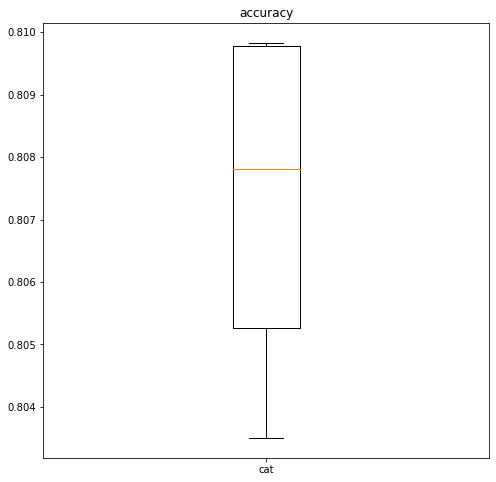

In [338]:
#prueba
models = []
models.append(('cat', best_cat_model))
model_evaluation(models, y = y_prueba)

## Tuneo del CatBoostClassifier

In [272]:
# Crear un objeto CatBoostClassifier
model = CatBoostClassifier()

# Definir los hiperparámetros y sus valores a sintonizar
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'n_estimators': [100, 200, 300],
}

# Realizar la búsqueda en cuadrícula (grid search) con validación cruzada
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X, y_prueba)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_

# Crear un nuevo modelo CatBoostClassifier con los mejores hiperparámetros
best_cat_model = CatBoostClassifier(**best_params)

# Ajustar el modelo con los mejores hiperparámetros en los datos de entrenamiento completos
best_cat_model.fit(X, y_prueba)

# Realizar predicciones con el modelo ajustado en los datos de prueba
y_pred = best_cat_model.predict(X)

precision = accuracy_score(y_prueba, y_pred)
print(precision)

0:	learn: 1.0916986	total: 30.1ms	remaining: 2.98s
1:	learn: 1.0850356	total: 37.1ms	remaining: 1.82s
2:	learn: 1.0784598	total: 44.2ms	remaining: 1.43s
3:	learn: 1.0721228	total: 51ms	remaining: 1.22s
4:	learn: 1.0658602	total: 57.6ms	remaining: 1.09s
5:	learn: 1.0597293	total: 63.8ms	remaining: 1s
6:	learn: 1.0538132	total: 70.5ms	remaining: 936ms
7:	learn: 1.0480722	total: 77ms	remaining: 885ms
8:	learn: 1.0423491	total: 83.1ms	remaining: 840ms
9:	learn: 1.0368215	total: 89.3ms	remaining: 803ms
10:	learn: 1.0313459	total: 95.5ms	remaining: 773ms
11:	learn: 1.0260443	total: 103ms	remaining: 753ms
12:	learn: 1.0210130	total: 110ms	remaining: 734ms
13:	learn: 1.0158878	total: 116ms	remaining: 714ms
14:	learn: 1.0108755	total: 122ms	remaining: 694ms
15:	learn: 1.0059880	total: 129ms	remaining: 675ms
16:	learn: 1.0011822	total: 136ms	remaining: 662ms
17:	learn: 0.9964645	total: 142ms	remaining: 646ms
18:	learn: 0.9918405	total: 148ms	remaining: 632ms
19:	learn: 0.9873171	total: 155ms	rem

80:	learn: 0.8206777	total: 569ms	remaining: 133ms
81:	learn: 0.8190999	total: 575ms	remaining: 126ms
82:	learn: 0.8174959	total: 582ms	remaining: 119ms
83:	learn: 0.8159271	total: 590ms	remaining: 112ms
84:	learn: 0.8143861	total: 596ms	remaining: 105ms
85:	learn: 0.8128615	total: 602ms	remaining: 98ms
86:	learn: 0.8113870	total: 609ms	remaining: 91ms
87:	learn: 0.8098893	total: 616ms	remaining: 84ms
88:	learn: 0.8084464	total: 623ms	remaining: 77ms
89:	learn: 0.8070955	total: 630ms	remaining: 70ms
90:	learn: 0.8056219	total: 639ms	remaining: 63.1ms
91:	learn: 0.8042959	total: 647ms	remaining: 56.2ms
92:	learn: 0.8029973	total: 656ms	remaining: 49.4ms
93:	learn: 0.8016252	total: 664ms	remaining: 42.4ms
94:	learn: 0.8003278	total: 675ms	remaining: 35.5ms
95:	learn: 0.7990613	total: 685ms	remaining: 28.5ms
96:	learn: 0.7977643	total: 695ms	remaining: 21.5ms
97:	learn: 0.7965380	total: 703ms	remaining: 14.3ms
98:	learn: 0.7952620	total: 710ms	remaining: 7.17ms
99:	learn: 0.7941116	total:

61:	learn: 0.8568019	total: 430ms	remaining: 263ms
62:	learn: 0.8547180	total: 436ms	remaining: 256ms
63:	learn: 0.8525980	total: 443ms	remaining: 249ms
64:	learn: 0.8504935	total: 450ms	remaining: 243ms
65:	learn: 0.8485206	total: 457ms	remaining: 235ms
66:	learn: 0.8465711	total: 463ms	remaining: 228ms
67:	learn: 0.8447040	total: 469ms	remaining: 221ms
68:	learn: 0.8427101	total: 476ms	remaining: 214ms
69:	learn: 0.8408848	total: 483ms	remaining: 207ms
70:	learn: 0.8389938	total: 490ms	remaining: 200ms
71:	learn: 0.8371848	total: 496ms	remaining: 193ms
72:	learn: 0.8352687	total: 504ms	remaining: 186ms
73:	learn: 0.8335837	total: 510ms	remaining: 179ms
74:	learn: 0.8318200	total: 517ms	remaining: 172ms
75:	learn: 0.8300056	total: 523ms	remaining: 165ms
76:	learn: 0.8282303	total: 530ms	remaining: 158ms
77:	learn: 0.8265488	total: 537ms	remaining: 152ms
78:	learn: 0.8248037	total: 544ms	remaining: 145ms
79:	learn: 0.8231663	total: 551ms	remaining: 138ms
80:	learn: 0.8215619	total: 557

40:	learn: 0.9102158	total: 260ms	remaining: 1.01s
41:	learn: 0.9072300	total: 267ms	remaining: 1s
42:	learn: 0.9042754	total: 275ms	remaining: 1s
43:	learn: 0.9013931	total: 281ms	remaining: 996ms
44:	learn: 0.8984862	total: 288ms	remaining: 992ms
45:	learn: 0.8957347	total: 294ms	remaining: 985ms
46:	learn: 0.8930003	total: 301ms	remaining: 980ms
47:	learn: 0.8902023	total: 308ms	remaining: 975ms
48:	learn: 0.8874895	total: 316ms	remaining: 972ms
49:	learn: 0.8848300	total: 324ms	remaining: 973ms
50:	learn: 0.8823873	total: 332ms	remaining: 971ms
51:	learn: 0.8797988	total: 340ms	remaining: 968ms
52:	learn: 0.8773552	total: 350ms	remaining: 970ms
53:	learn: 0.8749638	total: 359ms	remaining: 970ms
54:	learn: 0.8724917	total: 368ms	remaining: 969ms
55:	learn: 0.8701516	total: 376ms	remaining: 967ms
56:	learn: 0.8678089	total: 384ms	remaining: 964ms
57:	learn: 0.8655300	total: 391ms	remaining: 957ms
58:	learn: 0.8633412	total: 398ms	remaining: 950ms
59:	learn: 0.8610703	total: 405ms	rem

0:	learn: 1.0917138	total: 8.15ms	remaining: 1.62s
1:	learn: 1.0850446	total: 15.5ms	remaining: 1.53s
2:	learn: 1.0784580	total: 22.8ms	remaining: 1.49s
3:	learn: 1.0721069	total: 29.4ms	remaining: 1.44s
4:	learn: 1.0658591	total: 36.6ms	remaining: 1.43s
5:	learn: 1.0597428	total: 43ms	remaining: 1.39s
6:	learn: 1.0538239	total: 49.5ms	remaining: 1.36s
7:	learn: 1.0479624	total: 56.4ms	remaining: 1.35s
8:	learn: 1.0422525	total: 62.7ms	remaining: 1.33s
9:	learn: 1.0367234	total: 70.8ms	remaining: 1.34s
10:	learn: 1.0312452	total: 77.5ms	remaining: 1.33s
11:	learn: 1.0259577	total: 84.3ms	remaining: 1.32s
12:	learn: 1.0209316	total: 91.1ms	remaining: 1.31s
13:	learn: 1.0158118	total: 97.8ms	remaining: 1.3s
14:	learn: 1.0107284	total: 104ms	remaining: 1.29s
15:	learn: 1.0058416	total: 111ms	remaining: 1.28s
16:	learn: 1.0010367	total: 117ms	remaining: 1.26s
17:	learn: 0.9963228	total: 124ms	remaining: 1.25s
18:	learn: 0.9917023	total: 130ms	remaining: 1.24s
19:	learn: 0.9871825	total: 13

167:	learn: 0.7366615	total: 1.1s	remaining: 209ms
168:	learn: 0.7360983	total: 1.11s	remaining: 203ms
169:	learn: 0.7355486	total: 1.11s	remaining: 196ms
170:	learn: 0.7350482	total: 1.12s	remaining: 190ms
171:	learn: 0.7344396	total: 1.13s	remaining: 183ms
172:	learn: 0.7339617	total: 1.13s	remaining: 177ms
173:	learn: 0.7334174	total: 1.14s	remaining: 170ms
174:	learn: 0.7328440	total: 1.14s	remaining: 163ms
175:	learn: 0.7323519	total: 1.15s	remaining: 157ms
176:	learn: 0.7317706	total: 1.16s	remaining: 150ms
177:	learn: 0.7312881	total: 1.16s	remaining: 144ms
178:	learn: 0.7307646	total: 1.17s	remaining: 137ms
179:	learn: 0.7302207	total: 1.18s	remaining: 131ms
180:	learn: 0.7296742	total: 1.18s	remaining: 124ms
181:	learn: 0.7292029	total: 1.19s	remaining: 118ms
182:	learn: 0.7287821	total: 1.2s	remaining: 111ms
183:	learn: 0.7282928	total: 1.2s	remaining: 104ms
184:	learn: 0.7278214	total: 1.21s	remaining: 97.9ms
185:	learn: 0.7273898	total: 1.21s	remaining: 91.3ms
186:	learn: 0

128:	learn: 0.7645967	total: 833ms	remaining: 459ms
129:	learn: 0.7636860	total: 841ms	remaining: 453ms
130:	learn: 0.7628544	total: 848ms	remaining: 447ms
131:	learn: 0.7620162	total: 856ms	remaining: 441ms
132:	learn: 0.7612512	total: 863ms	remaining: 435ms
133:	learn: 0.7603756	total: 870ms	remaining: 429ms
134:	learn: 0.7595575	total: 877ms	remaining: 422ms
135:	learn: 0.7587818	total: 885ms	remaining: 416ms
136:	learn: 0.7579611	total: 892ms	remaining: 410ms
137:	learn: 0.7571391	total: 899ms	remaining: 404ms
138:	learn: 0.7563646	total: 906ms	remaining: 398ms
139:	learn: 0.7555946	total: 913ms	remaining: 391ms
140:	learn: 0.7548044	total: 921ms	remaining: 385ms
141:	learn: 0.7541629	total: 927ms	remaining: 379ms
142:	learn: 0.7533422	total: 933ms	remaining: 372ms
143:	learn: 0.7526237	total: 939ms	remaining: 365ms
144:	learn: 0.7519212	total: 945ms	remaining: 358ms
145:	learn: 0.7512425	total: 951ms	remaining: 352ms
146:	learn: 0.7505356	total: 957ms	remaining: 345ms
147:	learn: 

116:	learn: 0.7761884	total: 757ms	remaining: 537ms
117:	learn: 0.7751641	total: 764ms	remaining: 531ms
118:	learn: 0.7741621	total: 770ms	remaining: 524ms
119:	learn: 0.7730818	total: 777ms	remaining: 518ms
120:	learn: 0.7721136	total: 783ms	remaining: 511ms
121:	learn: 0.7711862	total: 790ms	remaining: 505ms
122:	learn: 0.7702578	total: 796ms	remaining: 499ms
123:	learn: 0.7693848	total: 803ms	remaining: 492ms
124:	learn: 0.7683780	total: 809ms	remaining: 485ms
125:	learn: 0.7674706	total: 815ms	remaining: 479ms
126:	learn: 0.7665088	total: 822ms	remaining: 472ms
127:	learn: 0.7656850	total: 828ms	remaining: 466ms
128:	learn: 0.7648407	total: 835ms	remaining: 460ms
129:	learn: 0.7639086	total: 841ms	remaining: 453ms
130:	learn: 0.7630747	total: 848ms	remaining: 447ms
131:	learn: 0.7622187	total: 855ms	remaining: 441ms
132:	learn: 0.7613666	total: 862ms	remaining: 434ms
133:	learn: 0.7605328	total: 869ms	remaining: 428ms
134:	learn: 0.7597401	total: 876ms	remaining: 422ms
135:	learn: 

99:	learn: 0.7964224	total: 665ms	remaining: 665ms
100:	learn: 0.7951564	total: 671ms	remaining: 658ms
101:	learn: 0.7939272	total: 679ms	remaining: 652ms
102:	learn: 0.7928051	total: 685ms	remaining: 645ms
103:	learn: 0.7915626	total: 691ms	remaining: 638ms
104:	learn: 0.7904048	total: 698ms	remaining: 631ms
105:	learn: 0.7892015	total: 704ms	remaining: 625ms
106:	learn: 0.7880621	total: 711ms	remaining: 618ms
107:	learn: 0.7869104	total: 716ms	remaining: 610ms
108:	learn: 0.7857782	total: 722ms	remaining: 603ms
109:	learn: 0.7847042	total: 728ms	remaining: 595ms
110:	learn: 0.7836098	total: 733ms	remaining: 588ms
111:	learn: 0.7825552	total: 740ms	remaining: 582ms
112:	learn: 0.7814878	total: 747ms	remaining: 575ms
113:	learn: 0.7804409	total: 753ms	remaining: 568ms
114:	learn: 0.7794204	total: 759ms	remaining: 561ms
115:	learn: 0.7783930	total: 766ms	remaining: 554ms
116:	learn: 0.7773211	total: 773ms	remaining: 548ms
117:	learn: 0.7763216	total: 778ms	remaining: 541ms
118:	learn: 0

61:	learn: 0.8566164	total: 414ms	remaining: 1.59s
62:	learn: 0.8545819	total: 421ms	remaining: 1.58s
63:	learn: 0.8523913	total: 428ms	remaining: 1.58s
64:	learn: 0.8502788	total: 435ms	remaining: 1.57s
65:	learn: 0.8482138	total: 440ms	remaining: 1.56s
66:	learn: 0.8462348	total: 446ms	remaining: 1.55s
67:	learn: 0.8443740	total: 453ms	remaining: 1.55s
68:	learn: 0.8424597	total: 460ms	remaining: 1.54s
69:	learn: 0.8406313	total: 466ms	remaining: 1.53s
70:	learn: 0.8387041	total: 473ms	remaining: 1.52s
71:	learn: 0.8369974	total: 480ms	remaining: 1.52s
72:	learn: 0.8350736	total: 487ms	remaining: 1.51s
73:	learn: 0.8332742	total: 494ms	remaining: 1.51s
74:	learn: 0.8314999	total: 500ms	remaining: 1.5s
75:	learn: 0.8296850	total: 507ms	remaining: 1.49s
76:	learn: 0.8279588	total: 514ms	remaining: 1.49s
77:	learn: 0.8261978	total: 521ms	remaining: 1.48s
78:	learn: 0.8245993	total: 527ms	remaining: 1.47s
79:	learn: 0.8229640	total: 533ms	remaining: 1.47s
80:	learn: 0.8213499	total: 539m

227:	learn: 0.7100161	total: 1.51s	remaining: 477ms
228:	learn: 0.7096493	total: 1.51s	remaining: 470ms
229:	learn: 0.7092951	total: 1.52s	remaining: 463ms
230:	learn: 0.7090203	total: 1.53s	remaining: 457ms
231:	learn: 0.7087458	total: 1.54s	remaining: 450ms
232:	learn: 0.7084435	total: 1.54s	remaining: 444ms
233:	learn: 0.7081218	total: 1.55s	remaining: 437ms
234:	learn: 0.7078164	total: 1.55s	remaining: 430ms
235:	learn: 0.7075330	total: 1.56s	remaining: 423ms
236:	learn: 0.7072281	total: 1.57s	remaining: 416ms
237:	learn: 0.7069001	total: 1.57s	remaining: 410ms
238:	learn: 0.7065685	total: 1.58s	remaining: 403ms
239:	learn: 0.7062285	total: 1.58s	remaining: 396ms
240:	learn: 0.7059030	total: 1.59s	remaining: 389ms
241:	learn: 0.7055688	total: 1.6s	remaining: 383ms
242:	learn: 0.7052796	total: 1.6s	remaining: 376ms
243:	learn: 0.7049415	total: 1.61s	remaining: 369ms
244:	learn: 0.7046294	total: 1.62s	remaining: 363ms
245:	learn: 0.7043270	total: 1.62s	remaining: 356ms
246:	learn: 0.

106:	learn: 0.7858520	total: 768ms	remaining: 1.39s
107:	learn: 0.7846894	total: 775ms	remaining: 1.38s
108:	learn: 0.7836504	total: 783ms	remaining: 1.37s
109:	learn: 0.7824887	total: 791ms	remaining: 1.37s
110:	learn: 0.7813953	total: 798ms	remaining: 1.36s
111:	learn: 0.7803615	total: 805ms	remaining: 1.35s
112:	learn: 0.7793240	total: 811ms	remaining: 1.34s
113:	learn: 0.7782587	total: 819ms	remaining: 1.33s
114:	learn: 0.7772545	total: 825ms	remaining: 1.33s
115:	learn: 0.7762326	total: 833ms	remaining: 1.32s
116:	learn: 0.7752162	total: 839ms	remaining: 1.31s
117:	learn: 0.7741826	total: 846ms	remaining: 1.3s
118:	learn: 0.7731549	total: 852ms	remaining: 1.29s
119:	learn: 0.7721207	total: 860ms	remaining: 1.29s
120:	learn: 0.7711198	total: 868ms	remaining: 1.28s
121:	learn: 0.7701802	total: 874ms	remaining: 1.27s
122:	learn: 0.7692455	total: 881ms	remaining: 1.27s
123:	learn: 0.7683552	total: 888ms	remaining: 1.26s
124:	learn: 0.7674240	total: 896ms	remaining: 1.25s
125:	learn: 0

292:	learn: 0.6928263	total: 2.05s	remaining: 48.9ms
293:	learn: 0.6926145	total: 2.05s	remaining: 41.9ms
294:	learn: 0.6924369	total: 2.06s	remaining: 34.9ms
295:	learn: 0.6922160	total: 2.07s	remaining: 27.9ms
296:	learn: 0.6920393	total: 2.07s	remaining: 20.9ms
297:	learn: 0.6918406	total: 2.08s	remaining: 14ms
298:	learn: 0.6916294	total: 2.09s	remaining: 6.98ms
299:	learn: 0.6914563	total: 2.09s	remaining: 0us
0:	learn: 1.0917155	total: 6.19ms	remaining: 1.85s
1:	learn: 1.0850573	total: 12.2ms	remaining: 1.82s
2:	learn: 1.0785052	total: 18ms	remaining: 1.78s
3:	learn: 1.0721762	total: 24.6ms	remaining: 1.82s
4:	learn: 1.0659262	total: 31.6ms	remaining: 1.86s
5:	learn: 1.0598104	total: 37.7ms	remaining: 1.85s
6:	learn: 1.0539103	total: 43.6ms	remaining: 1.82s
7:	learn: 1.0480805	total: 50.2ms	remaining: 1.83s
8:	learn: 1.0423703	total: 57ms	remaining: 1.84s
9:	learn: 1.0367919	total: 63.1ms	remaining: 1.83s
10:	learn: 1.0313433	total: 69ms	remaining: 1.81s
11:	learn: 1.0260562	tota

152:	learn: 0.7463751	total: 990ms	remaining: 951ms
153:	learn: 0.7457512	total: 997ms	remaining: 945ms
154:	learn: 0.7450584	total: 1s	remaining: 939ms
155:	learn: 0.7443740	total: 1.01s	remaining: 932ms
156:	learn: 0.7437307	total: 1.01s	remaining: 925ms
157:	learn: 0.7430938	total: 1.02s	remaining: 919ms
158:	learn: 0.7424081	total: 1.03s	remaining: 912ms
159:	learn: 0.7417288	total: 1.03s	remaining: 905ms
160:	learn: 0.7410458	total: 1.04s	remaining: 898ms
161:	learn: 0.7404446	total: 1.05s	remaining: 892ms
162:	learn: 0.7398609	total: 1.05s	remaining: 885ms
163:	learn: 0.7391623	total: 1.06s	remaining: 878ms
164:	learn: 0.7385246	total: 1.06s	remaining: 872ms
165:	learn: 0.7379722	total: 1.07s	remaining: 865ms
166:	learn: 0.7373695	total: 1.08s	remaining: 858ms
167:	learn: 0.7368600	total: 1.08s	remaining: 852ms
168:	learn: 0.7362896	total: 1.09s	remaining: 847ms
169:	learn: 0.7356798	total: 1.1s	remaining: 840ms
170:	learn: 0.7351386	total: 1.1s	remaining: 834ms
171:	learn: 0.734

13:	learn: 1.0157381	total: 89.9ms	remaining: 1.84s
14:	learn: 1.0107215	total: 96.8ms	remaining: 1.84s
15:	learn: 1.0058291	total: 105ms	remaining: 1.86s
16:	learn: 1.0010195	total: 113ms	remaining: 1.89s
17:	learn: 0.9963081	total: 122ms	remaining: 1.91s
18:	learn: 0.9916891	total: 130ms	remaining: 1.92s
19:	learn: 0.9873190	total: 138ms	remaining: 1.93s
20:	learn: 0.9828950	total: 146ms	remaining: 1.95s
21:	learn: 0.9785948	total: 155ms	remaining: 1.95s
22:	learn: 0.9743747	total: 163ms	remaining: 1.96s
23:	learn: 0.9702880	total: 171ms	remaining: 1.97s
24:	learn: 0.9661955	total: 178ms	remaining: 1.96s
25:	learn: 0.9621116	total: 186ms	remaining: 1.96s
26:	learn: 0.9581738	total: 192ms	remaining: 1.94s
27:	learn: 0.9543193	total: 199ms	remaining: 1.93s
28:	learn: 0.9505625	total: 205ms	remaining: 1.92s
29:	learn: 0.9469161	total: 212ms	remaining: 1.91s
30:	learn: 0.9432765	total: 219ms	remaining: 1.9s
31:	learn: 0.9397321	total: 225ms	remaining: 1.89s
32:	learn: 0.9361662	total: 23

182:	learn: 0.7289130	total: 1.18s	remaining: 757ms
183:	learn: 0.7283962	total: 1.19s	remaining: 750ms
184:	learn: 0.7279541	total: 1.2s	remaining: 743ms
185:	learn: 0.7274476	total: 1.2s	remaining: 737ms
186:	learn: 0.7269801	total: 1.21s	remaining: 730ms
187:	learn: 0.7265345	total: 1.22s	remaining: 724ms
188:	learn: 0.7260354	total: 1.22s	remaining: 717ms
189:	learn: 0.7255469	total: 1.23s	remaining: 711ms
190:	learn: 0.7250650	total: 1.23s	remaining: 704ms
191:	learn: 0.7246514	total: 1.24s	remaining: 698ms
192:	learn: 0.7242315	total: 1.25s	remaining: 692ms
193:	learn: 0.7237079	total: 1.25s	remaining: 685ms
194:	learn: 0.7232585	total: 1.26s	remaining: 679ms
195:	learn: 0.7227958	total: 1.27s	remaining: 672ms
196:	learn: 0.7223806	total: 1.27s	remaining: 666ms
197:	learn: 0.7219664	total: 1.28s	remaining: 660ms
198:	learn: 0.7214583	total: 1.29s	remaining: 653ms
199:	learn: 0.7210463	total: 1.29s	remaining: 647ms
200:	learn: 0.7206123	total: 1.3s	remaining: 641ms
201:	learn: 0.7

67:	learn: 0.8460267	total: 421ms	remaining: 1.44s
68:	learn: 0.8441104	total: 428ms	remaining: 1.43s
69:	learn: 0.8422822	total: 434ms	remaining: 1.43s
70:	learn: 0.8403977	total: 441ms	remaining: 1.42s
71:	learn: 0.8385575	total: 447ms	remaining: 1.42s
72:	learn: 0.8366921	total: 454ms	remaining: 1.41s
73:	learn: 0.8350036	total: 460ms	remaining: 1.41s
74:	learn: 0.8332227	total: 466ms	remaining: 1.4s
75:	learn: 0.8314095	total: 473ms	remaining: 1.39s
76:	learn: 0.8297165	total: 479ms	remaining: 1.39s
77:	learn: 0.8280193	total: 487ms	remaining: 1.38s
78:	learn: 0.8263443	total: 493ms	remaining: 1.38s
79:	learn: 0.8247942	total: 498ms	remaining: 1.37s
80:	learn: 0.8232302	total: 504ms	remaining: 1.36s
81:	learn: 0.8216425	total: 511ms	remaining: 1.36s
82:	learn: 0.8200478	total: 518ms	remaining: 1.35s
83:	learn: 0.8184701	total: 524ms	remaining: 1.35s
84:	learn: 0.8169219	total: 530ms	remaining: 1.34s
85:	learn: 0.8154425	total: 536ms	remaining: 1.33s
86:	learn: 0.8140643	total: 542m

233:	learn: 0.7103346	total: 1.51s	remaining: 427ms
234:	learn: 0.7100827	total: 1.52s	remaining: 421ms
235:	learn: 0.7097935	total: 1.53s	remaining: 415ms
236:	learn: 0.7094786	total: 1.54s	remaining: 408ms
237:	learn: 0.7091484	total: 1.54s	remaining: 402ms
238:	learn: 0.7088400	total: 1.55s	remaining: 396ms
239:	learn: 0.7084903	total: 1.55s	remaining: 389ms
240:	learn: 0.7081473	total: 1.56s	remaining: 382ms
241:	learn: 0.7077982	total: 1.57s	remaining: 376ms
242:	learn: 0.7075079	total: 1.57s	remaining: 369ms
243:	learn: 0.7072013	total: 1.58s	remaining: 363ms
244:	learn: 0.7069119	total: 1.59s	remaining: 356ms
245:	learn: 0.7065637	total: 1.59s	remaining: 350ms
246:	learn: 0.7062151	total: 1.6s	remaining: 343ms
247:	learn: 0.7059421	total: 1.6s	remaining: 337ms
248:	learn: 0.7057053	total: 1.61s	remaining: 330ms
249:	learn: 0.7053510	total: 1.62s	remaining: 324ms
250:	learn: 0.7050496	total: 1.63s	remaining: 317ms
251:	learn: 0.7047850	total: 1.63s	remaining: 311ms
252:	learn: 0.

93:	learn: 0.6283240	total: 618ms	remaining: 39.4ms
94:	learn: 0.6274311	total: 625ms	remaining: 32.9ms
95:	learn: 0.6270534	total: 631ms	remaining: 26.3ms
96:	learn: 0.6267595	total: 637ms	remaining: 19.7ms
97:	learn: 0.6263461	total: 643ms	remaining: 13.1ms
98:	learn: 0.6259678	total: 650ms	remaining: 6.56ms
99:	learn: 0.6254229	total: 656ms	remaining: 0us
0:	learn: 1.0327950	total: 6.6ms	remaining: 654ms
1:	learn: 0.9819766	total: 13.3ms	remaining: 652ms
2:	learn: 0.9404748	total: 20ms	remaining: 647ms
3:	learn: 0.9052882	total: 26.3ms	remaining: 630ms
4:	learn: 0.8786821	total: 33ms	remaining: 628ms
5:	learn: 0.8537959	total: 39ms	remaining: 610ms
6:	learn: 0.8341111	total: 45.2ms	remaining: 601ms
7:	learn: 0.8168254	total: 51.3ms	remaining: 590ms
8:	learn: 0.8025604	total: 57ms	remaining: 576ms
9:	learn: 0.7886970	total: 63.4ms	remaining: 570ms
10:	learn: 0.7771781	total: 70.3ms	remaining: 569ms
11:	learn: 0.7678753	total: 76.3ms	remaining: 560ms
12:	learn: 0.7589282	total: 82.1ms

75:	learn: 0.6403239	total: 495ms	remaining: 156ms
76:	learn: 0.6399746	total: 501ms	remaining: 150ms
77:	learn: 0.6391984	total: 508ms	remaining: 143ms
78:	learn: 0.6385475	total: 514ms	remaining: 137ms
79:	learn: 0.6376710	total: 520ms	remaining: 130ms
80:	learn: 0.6366410	total: 527ms	remaining: 124ms
81:	learn: 0.6359060	total: 533ms	remaining: 117ms
82:	learn: 0.6351267	total: 539ms	remaining: 110ms
83:	learn: 0.6343863	total: 546ms	remaining: 104ms
84:	learn: 0.6340594	total: 551ms	remaining: 97.2ms
85:	learn: 0.6333505	total: 556ms	remaining: 90.6ms
86:	learn: 0.6331192	total: 563ms	remaining: 84.1ms
87:	learn: 0.6325487	total: 569ms	remaining: 77.6ms
88:	learn: 0.6321830	total: 576ms	remaining: 71.2ms
89:	learn: 0.6318560	total: 582ms	remaining: 64.6ms
90:	learn: 0.6314535	total: 587ms	remaining: 58.1ms
91:	learn: 0.6308688	total: 593ms	remaining: 51.5ms
92:	learn: 0.6303608	total: 599ms	remaining: 45.1ms
93:	learn: 0.6298070	total: 604ms	remaining: 38.5ms
94:	learn: 0.6293349	

57:	learn: 0.6536352	total: 392ms	remaining: 284ms
58:	learn: 0.6530534	total: 399ms	remaining: 277ms
59:	learn: 0.6521955	total: 407ms	remaining: 271ms
60:	learn: 0.6512163	total: 413ms	remaining: 264ms
61:	learn: 0.6505872	total: 420ms	remaining: 257ms
62:	learn: 0.6498547	total: 426ms	remaining: 250ms
63:	learn: 0.6489695	total: 433ms	remaining: 244ms
64:	learn: 0.6473646	total: 441ms	remaining: 237ms
65:	learn: 0.6466997	total: 447ms	remaining: 230ms
66:	learn: 0.6460107	total: 454ms	remaining: 224ms
67:	learn: 0.6451121	total: 460ms	remaining: 216ms
68:	learn: 0.6441486	total: 465ms	remaining: 209ms
69:	learn: 0.6433174	total: 472ms	remaining: 202ms
70:	learn: 0.6424573	total: 478ms	remaining: 195ms
71:	learn: 0.6418996	total: 485ms	remaining: 188ms
72:	learn: 0.6412714	total: 490ms	remaining: 181ms
73:	learn: 0.6407497	total: 496ms	remaining: 174ms
74:	learn: 0.6397163	total: 503ms	remaining: 168ms
75:	learn: 0.6391328	total: 510ms	remaining: 161ms
76:	learn: 0.6387282	total: 516

121:	learn: 0.6153491	total: 778ms	remaining: 497ms
122:	learn: 0.6149207	total: 784ms	remaining: 491ms
123:	learn: 0.6143658	total: 791ms	remaining: 485ms
124:	learn: 0.6137696	total: 798ms	remaining: 479ms
125:	learn: 0.6134335	total: 804ms	remaining: 472ms
126:	learn: 0.6131304	total: 810ms	remaining: 466ms
127:	learn: 0.6124653	total: 816ms	remaining: 459ms
128:	learn: 0.6117175	total: 823ms	remaining: 453ms
129:	learn: 0.6113093	total: 829ms	remaining: 447ms
130:	learn: 0.6107972	total: 835ms	remaining: 440ms
131:	learn: 0.6102707	total: 841ms	remaining: 433ms
132:	learn: 0.6097924	total: 847ms	remaining: 427ms
133:	learn: 0.6095335	total: 854ms	remaining: 421ms
134:	learn: 0.6093532	total: 860ms	remaining: 414ms
135:	learn: 0.6088328	total: 866ms	remaining: 407ms
136:	learn: 0.6082633	total: 872ms	remaining: 401ms
137:	learn: 0.6078174	total: 878ms	remaining: 394ms
138:	learn: 0.6072832	total: 885ms	remaining: 388ms
139:	learn: 0.6067656	total: 890ms	remaining: 382ms
140:	learn: 

91:	learn: 0.6287582	total: 570ms	remaining: 669ms
92:	learn: 0.6280918	total: 578ms	remaining: 665ms
93:	learn: 0.6277306	total: 584ms	remaining: 659ms
94:	learn: 0.6273016	total: 590ms	remaining: 653ms
95:	learn: 0.6269379	total: 596ms	remaining: 646ms
96:	learn: 0.6265503	total: 602ms	remaining: 639ms
97:	learn: 0.6261098	total: 609ms	remaining: 634ms
98:	learn: 0.6257449	total: 615ms	remaining: 628ms
99:	learn: 0.6254529	total: 620ms	remaining: 620ms
100:	learn: 0.6249762	total: 627ms	remaining: 614ms
101:	learn: 0.6244965	total: 633ms	remaining: 608ms
102:	learn: 0.6241345	total: 639ms	remaining: 601ms
103:	learn: 0.6237031	total: 645ms	remaining: 595ms
104:	learn: 0.6231915	total: 651ms	remaining: 589ms
105:	learn: 0.6223331	total: 657ms	remaining: 583ms
106:	learn: 0.6218991	total: 663ms	remaining: 577ms
107:	learn: 0.6212700	total: 670ms	remaining: 571ms
108:	learn: 0.6207996	total: 675ms	remaining: 564ms
109:	learn: 0.6200096	total: 681ms	remaining: 557ms
110:	learn: 0.6195786

52:	learn: 0.6601505	total: 368ms	remaining: 1.02s
53:	learn: 0.6590707	total: 378ms	remaining: 1.02s
54:	learn: 0.6577014	total: 386ms	remaining: 1.02s
55:	learn: 0.6565927	total: 392ms	remaining: 1.01s
56:	learn: 0.6553832	total: 398ms	remaining: 999ms
57:	learn: 0.6545027	total: 405ms	remaining: 992ms
58:	learn: 0.6538231	total: 412ms	remaining: 985ms
59:	learn: 0.6529905	total: 420ms	remaining: 980ms
60:	learn: 0.6523874	total: 426ms	remaining: 971ms
61:	learn: 0.6513854	total: 432ms	remaining: 961ms
62:	learn: 0.6501245	total: 438ms	remaining: 952ms
63:	learn: 0.6494081	total: 444ms	remaining: 944ms
64:	learn: 0.6484627	total: 451ms	remaining: 936ms
65:	learn: 0.6477277	total: 456ms	remaining: 927ms
66:	learn: 0.6467498	total: 463ms	remaining: 919ms
67:	learn: 0.6460445	total: 469ms	remaining: 911ms
68:	learn: 0.6452821	total: 476ms	remaining: 905ms
69:	learn: 0.6447459	total: 483ms	remaining: 896ms
70:	learn: 0.6436887	total: 489ms	remaining: 889ms
71:	learn: 0.6428339	total: 495

30:	learn: 0.6882499	total: 229ms	remaining: 1.25s
31:	learn: 0.6865177	total: 236ms	remaining: 1.24s
32:	learn: 0.6845854	total: 243ms	remaining: 1.23s
33:	learn: 0.6826880	total: 250ms	remaining: 1.22s
34:	learn: 0.6810539	total: 256ms	remaining: 1.21s
35:	learn: 0.6797376	total: 263ms	remaining: 1.2s
36:	learn: 0.6782756	total: 269ms	remaining: 1.19s
37:	learn: 0.6766158	total: 277ms	remaining: 1.18s
38:	learn: 0.6746975	total: 285ms	remaining: 1.17s
39:	learn: 0.6730826	total: 291ms	remaining: 1.17s
40:	learn: 0.6721118	total: 297ms	remaining: 1.15s
41:	learn: 0.6703707	total: 304ms	remaining: 1.15s
42:	learn: 0.6695394	total: 311ms	remaining: 1.14s
43:	learn: 0.6687008	total: 318ms	remaining: 1.13s
44:	learn: 0.6677354	total: 324ms	remaining: 1.11s
45:	learn: 0.6666374	total: 330ms	remaining: 1.1s
46:	learn: 0.6650215	total: 337ms	remaining: 1.1s
47:	learn: 0.6640822	total: 344ms	remaining: 1.09s
48:	learn: 0.6631692	total: 351ms	remaining: 1.08s
49:	learn: 0.6615145	total: 358ms	

7:	learn: 0.8190252	total: 52ms	remaining: 1.25s
8:	learn: 0.8048320	total: 58.9ms	remaining: 1.25s
9:	learn: 0.7914199	total: 66.4ms	remaining: 1.26s
10:	learn: 0.7804255	total: 73.5ms	remaining: 1.26s
11:	learn: 0.7710699	total: 80.4ms	remaining: 1.26s
12:	learn: 0.7622700	total: 86.4ms	remaining: 1.24s
13:	learn: 0.7541090	total: 91.9ms	remaining: 1.22s
14:	learn: 0.7468862	total: 98.4ms	remaining: 1.21s
15:	learn: 0.7400001	total: 105ms	remaining: 1.2s
16:	learn: 0.7342449	total: 112ms	remaining: 1.21s
17:	learn: 0.7280858	total: 118ms	remaining: 1.19s
18:	learn: 0.7235301	total: 123ms	remaining: 1.18s
19:	learn: 0.7196636	total: 129ms	remaining: 1.17s
20:	learn: 0.7156179	total: 136ms	remaining: 1.16s
21:	learn: 0.7115316	total: 143ms	remaining: 1.15s
22:	learn: 0.7083711	total: 148ms	remaining: 1.14s
23:	learn: 0.7047954	total: 155ms	remaining: 1.14s
24:	learn: 0.7022690	total: 161ms	remaining: 1.13s
25:	learn: 0.7001924	total: 166ms	remaining: 1.11s
26:	learn: 0.6983027	total: 1

181:	learn: 0.5917268	total: 1.15s	remaining: 113ms
182:	learn: 0.5913273	total: 1.15s	remaining: 107ms
183:	learn: 0.5908381	total: 1.16s	remaining: 101ms
184:	learn: 0.5903706	total: 1.17s	remaining: 94.6ms
185:	learn: 0.5901066	total: 1.17s	remaining: 88.3ms
186:	learn: 0.5897066	total: 1.18s	remaining: 82.1ms
187:	learn: 0.5894446	total: 1.19s	remaining: 75.9ms
188:	learn: 0.5889408	total: 1.19s	remaining: 69.5ms
189:	learn: 0.5887007	total: 1.2s	remaining: 63.2ms
190:	learn: 0.5885110	total: 1.21s	remaining: 56.9ms
191:	learn: 0.5882568	total: 1.21s	remaining: 50.6ms
192:	learn: 0.5879975	total: 1.22s	remaining: 44.3ms
193:	learn: 0.5878589	total: 1.23s	remaining: 38ms
194:	learn: 0.5876282	total: 1.23s	remaining: 31.7ms
195:	learn: 0.5873761	total: 1.24s	remaining: 25.3ms
196:	learn: 0.5870888	total: 1.25s	remaining: 19ms
197:	learn: 0.5869767	total: 1.25s	remaining: 12.7ms
198:	learn: 0.5867873	total: 1.26s	remaining: 6.33ms
199:	learn: 0.5864181	total: 1.26s	remaining: 0us
0:	l

143:	learn: 0.6054865	total: 923ms	remaining: 1s
144:	learn: 0.6050341	total: 930ms	remaining: 994ms
145:	learn: 0.6046056	total: 937ms	remaining: 989ms
146:	learn: 0.6043067	total: 944ms	remaining: 982ms
147:	learn: 0.6037674	total: 949ms	remaining: 975ms
148:	learn: 0.6032657	total: 955ms	remaining: 968ms
149:	learn: 0.6029861	total: 961ms	remaining: 961ms
150:	learn: 0.6026984	total: 966ms	remaining: 954ms
151:	learn: 0.6022987	total: 973ms	remaining: 947ms
152:	learn: 0.6019236	total: 978ms	remaining: 940ms
153:	learn: 0.6017651	total: 984ms	remaining: 932ms
154:	learn: 0.6015172	total: 989ms	remaining: 925ms
155:	learn: 0.6013328	total: 994ms	remaining: 918ms
156:	learn: 0.6008878	total: 1s	remaining: 912ms
157:	learn: 0.6001365	total: 1.01s	remaining: 905ms
158:	learn: 0.5994877	total: 1.01s	remaining: 899ms
159:	learn: 0.5988033	total: 1.02s	remaining: 892ms
160:	learn: 0.5984231	total: 1.03s	remaining: 886ms
161:	learn: 0.5979112	total: 1.03s	remaining: 880ms
162:	learn: 0.5976

4:	learn: 0.8786821	total: 35.6ms	remaining: 2.1s
5:	learn: 0.8537959	total: 42.6ms	remaining: 2.09s
6:	learn: 0.8341111	total: 51.8ms	remaining: 2.17s
7:	learn: 0.8168254	total: 58.6ms	remaining: 2.14s
8:	learn: 0.8025604	total: 65.5ms	remaining: 2.12s
9:	learn: 0.7886970	total: 73ms	remaining: 2.12s
10:	learn: 0.7771781	total: 80.2ms	remaining: 2.11s
11:	learn: 0.7678753	total: 87.4ms	remaining: 2.1s
12:	learn: 0.7589282	total: 93.6ms	remaining: 2.06s
13:	learn: 0.7513012	total: 99.3ms	remaining: 2.03s
14:	learn: 0.7446433	total: 105ms	remaining: 2s
15:	learn: 0.7386416	total: 112ms	remaining: 1.99s
16:	learn: 0.7332264	total: 118ms	remaining: 1.96s
17:	learn: 0.7278375	total: 124ms	remaining: 1.95s
18:	learn: 0.7227517	total: 131ms	remaining: 1.94s
19:	learn: 0.7181459	total: 138ms	remaining: 1.93s
20:	learn: 0.7142615	total: 145ms	remaining: 1.93s
21:	learn: 0.7107648	total: 153ms	remaining: 1.94s
22:	learn: 0.7075629	total: 159ms	remaining: 1.92s
23:	learn: 0.7041249	total: 166ms	

179:	learn: 0.5910537	total: 1.13s	remaining: 755ms
180:	learn: 0.5907097	total: 1.14s	remaining: 750ms
181:	learn: 0.5905350	total: 1.15s	remaining: 743ms
182:	learn: 0.5902574	total: 1.15s	remaining: 737ms
183:	learn: 0.5898430	total: 1.16s	remaining: 731ms
184:	learn: 0.5894520	total: 1.17s	remaining: 725ms
185:	learn: 0.5891605	total: 1.17s	remaining: 718ms
186:	learn: 0.5888883	total: 1.18s	remaining: 712ms
187:	learn: 0.5885986	total: 1.18s	remaining: 705ms
188:	learn: 0.5882449	total: 1.19s	remaining: 699ms
189:	learn: 0.5880102	total: 1.2s	remaining: 692ms
190:	learn: 0.5875584	total: 1.2s	remaining: 686ms
191:	learn: 0.5873196	total: 1.21s	remaining: 679ms
192:	learn: 0.5868582	total: 1.21s	remaining: 672ms
193:	learn: 0.5866189	total: 1.22s	remaining: 666ms
194:	learn: 0.5863206	total: 1.23s	remaining: 660ms
195:	learn: 0.5861430	total: 1.23s	remaining: 653ms
196:	learn: 0.5855665	total: 1.24s	remaining: 648ms
197:	learn: 0.5852820	total: 1.24s	remaining: 641ms
198:	learn: 0.

66:	learn: 0.6467498	total: 439ms	remaining: 1.53s
67:	learn: 0.6460445	total: 445ms	remaining: 1.52s
68:	learn: 0.6452821	total: 452ms	remaining: 1.51s
69:	learn: 0.6447459	total: 458ms	remaining: 1.5s
70:	learn: 0.6436887	total: 465ms	remaining: 1.5s
71:	learn: 0.6428339	total: 470ms	remaining: 1.49s
72:	learn: 0.6419046	total: 476ms	remaining: 1.48s
73:	learn: 0.6413673	total: 482ms	remaining: 1.47s
74:	learn: 0.6409437	total: 488ms	remaining: 1.46s
75:	learn: 0.6403239	total: 494ms	remaining: 1.45s
76:	learn: 0.6399746	total: 499ms	remaining: 1.44s
77:	learn: 0.6391984	total: 505ms	remaining: 1.44s
78:	learn: 0.6385475	total: 511ms	remaining: 1.43s
79:	learn: 0.6376710	total: 517ms	remaining: 1.42s
80:	learn: 0.6366410	total: 524ms	remaining: 1.42s
81:	learn: 0.6359060	total: 530ms	remaining: 1.41s
82:	learn: 0.6351267	total: 536ms	remaining: 1.4s
83:	learn: 0.6343863	total: 543ms	remaining: 1.4s
84:	learn: 0.6340594	total: 549ms	remaining: 1.39s
85:	learn: 0.6333505	total: 555ms	r

238:	learn: 0.5784270	total: 1.53s	remaining: 390ms
239:	learn: 0.5782777	total: 1.53s	remaining: 384ms
240:	learn: 0.5779988	total: 1.54s	remaining: 378ms
241:	learn: 0.5777865	total: 1.55s	remaining: 371ms
242:	learn: 0.5776251	total: 1.55s	remaining: 365ms
243:	learn: 0.5774790	total: 1.56s	remaining: 358ms
244:	learn: 0.5773387	total: 1.56s	remaining: 351ms
245:	learn: 0.5771008	total: 1.57s	remaining: 345ms
246:	learn: 0.5769501	total: 1.58s	remaining: 339ms
247:	learn: 0.5768246	total: 1.58s	remaining: 332ms
248:	learn: 0.5765733	total: 1.59s	remaining: 326ms
249:	learn: 0.5762921	total: 1.6s	remaining: 319ms
250:	learn: 0.5760952	total: 1.6s	remaining: 313ms
251:	learn: 0.5758878	total: 1.61s	remaining: 307ms
252:	learn: 0.5754425	total: 1.61s	remaining: 300ms
253:	learn: 0.5752300	total: 1.62s	remaining: 294ms
254:	learn: 0.5749473	total: 1.63s	remaining: 287ms
255:	learn: 0.5747770	total: 1.63s	remaining: 281ms
256:	learn: 0.5746138	total: 1.64s	remaining: 275ms
257:	learn: 0.

100:	learn: 0.6245139	total: 670ms	remaining: 1.32s
101:	learn: 0.6242223	total: 677ms	remaining: 1.31s
102:	learn: 0.6238025	total: 684ms	remaining: 1.31s
103:	learn: 0.6236173	total: 689ms	remaining: 1.3s
104:	learn: 0.6233293	total: 695ms	remaining: 1.29s
105:	learn: 0.6225877	total: 701ms	remaining: 1.28s
106:	learn: 0.6218997	total: 707ms	remaining: 1.27s
107:	learn: 0.6212357	total: 713ms	remaining: 1.27s
108:	learn: 0.6205920	total: 719ms	remaining: 1.26s
109:	learn: 0.6200570	total: 726ms	remaining: 1.25s
110:	learn: 0.6197374	total: 732ms	remaining: 1.25s
111:	learn: 0.6189027	total: 738ms	remaining: 1.24s
112:	learn: 0.6181223	total: 744ms	remaining: 1.23s
113:	learn: 0.6178560	total: 750ms	remaining: 1.22s
114:	learn: 0.6171551	total: 756ms	remaining: 1.22s
115:	learn: 0.6167334	total: 763ms	remaining: 1.21s
116:	learn: 0.6161578	total: 769ms	remaining: 1.2s
117:	learn: 0.6157912	total: 774ms	remaining: 1.19s
118:	learn: 0.6155213	total: 779ms	remaining: 1.19s
119:	learn: 0.

272:	learn: 0.5666985	total: 1.77s	remaining: 175ms
273:	learn: 0.5663823	total: 1.77s	remaining: 168ms
274:	learn: 0.5660678	total: 1.78s	remaining: 162ms
275:	learn: 0.5659044	total: 1.79s	remaining: 155ms
276:	learn: 0.5655362	total: 1.79s	remaining: 149ms
277:	learn: 0.5653267	total: 1.8s	remaining: 142ms
278:	learn: 0.5651374	total: 1.8s	remaining: 136ms
279:	learn: 0.5648861	total: 1.81s	remaining: 129ms
280:	learn: 0.5647257	total: 1.82s	remaining: 123ms
281:	learn: 0.5645377	total: 1.82s	remaining: 116ms
282:	learn: 0.5644615	total: 1.83s	remaining: 110ms
283:	learn: 0.5643166	total: 1.83s	remaining: 103ms
284:	learn: 0.5641707	total: 1.84s	remaining: 96.9ms
285:	learn: 0.5640038	total: 1.85s	remaining: 90.4ms
286:	learn: 0.5638452	total: 1.85s	remaining: 84ms
287:	learn: 0.5636364	total: 1.86s	remaining: 77.5ms
288:	learn: 0.5634802	total: 1.87s	remaining: 71ms
289:	learn: 0.5632487	total: 1.87s	remaining: 64.5ms
290:	learn: 0.5630336	total: 1.88s	remaining: 58.1ms
291:	learn:

140:	learn: 0.6071369	total: 917ms	remaining: 1.03s
141:	learn: 0.6067261	total: 924ms	remaining: 1.03s
142:	learn: 0.6061926	total: 930ms	remaining: 1.02s
143:	learn: 0.6057858	total: 937ms	remaining: 1.01s
144:	learn: 0.6054747	total: 943ms	remaining: 1.01s
145:	learn: 0.6049808	total: 950ms	remaining: 1s
146:	learn: 0.6046078	total: 957ms	remaining: 996ms
147:	learn: 0.6040089	total: 963ms	remaining: 989ms
148:	learn: 0.6034427	total: 969ms	remaining: 982ms
149:	learn: 0.6027358	total: 975ms	remaining: 975ms
150:	learn: 0.6023852	total: 981ms	remaining: 968ms
151:	learn: 0.6019700	total: 988ms	remaining: 962ms
152:	learn: 0.6012671	total: 994ms	remaining: 955ms
153:	learn: 0.6009912	total: 1000ms	remaining: 948ms
154:	learn: 0.6007893	total: 1s	remaining: 941ms
155:	learn: 0.6003180	total: 1.01s	remaining: 934ms
156:	learn: 0.6000653	total: 1.02s	remaining: 927ms
157:	learn: 0.5997743	total: 1.02s	remaining: 920ms
158:	learn: 0.5995005	total: 1.03s	remaining: 912ms
159:	learn: 0.599

10:	learn: 0.7088645	total: 70.6ms	remaining: 571ms
11:	learn: 0.7036325	total: 77.6ms	remaining: 569ms
12:	learn: 0.6996249	total: 84.1ms	remaining: 563ms
13:	learn: 0.6955011	total: 91.8ms	remaining: 564ms
14:	learn: 0.6924115	total: 98.3ms	remaining: 557ms
15:	learn: 0.6869080	total: 105ms	remaining: 553ms
16:	learn: 0.6831877	total: 113ms	remaining: 550ms
17:	learn: 0.6806583	total: 119ms	remaining: 541ms
18:	learn: 0.6778538	total: 124ms	remaining: 529ms
19:	learn: 0.6757661	total: 129ms	remaining: 517ms
20:	learn: 0.6737847	total: 136ms	remaining: 511ms
21:	learn: 0.6698198	total: 142ms	remaining: 505ms
22:	learn: 0.6678099	total: 149ms	remaining: 497ms
23:	learn: 0.6655912	total: 154ms	remaining: 489ms
24:	learn: 0.6640791	total: 160ms	remaining: 480ms
25:	learn: 0.6615757	total: 166ms	remaining: 471ms
26:	learn: 0.6582059	total: 172ms	remaining: 466ms
27:	learn: 0.6564148	total: 179ms	remaining: 459ms
28:	learn: 0.6546877	total: 185ms	remaining: 452ms
29:	learn: 0.6534839	total

96:	learn: 0.5865204	total: 645ms	remaining: 20ms
97:	learn: 0.5861678	total: 652ms	remaining: 13.3ms
98:	learn: 0.5856764	total: 659ms	remaining: 6.66ms
99:	learn: 0.5850826	total: 666ms	remaining: 0us
0:	learn: 0.9742226	total: 6.84ms	remaining: 678ms
1:	learn: 0.9000863	total: 13.3ms	remaining: 652ms
2:	learn: 0.8494975	total: 19.3ms	remaining: 626ms
3:	learn: 0.8132825	total: 25.2ms	remaining: 605ms
4:	learn: 0.7864106	total: 31.8ms	remaining: 605ms
5:	learn: 0.7666302	total: 39.2ms	remaining: 614ms
6:	learn: 0.7487577	total: 45.3ms	remaining: 602ms
7:	learn: 0.7356945	total: 51.5ms	remaining: 593ms
8:	learn: 0.7258193	total: 57.6ms	remaining: 582ms
9:	learn: 0.7165922	total: 64ms	remaining: 576ms
10:	learn: 0.7086637	total: 70.8ms	remaining: 573ms
11:	learn: 0.7025352	total: 77ms	remaining: 565ms
12:	learn: 0.6972259	total: 84ms	remaining: 562ms
13:	learn: 0.6935101	total: 91.4ms	remaining: 562ms
14:	learn: 0.6897933	total: 100ms	remaining: 567ms
15:	learn: 0.6852613	total: 110ms	

83:	learn: 0.5953236	total: 554ms	remaining: 105ms
84:	learn: 0.5948574	total: 561ms	remaining: 99.1ms
85:	learn: 0.5940948	total: 569ms	remaining: 92.6ms
86:	learn: 0.5933991	total: 576ms	remaining: 86ms
87:	learn: 0.5927909	total: 581ms	remaining: 79.3ms
88:	learn: 0.5920793	total: 588ms	remaining: 72.7ms
89:	learn: 0.5915479	total: 595ms	remaining: 66.1ms
90:	learn: 0.5911536	total: 601ms	remaining: 59.4ms
91:	learn: 0.5909072	total: 607ms	remaining: 52.8ms
92:	learn: 0.5902879	total: 613ms	remaining: 46.1ms
93:	learn: 0.5897554	total: 619ms	remaining: 39.5ms
94:	learn: 0.5892466	total: 627ms	remaining: 33ms
95:	learn: 0.5886596	total: 634ms	remaining: 26.4ms
96:	learn: 0.5877570	total: 641ms	remaining: 19.8ms
97:	learn: 0.5868228	total: 648ms	remaining: 13.2ms
98:	learn: 0.5858833	total: 656ms	remaining: 6.62ms
99:	learn: 0.5853445	total: 663ms	remaining: 0us
0:	learn: 0.9744098	total: 7.47ms	remaining: 740ms
1:	learn: 0.9004772	total: 14.2ms	remaining: 695ms
2:	learn: 0.8503123	to

52:	learn: 0.6236717	total: 379ms	remaining: 1.05s
53:	learn: 0.6219577	total: 387ms	remaining: 1.05s
54:	learn: 0.6211093	total: 394ms	remaining: 1.04s
55:	learn: 0.6197408	total: 402ms	remaining: 1.03s
56:	learn: 0.6190380	total: 408ms	remaining: 1.02s
57:	learn: 0.6178086	total: 416ms	remaining: 1.02s
58:	learn: 0.6172186	total: 422ms	remaining: 1.01s
59:	learn: 0.6158709	total: 429ms	remaining: 1s
60:	learn: 0.6151987	total: 435ms	remaining: 992ms
61:	learn: 0.6143949	total: 442ms	remaining: 984ms
62:	learn: 0.6131926	total: 450ms	remaining: 978ms
63:	learn: 0.6119758	total: 457ms	remaining: 971ms
64:	learn: 0.6115226	total: 464ms	remaining: 963ms
65:	learn: 0.6109503	total: 471ms	remaining: 956ms
66:	learn: 0.6096667	total: 478ms	remaining: 948ms
67:	learn: 0.6091004	total: 484ms	remaining: 940ms
68:	learn: 0.6082597	total: 491ms	remaining: 932ms
69:	learn: 0.6074076	total: 498ms	remaining: 925ms
70:	learn: 0.6067980	total: 504ms	remaining: 916ms
71:	learn: 0.6057051	total: 512ms	

30:	learn: 0.6501733	total: 217ms	remaining: 1.18s
31:	learn: 0.6486069	total: 225ms	remaining: 1.18s
32:	learn: 0.6472351	total: 231ms	remaining: 1.17s
33:	learn: 0.6457626	total: 238ms	remaining: 1.16s
34:	learn: 0.6446609	total: 246ms	remaining: 1.16s
35:	learn: 0.6436488	total: 251ms	remaining: 1.15s
36:	learn: 0.6428088	total: 257ms	remaining: 1.13s
37:	learn: 0.6407167	total: 264ms	remaining: 1.12s
38:	learn: 0.6394269	total: 270ms	remaining: 1.11s
39:	learn: 0.6380460	total: 276ms	remaining: 1.1s
40:	learn: 0.6370699	total: 283ms	remaining: 1.1s
41:	learn: 0.6363867	total: 289ms	remaining: 1.09s
42:	learn: 0.6350441	total: 296ms	remaining: 1.08s
43:	learn: 0.6336010	total: 302ms	remaining: 1.07s
44:	learn: 0.6325710	total: 309ms	remaining: 1.06s
45:	learn: 0.6315773	total: 315ms	remaining: 1.05s
46:	learn: 0.6310006	total: 321ms	remaining: 1.04s
47:	learn: 0.6300719	total: 327ms	remaining: 1.04s
48:	learn: 0.6286978	total: 334ms	remaining: 1.03s
49:	learn: 0.6277243	total: 341ms

192:	learn: 0.5498016	total: 1.32s	remaining: 47.8ms
193:	learn: 0.5495611	total: 1.32s	remaining: 41ms
194:	learn: 0.5494223	total: 1.33s	remaining: 34.2ms
195:	learn: 0.5492922	total: 1.34s	remaining: 27.4ms
196:	learn: 0.5491413	total: 1.35s	remaining: 20.5ms
197:	learn: 0.5489800	total: 1.35s	remaining: 13.7ms
198:	learn: 0.5487449	total: 1.36s	remaining: 6.86ms
199:	learn: 0.5484049	total: 1.38s	remaining: 0us
0:	learn: 0.9742226	total: 7.1ms	remaining: 1.41s
1:	learn: 0.9000863	total: 13.7ms	remaining: 1.35s
2:	learn: 0.8494975	total: 20.5ms	remaining: 1.34s
3:	learn: 0.8132825	total: 27.8ms	remaining: 1.36s
4:	learn: 0.7864106	total: 34.3ms	remaining: 1.34s
5:	learn: 0.7666302	total: 41.3ms	remaining: 1.34s
6:	learn: 0.7487577	total: 48ms	remaining: 1.32s
7:	learn: 0.7356945	total: 54.8ms	remaining: 1.31s
8:	learn: 0.7258193	total: 62ms	remaining: 1.32s
9:	learn: 0.7165922	total: 69.2ms	remaining: 1.31s
10:	learn: 0.7086637	total: 76.9ms	remaining: 1.32s
11:	learn: 0.7025352	tot

170:	learn: 0.5594958	total: 1.16s	remaining: 197ms
171:	learn: 0.5590985	total: 1.17s	remaining: 190ms
172:	learn: 0.5585984	total: 1.18s	remaining: 184ms
173:	learn: 0.5579610	total: 1.19s	remaining: 177ms
174:	learn: 0.5574993	total: 1.19s	remaining: 170ms
175:	learn: 0.5569853	total: 1.2s	remaining: 164ms
176:	learn: 0.5564456	total: 1.21s	remaining: 157ms
177:	learn: 0.5560308	total: 1.21s	remaining: 150ms
178:	learn: 0.5556713	total: 1.22s	remaining: 143ms
179:	learn: 0.5554441	total: 1.23s	remaining: 136ms
180:	learn: 0.5553054	total: 1.23s	remaining: 130ms
181:	learn: 0.5547862	total: 1.24s	remaining: 123ms
182:	learn: 0.5545687	total: 1.25s	remaining: 116ms
183:	learn: 0.5542449	total: 1.25s	remaining: 109ms
184:	learn: 0.5538931	total: 1.26s	remaining: 102ms
185:	learn: 0.5537085	total: 1.27s	remaining: 95.5ms
186:	learn: 0.5535593	total: 1.27s	remaining: 88.6ms
187:	learn: 0.5528047	total: 1.28s	remaining: 81.8ms
188:	learn: 0.5524826	total: 1.29s	remaining: 75ms
189:	learn:

149:	learn: 0.5638612	total: 1.05s	remaining: 350ms
150:	learn: 0.5633263	total: 1.06s	remaining: 344ms
151:	learn: 0.5629112	total: 1.06s	remaining: 337ms
152:	learn: 0.5626306	total: 1.07s	remaining: 330ms
153:	learn: 0.5621827	total: 1.08s	remaining: 323ms
154:	learn: 0.5620011	total: 1.09s	remaining: 316ms
155:	learn: 0.5614189	total: 1.09s	remaining: 309ms
156:	learn: 0.5611573	total: 1.1s	remaining: 302ms
157:	learn: 0.5607229	total: 1.11s	remaining: 295ms
158:	learn: 0.5603654	total: 1.11s	remaining: 288ms
159:	learn: 0.5600043	total: 1.12s	remaining: 281ms
160:	learn: 0.5597488	total: 1.13s	remaining: 273ms
161:	learn: 0.5594553	total: 1.14s	remaining: 266ms
162:	learn: 0.5592060	total: 1.14s	remaining: 259ms
163:	learn: 0.5588137	total: 1.15s	remaining: 252ms
164:	learn: 0.5585051	total: 1.16s	remaining: 245ms
165:	learn: 0.5581858	total: 1.16s	remaining: 238ms
166:	learn: 0.5578980	total: 1.17s	remaining: 231ms
167:	learn: 0.5575067	total: 1.18s	remaining: 224ms
168:	learn: 0

133:	learn: 0.5712380	total: 927ms	remaining: 457ms
134:	learn: 0.5709582	total: 934ms	remaining: 450ms
135:	learn: 0.5704866	total: 942ms	remaining: 443ms
136:	learn: 0.5700656	total: 949ms	remaining: 436ms
137:	learn: 0.5697982	total: 956ms	remaining: 429ms
138:	learn: 0.5692806	total: 962ms	remaining: 422ms
139:	learn: 0.5689837	total: 969ms	remaining: 415ms
140:	learn: 0.5687019	total: 976ms	remaining: 408ms
141:	learn: 0.5683512	total: 982ms	remaining: 401ms
142:	learn: 0.5682474	total: 989ms	remaining: 394ms
143:	learn: 0.5679945	total: 995ms	remaining: 387ms
144:	learn: 0.5677827	total: 1s	remaining: 380ms
145:	learn: 0.5675248	total: 1.01s	remaining: 373ms
146:	learn: 0.5670071	total: 1.01s	remaining: 366ms
147:	learn: 0.5663601	total: 1.02s	remaining: 359ms
148:	learn: 0.5658415	total: 1.03s	remaining: 352ms
149:	learn: 0.5653484	total: 1.03s	remaining: 345ms
150:	learn: 0.5651243	total: 1.04s	remaining: 338ms
151:	learn: 0.5649138	total: 1.05s	remaining: 330ms
152:	learn: 0.5

109:	learn: 0.5816905	total: 773ms	remaining: 1.33s
110:	learn: 0.5809423	total: 780ms	remaining: 1.33s
111:	learn: 0.5806015	total: 787ms	remaining: 1.32s
112:	learn: 0.5803956	total: 794ms	remaining: 1.31s
113:	learn: 0.5798246	total: 800ms	remaining: 1.3s
114:	learn: 0.5790063	total: 807ms	remaining: 1.3s
115:	learn: 0.5787106	total: 814ms	remaining: 1.29s
116:	learn: 0.5783698	total: 821ms	remaining: 1.28s
117:	learn: 0.5778728	total: 827ms	remaining: 1.27s
118:	learn: 0.5776761	total: 833ms	remaining: 1.27s
119:	learn: 0.5772916	total: 839ms	remaining: 1.26s
120:	learn: 0.5765962	total: 847ms	remaining: 1.25s
121:	learn: 0.5762269	total: 853ms	remaining: 1.25s
122:	learn: 0.5755481	total: 860ms	remaining: 1.24s
123:	learn: 0.5750903	total: 868ms	remaining: 1.23s
124:	learn: 0.5745727	total: 874ms	remaining: 1.22s
125:	learn: 0.5743677	total: 880ms	remaining: 1.21s
126:	learn: 0.5740288	total: 885ms	remaining: 1.21s
127:	learn: 0.5733843	total: 891ms	remaining: 1.2s
128:	learn: 0.5

272:	learn: 0.5328215	total: 1.87s	remaining: 185ms
273:	learn: 0.5326977	total: 1.88s	remaining: 178ms
274:	learn: 0.5325387	total: 1.88s	remaining: 171ms
275:	learn: 0.5323708	total: 1.89s	remaining: 164ms
276:	learn: 0.5322747	total: 1.9s	remaining: 158ms
277:	learn: 0.5321326	total: 1.9s	remaining: 151ms
278:	learn: 0.5320217	total: 1.91s	remaining: 144ms
279:	learn: 0.5318767	total: 1.92s	remaining: 137ms
280:	learn: 0.5316089	total: 1.92s	remaining: 130ms
281:	learn: 0.5313771	total: 1.93s	remaining: 123ms
282:	learn: 0.5312243	total: 1.93s	remaining: 116ms
283:	learn: 0.5309954	total: 1.94s	remaining: 109ms
284:	learn: 0.5306921	total: 1.95s	remaining: 102ms
285:	learn: 0.5303701	total: 1.95s	remaining: 95.6ms
286:	learn: 0.5302670	total: 1.96s	remaining: 88.8ms
287:	learn: 0.5301497	total: 1.97s	remaining: 81.9ms
288:	learn: 0.5297742	total: 1.97s	remaining: 75.1ms
289:	learn: 0.5294812	total: 1.98s	remaining: 68.3ms
290:	learn: 0.5292423	total: 1.99s	remaining: 61.5ms
291:	lea

152:	learn: 0.5636710	total: 1.04s	remaining: 1s
153:	learn: 0.5631840	total: 1.05s	remaining: 996ms
154:	learn: 0.5630621	total: 1.06s	remaining: 989ms
155:	learn: 0.5627943	total: 1.06s	remaining: 983ms
156:	learn: 0.5626138	total: 1.07s	remaining: 976ms
157:	learn: 0.5623260	total: 1.08s	remaining: 969ms
158:	learn: 0.5619838	total: 1.08s	remaining: 963ms
159:	learn: 0.5612810	total: 1.09s	remaining: 957ms
160:	learn: 0.5609352	total: 1.1s	remaining: 950ms
161:	learn: 0.5601379	total: 1.11s	remaining: 943ms
162:	learn: 0.5596067	total: 1.11s	remaining: 938ms
163:	learn: 0.5591627	total: 1.13s	remaining: 933ms
164:	learn: 0.5588269	total: 1.13s	remaining: 928ms
165:	learn: 0.5586333	total: 1.14s	remaining: 922ms
166:	learn: 0.5582690	total: 1.15s	remaining: 917ms
167:	learn: 0.5580591	total: 1.16s	remaining: 913ms
168:	learn: 0.5578565	total: 1.17s	remaining: 907ms
169:	learn: 0.5576593	total: 1.18s	remaining: 901ms
170:	learn: 0.5573610	total: 1.19s	remaining: 897ms
171:	learn: 0.55

25:	learn: 0.6584559	total: 202ms	remaining: 2.13s
26:	learn: 0.6557475	total: 209ms	remaining: 2.12s
27:	learn: 0.6545040	total: 216ms	remaining: 2.09s
28:	learn: 0.6526789	total: 223ms	remaining: 2.08s
29:	learn: 0.6509298	total: 229ms	remaining: 2.06s
30:	learn: 0.6487289	total: 236ms	remaining: 2.05s
31:	learn: 0.6469439	total: 243ms	remaining: 2.03s
32:	learn: 0.6455516	total: 249ms	remaining: 2.02s
33:	learn: 0.6440034	total: 258ms	remaining: 2.02s
34:	learn: 0.6424499	total: 265ms	remaining: 2s
35:	learn: 0.6406322	total: 272ms	remaining: 2s
36:	learn: 0.6398048	total: 279ms	remaining: 1.98s
37:	learn: 0.6385035	total: 286ms	remaining: 1.97s
38:	learn: 0.6375763	total: 293ms	remaining: 1.96s
39:	learn: 0.6366280	total: 299ms	remaining: 1.95s
40:	learn: 0.6359156	total: 306ms	remaining: 1.93s
41:	learn: 0.6343074	total: 313ms	remaining: 1.92s
42:	learn: 0.6334336	total: 320ms	remaining: 1.91s
43:	learn: 0.6320654	total: 326ms	remaining: 1.9s
44:	learn: 0.6311589	total: 332ms	rema

212:	learn: 0.5466260	total: 1.48s	remaining: 606ms
213:	learn: 0.5464638	total: 1.49s	remaining: 599ms
214:	learn: 0.5461486	total: 1.5s	remaining: 592ms
215:	learn: 0.5455868	total: 1.5s	remaining: 585ms
216:	learn: 0.5453675	total: 1.51s	remaining: 578ms
217:	learn: 0.5451655	total: 1.52s	remaining: 571ms
218:	learn: 0.5449230	total: 1.53s	remaining: 565ms
219:	learn: 0.5448546	total: 1.53s	remaining: 558ms
220:	learn: 0.5447214	total: 1.54s	remaining: 551ms
221:	learn: 0.5446893	total: 1.55s	remaining: 545ms
222:	learn: 0.5445609	total: 1.56s	remaining: 538ms
223:	learn: 0.5444108	total: 1.57s	remaining: 532ms
224:	learn: 0.5442757	total: 1.57s	remaining: 525ms
225:	learn: 0.5441368	total: 1.58s	remaining: 518ms
226:	learn: 0.5439915	total: 1.59s	remaining: 512ms
227:	learn: 0.5438006	total: 1.6s	remaining: 505ms
228:	learn: 0.5435451	total: 1.61s	remaining: 498ms
229:	learn: 0.5432624	total: 1.61s	remaining: 491ms
230:	learn: 0.5430779	total: 1.62s	remaining: 484ms
231:	learn: 0.5

95:	learn: 0.5886596	total: 631ms	remaining: 1.34s
96:	learn: 0.5877570	total: 638ms	remaining: 1.33s
97:	learn: 0.5868228	total: 645ms	remaining: 1.33s
98:	learn: 0.5858833	total: 652ms	remaining: 1.32s
99:	learn: 0.5853445	total: 659ms	remaining: 1.32s
100:	learn: 0.5845429	total: 669ms	remaining: 1.32s
101:	learn: 0.5839720	total: 676ms	remaining: 1.31s
102:	learn: 0.5837921	total: 682ms	remaining: 1.3s
103:	learn: 0.5834859	total: 689ms	remaining: 1.3s
104:	learn: 0.5831613	total: 697ms	remaining: 1.29s
105:	learn: 0.5828490	total: 705ms	remaining: 1.29s
106:	learn: 0.5819716	total: 712ms	remaining: 1.28s
107:	learn: 0.5814257	total: 720ms	remaining: 1.28s
108:	learn: 0.5811432	total: 728ms	remaining: 1.28s
109:	learn: 0.5806215	total: 735ms	remaining: 1.27s
110:	learn: 0.5796587	total: 743ms	remaining: 1.26s
111:	learn: 0.5788258	total: 751ms	remaining: 1.26s
112:	learn: 0.5783673	total: 758ms	remaining: 1.25s
113:	learn: 0.5778282	total: 765ms	remaining: 1.25s
114:	learn: 0.57710

257:	learn: 0.5337633	total: 1.73s	remaining: 281ms
258:	learn: 0.5335388	total: 1.74s	remaining: 275ms
259:	learn: 0.5333791	total: 1.74s	remaining: 268ms
260:	learn: 0.5331428	total: 1.75s	remaining: 261ms
261:	learn: 0.5329915	total: 1.76s	remaining: 255ms
262:	learn: 0.5328246	total: 1.76s	remaining: 248ms
263:	learn: 0.5326585	total: 1.77s	remaining: 241ms
264:	learn: 0.5323993	total: 1.77s	remaining: 235ms
265:	learn: 0.5321368	total: 1.78s	remaining: 228ms
266:	learn: 0.5319547	total: 1.79s	remaining: 221ms
267:	learn: 0.5318087	total: 1.8s	remaining: 215ms
268:	learn: 0.5314583	total: 1.8s	remaining: 208ms
269:	learn: 0.5313049	total: 1.82s	remaining: 203ms
270:	learn: 0.5312183	total: 1.83s	remaining: 196ms
271:	learn: 0.5309376	total: 1.84s	remaining: 189ms
272:	learn: 0.5307750	total: 1.84s	remaining: 182ms
273:	learn: 0.5304699	total: 1.85s	remaining: 176ms
274:	learn: 0.5302298	total: 1.86s	remaining: 169ms
275:	learn: 0.5301626	total: 1.86s	remaining: 162ms
276:	learn: 0.

133:	learn: 0.5712380	total: 930ms	remaining: 1.15s
134:	learn: 0.5709582	total: 937ms	remaining: 1.14s
135:	learn: 0.5704866	total: 944ms	remaining: 1.14s
136:	learn: 0.5700656	total: 950ms	remaining: 1.13s
137:	learn: 0.5697982	total: 957ms	remaining: 1.12s
138:	learn: 0.5692806	total: 962ms	remaining: 1.11s
139:	learn: 0.5689837	total: 969ms	remaining: 1.11s
140:	learn: 0.5687019	total: 975ms	remaining: 1.1s
141:	learn: 0.5683512	total: 980ms	remaining: 1.09s
142:	learn: 0.5682474	total: 986ms	remaining: 1.08s
143:	learn: 0.5679945	total: 992ms	remaining: 1.07s
144:	learn: 0.5677827	total: 999ms	remaining: 1.07s
145:	learn: 0.5675248	total: 1s	remaining: 1.06s
146:	learn: 0.5670071	total: 1.01s	remaining: 1.05s
147:	learn: 0.5663601	total: 1.02s	remaining: 1.04s
148:	learn: 0.5658415	total: 1.02s	remaining: 1.04s
149:	learn: 0.5653484	total: 1.03s	remaining: 1.03s
150:	learn: 0.5651243	total: 1.03s	remaining: 1.02s
151:	learn: 0.5649138	total: 1.04s	remaining: 1.01s
152:	learn: 0.56

0:	learn: 1.0913367	total: 10.3ms	remaining: 1.02s
1:	learn: 1.0841648	total: 19.8ms	remaining: 971ms
2:	learn: 1.0773411	total: 29.9ms	remaining: 967ms
3:	learn: 1.0709174	total: 39.8ms	remaining: 956ms
4:	learn: 1.0642470	total: 49.8ms	remaining: 945ms
5:	learn: 1.0577367	total: 59.2ms	remaining: 928ms
6:	learn: 1.0513771	total: 68.6ms	remaining: 912ms
7:	learn: 1.0451208	total: 78.1ms	remaining: 898ms
8:	learn: 1.0391912	total: 87.3ms	remaining: 882ms
9:	learn: 1.0332840	total: 97.4ms	remaining: 877ms
10:	learn: 1.0275901	total: 108ms	remaining: 872ms
11:	learn: 1.0218557	total: 117ms	remaining: 858ms
12:	learn: 1.0162582	total: 126ms	remaining: 843ms
13:	learn: 1.0107705	total: 136ms	remaining: 833ms
14:	learn: 1.0055077	total: 146ms	remaining: 826ms
15:	learn: 1.0004759	total: 155ms	remaining: 812ms
16:	learn: 0.9954758	total: 165ms	remaining: 803ms
17:	learn: 0.9905595	total: 174ms	remaining: 791ms
18:	learn: 0.9858018	total: 183ms	remaining: 779ms
19:	learn: 0.9810100	total: 192

75:	learn: 0.8127749	total: 769ms	remaining: 243ms
76:	learn: 0.8109218	total: 780ms	remaining: 233ms
77:	learn: 0.8090798	total: 790ms	remaining: 223ms
78:	learn: 0.8072796	total: 799ms	remaining: 212ms
79:	learn: 0.8054431	total: 808ms	remaining: 202ms
80:	learn: 0.8036947	total: 817ms	remaining: 192ms
81:	learn: 0.8020274	total: 826ms	remaining: 181ms
82:	learn: 0.8003350	total: 836ms	remaining: 171ms
83:	learn: 0.7986098	total: 846ms	remaining: 161ms
84:	learn: 0.7969241	total: 855ms	remaining: 151ms
85:	learn: 0.7953196	total: 864ms	remaining: 141ms
86:	learn: 0.7936947	total: 875ms	remaining: 131ms
87:	learn: 0.7921274	total: 884ms	remaining: 121ms
88:	learn: 0.7905114	total: 894ms	remaining: 110ms
89:	learn: 0.7889616	total: 906ms	remaining: 101ms
90:	learn: 0.7874072	total: 915ms	remaining: 90.5ms
91:	learn: 0.7858362	total: 925ms	remaining: 80.4ms
92:	learn: 0.7843384	total: 935ms	remaining: 70.4ms
93:	learn: 0.7828727	total: 945ms	remaining: 60.3ms
94:	learn: 0.7814031	total:

41:	learn: 0.8958113	total: 409ms	remaining: 564ms
42:	learn: 0.8926733	total: 418ms	remaining: 554ms
43:	learn: 0.8895991	total: 429ms	remaining: 546ms
44:	learn: 0.8865967	total: 438ms	remaining: 535ms
45:	learn: 0.8837022	total: 447ms	remaining: 524ms
46:	learn: 0.8808298	total: 455ms	remaining: 514ms
47:	learn: 0.8779727	total: 465ms	remaining: 504ms
48:	learn: 0.8751048	total: 474ms	remaining: 494ms
49:	learn: 0.8723594	total: 484ms	remaining: 484ms
50:	learn: 0.8696820	total: 493ms	remaining: 474ms
51:	learn: 0.8668369	total: 503ms	remaining: 464ms
52:	learn: 0.8641723	total: 511ms	remaining: 453ms
53:	learn: 0.8615859	total: 520ms	remaining: 443ms
54:	learn: 0.8590309	total: 530ms	remaining: 434ms
55:	learn: 0.8564892	total: 539ms	remaining: 423ms
56:	learn: 0.8540596	total: 549ms	remaining: 414ms
57:	learn: 0.8517384	total: 559ms	remaining: 405ms
58:	learn: 0.8493563	total: 569ms	remaining: 395ms
59:	learn: 0.8469425	total: 578ms	remaining: 386ms
60:	learn: 0.8446417	total: 589

9:	learn: 1.0332840	total: 108ms	remaining: 2.06s
10:	learn: 1.0275901	total: 118ms	remaining: 2.03s
11:	learn: 1.0218557	total: 128ms	remaining: 2.01s
12:	learn: 1.0162582	total: 138ms	remaining: 1.98s
13:	learn: 1.0107705	total: 146ms	remaining: 1.94s
14:	learn: 1.0055077	total: 157ms	remaining: 1.93s
15:	learn: 1.0004759	total: 165ms	remaining: 1.9s
16:	learn: 0.9954758	total: 174ms	remaining: 1.87s
17:	learn: 0.9905595	total: 183ms	remaining: 1.85s
18:	learn: 0.9858018	total: 193ms	remaining: 1.84s
19:	learn: 0.9810100	total: 203ms	remaining: 1.82s
20:	learn: 0.9763583	total: 211ms	remaining: 1.8s
21:	learn: 0.9717164	total: 220ms	remaining: 1.78s
22:	learn: 0.9672477	total: 230ms	remaining: 1.77s
23:	learn: 0.9629395	total: 240ms	remaining: 1.76s
24:	learn: 0.9585511	total: 249ms	remaining: 1.74s
25:	learn: 0.9541841	total: 259ms	remaining: 1.73s
26:	learn: 0.9500165	total: 268ms	remaining: 1.72s
27:	learn: 0.9458726	total: 277ms	remaining: 1.7s
28:	learn: 0.9418079	total: 286ms	r

188:	learn: 0.6983403	total: 1.84s	remaining: 107ms
189:	learn: 0.6978078	total: 1.85s	remaining: 97.5ms
190:	learn: 0.6972844	total: 1.86s	remaining: 87.7ms
191:	learn: 0.6967990	total: 1.87s	remaining: 78ms
192:	learn: 0.6963828	total: 1.88s	remaining: 68.2ms
193:	learn: 0.6958622	total: 1.89s	remaining: 58.5ms
194:	learn: 0.6953594	total: 1.9s	remaining: 48.7ms
195:	learn: 0.6947795	total: 1.91s	remaining: 39ms
196:	learn: 0.6942841	total: 1.92s	remaining: 29.3ms
197:	learn: 0.6938073	total: 1.93s	remaining: 19.5ms
198:	learn: 0.6933927	total: 1.94s	remaining: 9.75ms
199:	learn: 0.6928950	total: 1.95s	remaining: 0us
0:	learn: 1.0912973	total: 10.1ms	remaining: 2.01s
1:	learn: 1.0841498	total: 19.2ms	remaining: 1.9s
2:	learn: 1.0773142	total: 29.8ms	remaining: 1.96s
3:	learn: 1.0708187	total: 38.7ms	remaining: 1.9s
4:	learn: 1.0641582	total: 48.6ms	remaining: 1.9s
5:	learn: 1.0577292	total: 58.6ms	remaining: 1.9s
6:	learn: 1.0513666	total: 68.6ms	remaining: 1.89s
7:	learn: 1.0451001	

155:	learn: 0.7188442	total: 1.53s	remaining: 431ms
156:	learn: 0.7180804	total: 1.54s	remaining: 421ms
157:	learn: 0.7173720	total: 1.55s	remaining: 411ms
158:	learn: 0.7166807	total: 1.56s	remaining: 402ms
159:	learn: 0.7160265	total: 1.57s	remaining: 392ms
160:	learn: 0.7153247	total: 1.58s	remaining: 382ms
161:	learn: 0.7146468	total: 1.59s	remaining: 372ms
162:	learn: 0.7139652	total: 1.59s	remaining: 362ms
163:	learn: 0.7132991	total: 1.6s	remaining: 352ms
164:	learn: 0.7126450	total: 1.61s	remaining: 342ms
165:	learn: 0.7120139	total: 1.62s	remaining: 332ms
166:	learn: 0.7114123	total: 1.63s	remaining: 322ms
167:	learn: 0.7107701	total: 1.64s	remaining: 313ms
168:	learn: 0.7100958	total: 1.65s	remaining: 303ms
169:	learn: 0.7094553	total: 1.66s	remaining: 293ms
170:	learn: 0.7088017	total: 1.67s	remaining: 283ms
171:	learn: 0.7081791	total: 1.68s	remaining: 273ms
172:	learn: 0.7075449	total: 1.69s	remaining: 263ms
173:	learn: 0.7069696	total: 1.7s	remaining: 254ms
174:	learn: 0.

122:	learn: 0.7478035	total: 1.25s	remaining: 785ms
123:	learn: 0.7467897	total: 1.26s	remaining: 775ms
124:	learn: 0.7457589	total: 1.27s	remaining: 764ms
125:	learn: 0.7448012	total: 1.28s	remaining: 753ms
126:	learn: 0.7437786	total: 1.29s	remaining: 743ms
127:	learn: 0.7428139	total: 1.3s	remaining: 732ms
128:	learn: 0.7418681	total: 1.31s	remaining: 721ms
129:	learn: 0.7408784	total: 1.32s	remaining: 710ms
130:	learn: 0.7400026	total: 1.33s	remaining: 700ms
131:	learn: 0.7390604	total: 1.34s	remaining: 689ms
132:	learn: 0.7381589	total: 1.35s	remaining: 679ms
133:	learn: 0.7372983	total: 1.36s	remaining: 669ms
134:	learn: 0.7363863	total: 1.37s	remaining: 658ms
135:	learn: 0.7355012	total: 1.38s	remaining: 647ms
136:	learn: 0.7345518	total: 1.39s	remaining: 638ms
137:	learn: 0.7336829	total: 1.4s	remaining: 628ms
138:	learn: 0.7328503	total: 1.41s	remaining: 618ms
139:	learn: 0.7319556	total: 1.42s	remaining: 608ms
140:	learn: 0.7310881	total: 1.43s	remaining: 597ms
141:	learn: 0.

90:	learn: 0.7880594	total: 896ms	remaining: 1.07s
91:	learn: 0.7864896	total: 905ms	remaining: 1.06s
92:	learn: 0.7849919	total: 916ms	remaining: 1.05s
93:	learn: 0.7835088	total: 925ms	remaining: 1.04s
94:	learn: 0.7820456	total: 935ms	remaining: 1.03s
95:	learn: 0.7806097	total: 946ms	remaining: 1.02s
96:	learn: 0.7792888	total: 956ms	remaining: 1.01s
97:	learn: 0.7778495	total: 964ms	remaining: 1s
98:	learn: 0.7764355	total: 974ms	remaining: 994ms
99:	learn: 0.7751073	total: 985ms	remaining: 985ms
100:	learn: 0.7737538	total: 995ms	remaining: 975ms
101:	learn: 0.7724102	total: 1.01s	remaining: 968ms
102:	learn: 0.7711145	total: 1.02s	remaining: 959ms
103:	learn: 0.7698269	total: 1.03s	remaining: 950ms
104:	learn: 0.7685129	total: 1.04s	remaining: 940ms
105:	learn: 0.7672677	total: 1.05s	remaining: 930ms
106:	learn: 0.7660360	total: 1.06s	remaining: 921ms
107:	learn: 0.7647730	total: 1.07s	remaining: 911ms
108:	learn: 0.7635454	total: 1.08s	remaining: 901ms
109:	learn: 0.7623945	tot

68:	learn: 0.8284640	total: 739ms	remaining: 1.4s
69:	learn: 0.8265016	total: 750ms	remaining: 1.39s
70:	learn: 0.8244362	total: 763ms	remaining: 1.39s
71:	learn: 0.8224561	total: 774ms	remaining: 1.38s
72:	learn: 0.8204196	total: 785ms	remaining: 1.36s
73:	learn: 0.8185093	total: 796ms	remaining: 1.35s
74:	learn: 0.8165499	total: 806ms	remaining: 1.34s
75:	learn: 0.8146455	total: 818ms	remaining: 1.33s
76:	learn: 0.8128142	total: 827ms	remaining: 1.32s
77:	learn: 0.8110127	total: 838ms	remaining: 1.31s
78:	learn: 0.8091881	total: 848ms	remaining: 1.3s
79:	learn: 0.8073807	total: 859ms	remaining: 1.29s
80:	learn: 0.8055694	total: 870ms	remaining: 1.28s
81:	learn: 0.8038652	total: 879ms	remaining: 1.26s
82:	learn: 0.8021839	total: 890ms	remaining: 1.25s
83:	learn: 0.8004909	total: 900ms	remaining: 1.24s
84:	learn: 0.7988062	total: 910ms	remaining: 1.23s
85:	learn: 0.7972166	total: 920ms	remaining: 1.22s
86:	learn: 0.7956123	total: 929ms	remaining: 1.21s
87:	learn: 0.7940089	total: 939ms

38:	learn: 0.9054122	total: 395ms	remaining: 2.65s
39:	learn: 0.9020999	total: 405ms	remaining: 2.63s
40:	learn: 0.8988052	total: 415ms	remaining: 2.62s
41:	learn: 0.8956256	total: 424ms	remaining: 2.61s
42:	learn: 0.8924727	total: 435ms	remaining: 2.6s
43:	learn: 0.8894021	total: 446ms	remaining: 2.59s
44:	learn: 0.8864527	total: 456ms	remaining: 2.58s
45:	learn: 0.8834809	total: 467ms	remaining: 2.58s
46:	learn: 0.8806456	total: 476ms	remaining: 2.56s
47:	learn: 0.8778153	total: 486ms	remaining: 2.55s
48:	learn: 0.8749672	total: 497ms	remaining: 2.55s
49:	learn: 0.8722162	total: 507ms	remaining: 2.54s
50:	learn: 0.8695485	total: 517ms	remaining: 2.52s
51:	learn: 0.8667967	total: 527ms	remaining: 2.51s
52:	learn: 0.8641046	total: 537ms	remaining: 2.5s
53:	learn: 0.8615172	total: 546ms	remaining: 2.49s
54:	learn: 0.8589596	total: 557ms	remaining: 2.48s
55:	learn: 0.8564915	total: 567ms	remaining: 2.47s
56:	learn: 0.8540700	total: 577ms	remaining: 2.46s
57:	learn: 0.8515837	total: 589ms

212:	learn: 0.6869577	total: 2.11s	remaining: 861ms
213:	learn: 0.6865181	total: 2.12s	remaining: 851ms
214:	learn: 0.6861791	total: 2.13s	remaining: 842ms
215:	learn: 0.6857822	total: 2.14s	remaining: 832ms
216:	learn: 0.6853694	total: 2.15s	remaining: 822ms
217:	learn: 0.6849992	total: 2.16s	remaining: 812ms
218:	learn: 0.6845539	total: 2.17s	remaining: 802ms
219:	learn: 0.6840815	total: 2.18s	remaining: 792ms
220:	learn: 0.6835753	total: 2.19s	remaining: 782ms
221:	learn: 0.6831309	total: 2.2s	remaining: 772ms
222:	learn: 0.6826937	total: 2.21s	remaining: 762ms
223:	learn: 0.6823500	total: 2.21s	remaining: 752ms
224:	learn: 0.6818395	total: 2.23s	remaining: 742ms
225:	learn: 0.6814456	total: 2.23s	remaining: 732ms
226:	learn: 0.6810153	total: 2.24s	remaining: 722ms
227:	learn: 0.6805801	total: 2.25s	remaining: 712ms
228:	learn: 0.6801911	total: 2.26s	remaining: 701ms
229:	learn: 0.6797879	total: 2.27s	remaining: 692ms
230:	learn: 0.6794455	total: 2.28s	remaining: 682ms
231:	learn: 0

80:	learn: 0.8036947	total: 804ms	remaining: 2.17s
81:	learn: 0.8020274	total: 813ms	remaining: 2.16s
82:	learn: 0.8003350	total: 822ms	remaining: 2.15s
83:	learn: 0.7986098	total: 832ms	remaining: 2.14s
84:	learn: 0.7969241	total: 841ms	remaining: 2.13s
85:	learn: 0.7953196	total: 850ms	remaining: 2.12s
86:	learn: 0.7936947	total: 860ms	remaining: 2.1s
87:	learn: 0.7921274	total: 870ms	remaining: 2.09s
88:	learn: 0.7905114	total: 878ms	remaining: 2.08s
89:	learn: 0.7889616	total: 888ms	remaining: 2.07s
90:	learn: 0.7874072	total: 898ms	remaining: 2.06s
91:	learn: 0.7858362	total: 907ms	remaining: 2.05s
92:	learn: 0.7843384	total: 916ms	remaining: 2.04s
93:	learn: 0.7828727	total: 926ms	remaining: 2.03s
94:	learn: 0.7814031	total: 937ms	remaining: 2.02s
95:	learn: 0.7799800	total: 947ms	remaining: 2.01s
96:	learn: 0.7785220	total: 955ms	remaining: 2s
97:	learn: 0.7770712	total: 965ms	remaining: 1.99s
98:	learn: 0.7756593	total: 974ms	remaining: 1.98s
99:	learn: 0.7742728	total: 982ms	r

257:	learn: 0.6701383	total: 2.54s	remaining: 413ms
258:	learn: 0.6698312	total: 2.55s	remaining: 404ms
259:	learn: 0.6694949	total: 2.56s	remaining: 394ms
260:	learn: 0.6692219	total: 2.57s	remaining: 384ms
261:	learn: 0.6688753	total: 2.58s	remaining: 374ms
262:	learn: 0.6685697	total: 2.59s	remaining: 364ms
263:	learn: 0.6683196	total: 2.6s	remaining: 354ms
264:	learn: 0.6680081	total: 2.61s	remaining: 344ms
265:	learn: 0.6676851	total: 2.62s	remaining: 335ms
266:	learn: 0.6674013	total: 2.63s	remaining: 325ms
267:	learn: 0.6671105	total: 2.63s	remaining: 315ms
268:	learn: 0.6668099	total: 2.65s	remaining: 305ms
269:	learn: 0.6665354	total: 2.65s	remaining: 295ms
270:	learn: 0.6662389	total: 2.68s	remaining: 287ms
271:	learn: 0.6659823	total: 2.69s	remaining: 277ms
272:	learn: 0.6656587	total: 2.7s	remaining: 267ms
273:	learn: 0.6653392	total: 2.71s	remaining: 257ms
274:	learn: 0.6650695	total: 2.72s	remaining: 247ms
275:	learn: 0.6647426	total: 2.73s	remaining: 237ms
276:	learn: 0.

127:	learn: 0.7428139	total: 1.26s	remaining: 1.7s
128:	learn: 0.7418681	total: 1.27s	remaining: 1.69s
129:	learn: 0.7408784	total: 1.28s	remaining: 1.68s
130:	learn: 0.7400026	total: 1.29s	remaining: 1.66s
131:	learn: 0.7390604	total: 1.3s	remaining: 1.65s
132:	learn: 0.7381589	total: 1.31s	remaining: 1.64s
133:	learn: 0.7372983	total: 1.32s	remaining: 1.63s
134:	learn: 0.7363863	total: 1.33s	remaining: 1.62s
135:	learn: 0.7355012	total: 1.34s	remaining: 1.61s
136:	learn: 0.7345518	total: 1.35s	remaining: 1.6s
137:	learn: 0.7336829	total: 1.36s	remaining: 1.59s
138:	learn: 0.7328503	total: 1.36s	remaining: 1.58s
139:	learn: 0.7319556	total: 1.38s	remaining: 1.57s
140:	learn: 0.7310881	total: 1.39s	remaining: 1.56s
141:	learn: 0.7302924	total: 1.39s	remaining: 1.55s
142:	learn: 0.7295339	total: 1.4s	remaining: 1.54s
143:	learn: 0.7287128	total: 1.41s	remaining: 1.53s
144:	learn: 0.7278674	total: 1.42s	remaining: 1.52s
145:	learn: 0.7270457	total: 1.43s	remaining: 1.51s
146:	learn: 0.72

299:	learn: 0.6587222	total: 2.97s	remaining: 0us
0:	learn: 1.0912985	total: 10ms	remaining: 3s
1:	learn: 1.0841500	total: 19.1ms	remaining: 2.84s
2:	learn: 1.0773276	total: 29.4ms	remaining: 2.91s
3:	learn: 1.0708404	total: 37.9ms	remaining: 2.8s
4:	learn: 1.0641588	total: 48.4ms	remaining: 2.85s
5:	learn: 1.0576931	total: 59.9ms	remaining: 2.93s
6:	learn: 1.0512675	total: 69.9ms	remaining: 2.92s
7:	learn: 1.0450242	total: 79.9ms	remaining: 2.92s
8:	learn: 1.0392449	total: 91.4ms	remaining: 2.96s
9:	learn: 1.0333609	total: 101ms	remaining: 2.93s
10:	learn: 1.0277088	total: 111ms	remaining: 2.9s
11:	learn: 1.0221463	total: 121ms	remaining: 2.91s
12:	learn: 1.0165547	total: 132ms	remaining: 2.9s
13:	learn: 1.0110635	total: 142ms	remaining: 2.9s
14:	learn: 1.0058996	total: 152ms	remaining: 2.89s
15:	learn: 1.0006696	total: 162ms	remaining: 2.87s
16:	learn: 0.9956685	total: 172ms	remaining: 2.85s
17:	learn: 0.9907474	total: 181ms	remaining: 2.83s
18:	learn: 0.9859750	total: 192ms	remainin

171:	learn: 0.7086296	total: 1.68s	remaining: 1.25s
172:	learn: 0.7081171	total: 1.69s	remaining: 1.24s
173:	learn: 0.7074756	total: 1.7s	remaining: 1.23s
174:	learn: 0.7069069	total: 1.71s	remaining: 1.22s
175:	learn: 0.7062376	total: 1.72s	remaining: 1.21s
176:	learn: 0.7056380	total: 1.73s	remaining: 1.2s
177:	learn: 0.7049346	total: 1.74s	remaining: 1.19s
178:	learn: 0.7042857	total: 1.75s	remaining: 1.18s
179:	learn: 0.7037642	total: 1.76s	remaining: 1.17s
180:	learn: 0.7032019	total: 1.77s	remaining: 1.16s
181:	learn: 0.7026105	total: 1.78s	remaining: 1.16s
182:	learn: 0.7020560	total: 1.79s	remaining: 1.14s
183:	learn: 0.7015349	total: 1.8s	remaining: 1.13s
184:	learn: 0.7009242	total: 1.81s	remaining: 1.13s
185:	learn: 0.7004196	total: 1.82s	remaining: 1.11s
186:	learn: 0.6999365	total: 1.83s	remaining: 1.1s
187:	learn: 0.6993641	total: 1.84s	remaining: 1.09s
188:	learn: 0.6988673	total: 1.85s	remaining: 1.08s
189:	learn: 0.6983645	total: 1.86s	remaining: 1.07s
190:	learn: 0.69

36:	learn: 0.9134823	total: 399ms	remaining: 2.83s
37:	learn: 0.9100442	total: 417ms	remaining: 2.88s
38:	learn: 0.9066981	total: 427ms	remaining: 2.86s
39:	learn: 0.9034035	total: 436ms	remaining: 2.84s
40:	learn: 0.9001621	total: 448ms	remaining: 2.83s
41:	learn: 0.8970017	total: 458ms	remaining: 2.81s
42:	learn: 0.8938970	total: 468ms	remaining: 2.8s
43:	learn: 0.8908278	total: 480ms	remaining: 2.79s
44:	learn: 0.8878504	total: 489ms	remaining: 2.77s
45:	learn: 0.8848749	total: 500ms	remaining: 2.76s
46:	learn: 0.8820158	total: 511ms	remaining: 2.75s
47:	learn: 0.8791775	total: 522ms	remaining: 2.74s
48:	learn: 0.8763311	total: 532ms	remaining: 2.73s
49:	learn: 0.8735896	total: 543ms	remaining: 2.71s
50:	learn: 0.8708651	total: 553ms	remaining: 2.7s
51:	learn: 0.8681597	total: 562ms	remaining: 2.68s
52:	learn: 0.8655047	total: 572ms	remaining: 2.66s
53:	learn: 0.8629076	total: 583ms	remaining: 2.65s
54:	learn: 0.8603843	total: 593ms	remaining: 2.64s
55:	learn: 0.8579313	total: 603ms

197:	learn: 0.6958739	total: 2.14s	remaining: 1.1s
198:	learn: 0.6954192	total: 2.15s	remaining: 1.09s
199:	learn: 0.6949511	total: 2.16s	remaining: 1.08s
200:	learn: 0.6945175	total: 2.17s	remaining: 1.07s
201:	learn: 0.6940594	total: 2.18s	remaining: 1.06s
202:	learn: 0.6935343	total: 2.19s	remaining: 1.05s
203:	learn: 0.6930723	total: 2.2s	remaining: 1.03s
204:	learn: 0.6925889	total: 2.21s	remaining: 1.02s
205:	learn: 0.6921152	total: 2.22s	remaining: 1.01s
206:	learn: 0.6916377	total: 2.23s	remaining: 1s
207:	learn: 0.6912386	total: 2.24s	remaining: 992ms
208:	learn: 0.6908146	total: 2.25s	remaining: 980ms
209:	learn: 0.6902961	total: 2.26s	remaining: 969ms
210:	learn: 0.6899001	total: 2.27s	remaining: 957ms
211:	learn: 0.6894207	total: 2.28s	remaining: 946ms
212:	learn: 0.6890102	total: 2.29s	remaining: 935ms
213:	learn: 0.6885594	total: 2.3s	remaining: 924ms
214:	learn: 0.6880695	total: 2.31s	remaining: 913ms
215:	learn: 0.6876047	total: 2.32s	remaining: 903ms
216:	learn: 0.6871

59:	learn: 0.6121841	total: 651ms	remaining: 434ms
60:	learn: 0.6110893	total: 660ms	remaining: 422ms
61:	learn: 0.6098435	total: 670ms	remaining: 411ms
62:	learn: 0.6091977	total: 680ms	remaining: 399ms
63:	learn: 0.6086474	total: 688ms	remaining: 387ms
64:	learn: 0.6076609	total: 696ms	remaining: 375ms
65:	learn: 0.6067952	total: 704ms	remaining: 363ms
66:	learn: 0.6060397	total: 714ms	remaining: 351ms
67:	learn: 0.6054038	total: 722ms	remaining: 340ms
68:	learn: 0.6048566	total: 730ms	remaining: 328ms
69:	learn: 0.6040952	total: 739ms	remaining: 317ms
70:	learn: 0.6032716	total: 749ms	remaining: 306ms
71:	learn: 0.6024790	total: 759ms	remaining: 295ms
72:	learn: 0.6013484	total: 768ms	remaining: 284ms
73:	learn: 0.6006063	total: 777ms	remaining: 273ms
74:	learn: 0.5996335	total: 788ms	remaining: 263ms
75:	learn: 0.5987894	total: 798ms	remaining: 252ms
76:	learn: 0.5978271	total: 808ms	remaining: 241ms
77:	learn: 0.5966942	total: 818ms	remaining: 231ms
78:	learn: 0.5956974	total: 826

20:	learn: 0.6857662	total: 202ms	remaining: 761ms
21:	learn: 0.6822750	total: 213ms	remaining: 756ms
22:	learn: 0.6785948	total: 227ms	remaining: 758ms
23:	learn: 0.6752037	total: 238ms	remaining: 753ms
24:	learn: 0.6721716	total: 251ms	remaining: 752ms
25:	learn: 0.6691404	total: 263ms	remaining: 748ms
26:	learn: 0.6658926	total: 274ms	remaining: 741ms
27:	learn: 0.6634120	total: 284ms	remaining: 731ms
28:	learn: 0.6608318	total: 296ms	remaining: 725ms
29:	learn: 0.6588241	total: 305ms	remaining: 713ms
30:	learn: 0.6560967	total: 317ms	remaining: 705ms
31:	learn: 0.6533878	total: 327ms	remaining: 696ms
32:	learn: 0.6514412	total: 337ms	remaining: 684ms
33:	learn: 0.6489790	total: 349ms	remaining: 677ms
34:	learn: 0.6469128	total: 360ms	remaining: 668ms
35:	learn: 0.6452305	total: 370ms	remaining: 658ms
36:	learn: 0.6432309	total: 380ms	remaining: 646ms
37:	learn: 0.6412233	total: 389ms	remaining: 634ms
38:	learn: 0.6397088	total: 398ms	remaining: 623ms
39:	learn: 0.6378300	total: 409

94:	learn: 0.5828377	total: 914ms	remaining: 48.1ms
95:	learn: 0.5823097	total: 924ms	remaining: 38.5ms
96:	learn: 0.5818384	total: 933ms	remaining: 28.9ms
97:	learn: 0.5814009	total: 942ms	remaining: 19.2ms
98:	learn: 0.5805260	total: 952ms	remaining: 9.62ms
99:	learn: 0.5799079	total: 963ms	remaining: 0us
0:	learn: 1.0290497	total: 10.4ms	remaining: 1.03s
1:	learn: 0.9749906	total: 19.6ms	remaining: 962ms
2:	learn: 0.9327524	total: 29.4ms	remaining: 951ms
3:	learn: 0.8985173	total: 37.8ms	remaining: 907ms
4:	learn: 0.8678099	total: 47.5ms	remaining: 902ms
5:	learn: 0.8433112	total: 57.2ms	remaining: 896ms
6:	learn: 0.8220027	total: 66.9ms	remaining: 889ms
7:	learn: 0.8025388	total: 77.3ms	remaining: 889ms
8:	learn: 0.7857362	total: 86.7ms	remaining: 877ms
9:	learn: 0.7722208	total: 96.8ms	remaining: 871ms
10:	learn: 0.7595467	total: 107ms	remaining: 865ms
11:	learn: 0.7484390	total: 116ms	remaining: 851ms
12:	learn: 0.7383355	total: 126ms	remaining: 842ms
13:	learn: 0.7292518	total: 

61:	learn: 0.6098435	total: 600ms	remaining: 1.34s
62:	learn: 0.6091977	total: 611ms	remaining: 1.33s
63:	learn: 0.6086474	total: 621ms	remaining: 1.32s
64:	learn: 0.6076609	total: 631ms	remaining: 1.31s
65:	learn: 0.6067952	total: 641ms	remaining: 1.3s
66:	learn: 0.6060397	total: 654ms	remaining: 1.3s
67:	learn: 0.6054038	total: 668ms	remaining: 1.29s
68:	learn: 0.6048566	total: 679ms	remaining: 1.29s
69:	learn: 0.6040952	total: 691ms	remaining: 1.28s
70:	learn: 0.6032716	total: 702ms	remaining: 1.28s
71:	learn: 0.6024790	total: 714ms	remaining: 1.27s
72:	learn: 0.6013484	total: 725ms	remaining: 1.26s
73:	learn: 0.6006063	total: 734ms	remaining: 1.25s
74:	learn: 0.5996335	total: 745ms	remaining: 1.24s
75:	learn: 0.5987894	total: 757ms	remaining: 1.23s
76:	learn: 0.5978271	total: 767ms	remaining: 1.22s
77:	learn: 0.5966942	total: 777ms	remaining: 1.21s
78:	learn: 0.5956974	total: 787ms	remaining: 1.2s
79:	learn: 0.5947134	total: 798ms	remaining: 1.2s
80:	learn: 0.5939310	total: 807ms	r

26:	learn: 0.6644537	total: 286ms	remaining: 1.83s
27:	learn: 0.6616589	total: 298ms	remaining: 1.83s
28:	learn: 0.6590257	total: 308ms	remaining: 1.81s
29:	learn: 0.6567189	total: 318ms	remaining: 1.8s
30:	learn: 0.6543011	total: 328ms	remaining: 1.79s
31:	learn: 0.6525753	total: 338ms	remaining: 1.77s
32:	learn: 0.6509068	total: 349ms	remaining: 1.76s
33:	learn: 0.6485440	total: 362ms	remaining: 1.77s
34:	learn: 0.6464374	total: 375ms	remaining: 1.77s
35:	learn: 0.6440176	total: 391ms	remaining: 1.78s
36:	learn: 0.6424503	total: 403ms	remaining: 1.77s
37:	learn: 0.6402747	total: 415ms	remaining: 1.77s
38:	learn: 0.6380476	total: 426ms	remaining: 1.76s
39:	learn: 0.6367598	total: 437ms	remaining: 1.75s
40:	learn: 0.6356861	total: 447ms	remaining: 1.73s
41:	learn: 0.6344929	total: 458ms	remaining: 1.72s
42:	learn: 0.6327551	total: 468ms	remaining: 1.71s
43:	learn: 0.6307282	total: 480ms	remaining: 1.7s
44:	learn: 0.6294822	total: 491ms	remaining: 1.69s
45:	learn: 0.6279755	total: 500ms

199:	learn: 0.5310035	total: 2.01s	remaining: 0us
0:	learn: 1.0290022	total: 9.99ms	remaining: 1.99s
1:	learn: 0.9747920	total: 18.9ms	remaining: 1.88s
2:	learn: 0.9313846	total: 28.6ms	remaining: 1.88s
3:	learn: 0.8971556	total: 38.1ms	remaining: 1.87s
4:	learn: 0.8670186	total: 47.3ms	remaining: 1.84s
5:	learn: 0.8428763	total: 56.6ms	remaining: 1.83s
6:	learn: 0.8208057	total: 65.6ms	remaining: 1.81s
7:	learn: 0.8017058	total: 75ms	remaining: 1.8s
8:	learn: 0.7848996	total: 83.6ms	remaining: 1.77s
9:	learn: 0.7709129	total: 93ms	remaining: 1.77s
10:	learn: 0.7589726	total: 103ms	remaining: 1.78s
11:	learn: 0.7474506	total: 113ms	remaining: 1.76s
12:	learn: 0.7373032	total: 121ms	remaining: 1.74s
13:	learn: 0.7282964	total: 131ms	remaining: 1.75s
14:	learn: 0.7199987	total: 142ms	remaining: 1.75s
15:	learn: 0.7128883	total: 152ms	remaining: 1.74s
16:	learn: 0.7060153	total: 160ms	remaining: 1.73s
17:	learn: 0.7005365	total: 170ms	remaining: 1.72s
18:	learn: 0.6952296	total: 180ms	rem

173:	learn: 0.5448919	total: 1.66s	remaining: 248ms
174:	learn: 0.5445490	total: 1.67s	remaining: 239ms
175:	learn: 0.5443802	total: 1.68s	remaining: 229ms
176:	learn: 0.5440481	total: 1.69s	remaining: 219ms
177:	learn: 0.5437805	total: 1.7s	remaining: 210ms
178:	learn: 0.5434576	total: 1.71s	remaining: 200ms
179:	learn: 0.5432267	total: 1.71s	remaining: 190ms
180:	learn: 0.5428665	total: 1.72s	remaining: 181ms
181:	learn: 0.5425861	total: 1.73s	remaining: 171ms
182:	learn: 0.5420538	total: 1.74s	remaining: 162ms
183:	learn: 0.5416732	total: 1.75s	remaining: 152ms
184:	learn: 0.5414540	total: 1.76s	remaining: 143ms
185:	learn: 0.5410015	total: 1.77s	remaining: 133ms
186:	learn: 0.5406428	total: 1.78s	remaining: 124ms
187:	learn: 0.5402174	total: 1.79s	remaining: 114ms
188:	learn: 0.5396651	total: 1.8s	remaining: 105ms
189:	learn: 0.5393055	total: 1.8s	remaining: 95ms
190:	learn: 0.5390198	total: 1.81s	remaining: 85.5ms
191:	learn: 0.5388292	total: 1.82s	remaining: 76ms
192:	learn: 0.53

144:	learn: 0.5542007	total: 1.41s	remaining: 536ms
145:	learn: 0.5534121	total: 1.43s	remaining: 527ms
146:	learn: 0.5529302	total: 1.44s	remaining: 518ms
147:	learn: 0.5525125	total: 1.45s	remaining: 509ms
148:	learn: 0.5519943	total: 1.46s	remaining: 499ms
149:	learn: 0.5515078	total: 1.47s	remaining: 489ms
150:	learn: 0.5510428	total: 1.48s	remaining: 479ms
151:	learn: 0.5506536	total: 1.49s	remaining: 470ms
152:	learn: 0.5500502	total: 1.5s	remaining: 460ms
153:	learn: 0.5494508	total: 1.51s	remaining: 450ms
154:	learn: 0.5489557	total: 1.52s	remaining: 441ms
155:	learn: 0.5484688	total: 1.53s	remaining: 431ms
156:	learn: 0.5480688	total: 1.54s	remaining: 421ms
157:	learn: 0.5475960	total: 1.55s	remaining: 411ms
158:	learn: 0.5471620	total: 1.55s	remaining: 401ms
159:	learn: 0.5467417	total: 1.56s	remaining: 391ms
160:	learn: 0.5464690	total: 1.57s	remaining: 381ms
161:	learn: 0.5459363	total: 1.58s	remaining: 371ms
162:	learn: 0.5456238	total: 1.59s	remaining: 361ms
163:	learn: 0

109:	learn: 0.5740734	total: 1.15s	remaining: 944ms
110:	learn: 0.5734474	total: 1.17s	remaining: 934ms
111:	learn: 0.5727495	total: 1.18s	remaining: 925ms
112:	learn: 0.5722157	total: 1.19s	remaining: 914ms
113:	learn: 0.5713737	total: 1.2s	remaining: 903ms
114:	learn: 0.5708242	total: 1.21s	remaining: 891ms
115:	learn: 0.5699253	total: 1.22s	remaining: 880ms
116:	learn: 0.5691266	total: 1.23s	remaining: 870ms
117:	learn: 0.5685768	total: 1.24s	remaining: 859ms
118:	learn: 0.5677214	total: 1.25s	remaining: 848ms
119:	learn: 0.5671953	total: 1.26s	remaining: 838ms
120:	learn: 0.5668867	total: 1.26s	remaining: 826ms
121:	learn: 0.5660334	total: 1.28s	remaining: 816ms
122:	learn: 0.5655082	total: 1.29s	remaining: 805ms
123:	learn: 0.5648446	total: 1.3s	remaining: 795ms
124:	learn: 0.5646033	total: 1.3s	remaining: 783ms
125:	learn: 0.5642048	total: 1.31s	remaining: 772ms
126:	learn: 0.5636351	total: 1.32s	remaining: 762ms
127:	learn: 0.5632937	total: 1.33s	remaining: 751ms
128:	learn: 0.5

81:	learn: 0.5933558	total: 789ms	remaining: 2.1s
82:	learn: 0.5922917	total: 798ms	remaining: 2.09s
83:	learn: 0.5914852	total: 808ms	remaining: 2.08s
84:	learn: 0.5907242	total: 817ms	remaining: 2.07s
85:	learn: 0.5901946	total: 826ms	remaining: 2.05s
86:	learn: 0.5894819	total: 835ms	remaining: 2.04s
87:	learn: 0.5890654	total: 843ms	remaining: 2.03s
88:	learn: 0.5885041	total: 853ms	remaining: 2.02s
89:	learn: 0.5876583	total: 863ms	remaining: 2.01s
90:	learn: 0.5871610	total: 872ms	remaining: 2s
91:	learn: 0.5861565	total: 882ms	remaining: 1.99s
92:	learn: 0.5853120	total: 890ms	remaining: 1.98s
93:	learn: 0.5846501	total: 901ms	remaining: 1.97s
94:	learn: 0.5840916	total: 910ms	remaining: 1.96s
95:	learn: 0.5834928	total: 919ms	remaining: 1.95s
96:	learn: 0.5830716	total: 927ms	remaining: 1.94s
97:	learn: 0.5824967	total: 937ms	remaining: 1.93s
98:	learn: 0.5819369	total: 946ms	remaining: 1.92s
99:	learn: 0.5811084	total: 957ms	remaining: 1.91s
100:	learn: 0.5803978	total: 966ms	

253:	learn: 0.5186553	total: 2.47s	remaining: 447ms
254:	learn: 0.5183186	total: 2.48s	remaining: 437ms
255:	learn: 0.5180865	total: 2.49s	remaining: 428ms
256:	learn: 0.5177647	total: 2.5s	remaining: 418ms
257:	learn: 0.5175369	total: 2.51s	remaining: 408ms
258:	learn: 0.5173039	total: 2.52s	remaining: 398ms
259:	learn: 0.5171152	total: 2.52s	remaining: 388ms
260:	learn: 0.5167347	total: 2.53s	remaining: 379ms
261:	learn: 0.5162865	total: 2.54s	remaining: 369ms
262:	learn: 0.5160886	total: 2.56s	remaining: 359ms
263:	learn: 0.5157598	total: 2.56s	remaining: 350ms
264:	learn: 0.5156464	total: 2.57s	remaining: 340ms
265:	learn: 0.5154798	total: 2.58s	remaining: 330ms
266:	learn: 0.5151344	total: 2.59s	remaining: 320ms
267:	learn: 0.5149039	total: 2.6s	remaining: 311ms
268:	learn: 0.5145843	total: 2.61s	remaining: 301ms
269:	learn: 0.5143606	total: 2.62s	remaining: 291ms
270:	learn: 0.5141262	total: 2.63s	remaining: 281ms
271:	learn: 0.5139820	total: 2.64s	remaining: 272ms
272:	learn: 0.

126:	learn: 0.5627408	total: 1.22s	remaining: 1.66s
127:	learn: 0.5623240	total: 1.23s	remaining: 1.65s
128:	learn: 0.5617778	total: 1.24s	remaining: 1.64s
129:	learn: 0.5612445	total: 1.25s	remaining: 1.63s
130:	learn: 0.5609894	total: 1.25s	remaining: 1.62s
131:	learn: 0.5603601	total: 1.26s	remaining: 1.61s
132:	learn: 0.5598022	total: 1.27s	remaining: 1.6s
133:	learn: 0.5589102	total: 1.28s	remaining: 1.59s
134:	learn: 0.5583180	total: 1.3s	remaining: 1.58s
135:	learn: 0.5580629	total: 1.3s	remaining: 1.57s
136:	learn: 0.5576107	total: 1.31s	remaining: 1.56s
137:	learn: 0.5569154	total: 1.32s	remaining: 1.55s
138:	learn: 0.5563536	total: 1.33s	remaining: 1.55s
139:	learn: 0.5557772	total: 1.34s	remaining: 1.54s
140:	learn: 0.5552646	total: 1.35s	remaining: 1.53s
141:	learn: 0.5547261	total: 1.36s	remaining: 1.52s
142:	learn: 0.5541978	total: 1.38s	remaining: 1.51s
143:	learn: 0.5536766	total: 1.39s	remaining: 1.5s
144:	learn: 0.5532993	total: 1.39s	remaining: 1.49s
145:	learn: 0.55

285:	learn: 0.5089177	total: 2.78s	remaining: 136ms
286:	learn: 0.5087094	total: 2.79s	remaining: 126ms
287:	learn: 0.5084541	total: 2.8s	remaining: 117ms
288:	learn: 0.5082664	total: 2.81s	remaining: 107ms
289:	learn: 0.5078992	total: 2.82s	remaining: 97.3ms
290:	learn: 0.5076903	total: 2.83s	remaining: 87.6ms
291:	learn: 0.5075214	total: 2.84s	remaining: 77.8ms
292:	learn: 0.5072825	total: 2.85s	remaining: 68.1ms
293:	learn: 0.5070512	total: 2.86s	remaining: 58.4ms
294:	learn: 0.5066294	total: 2.87s	remaining: 48.7ms
295:	learn: 0.5065532	total: 2.88s	remaining: 38.9ms
296:	learn: 0.5061892	total: 2.89s	remaining: 29.2ms
297:	learn: 0.5060283	total: 2.9s	remaining: 19.5ms
298:	learn: 0.5058405	total: 2.91s	remaining: 9.73ms
299:	learn: 0.5057107	total: 2.92s	remaining: 0us
0:	learn: 1.0290022	total: 9.86ms	remaining: 2.95s
1:	learn: 0.9747920	total: 19.6ms	remaining: 2.91s
2:	learn: 0.9313846	total: 30.2ms	remaining: 2.99s
3:	learn: 0.8971556	total: 39ms	remaining: 2.88s
4:	learn: 0.

162:	learn: 0.5495575	total: 1.58s	remaining: 1.33s
163:	learn: 0.5489729	total: 1.59s	remaining: 1.32s
164:	learn: 0.5487205	total: 1.6s	remaining: 1.31s
165:	learn: 0.5484140	total: 1.61s	remaining: 1.3s
166:	learn: 0.5480848	total: 1.62s	remaining: 1.29s
167:	learn: 0.5475272	total: 1.63s	remaining: 1.28s
168:	learn: 0.5472245	total: 1.64s	remaining: 1.27s
169:	learn: 0.5467927	total: 1.65s	remaining: 1.26s
170:	learn: 0.5463045	total: 1.66s	remaining: 1.25s
171:	learn: 0.5457513	total: 1.67s	remaining: 1.24s
172:	learn: 0.5452901	total: 1.68s	remaining: 1.23s
173:	learn: 0.5448919	total: 1.69s	remaining: 1.22s
174:	learn: 0.5445490	total: 1.7s	remaining: 1.21s
175:	learn: 0.5443802	total: 1.71s	remaining: 1.2s
176:	learn: 0.5440481	total: 1.72s	remaining: 1.19s
177:	learn: 0.5437805	total: 1.72s	remaining: 1.18s
178:	learn: 0.5434576	total: 1.73s	remaining: 1.17s
179:	learn: 0.5432267	total: 1.74s	remaining: 1.16s
180:	learn: 0.5428665	total: 1.75s	remaining: 1.15s
181:	learn: 0.54

21:	learn: 0.6827760	total: 209ms	remaining: 2.64s
22:	learn: 0.6790303	total: 219ms	remaining: 2.64s
23:	learn: 0.6747641	total: 241ms	remaining: 2.77s
24:	learn: 0.6715946	total: 252ms	remaining: 2.77s
25:	learn: 0.6689226	total: 262ms	remaining: 2.76s
26:	learn: 0.6659584	total: 271ms	remaining: 2.74s
27:	learn: 0.6631706	total: 281ms	remaining: 2.73s
28:	learn: 0.6602125	total: 291ms	remaining: 2.72s
29:	learn: 0.6570535	total: 301ms	remaining: 2.71s
30:	learn: 0.6551597	total: 310ms	remaining: 2.69s
31:	learn: 0.6526021	total: 319ms	remaining: 2.67s
32:	learn: 0.6508320	total: 328ms	remaining: 2.65s
33:	learn: 0.6483652	total: 337ms	remaining: 2.63s
34:	learn: 0.6467159	total: 347ms	remaining: 2.62s
35:	learn: 0.6450105	total: 357ms	remaining: 2.62s
36:	learn: 0.6425874	total: 367ms	remaining: 2.61s
37:	learn: 0.6404149	total: 377ms	remaining: 2.6s
38:	learn: 0.6385457	total: 387ms	remaining: 2.59s
39:	learn: 0.6373519	total: 395ms	remaining: 2.57s
40:	learn: 0.6362047	total: 405m

200:	learn: 0.5321627	total: 1.94s	remaining: 955ms
201:	learn: 0.5319659	total: 1.95s	remaining: 945ms
202:	learn: 0.5316707	total: 1.96s	remaining: 936ms
203:	learn: 0.5314389	total: 1.97s	remaining: 926ms
204:	learn: 0.5312212	total: 1.98s	remaining: 916ms
205:	learn: 0.5309121	total: 1.99s	remaining: 907ms
206:	learn: 0.5305791	total: 2s	remaining: 897ms
207:	learn: 0.5300040	total: 2.01s	remaining: 889ms
208:	learn: 0.5297242	total: 2.02s	remaining: 879ms
209:	learn: 0.5293567	total: 2.03s	remaining: 870ms
210:	learn: 0.5288300	total: 2.04s	remaining: 861ms
211:	learn: 0.5285191	total: 2.05s	remaining: 851ms
212:	learn: 0.5283197	total: 2.06s	remaining: 842ms
213:	learn: 0.5281389	total: 2.07s	remaining: 832ms
214:	learn: 0.5278517	total: 2.08s	remaining: 822ms
215:	learn: 0.5275587	total: 2.09s	remaining: 813ms
216:	learn: 0.5271803	total: 2.1s	remaining: 804ms
217:	learn: 0.5267718	total: 2.11s	remaining: 794ms
218:	learn: 0.5264438	total: 2.12s	remaining: 785ms
219:	learn: 0.52

68:	learn: 0.6022668	total: 678ms	remaining: 2.27s
69:	learn: 0.6015748	total: 687ms	remaining: 2.26s
70:	learn: 0.6007232	total: 697ms	remaining: 2.25s
71:	learn: 0.5999146	total: 706ms	remaining: 2.23s
72:	learn: 0.5985800	total: 715ms	remaining: 2.22s
73:	learn: 0.5979142	total: 724ms	remaining: 2.21s
74:	learn: 0.5973410	total: 733ms	remaining: 2.2s
75:	learn: 0.5968318	total: 743ms	remaining: 2.19s
76:	learn: 0.5956906	total: 752ms	remaining: 2.18s
77:	learn: 0.5947104	total: 762ms	remaining: 2.17s
78:	learn: 0.5939313	total: 772ms	remaining: 2.16s
79:	learn: 0.5930183	total: 782ms	remaining: 2.15s
80:	learn: 0.5924740	total: 790ms	remaining: 2.13s
81:	learn: 0.5917240	total: 798ms	remaining: 2.12s
82:	learn: 0.5910320	total: 808ms	remaining: 2.11s
83:	learn: 0.5905118	total: 816ms	remaining: 2.1s
84:	learn: 0.5898087	total: 825ms	remaining: 2.09s
85:	learn: 0.5891580	total: 835ms	remaining: 2.08s
86:	learn: 0.5883753	total: 844ms	remaining: 2.06s
87:	learn: 0.5878410	total: 853ms

240:	learn: 0.5203337	total: 2.4s	remaining: 587ms
241:	learn: 0.5199709	total: 2.41s	remaining: 578ms
242:	learn: 0.5194299	total: 2.42s	remaining: 568ms
243:	learn: 0.5192229	total: 2.43s	remaining: 558ms
244:	learn: 0.5190953	total: 2.44s	remaining: 548ms
245:	learn: 0.5188920	total: 2.45s	remaining: 538ms
246:	learn: 0.5185747	total: 2.46s	remaining: 528ms
247:	learn: 0.5182167	total: 2.47s	remaining: 518ms
248:	learn: 0.5179950	total: 2.48s	remaining: 508ms
249:	learn: 0.5176647	total: 2.49s	remaining: 498ms
250:	learn: 0.5174318	total: 2.5s	remaining: 488ms
251:	learn: 0.5172348	total: 2.51s	remaining: 478ms
252:	learn: 0.5170700	total: 2.53s	remaining: 470ms
253:	learn: 0.5167498	total: 2.54s	remaining: 460ms
254:	learn: 0.5166106	total: 2.55s	remaining: 450ms
255:	learn: 0.5162203	total: 2.56s	remaining: 440ms
256:	learn: 0.5160832	total: 2.57s	remaining: 430ms
257:	learn: 0.5159163	total: 2.58s	remaining: 420ms
258:	learn: 0.5156542	total: 2.59s	remaining: 410ms
259:	learn: 0.

1:	learn: 0.8856832	total: 20.4ms	remaining: 999ms
2:	learn: 0.8328578	total: 29.8ms	remaining: 964ms
3:	learn: 0.7947030	total: 39.4ms	remaining: 947ms
4:	learn: 0.7649410	total: 49.5ms	remaining: 941ms
5:	learn: 0.7434496	total: 58.9ms	remaining: 923ms
6:	learn: 0.7243127	total: 68.6ms	remaining: 911ms
7:	learn: 0.7097874	total: 79.5ms	remaining: 914ms
8:	learn: 0.6975112	total: 89ms	remaining: 900ms
9:	learn: 0.6890708	total: 98.7ms	remaining: 888ms
10:	learn: 0.6800125	total: 107ms	remaining: 870ms
11:	learn: 0.6733344	total: 117ms	remaining: 860ms
12:	learn: 0.6671245	total: 126ms	remaining: 845ms
13:	learn: 0.6619594	total: 136ms	remaining: 838ms
14:	learn: 0.6562589	total: 146ms	remaining: 829ms
15:	learn: 0.6513436	total: 155ms	remaining: 814ms
16:	learn: 0.6474181	total: 164ms	remaining: 801ms
17:	learn: 0.6438672	total: 173ms	remaining: 789ms
18:	learn: 0.6409975	total: 181ms	remaining: 773ms
19:	learn: 0.6362129	total: 191ms	remaining: 763ms
20:	learn: 0.6325896	total: 200ms

70:	learn: 0.5575315	total: 680ms	remaining: 278ms
71:	learn: 0.5565519	total: 690ms	remaining: 268ms
72:	learn: 0.5558741	total: 700ms	remaining: 259ms
73:	learn: 0.5552138	total: 708ms	remaining: 249ms
74:	learn: 0.5544953	total: 716ms	remaining: 239ms
75:	learn: 0.5535712	total: 726ms	remaining: 229ms
76:	learn: 0.5523820	total: 735ms	remaining: 220ms
77:	learn: 0.5518957	total: 743ms	remaining: 210ms
78:	learn: 0.5512382	total: 752ms	remaining: 200ms
79:	learn: 0.5504300	total: 761ms	remaining: 190ms
80:	learn: 0.5496266	total: 771ms	remaining: 181ms
81:	learn: 0.5492042	total: 778ms	remaining: 171ms
82:	learn: 0.5486034	total: 786ms	remaining: 161ms
83:	learn: 0.5477131	total: 803ms	remaining: 153ms
84:	learn: 0.5469226	total: 811ms	remaining: 143ms
85:	learn: 0.5458654	total: 820ms	remaining: 133ms
86:	learn: 0.5450263	total: 829ms	remaining: 124ms
87:	learn: 0.5441616	total: 839ms	remaining: 114ms
88:	learn: 0.5435934	total: 847ms	remaining: 105ms
89:	learn: 0.5431903	total: 856

39:	learn: 0.5932771	total: 381ms	remaining: 571ms
40:	learn: 0.5911795	total: 391ms	remaining: 563ms
41:	learn: 0.5898066	total: 401ms	remaining: 553ms
42:	learn: 0.5884248	total: 409ms	remaining: 542ms
43:	learn: 0.5876695	total: 418ms	remaining: 532ms
44:	learn: 0.5866723	total: 427ms	remaining: 522ms
45:	learn: 0.5846747	total: 436ms	remaining: 512ms
46:	learn: 0.5832752	total: 446ms	remaining: 503ms
47:	learn: 0.5820689	total: 455ms	remaining: 493ms
48:	learn: 0.5806122	total: 465ms	remaining: 484ms
49:	learn: 0.5787187	total: 475ms	remaining: 475ms
50:	learn: 0.5775322	total: 485ms	remaining: 466ms
51:	learn: 0.5760581	total: 494ms	remaining: 456ms
52:	learn: 0.5749075	total: 504ms	remaining: 447ms
53:	learn: 0.5739580	total: 513ms	remaining: 437ms
54:	learn: 0.5726800	total: 523ms	remaining: 428ms
55:	learn: 0.5719296	total: 532ms	remaining: 418ms
56:	learn: 0.5709479	total: 540ms	remaining: 407ms
57:	learn: 0.5702601	total: 550ms	remaining: 398ms
58:	learn: 0.5693907	total: 559

117:	learn: 0.5253144	total: 1.09s	remaining: 761ms
118:	learn: 0.5247010	total: 1.1s	remaining: 752ms
119:	learn: 0.5242160	total: 1.12s	remaining: 744ms
120:	learn: 0.5237375	total: 1.13s	remaining: 735ms
121:	learn: 0.5233293	total: 1.14s	remaining: 726ms
122:	learn: 0.5225765	total: 1.15s	remaining: 717ms
123:	learn: 0.5219175	total: 1.15s	remaining: 708ms
124:	learn: 0.5212944	total: 1.16s	remaining: 699ms
125:	learn: 0.5208637	total: 1.17s	remaining: 690ms
126:	learn: 0.5204211	total: 1.18s	remaining: 680ms
127:	learn: 0.5198983	total: 1.19s	remaining: 671ms
128:	learn: 0.5195540	total: 1.2s	remaining: 662ms
129:	learn: 0.5192008	total: 1.21s	remaining: 653ms
130:	learn: 0.5187870	total: 1.22s	remaining: 643ms
131:	learn: 0.5180835	total: 1.23s	remaining: 634ms
132:	learn: 0.5176549	total: 1.24s	remaining: 624ms
133:	learn: 0.5171714	total: 1.25s	remaining: 615ms
134:	learn: 0.5167332	total: 1.26s	remaining: 606ms
135:	learn: 0.5162329	total: 1.27s	remaining: 597ms
136:	learn: 0.

89:	learn: 0.5414787	total: 875ms	remaining: 1.07s
90:	learn: 0.5406973	total: 885ms	remaining: 1.06s
91:	learn: 0.5398430	total: 897ms	remaining: 1.05s
92:	learn: 0.5388169	total: 906ms	remaining: 1.04s
93:	learn: 0.5381906	total: 915ms	remaining: 1.03s
94:	learn: 0.5374620	total: 926ms	remaining: 1.02s
95:	learn: 0.5366524	total: 935ms	remaining: 1.01s
96:	learn: 0.5356345	total: 945ms	remaining: 1s
97:	learn: 0.5350064	total: 953ms	remaining: 992ms
98:	learn: 0.5344706	total: 963ms	remaining: 983ms
99:	learn: 0.5338946	total: 973ms	remaining: 973ms
100:	learn: 0.5329527	total: 982ms	remaining: 962ms
101:	learn: 0.5318534	total: 992ms	remaining: 953ms
102:	learn: 0.5310363	total: 1s	remaining: 943ms
103:	learn: 0.5304813	total: 1.01s	remaining: 932ms
104:	learn: 0.5300152	total: 1.02s	remaining: 922ms
105:	learn: 0.5293799	total: 1.03s	remaining: 912ms
106:	learn: 0.5284080	total: 1.04s	remaining: 903ms
107:	learn: 0.5275980	total: 1.05s	remaining: 892ms
108:	learn: 0.5270241	total: 

62:	learn: 0.5664521	total: 625ms	remaining: 1.36s
63:	learn: 0.5649698	total: 635ms	remaining: 1.35s
64:	learn: 0.5641895	total: 645ms	remaining: 1.34s
65:	learn: 0.5627788	total: 655ms	remaining: 1.33s
66:	learn: 0.5615345	total: 664ms	remaining: 1.32s
67:	learn: 0.5608453	total: 673ms	remaining: 1.31s
68:	learn: 0.5597460	total: 683ms	remaining: 1.3s
69:	learn: 0.5589414	total: 693ms	remaining: 1.29s
70:	learn: 0.5575315	total: 702ms	remaining: 1.27s
71:	learn: 0.5565519	total: 711ms	remaining: 1.26s
72:	learn: 0.5558741	total: 719ms	remaining: 1.25s
73:	learn: 0.5552138	total: 728ms	remaining: 1.24s
74:	learn: 0.5544953	total: 736ms	remaining: 1.23s
75:	learn: 0.5535712	total: 745ms	remaining: 1.22s
76:	learn: 0.5523820	total: 756ms	remaining: 1.21s
77:	learn: 0.5518957	total: 764ms	remaining: 1.2s
78:	learn: 0.5512382	total: 774ms	remaining: 1.19s
79:	learn: 0.5504300	total: 784ms	remaining: 1.18s
80:	learn: 0.5496266	total: 793ms	remaining: 1.17s
81:	learn: 0.5492042	total: 801ms

39:	learn: 0.5936392	total: 389ms	remaining: 1.56s
40:	learn: 0.5918455	total: 399ms	remaining: 1.55s
41:	learn: 0.5898566	total: 411ms	remaining: 1.54s
42:	learn: 0.5881650	total: 419ms	remaining: 1.53s
43:	learn: 0.5867900	total: 428ms	remaining: 1.52s
44:	learn: 0.5856176	total: 437ms	remaining: 1.5s
45:	learn: 0.5847704	total: 446ms	remaining: 1.49s
46:	learn: 0.5837443	total: 455ms	remaining: 1.48s
47:	learn: 0.5824266	total: 466ms	remaining: 1.48s
48:	learn: 0.5814629	total: 477ms	remaining: 1.47s
49:	learn: 0.5806629	total: 489ms	remaining: 1.47s
50:	learn: 0.5795881	total: 502ms	remaining: 1.47s
51:	learn: 0.5783586	total: 513ms	remaining: 1.46s
52:	learn: 0.5772463	total: 525ms	remaining: 1.45s
53:	learn: 0.5759561	total: 536ms	remaining: 1.45s
54:	learn: 0.5747877	total: 546ms	remaining: 1.44s
55:	learn: 0.5735471	total: 557ms	remaining: 1.43s
56:	learn: 0.5725414	total: 568ms	remaining: 1.42s
57:	learn: 0.5714523	total: 578ms	remaining: 1.41s
58:	learn: 0.5705242	total: 588m

0:	learn: 0.9670612	total: 9.82ms	remaining: 1.95s
1:	learn: 0.8891466	total: 18.8ms	remaining: 1.86s
2:	learn: 0.8391217	total: 29ms	remaining: 1.9s
3:	learn: 0.7999362	total: 39ms	remaining: 1.91s
4:	learn: 0.7712340	total: 47.3ms	remaining: 1.84s
5:	learn: 0.7494167	total: 56.4ms	remaining: 1.82s
6:	learn: 0.7309710	total: 65.3ms	remaining: 1.8s
7:	learn: 0.7160172	total: 75.6ms	remaining: 1.81s
8:	learn: 0.7039195	total: 84.4ms	remaining: 1.79s
9:	learn: 0.6939886	total: 93.9ms	remaining: 1.78s
10:	learn: 0.6848060	total: 104ms	remaining: 1.79s
11:	learn: 0.6781720	total: 113ms	remaining: 1.77s
12:	learn: 0.6711772	total: 122ms	remaining: 1.75s
13:	learn: 0.6649968	total: 133ms	remaining: 1.77s
14:	learn: 0.6586093	total: 142ms	remaining: 1.75s
15:	learn: 0.6526526	total: 153ms	remaining: 1.76s
16:	learn: 0.6486327	total: 163ms	remaining: 1.76s
17:	learn: 0.6442297	total: 173ms	remaining: 1.75s
18:	learn: 0.6420227	total: 182ms	remaining: 1.74s
19:	learn: 0.6392901	total: 193ms	rem

169:	learn: 0.4986280	total: 1.69s	remaining: 299ms
170:	learn: 0.4983418	total: 1.7s	remaining: 289ms
171:	learn: 0.4981022	total: 1.71s	remaining: 279ms
172:	learn: 0.4975213	total: 1.72s	remaining: 269ms
173:	learn: 0.4970340	total: 1.73s	remaining: 259ms
174:	learn: 0.4966112	total: 1.74s	remaining: 249ms
175:	learn: 0.4962309	total: 1.75s	remaining: 239ms
176:	learn: 0.4959864	total: 1.76s	remaining: 229ms
177:	learn: 0.4956351	total: 1.77s	remaining: 219ms
178:	learn: 0.4953337	total: 1.78s	remaining: 209ms
179:	learn: 0.4950450	total: 1.79s	remaining: 199ms
180:	learn: 0.4948395	total: 1.8s	remaining: 189ms
181:	learn: 0.4945024	total: 1.81s	remaining: 179ms
182:	learn: 0.4942405	total: 1.82s	remaining: 169ms
183:	learn: 0.4937062	total: 1.83s	remaining: 159ms
184:	learn: 0.4934396	total: 1.84s	remaining: 149ms
185:	learn: 0.4930976	total: 1.85s	remaining: 139ms
186:	learn: 0.4929392	total: 1.86s	remaining: 129ms
187:	learn: 0.4926633	total: 1.87s	remaining: 119ms
188:	learn: 0.

140:	learn: 0.5141866	total: 1.4s	remaining: 1.58s
141:	learn: 0.5137540	total: 1.41s	remaining: 1.57s
142:	learn: 0.5131697	total: 1.42s	remaining: 1.56s
143:	learn: 0.5127607	total: 1.43s	remaining: 1.55s
144:	learn: 0.5122609	total: 1.44s	remaining: 1.54s
145:	learn: 0.5119125	total: 1.45s	remaining: 1.53s
146:	learn: 0.5114032	total: 1.46s	remaining: 1.52s
147:	learn: 0.5110341	total: 1.47s	remaining: 1.51s
148:	learn: 0.5107330	total: 1.48s	remaining: 1.5s
149:	learn: 0.5098858	total: 1.49s	remaining: 1.49s
150:	learn: 0.5093795	total: 1.5s	remaining: 1.48s
151:	learn: 0.5091534	total: 1.51s	remaining: 1.47s
152:	learn: 0.5087596	total: 1.52s	remaining: 1.46s
153:	learn: 0.5081397	total: 1.52s	remaining: 1.45s
154:	learn: 0.5078031	total: 1.53s	remaining: 1.44s
155:	learn: 0.5072162	total: 1.54s	remaining: 1.43s
156:	learn: 0.5066962	total: 1.55s	remaining: 1.42s
157:	learn: 0.5063343	total: 1.56s	remaining: 1.41s
158:	learn: 0.5060467	total: 1.57s	remaining: 1.39s
159:	learn: 0.5

299:	learn: 0.4602803	total: 2.94s	remaining: 0us
0:	learn: 0.9665919	total: 10.1ms	remaining: 3.03s
1:	learn: 0.8856832	total: 19.6ms	remaining: 2.92s
2:	learn: 0.8328578	total: 29.3ms	remaining: 2.9s
3:	learn: 0.7947030	total: 37.9ms	remaining: 2.81s
4:	learn: 0.7649410	total: 48ms	remaining: 2.83s
5:	learn: 0.7434496	total: 57.9ms	remaining: 2.84s
6:	learn: 0.7243127	total: 67.1ms	remaining: 2.81s
7:	learn: 0.7097874	total: 76.9ms	remaining: 2.81s
8:	learn: 0.6975112	total: 86.1ms	remaining: 2.78s
9:	learn: 0.6890708	total: 96.4ms	remaining: 2.79s
10:	learn: 0.6800125	total: 105ms	remaining: 2.77s
11:	learn: 0.6733344	total: 114ms	remaining: 2.74s
12:	learn: 0.6671245	total: 123ms	remaining: 2.72s
13:	learn: 0.6619594	total: 134ms	remaining: 2.75s
14:	learn: 0.6562589	total: 144ms	remaining: 2.73s
15:	learn: 0.6513436	total: 153ms	remaining: 2.71s
16:	learn: 0.6474181	total: 163ms	remaining: 2.72s
17:	learn: 0.6438672	total: 172ms	remaining: 2.7s
18:	learn: 0.6409975	total: 181ms	re

173:	learn: 0.4974651	total: 1.65s	remaining: 1.2s
174:	learn: 0.4970599	total: 1.66s	remaining: 1.19s
175:	learn: 0.4968169	total: 1.67s	remaining: 1.18s
176:	learn: 0.4959425	total: 1.69s	remaining: 1.17s
177:	learn: 0.4954729	total: 1.7s	remaining: 1.16s
178:	learn: 0.4947262	total: 1.71s	remaining: 1.15s
179:	learn: 0.4944233	total: 1.72s	remaining: 1.14s
180:	learn: 0.4940272	total: 1.73s	remaining: 1.13s
181:	learn: 0.4934708	total: 1.74s	remaining: 1.13s
182:	learn: 0.4927676	total: 1.75s	remaining: 1.12s
183:	learn: 0.4924653	total: 1.75s	remaining: 1.11s
184:	learn: 0.4920680	total: 1.76s	remaining: 1.1s
185:	learn: 0.4917446	total: 1.77s	remaining: 1.09s
186:	learn: 0.4912960	total: 1.78s	remaining: 1.08s
187:	learn: 0.4908795	total: 1.79s	remaining: 1.07s
188:	learn: 0.4905530	total: 1.81s	remaining: 1.06s
189:	learn: 0.4900901	total: 1.82s	remaining: 1.05s
190:	learn: 0.4898962	total: 1.82s	remaining: 1.04s
191:	learn: 0.4896346	total: 1.83s	remaining: 1.03s
192:	learn: 0.4

41:	learn: 0.5913685	total: 396ms	remaining: 2.43s
42:	learn: 0.5904208	total: 406ms	remaining: 2.43s
43:	learn: 0.5888600	total: 416ms	remaining: 2.42s
44:	learn: 0.5873601	total: 426ms	remaining: 2.42s
45:	learn: 0.5863659	total: 435ms	remaining: 2.4s
46:	learn: 0.5845723	total: 445ms	remaining: 2.4s
47:	learn: 0.5839857	total: 453ms	remaining: 2.38s
48:	learn: 0.5831390	total: 463ms	remaining: 2.37s
49:	learn: 0.5817688	total: 472ms	remaining: 2.36s
50:	learn: 0.5806798	total: 481ms	remaining: 2.35s
51:	learn: 0.5795026	total: 491ms	remaining: 2.34s
52:	learn: 0.5783490	total: 501ms	remaining: 2.33s
53:	learn: 0.5771753	total: 510ms	remaining: 2.32s
54:	learn: 0.5763140	total: 519ms	remaining: 2.31s
55:	learn: 0.5746522	total: 528ms	remaining: 2.3s
56:	learn: 0.5732056	total: 537ms	remaining: 2.29s
57:	learn: 0.5719250	total: 546ms	remaining: 2.28s
58:	learn: 0.5709795	total: 556ms	remaining: 2.27s
59:	learn: 0.5699567	total: 566ms	remaining: 2.26s
60:	learn: 0.5689017	total: 574ms	

202:	learn: 0.4888507	total: 1.93s	remaining: 923ms
203:	learn: 0.4884311	total: 1.94s	remaining: 913ms
204:	learn: 0.4882266	total: 1.95s	remaining: 904ms
205:	learn: 0.4878658	total: 1.96s	remaining: 894ms
206:	learn: 0.4875834	total: 1.97s	remaining: 885ms
207:	learn: 0.4871628	total: 1.98s	remaining: 876ms
208:	learn: 0.4866567	total: 1.99s	remaining: 866ms
209:	learn: 0.4862943	total: 2s	remaining: 856ms
210:	learn: 0.4859230	total: 2.01s	remaining: 847ms
211:	learn: 0.4854655	total: 2.02s	remaining: 838ms
212:	learn: 0.4850061	total: 2.03s	remaining: 829ms
213:	learn: 0.4847414	total: 2.04s	remaining: 819ms
214:	learn: 0.4844862	total: 2.05s	remaining: 810ms
215:	learn: 0.4839902	total: 2.06s	remaining: 800ms
216:	learn: 0.4837808	total: 2.07s	remaining: 790ms
217:	learn: 0.4835861	total: 2.08s	remaining: 781ms
218:	learn: 0.4834209	total: 2.09s	remaining: 772ms
219:	learn: 0.4825920	total: 2.1s	remaining: 763ms
220:	learn: 0.4823438	total: 2.11s	remaining: 753ms
221:	learn: 0.48

77:	learn: 0.5505913	total: 765ms	remaining: 2.18s
78:	learn: 0.5500011	total: 776ms	remaining: 2.17s
79:	learn: 0.5493708	total: 785ms	remaining: 2.16s
80:	learn: 0.5488216	total: 794ms	remaining: 2.15s
81:	learn: 0.5475008	total: 804ms	remaining: 2.14s
82:	learn: 0.5470525	total: 813ms	remaining: 2.12s
83:	learn: 0.5459781	total: 823ms	remaining: 2.12s
84:	learn: 0.5443268	total: 831ms	remaining: 2.1s
85:	learn: 0.5431291	total: 841ms	remaining: 2.09s
86:	learn: 0.5423599	total: 850ms	remaining: 2.08s
87:	learn: 0.5416821	total: 860ms	remaining: 2.07s
88:	learn: 0.5412800	total: 869ms	remaining: 2.06s
89:	learn: 0.5407765	total: 878ms	remaining: 2.05s
90:	learn: 0.5401701	total: 887ms	remaining: 2.04s
91:	learn: 0.5392353	total: 897ms	remaining: 2.03s
92:	learn: 0.5388531	total: 907ms	remaining: 2.02s
93:	learn: 0.5385023	total: 916ms	remaining: 2.01s
94:	learn: 0.5376220	total: 925ms	remaining: 2s
95:	learn: 0.5369848	total: 934ms	remaining: 1.99s
96:	learn: 0.5365308	total: 943ms	r

236:	learn: 0.4760539	total: 2.29s	remaining: 607ms
237:	learn: 0.4757563	total: 2.29s	remaining: 598ms
238:	learn: 0.4755533	total: 2.31s	remaining: 588ms
239:	learn: 0.4752271	total: 2.31s	remaining: 579ms
240:	learn: 0.4749157	total: 2.32s	remaining: 569ms
241:	learn: 0.4745333	total: 2.33s	remaining: 559ms
242:	learn: 0.4741844	total: 2.34s	remaining: 550ms
243:	learn: 0.4738247	total: 2.35s	remaining: 540ms
244:	learn: 0.4735625	total: 2.36s	remaining: 531ms
245:	learn: 0.4734411	total: 2.37s	remaining: 521ms
246:	learn: 0.4730623	total: 2.38s	remaining: 511ms
247:	learn: 0.4726583	total: 2.39s	remaining: 502ms
248:	learn: 0.4725069	total: 2.4s	remaining: 492ms
249:	learn: 0.4723117	total: 2.41s	remaining: 482ms
250:	learn: 0.4719502	total: 2.42s	remaining: 473ms
251:	learn: 0.4716874	total: 2.43s	remaining: 463ms
252:	learn: 0.4715182	total: 2.44s	remaining: 453ms
253:	learn: 0.4711952	total: 2.45s	remaining: 444ms
254:	learn: 0.4710777	total: 2.46s	remaining: 434ms
255:	learn: 0

108:	learn: 0.5281185	total: 1.03s	remaining: 1.8s
109:	learn: 0.5277159	total: 1.04s	remaining: 1.79s
110:	learn: 0.5273257	total: 1.05s	remaining: 1.78s
111:	learn: 0.5267534	total: 1.05s	remaining: 1.77s
112:	learn: 0.5258667	total: 1.06s	remaining: 1.76s
113:	learn: 0.5249880	total: 1.07s	remaining: 1.75s
114:	learn: 0.5240662	total: 1.08s	remaining: 1.74s
115:	learn: 0.5236178	total: 1.09s	remaining: 1.73s
116:	learn: 0.5228963	total: 1.1s	remaining: 1.73s
117:	learn: 0.5222705	total: 1.11s	remaining: 1.72s
118:	learn: 0.5217652	total: 1.12s	remaining: 1.71s
119:	learn: 0.5214442	total: 1.13s	remaining: 1.69s
120:	learn: 0.5207236	total: 1.14s	remaining: 1.69s
121:	learn: 0.5204583	total: 1.15s	remaining: 1.67s
122:	learn: 0.5200712	total: 1.16s	remaining: 1.66s
123:	learn: 0.5197962	total: 1.16s	remaining: 1.65s
124:	learn: 0.5195302	total: 1.17s	remaining: 1.64s
125:	learn: 0.5186252	total: 1.18s	remaining: 1.63s
126:	learn: 0.5176308	total: 1.19s	remaining: 1.62s
127:	learn: 0.

268:	learn: 0.4686562	total: 2.56s	remaining: 295ms
269:	learn: 0.4683215	total: 2.57s	remaining: 285ms
270:	learn: 0.4679919	total: 2.58s	remaining: 276ms
271:	learn: 0.4678125	total: 2.58s	remaining: 266ms
272:	learn: 0.4675945	total: 2.6s	remaining: 257ms
273:	learn: 0.4674164	total: 2.6s	remaining: 247ms
274:	learn: 0.4672069	total: 2.61s	remaining: 237ms
275:	learn: 0.4670856	total: 2.62s	remaining: 228ms
276:	learn: 0.4665909	total: 2.63s	remaining: 218ms
277:	learn: 0.4665063	total: 2.64s	remaining: 209ms
278:	learn: 0.4661875	total: 2.65s	remaining: 199ms
279:	learn: 0.4659371	total: 2.66s	remaining: 190ms
280:	learn: 0.4657462	total: 2.67s	remaining: 180ms
281:	learn: 0.4656324	total: 2.68s	remaining: 171ms
282:	learn: 0.4652963	total: 2.69s	remaining: 161ms
283:	learn: 0.4652355	total: 2.7s	remaining: 152ms
284:	learn: 0.4650845	total: 2.7s	remaining: 142ms
285:	learn: 0.4648769	total: 2.71s	remaining: 133ms
286:	learn: 0.4644848	total: 2.72s	remaining: 123ms
287:	learn: 0.46

30:	learn: 0.9265870	total: 898ms	remaining: 2s
31:	learn: 0.9224516	total: 924ms	remaining: 1.96s
32:	learn: 0.9184540	total: 951ms	remaining: 1.93s
33:	learn: 0.9146487	total: 978ms	remaining: 1.9s
34:	learn: 0.9108417	total: 1.01s	remaining: 1.87s
35:	learn: 0.9070965	total: 1.03s	remaining: 1.84s
36:	learn: 0.9034105	total: 1.06s	remaining: 1.8s
37:	learn: 0.8996729	total: 1.09s	remaining: 1.77s
38:	learn: 0.8961330	total: 1.11s	remaining: 1.74s
39:	learn: 0.8926088	total: 1.14s	remaining: 1.71s
40:	learn: 0.8891750	total: 1.17s	remaining: 1.68s
41:	learn: 0.8857617	total: 1.19s	remaining: 1.65s
42:	learn: 0.8824121	total: 1.22s	remaining: 1.62s
43:	learn: 0.8792057	total: 1.25s	remaining: 1.59s
44:	learn: 0.8760732	total: 1.27s	remaining: 1.56s
45:	learn: 0.8730166	total: 1.3s	remaining: 1.53s
46:	learn: 0.8698723	total: 1.33s	remaining: 1.5s
47:	learn: 0.8668067	total: 1.35s	remaining: 1.47s
48:	learn: 0.8638667	total: 1.38s	remaining: 1.44s
49:	learn: 0.8609362	total: 1.41s	rema

95:	learn: 0.7628352	total: 2.74s	remaining: 114ms
96:	learn: 0.7612476	total: 2.77s	remaining: 85.7ms
97:	learn: 0.7597554	total: 2.8s	remaining: 57.1ms
98:	learn: 0.7582002	total: 2.83s	remaining: 28.6ms
99:	learn: 0.7567294	total: 2.85s	remaining: 0us
0:	learn: 1.0911626	total: 36.6ms	remaining: 3.63s
1:	learn: 1.0839113	total: 71.4ms	remaining: 3.5s
2:	learn: 1.0769624	total: 99.5ms	remaining: 3.22s
3:	learn: 1.0699299	total: 128ms	remaining: 3.08s
4:	learn: 1.0630968	total: 157ms	remaining: 2.99s
5:	learn: 1.0565852	total: 186ms	remaining: 2.92s
6:	learn: 1.0500384	total: 216ms	remaining: 2.88s
7:	learn: 1.0436959	total: 247ms	remaining: 2.84s
8:	learn: 1.0373457	total: 278ms	remaining: 2.81s
9:	learn: 1.0312436	total: 307ms	remaining: 2.76s
10:	learn: 1.0253046	total: 337ms	remaining: 2.73s
11:	learn: 1.0193413	total: 367ms	remaining: 2.69s
12:	learn: 1.0136916	total: 395ms	remaining: 2.65s
13:	learn: 1.0081016	total: 423ms	remaining: 2.6s
14:	learn: 1.0025194	total: 452ms	remain

60:	learn: 0.8338695	total: 1.81s	remaining: 1.16s
61:	learn: 0.8314027	total: 1.84s	remaining: 1.13s
62:	learn: 0.8289602	total: 1.87s	remaining: 1.1s
63:	learn: 0.8264358	total: 1.9s	remaining: 1.07s
64:	learn: 0.8241006	total: 1.93s	remaining: 1.04s
65:	learn: 0.8218345	total: 1.96s	remaining: 1.01s
66:	learn: 0.8196430	total: 1.98s	remaining: 977ms
67:	learn: 0.8173655	total: 2.01s	remaining: 947ms
68:	learn: 0.8151376	total: 2.04s	remaining: 917ms
69:	learn: 0.8128637	total: 2.07s	remaining: 887ms
70:	learn: 0.8106849	total: 2.1s	remaining: 857ms
71:	learn: 0.8085402	total: 2.13s	remaining: 827ms
72:	learn: 0.8064568	total: 2.16s	remaining: 797ms
73:	learn: 0.8043370	total: 2.19s	remaining: 768ms
74:	learn: 0.8021953	total: 2.22s	remaining: 739ms
75:	learn: 0.8000726	total: 2.25s	remaining: 710ms
76:	learn: 0.7980402	total: 2.28s	remaining: 681ms
77:	learn: 0.7960854	total: 2.31s	remaining: 652ms
78:	learn: 0.7941637	total: 2.34s	remaining: 622ms
79:	learn: 0.7921658	total: 2.37s	

124:	learn: 0.7237797	total: 3.79s	remaining: 2.27s
125:	learn: 0.7225838	total: 3.82s	remaining: 2.24s
126:	learn: 0.7215088	total: 3.85s	remaining: 2.21s
127:	learn: 0.7204870	total: 3.88s	remaining: 2.18s
128:	learn: 0.7194048	total: 3.91s	remaining: 2.15s
129:	learn: 0.7183918	total: 3.94s	remaining: 2.12s
130:	learn: 0.7173882	total: 3.96s	remaining: 2.09s
131:	learn: 0.7163215	total: 3.99s	remaining: 2.06s
132:	learn: 0.7153500	total: 4.02s	remaining: 2.03s
133:	learn: 0.7142444	total: 4.05s	remaining: 2s
134:	learn: 0.7131322	total: 4.08s	remaining: 1.97s
135:	learn: 0.7121686	total: 4.11s	remaining: 1.94s
136:	learn: 0.7110926	total: 4.14s	remaining: 1.9s
137:	learn: 0.7101326	total: 4.17s	remaining: 1.87s
138:	learn: 0.7092188	total: 4.2s	remaining: 1.84s
139:	learn: 0.7082237	total: 4.22s	remaining: 1.81s
140:	learn: 0.7071884	total: 4.25s	remaining: 1.78s
141:	learn: 0.7061657	total: 4.28s	remaining: 1.75s
142:	learn: 0.7052974	total: 4.31s	remaining: 1.72s
143:	learn: 0.704

88:	learn: 0.7733618	total: 2.49s	remaining: 3.11s
89:	learn: 0.7716627	total: 2.52s	remaining: 3.08s
90:	learn: 0.7699489	total: 2.55s	remaining: 3.06s
91:	learn: 0.7682923	total: 2.58s	remaining: 3.02s
92:	learn: 0.7666565	total: 2.6s	remaining: 3s
93:	learn: 0.7651080	total: 2.63s	remaining: 2.96s
94:	learn: 0.7635259	total: 2.66s	remaining: 2.94s
95:	learn: 0.7619507	total: 2.68s	remaining: 2.91s
96:	learn: 0.7602938	total: 2.71s	remaining: 2.88s
97:	learn: 0.7588264	total: 2.74s	remaining: 2.85s
98:	learn: 0.7572838	total: 2.76s	remaining: 2.82s
99:	learn: 0.7557602	total: 2.79s	remaining: 2.79s
100:	learn: 0.7541673	total: 2.82s	remaining: 2.76s
101:	learn: 0.7527297	total: 2.85s	remaining: 2.73s
102:	learn: 0.7513286	total: 2.87s	remaining: 2.7s
103:	learn: 0.7498781	total: 2.9s	remaining: 2.67s
104:	learn: 0.7486337	total: 2.92s	remaining: 2.65s
105:	learn: 0.7473813	total: 2.95s	remaining: 2.62s
106:	learn: 0.7459324	total: 2.98s	remaining: 2.59s
107:	learn: 0.7445868	total: 3

48:	learn: 0.8648292	total: 1.33s	remaining: 4.12s
49:	learn: 0.8619063	total: 1.36s	remaining: 4.09s
50:	learn: 0.8589575	total: 1.39s	remaining: 4.06s
51:	learn: 0.8560139	total: 1.42s	remaining: 4.03s
52:	learn: 0.8531935	total: 1.44s	remaining: 4s
53:	learn: 0.8503277	total: 1.47s	remaining: 3.98s
54:	learn: 0.8475838	total: 1.5s	remaining: 3.95s
55:	learn: 0.8448838	total: 1.53s	remaining: 3.94s
56:	learn: 0.8421581	total: 1.57s	remaining: 3.94s
57:	learn: 0.8395623	total: 1.61s	remaining: 3.94s
58:	learn: 0.8370214	total: 1.64s	remaining: 3.91s
59:	learn: 0.8344558	total: 1.66s	remaining: 3.88s
60:	learn: 0.8318662	total: 1.69s	remaining: 3.85s
61:	learn: 0.8293600	total: 1.72s	remaining: 3.82s
62:	learn: 0.8269133	total: 1.74s	remaining: 3.79s
63:	learn: 0.8245340	total: 1.77s	remaining: 3.76s
64:	learn: 0.8222049	total: 1.8s	remaining: 3.73s
65:	learn: 0.8199275	total: 1.82s	remaining: 3.7s
66:	learn: 0.8176789	total: 1.85s	remaining: 3.67s
67:	learn: 0.8153662	total: 1.88s	rem

8:	learn: 1.0373457	total: 262ms	remaining: 5.55s
9:	learn: 1.0312436	total: 289ms	remaining: 5.49s
10:	learn: 1.0253046	total: 318ms	remaining: 5.46s
11:	learn: 1.0193413	total: 346ms	remaining: 5.42s
12:	learn: 1.0136916	total: 375ms	remaining: 5.39s
13:	learn: 1.0081016	total: 402ms	remaining: 5.34s
14:	learn: 1.0025194	total: 430ms	remaining: 5.3s
15:	learn: 0.9970725	total: 457ms	remaining: 5.25s
16:	learn: 0.9918383	total: 486ms	remaining: 5.23s
17:	learn: 0.9867422	total: 513ms	remaining: 5.19s
18:	learn: 0.9816054	total: 541ms	remaining: 5.16s
19:	learn: 0.9764989	total: 569ms	remaining: 5.13s
20:	learn: 0.9716484	total: 597ms	remaining: 5.09s
21:	learn: 0.9667480	total: 625ms	remaining: 5.05s
22:	learn: 0.9621493	total: 652ms	remaining: 5.02s
23:	learn: 0.9574851	total: 681ms	remaining: 4.99s
24:	learn: 0.9530221	total: 709ms	remaining: 4.96s
25:	learn: 0.9486011	total: 738ms	remaining: 4.94s
26:	learn: 0.9442322	total: 767ms	remaining: 4.91s
27:	learn: 0.9399379	total: 795ms	

175:	learn: 0.6788310	total: 4.9s	remaining: 669ms
176:	learn: 0.6782036	total: 4.93s	remaining: 641ms
177:	learn: 0.6775250	total: 4.96s	remaining: 613ms
178:	learn: 0.6768548	total: 4.98s	remaining: 584ms
179:	learn: 0.6761022	total: 5.01s	remaining: 556ms
180:	learn: 0.6755389	total: 5.03s	remaining: 528ms
181:	learn: 0.6749022	total: 5.06s	remaining: 501ms
182:	learn: 0.6742343	total: 5.09s	remaining: 473ms
183:	learn: 0.6736226	total: 5.12s	remaining: 445ms
184:	learn: 0.6729927	total: 5.14s	remaining: 417ms
185:	learn: 0.6723385	total: 5.17s	remaining: 389ms
186:	learn: 0.6717002	total: 5.19s	remaining: 361ms
187:	learn: 0.6710833	total: 5.22s	remaining: 333ms
188:	learn: 0.6705177	total: 5.25s	remaining: 305ms
189:	learn: 0.6699376	total: 5.27s	remaining: 278ms
190:	learn: 0.6693508	total: 5.3s	remaining: 250ms
191:	learn: 0.6686643	total: 5.33s	remaining: 222ms
192:	learn: 0.6680636	total: 5.35s	remaining: 194ms
193:	learn: 0.6673940	total: 5.38s	remaining: 166ms
194:	learn: 0.

140:	learn: 0.7097009	total: 3.92s	remaining: 1.64s
141:	learn: 0.7087101	total: 3.95s	remaining: 1.61s
142:	learn: 0.7078881	total: 3.98s	remaining: 1.59s
143:	learn: 0.7069060	total: 4.02s	remaining: 1.56s
144:	learn: 0.7060232	total: 4.05s	remaining: 1.54s
145:	learn: 0.7050372	total: 4.08s	remaining: 1.51s
146:	learn: 0.7041712	total: 4.11s	remaining: 1.48s
147:	learn: 0.7031797	total: 4.14s	remaining: 1.45s
148:	learn: 0.7021521	total: 4.17s	remaining: 1.43s
149:	learn: 0.7013168	total: 4.2s	remaining: 1.4s
150:	learn: 0.7005054	total: 4.22s	remaining: 1.37s
151:	learn: 0.6997054	total: 4.25s	remaining: 1.34s
152:	learn: 0.6988563	total: 4.28s	remaining: 1.31s
153:	learn: 0.6980096	total: 4.3s	remaining: 1.28s
154:	learn: 0.6972431	total: 4.33s	remaining: 1.26s
155:	learn: 0.6963603	total: 4.36s	remaining: 1.23s
156:	learn: 0.6955400	total: 4.38s	remaining: 1.2s
157:	learn: 0.6947610	total: 4.41s	remaining: 1.17s
158:	learn: 0.6939744	total: 4.44s	remaining: 1.15s
159:	learn: 0.69

104:	learn: 0.7492749	total: 2.88s	remaining: 5.35s
105:	learn: 0.7478804	total: 2.91s	remaining: 5.32s
106:	learn: 0.7464718	total: 2.93s	remaining: 5.29s
107:	learn: 0.7451087	total: 2.96s	remaining: 5.26s
108:	learn: 0.7437675	total: 2.99s	remaining: 5.24s
109:	learn: 0.7423783	total: 3.01s	remaining: 5.21s
110:	learn: 0.7410111	total: 3.04s	remaining: 5.17s
111:	learn: 0.7397290	total: 3.06s	remaining: 5.15s
112:	learn: 0.7384759	total: 3.09s	remaining: 5.12s
113:	learn: 0.7372808	total: 3.12s	remaining: 5.09s
114:	learn: 0.7358344	total: 3.15s	remaining: 5.06s
115:	learn: 0.7345047	total: 3.17s	remaining: 5.03s
116:	learn: 0.7332266	total: 3.2s	remaining: 5s
117:	learn: 0.7320243	total: 3.22s	remaining: 4.97s
118:	learn: 0.7306676	total: 3.25s	remaining: 4.94s
119:	learn: 0.7294888	total: 3.27s	remaining: 4.91s
120:	learn: 0.7283481	total: 3.3s	remaining: 4.89s
121:	learn: 0.7271431	total: 3.33s	remaining: 4.86s
122:	learn: 0.7259876	total: 3.36s	remaining: 4.83s
123:	learn: 0.724

263:	learn: 0.6345507	total: 7.26s	remaining: 990ms
264:	learn: 0.6342258	total: 7.29s	remaining: 963ms
265:	learn: 0.6338835	total: 7.31s	remaining: 935ms
266:	learn: 0.6336062	total: 7.34s	remaining: 907ms
267:	learn: 0.6333920	total: 7.37s	remaining: 880ms
268:	learn: 0.6331080	total: 7.39s	remaining: 852ms
269:	learn: 0.6327338	total: 7.42s	remaining: 824ms
270:	learn: 0.6324096	total: 7.44s	remaining: 797ms
271:	learn: 0.6320485	total: 7.47s	remaining: 769ms
272:	learn: 0.6316592	total: 7.5s	remaining: 742ms
273:	learn: 0.6313516	total: 7.53s	remaining: 714ms
274:	learn: 0.6309920	total: 7.55s	remaining: 687ms
275:	learn: 0.6304935	total: 7.58s	remaining: 659ms
276:	learn: 0.6301491	total: 7.61s	remaining: 632ms
277:	learn: 0.6297970	total: 7.63s	remaining: 604ms
278:	learn: 0.6294446	total: 7.66s	remaining: 577ms
279:	learn: 0.6289999	total: 7.69s	remaining: 549ms
280:	learn: 0.6286755	total: 7.72s	remaining: 522ms
281:	learn: 0.6283399	total: 7.75s	remaining: 494ms
282:	learn: 0

129:	learn: 0.7179210	total: 3.56s	remaining: 4.66s
130:	learn: 0.7168208	total: 3.59s	remaining: 4.64s
131:	learn: 0.7158005	total: 3.63s	remaining: 4.62s
132:	learn: 0.7147286	total: 3.66s	remaining: 4.59s
133:	learn: 0.7137868	total: 3.69s	remaining: 4.57s
134:	learn: 0.7126756	total: 3.71s	remaining: 4.54s
135:	learn: 0.7117157	total: 3.74s	remaining: 4.51s
136:	learn: 0.7106046	total: 3.77s	remaining: 4.48s
137:	learn: 0.7096111	total: 3.79s	remaining: 4.46s
138:	learn: 0.7086037	total: 3.82s	remaining: 4.43s
139:	learn: 0.7077727	total: 3.85s	remaining: 4.4s
140:	learn: 0.7068066	total: 3.88s	remaining: 4.37s
141:	learn: 0.7057749	total: 3.9s	remaining: 4.34s
142:	learn: 0.7049650	total: 3.93s	remaining: 4.32s
143:	learn: 0.7039678	total: 3.96s	remaining: 4.29s
144:	learn: 0.7030897	total: 3.99s	remaining: 4.26s
145:	learn: 0.7021839	total: 4.02s	remaining: 4.24s
146:	learn: 0.7012437	total: 4.04s	remaining: 4.21s
147:	learn: 0.7002567	total: 4.07s	remaining: 4.18s
148:	learn: 0.

289:	learn: 0.6254180	total: 7.91s	remaining: 273ms
290:	learn: 0.6251448	total: 7.94s	remaining: 246ms
291:	learn: 0.6248112	total: 7.97s	remaining: 218ms
292:	learn: 0.6244893	total: 8s	remaining: 191ms
293:	learn: 0.6242294	total: 8.02s	remaining: 164ms
294:	learn: 0.6239485	total: 8.05s	remaining: 136ms
295:	learn: 0.6237060	total: 8.08s	remaining: 109ms
296:	learn: 0.6233466	total: 8.1s	remaining: 81.8ms
297:	learn: 0.6228988	total: 8.13s	remaining: 54.6ms
298:	learn: 0.6226501	total: 8.16s	remaining: 27.3ms
299:	learn: 0.6222716	total: 8.18s	remaining: 0us
0:	learn: 1.0911871	total: 29.2ms	remaining: 8.74s
1:	learn: 1.0837117	total: 58.1ms	remaining: 8.66s
2:	learn: 1.0767826	total: 86.7ms	remaining: 8.59s
3:	learn: 1.0696932	total: 115ms	remaining: 8.48s
4:	learn: 1.0628623	total: 142ms	remaining: 8.4s
5:	learn: 1.0563893	total: 170ms	remaining: 8.31s
6:	learn: 1.0498896	total: 197ms	remaining: 8.27s
7:	learn: 1.0435153	total: 226ms	remaining: 8.25s
8:	learn: 1.0371847	total: 25

153:	learn: 0.6960051	total: 4.29s	remaining: 4.07s
154:	learn: 0.6951879	total: 4.32s	remaining: 4.04s
155:	learn: 0.6942544	total: 4.35s	remaining: 4.02s
156:	learn: 0.6935137	total: 4.38s	remaining: 3.99s
157:	learn: 0.6926983	total: 4.41s	remaining: 3.96s
158:	learn: 0.6919053	total: 4.44s	remaining: 3.94s
159:	learn: 0.6910730	total: 4.47s	remaining: 3.91s
160:	learn: 0.6903295	total: 4.5s	remaining: 3.89s
161:	learn: 0.6895224	total: 4.53s	remaining: 3.86s
162:	learn: 0.6887955	total: 4.56s	remaining: 3.83s
163:	learn: 0.6879762	total: 4.59s	remaining: 3.81s
164:	learn: 0.6872014	total: 4.62s	remaining: 3.78s
165:	learn: 0.6863062	total: 4.65s	remaining: 3.75s
166:	learn: 0.6855623	total: 4.68s	remaining: 3.73s
167:	learn: 0.6849031	total: 4.71s	remaining: 3.7s
168:	learn: 0.6840699	total: 4.74s	remaining: 3.67s
169:	learn: 0.6834259	total: 4.77s	remaining: 3.65s
170:	learn: 0.6826038	total: 4.8s	remaining: 3.62s
171:	learn: 0.6818325	total: 4.83s	remaining: 3.59s
172:	learn: 0.6

18:	learn: 0.9816054	total: 520ms	remaining: 7.69s
19:	learn: 0.9764989	total: 548ms	remaining: 7.67s
20:	learn: 0.9716484	total: 576ms	remaining: 7.65s
21:	learn: 0.9667480	total: 603ms	remaining: 7.61s
22:	learn: 0.9621493	total: 630ms	remaining: 7.59s
23:	learn: 0.9574851	total: 656ms	remaining: 7.55s
24:	learn: 0.9530221	total: 682ms	remaining: 7.51s
25:	learn: 0.9486011	total: 709ms	remaining: 7.47s
26:	learn: 0.9442322	total: 737ms	remaining: 7.45s
27:	learn: 0.9399379	total: 763ms	remaining: 7.41s
28:	learn: 0.9357590	total: 788ms	remaining: 7.36s
29:	learn: 0.9315209	total: 814ms	remaining: 7.33s
30:	learn: 0.9274851	total: 841ms	remaining: 7.29s
31:	learn: 0.9233889	total: 868ms	remaining: 7.27s
32:	learn: 0.9193887	total: 896ms	remaining: 7.25s
33:	learn: 0.9155970	total: 924ms	remaining: 7.23s
34:	learn: 0.9117517	total: 951ms	remaining: 7.2s
35:	learn: 0.9080043	total: 977ms	remaining: 7.17s
36:	learn: 0.9043012	total: 1s	remaining: 7.13s
37:	learn: 0.9006845	total: 1.03s	r

185:	learn: 0.6723385	total: 5.05s	remaining: 3.1s
186:	learn: 0.6717002	total: 5.08s	remaining: 3.07s
187:	learn: 0.6710833	total: 5.11s	remaining: 3.04s
188:	learn: 0.6705177	total: 5.13s	remaining: 3.02s
189:	learn: 0.6699376	total: 5.16s	remaining: 2.99s
190:	learn: 0.6693508	total: 5.19s	remaining: 2.96s
191:	learn: 0.6686643	total: 5.21s	remaining: 2.93s
192:	learn: 0.6680636	total: 5.24s	remaining: 2.9s
193:	learn: 0.6673940	total: 5.27s	remaining: 2.88s
194:	learn: 0.6667045	total: 5.29s	remaining: 2.85s
195:	learn: 0.6660602	total: 5.32s	remaining: 2.82s
196:	learn: 0.6655787	total: 5.35s	remaining: 2.8s
197:	learn: 0.6649097	total: 5.38s	remaining: 2.77s
198:	learn: 0.6643338	total: 5.4s	remaining: 2.74s
199:	learn: 0.6636668	total: 5.43s	remaining: 2.71s
200:	learn: 0.6631421	total: 5.46s	remaining: 2.69s
201:	learn: 0.6626483	total: 5.48s	remaining: 2.66s
202:	learn: 0.6620939	total: 5.51s	remaining: 2.63s
203:	learn: 0.6615024	total: 5.53s	remaining: 2.6s
204:	learn: 0.661

52:	learn: 0.8549514	total: 1.43s	remaining: 6.66s
53:	learn: 0.8521097	total: 1.46s	remaining: 6.64s
54:	learn: 0.8493509	total: 1.49s	remaining: 6.64s
55:	learn: 0.8467608	total: 1.52s	remaining: 6.64s
56:	learn: 0.8441154	total: 1.56s	remaining: 6.63s
57:	learn: 0.8415040	total: 1.59s	remaining: 6.62s
58:	learn: 0.8389409	total: 1.62s	remaining: 6.6s
59:	learn: 0.8363265	total: 1.65s	remaining: 6.59s
60:	learn: 0.8338695	total: 1.67s	remaining: 6.56s
61:	learn: 0.8314027	total: 1.7s	remaining: 6.53s
62:	learn: 0.8289602	total: 1.73s	remaining: 6.5s
63:	learn: 0.8264358	total: 1.75s	remaining: 6.47s
64:	learn: 0.8241006	total: 1.78s	remaining: 6.44s
65:	learn: 0.8218345	total: 1.81s	remaining: 6.41s
66:	learn: 0.8196430	total: 1.83s	remaining: 6.38s
67:	learn: 0.8173655	total: 1.86s	remaining: 6.35s
68:	learn: 0.8151376	total: 1.89s	remaining: 6.33s
69:	learn: 0.8128637	total: 1.92s	remaining: 6.3s
70:	learn: 0.8106849	total: 1.94s	remaining: 6.27s
71:	learn: 0.8085402	total: 1.97s	r

215:	learn: 0.6567807	total: 6.11s	remaining: 2.38s
216:	learn: 0.6562121	total: 6.14s	remaining: 2.35s
217:	learn: 0.6557279	total: 6.17s	remaining: 2.32s
218:	learn: 0.6552879	total: 6.19s	remaining: 2.29s
219:	learn: 0.6547688	total: 6.22s	remaining: 2.26s
220:	learn: 0.6542525	total: 6.25s	remaining: 2.23s
221:	learn: 0.6537984	total: 6.27s	remaining: 2.2s
222:	learn: 0.6533160	total: 6.3s	remaining: 2.17s
223:	learn: 0.6529117	total: 6.33s	remaining: 2.15s
224:	learn: 0.6522295	total: 6.35s	remaining: 2.12s
225:	learn: 0.6518178	total: 6.38s	remaining: 2.09s
226:	learn: 0.6514083	total: 6.4s	remaining: 2.06s
227:	learn: 0.6507900	total: 6.43s	remaining: 2.03s
228:	learn: 0.6503001	total: 6.46s	remaining: 2s
229:	learn: 0.6498917	total: 6.48s	remaining: 1.97s
230:	learn: 0.6494453	total: 6.51s	remaining: 1.94s
231:	learn: 0.6489670	total: 6.54s	remaining: 1.92s
232:	learn: 0.6483742	total: 6.57s	remaining: 1.89s
233:	learn: 0.6479521	total: 6.59s	remaining: 1.86s
234:	learn: 0.6474

81:	learn: 0.5464620	total: 2.32s	remaining: 509ms
82:	learn: 0.5458244	total: 2.35s	remaining: 481ms
83:	learn: 0.5450309	total: 2.38s	remaining: 453ms
84:	learn: 0.5439112	total: 2.41s	remaining: 425ms
85:	learn: 0.5432862	total: 2.44s	remaining: 398ms
86:	learn: 0.5424340	total: 2.48s	remaining: 371ms
87:	learn: 0.5416550	total: 2.52s	remaining: 343ms
88:	learn: 0.5398947	total: 2.55s	remaining: 315ms
89:	learn: 0.5389669	total: 2.58s	remaining: 287ms
90:	learn: 0.5386426	total: 2.61s	remaining: 259ms
91:	learn: 0.5381248	total: 2.64s	remaining: 230ms
92:	learn: 0.5374161	total: 2.67s	remaining: 201ms
93:	learn: 0.5369204	total: 2.7s	remaining: 172ms
94:	learn: 0.5363554	total: 2.73s	remaining: 144ms
95:	learn: 0.5357844	total: 2.76s	remaining: 115ms
96:	learn: 0.5352497	total: 2.79s	remaining: 86.4ms
97:	learn: 0.5341093	total: 2.82s	remaining: 57.6ms
98:	learn: 0.5331896	total: 2.85s	remaining: 28.8ms
99:	learn: 0.5323566	total: 2.88s	remaining: 0us
0:	learn: 1.0272850	total: 30ms

46:	learn: 0.5864854	total: 1.36s	remaining: 1.53s
47:	learn: 0.5851329	total: 1.39s	remaining: 1.5s
48:	learn: 0.5843089	total: 1.42s	remaining: 1.47s
49:	learn: 0.5829293	total: 1.45s	remaining: 1.45s
50:	learn: 0.5813508	total: 1.48s	remaining: 1.42s
51:	learn: 0.5801046	total: 1.5s	remaining: 1.39s
52:	learn: 0.5787538	total: 1.53s	remaining: 1.36s
53:	learn: 0.5770489	total: 1.56s	remaining: 1.33s
54:	learn: 0.5757194	total: 1.59s	remaining: 1.3s
55:	learn: 0.5743296	total: 1.62s	remaining: 1.27s
56:	learn: 0.5728700	total: 1.65s	remaining: 1.24s
57:	learn: 0.5710688	total: 1.68s	remaining: 1.21s
58:	learn: 0.5699727	total: 1.7s	remaining: 1.18s
59:	learn: 0.5686902	total: 1.73s	remaining: 1.15s
60:	learn: 0.5671768	total: 1.76s	remaining: 1.13s
61:	learn: 0.5657596	total: 1.79s	remaining: 1.1s
62:	learn: 0.5645941	total: 1.82s	remaining: 1.07s
63:	learn: 0.5634612	total: 1.85s	remaining: 1.04s
64:	learn: 0.5626435	total: 1.88s	remaining: 1.01s
65:	learn: 0.5617316	total: 1.91s	re

13:	learn: 0.7054055	total: 413ms	remaining: 2.54s
14:	learn: 0.6963829	total: 440ms	remaining: 2.49s
15:	learn: 0.6883989	total: 467ms	remaining: 2.45s
16:	learn: 0.6806719	total: 495ms	remaining: 2.42s
17:	learn: 0.6722681	total: 523ms	remaining: 2.38s
18:	learn: 0.6661962	total: 552ms	remaining: 2.35s
19:	learn: 0.6606452	total: 582ms	remaining: 2.33s
20:	learn: 0.6545903	total: 611ms	remaining: 2.3s
21:	learn: 0.6498723	total: 642ms	remaining: 2.28s
22:	learn: 0.6453489	total: 675ms	remaining: 2.26s
23:	learn: 0.6418012	total: 715ms	remaining: 2.26s
24:	learn: 0.6380818	total: 749ms	remaining: 2.25s
25:	learn: 0.6344519	total: 782ms	remaining: 2.23s
26:	learn: 0.6301425	total: 814ms	remaining: 2.2s
27:	learn: 0.6267913	total: 843ms	remaining: 2.17s
28:	learn: 0.6230633	total: 874ms	remaining: 2.14s
29:	learn: 0.6205612	total: 904ms	remaining: 2.11s
30:	learn: 0.6182111	total: 931ms	remaining: 2.07s
31:	learn: 0.6156537	total: 958ms	remaining: 2.04s
32:	learn: 0.6126309	total: 986ms

82:	learn: 0.5458244	total: 2.38s	remaining: 3.35s
83:	learn: 0.5450309	total: 2.41s	remaining: 3.33s
84:	learn: 0.5439112	total: 2.44s	remaining: 3.3s
85:	learn: 0.5432862	total: 2.46s	remaining: 3.27s
86:	learn: 0.5424340	total: 2.49s	remaining: 3.24s
87:	learn: 0.5416550	total: 2.52s	remaining: 3.21s
88:	learn: 0.5398947	total: 2.55s	remaining: 3.18s
89:	learn: 0.5389669	total: 2.58s	remaining: 3.15s
90:	learn: 0.5386426	total: 2.6s	remaining: 3.12s
91:	learn: 0.5381248	total: 2.63s	remaining: 3.09s
92:	learn: 0.5374161	total: 2.66s	remaining: 3.06s
93:	learn: 0.5369204	total: 2.69s	remaining: 3.03s
94:	learn: 0.5363554	total: 2.72s	remaining: 3s
95:	learn: 0.5357844	total: 2.75s	remaining: 2.97s
96:	learn: 0.5352497	total: 2.77s	remaining: 2.94s
97:	learn: 0.5341093	total: 2.8s	remaining: 2.92s
98:	learn: 0.5331896	total: 2.83s	remaining: 2.89s
99:	learn: 0.5323566	total: 2.86s	remaining: 2.86s
100:	learn: 0.5317535	total: 2.89s	remaining: 2.83s
101:	learn: 0.5311707	total: 2.92s	r

48:	learn: 0.5819307	total: 1.36s	remaining: 4.18s
49:	learn: 0.5802690	total: 1.39s	remaining: 4.16s
50:	learn: 0.5789119	total: 1.41s	remaining: 4.13s
51:	learn: 0.5775369	total: 1.45s	remaining: 4.12s
52:	learn: 0.5766678	total: 1.48s	remaining: 4.11s
53:	learn: 0.5755148	total: 1.51s	remaining: 4.09s
54:	learn: 0.5741878	total: 1.54s	remaining: 4.07s
55:	learn: 0.5727014	total: 1.57s	remaining: 4.04s
56:	learn: 0.5712471	total: 1.6s	remaining: 4.01s
57:	learn: 0.5701429	total: 1.63s	remaining: 3.98s
58:	learn: 0.5686477	total: 1.66s	remaining: 3.96s
59:	learn: 0.5662493	total: 1.69s	remaining: 3.93s
60:	learn: 0.5649614	total: 1.72s	remaining: 3.91s
61:	learn: 0.5636522	total: 1.74s	remaining: 3.88s
62:	learn: 0.5626002	total: 1.77s	remaining: 3.85s
63:	learn: 0.5617653	total: 1.8s	remaining: 3.83s
64:	learn: 0.5604346	total: 1.83s	remaining: 3.8s
65:	learn: 0.5598945	total: 1.86s	remaining: 3.77s
66:	learn: 0.5589918	total: 1.89s	remaining: 3.74s
67:	learn: 0.5581819	total: 1.92s	

11:	learn: 0.7269610	total: 378ms	remaining: 5.92s
12:	learn: 0.7161685	total: 411ms	remaining: 5.91s
13:	learn: 0.7058205	total: 445ms	remaining: 5.91s
14:	learn: 0.6964146	total: 477ms	remaining: 5.89s
15:	learn: 0.6887562	total: 506ms	remaining: 5.82s
16:	learn: 0.6811186	total: 539ms	remaining: 5.8s
17:	learn: 0.6738893	total: 572ms	remaining: 5.79s
18:	learn: 0.6681307	total: 609ms	remaining: 5.8s
19:	learn: 0.6628615	total: 641ms	remaining: 5.77s
20:	learn: 0.6577090	total: 673ms	remaining: 5.74s
21:	learn: 0.6519773	total: 706ms	remaining: 5.71s
22:	learn: 0.6476155	total: 738ms	remaining: 5.67s
23:	learn: 0.6439034	total: 769ms	remaining: 5.64s
24:	learn: 0.6404492	total: 798ms	remaining: 5.59s
25:	learn: 0.6367550	total: 831ms	remaining: 5.56s
26:	learn: 0.6341079	total: 863ms	remaining: 5.53s
27:	learn: 0.6309595	total: 894ms	remaining: 5.49s
28:	learn: 0.6279031	total: 925ms	remaining: 5.45s
29:	learn: 0.6242882	total: 956ms	remaining: 5.42s
30:	learn: 0.6223963	total: 986ms

178:	learn: 0.4888953	total: 5.52s	remaining: 647ms
179:	learn: 0.4883429	total: 5.54s	remaining: 616ms
180:	learn: 0.4878814	total: 5.57s	remaining: 585ms
181:	learn: 0.4874360	total: 5.6s	remaining: 554ms
182:	learn: 0.4870729	total: 5.63s	remaining: 523ms
183:	learn: 0.4865822	total: 5.66s	remaining: 492ms
184:	learn: 0.4861165	total: 5.68s	remaining: 461ms
185:	learn: 0.4858937	total: 5.71s	remaining: 430ms
186:	learn: 0.4857416	total: 5.74s	remaining: 399ms
187:	learn: 0.4853958	total: 5.76s	remaining: 368ms
188:	learn: 0.4851509	total: 5.79s	remaining: 337ms
189:	learn: 0.4848061	total: 5.82s	remaining: 306ms
190:	learn: 0.4846288	total: 5.85s	remaining: 276ms
191:	learn: 0.4843248	total: 5.88s	remaining: 245ms
192:	learn: 0.4839764	total: 5.9s	remaining: 214ms
193:	learn: 0.4837739	total: 5.93s	remaining: 183ms
194:	learn: 0.4832968	total: 5.96s	remaining: 153ms
195:	learn: 0.4828631	total: 5.99s	remaining: 122ms
196:	learn: 0.4823442	total: 6.01s	remaining: 91.6ms
197:	learn: 0

141:	learn: 0.5025927	total: 4.1s	remaining: 1.67s
142:	learn: 0.5023086	total: 4.12s	remaining: 1.64s
143:	learn: 0.5018690	total: 4.15s	remaining: 1.61s
144:	learn: 0.5014131	total: 4.18s	remaining: 1.58s
145:	learn: 0.5009354	total: 4.21s	remaining: 1.55s
146:	learn: 0.5001487	total: 4.23s	remaining: 1.53s
147:	learn: 0.4997935	total: 4.26s	remaining: 1.5s
148:	learn: 0.4991526	total: 4.29s	remaining: 1.47s
149:	learn: 0.4987801	total: 4.32s	remaining: 1.44s
150:	learn: 0.4983232	total: 4.35s	remaining: 1.41s
151:	learn: 0.4980318	total: 4.38s	remaining: 1.38s
152:	learn: 0.4976332	total: 4.41s	remaining: 1.35s
153:	learn: 0.4970379	total: 4.44s	remaining: 1.33s
154:	learn: 0.4963138	total: 4.47s	remaining: 1.3s
155:	learn: 0.4954351	total: 4.5s	remaining: 1.27s
156:	learn: 0.4946364	total: 4.52s	remaining: 1.24s
157:	learn: 0.4943390	total: 4.55s	remaining: 1.21s
158:	learn: 0.4937818	total: 4.58s	remaining: 1.18s
159:	learn: 0.4930534	total: 4.61s	remaining: 1.15s
160:	learn: 0.49

109:	learn: 0.5225033	total: 3.21s	remaining: 2.63s
110:	learn: 0.5217612	total: 3.24s	remaining: 2.6s
111:	learn: 0.5213482	total: 3.27s	remaining: 2.57s
112:	learn: 0.5205140	total: 3.3s	remaining: 2.54s
113:	learn: 0.5201048	total: 3.33s	remaining: 2.52s
114:	learn: 0.5195256	total: 3.36s	remaining: 2.49s
115:	learn: 0.5188217	total: 3.39s	remaining: 2.46s
116:	learn: 0.5181804	total: 3.43s	remaining: 2.43s
117:	learn: 0.5175303	total: 3.46s	remaining: 2.4s
118:	learn: 0.5170294	total: 3.49s	remaining: 2.38s
119:	learn: 0.5163268	total: 3.52s	remaining: 2.35s
120:	learn: 0.5158117	total: 3.55s	remaining: 2.32s
121:	learn: 0.5154124	total: 3.58s	remaining: 2.29s
122:	learn: 0.5148081	total: 3.62s	remaining: 2.26s
123:	learn: 0.5139442	total: 3.65s	remaining: 2.24s
124:	learn: 0.5133597	total: 3.68s	remaining: 2.21s
125:	learn: 0.5121843	total: 3.71s	remaining: 2.18s
126:	learn: 0.5117096	total: 3.74s	remaining: 2.15s
127:	learn: 0.5106976	total: 3.77s	remaining: 2.12s
128:	learn: 0.5

72:	learn: 0.5553165	total: 2.16s	remaining: 6.71s
73:	learn: 0.5545099	total: 2.19s	remaining: 6.68s
74:	learn: 0.5536101	total: 2.21s	remaining: 6.65s
75:	learn: 0.5526084	total: 2.24s	remaining: 6.61s
76:	learn: 0.5515032	total: 2.27s	remaining: 6.58s
77:	learn: 0.5503961	total: 2.3s	remaining: 6.54s
78:	learn: 0.5490396	total: 2.33s	remaining: 6.51s
79:	learn: 0.5481348	total: 2.36s	remaining: 6.48s
80:	learn: 0.5473422	total: 2.39s	remaining: 6.45s
81:	learn: 0.5464620	total: 2.41s	remaining: 6.42s
82:	learn: 0.5458244	total: 2.44s	remaining: 6.38s
83:	learn: 0.5450309	total: 2.47s	remaining: 6.35s
84:	learn: 0.5439112	total: 2.5s	remaining: 6.32s
85:	learn: 0.5432862	total: 2.52s	remaining: 6.28s
86:	learn: 0.5424340	total: 2.55s	remaining: 6.25s
87:	learn: 0.5416550	total: 2.58s	remaining: 6.22s
88:	learn: 0.5398947	total: 2.61s	remaining: 6.19s
89:	learn: 0.5389669	total: 2.64s	remaining: 6.16s
90:	learn: 0.5386426	total: 2.67s	remaining: 6.13s
91:	learn: 0.5381248	total: 2.69s

235:	learn: 0.4626139	total: 6.91s	remaining: 1.87s
236:	learn: 0.4621513	total: 6.94s	remaining: 1.84s
237:	learn: 0.4619480	total: 6.96s	remaining: 1.81s
238:	learn: 0.4616501	total: 6.99s	remaining: 1.78s
239:	learn: 0.4610575	total: 7.02s	remaining: 1.75s
240:	learn: 0.4607574	total: 7.05s	remaining: 1.73s
241:	learn: 0.4603258	total: 7.08s	remaining: 1.7s
242:	learn: 0.4600522	total: 7.1s	remaining: 1.67s
243:	learn: 0.4596242	total: 7.13s	remaining: 1.64s
244:	learn: 0.4592616	total: 7.16s	remaining: 1.61s
245:	learn: 0.4589788	total: 7.19s	remaining: 1.58s
246:	learn: 0.4586636	total: 7.22s	remaining: 1.55s
247:	learn: 0.4583990	total: 7.25s	remaining: 1.52s
248:	learn: 0.4580413	total: 7.28s	remaining: 1.49s
249:	learn: 0.4577169	total: 7.31s	remaining: 1.46s
250:	learn: 0.4574428	total: 7.34s	remaining: 1.43s
251:	learn: 0.4570611	total: 7.37s	remaining: 1.4s
252:	learn: 0.4568180	total: 7.4s	remaining: 1.38s
253:	learn: 0.4565429	total: 7.43s	remaining: 1.34s
254:	learn: 0.45

102:	learn: 0.5290957	total: 2.98s	remaining: 5.7s
103:	learn: 0.5284920	total: 3.01s	remaining: 5.67s
104:	learn: 0.5273638	total: 3.04s	remaining: 5.64s
105:	learn: 0.5265397	total: 3.06s	remaining: 5.61s
106:	learn: 0.5259779	total: 3.09s	remaining: 5.58s
107:	learn: 0.5251344	total: 3.12s	remaining: 5.55s
108:	learn: 0.5242676	total: 3.15s	remaining: 5.52s
109:	learn: 0.5235052	total: 3.17s	remaining: 5.49s
110:	learn: 0.5228936	total: 3.2s	remaining: 5.46s
111:	learn: 0.5219437	total: 3.23s	remaining: 5.42s
112:	learn: 0.5210962	total: 3.26s	remaining: 5.39s
113:	learn: 0.5204202	total: 3.28s	remaining: 5.36s
114:	learn: 0.5193362	total: 3.31s	remaining: 5.32s
115:	learn: 0.5188429	total: 3.34s	remaining: 5.29s
116:	learn: 0.5183995	total: 3.36s	remaining: 5.26s
117:	learn: 0.5178501	total: 3.39s	remaining: 5.23s
118:	learn: 0.5173809	total: 3.42s	remaining: 5.2s
119:	learn: 0.5168314	total: 3.44s	remaining: 5.17s
120:	learn: 0.5160189	total: 3.47s	remaining: 5.13s
121:	learn: 0.5

266:	learn: 0.4496815	total: 7.58s	remaining: 937ms
267:	learn: 0.4493113	total: 7.61s	remaining: 909ms
268:	learn: 0.4488184	total: 7.64s	remaining: 880ms
269:	learn: 0.4485384	total: 7.66s	remaining: 851ms
270:	learn: 0.4483474	total: 7.69s	remaining: 823ms
271:	learn: 0.4480485	total: 7.72s	remaining: 794ms
272:	learn: 0.4477268	total: 7.74s	remaining: 766ms
273:	learn: 0.4475469	total: 7.77s	remaining: 737ms
274:	learn: 0.4472598	total: 7.8s	remaining: 709ms
275:	learn: 0.4470066	total: 7.83s	remaining: 681ms
276:	learn: 0.4467318	total: 7.85s	remaining: 652ms
277:	learn: 0.4464456	total: 7.88s	remaining: 624ms
278:	learn: 0.4461218	total: 7.91s	remaining: 595ms
279:	learn: 0.4456089	total: 7.93s	remaining: 567ms
280:	learn: 0.4450517	total: 7.96s	remaining: 538ms
281:	learn: 0.4448181	total: 7.99s	remaining: 510ms
282:	learn: 0.4445478	total: 8.02s	remaining: 482ms
283:	learn: 0.4441063	total: 8.05s	remaining: 453ms
284:	learn: 0.4438207	total: 8.07s	remaining: 425ms
285:	learn: 0

131:	learn: 0.5126320	total: 3.6s	remaining: 4.58s
132:	learn: 0.5121015	total: 3.63s	remaining: 4.55s
133:	learn: 0.5116194	total: 3.65s	remaining: 4.53s
134:	learn: 0.5109913	total: 3.68s	remaining: 4.5s
135:	learn: 0.5106419	total: 3.71s	remaining: 4.47s
136:	learn: 0.5097349	total: 3.74s	remaining: 4.45s
137:	learn: 0.5091029	total: 3.76s	remaining: 4.42s
138:	learn: 0.5086207	total: 3.79s	remaining: 4.39s
139:	learn: 0.5081289	total: 3.82s	remaining: 4.36s
140:	learn: 0.5075054	total: 3.84s	remaining: 4.33s
141:	learn: 0.5071256	total: 3.87s	remaining: 4.3s
142:	learn: 0.5065577	total: 3.89s	remaining: 4.28s
143:	learn: 0.5057431	total: 3.92s	remaining: 4.25s
144:	learn: 0.5054874	total: 3.95s	remaining: 4.22s
145:	learn: 0.5045092	total: 3.98s	remaining: 4.19s
146:	learn: 0.5039382	total: 4s	remaining: 4.16s
147:	learn: 0.5035603	total: 4.03s	remaining: 4.14s
148:	learn: 0.5030319	total: 4.05s	remaining: 4.11s
149:	learn: 0.5027258	total: 4.08s	remaining: 4.08s
150:	learn: 0.5022

291:	learn: 0.4476839	total: 7.91s	remaining: 217ms
292:	learn: 0.4474768	total: 7.93s	remaining: 189ms
293:	learn: 0.4472032	total: 7.96s	remaining: 162ms
294:	learn: 0.4468769	total: 7.99s	remaining: 135ms
295:	learn: 0.4466811	total: 8.02s	remaining: 108ms
296:	learn: 0.4464578	total: 8.04s	remaining: 81.2ms
297:	learn: 0.4459934	total: 8.07s	remaining: 54.1ms
298:	learn: 0.4457265	total: 8.09s	remaining: 27.1ms
299:	learn: 0.4454700	total: 8.12s	remaining: 0us
0:	learn: 1.0274823	total: 30.1ms	remaining: 9.01s
1:	learn: 0.9717213	total: 57.1ms	remaining: 8.5s
2:	learn: 0.9271758	total: 83.3ms	remaining: 8.25s
3:	learn: 0.8885361	total: 111ms	remaining: 8.18s
4:	learn: 0.8563655	total: 138ms	remaining: 8.15s
5:	learn: 0.8306717	total: 165ms	remaining: 8.1s
6:	learn: 0.8069822	total: 192ms	remaining: 8.02s
7:	learn: 0.7869861	total: 217ms	remaining: 7.93s
8:	learn: 0.7683189	total: 243ms	remaining: 7.87s
9:	learn: 0.7526210	total: 269ms	remaining: 7.8s
10:	learn: 0.7384786	total: 294

155:	learn: 0.4954351	total: 4.8s	remaining: 4.43s
156:	learn: 0.4946364	total: 4.83s	remaining: 4.4s
157:	learn: 0.4943390	total: 4.87s	remaining: 4.38s
158:	learn: 0.4937818	total: 4.91s	remaining: 4.35s
159:	learn: 0.4930534	total: 4.95s	remaining: 4.33s
160:	learn: 0.4924475	total: 4.98s	remaining: 4.3s
161:	learn: 0.4918018	total: 5.02s	remaining: 4.28s
162:	learn: 0.4914463	total: 5.06s	remaining: 4.25s
163:	learn: 0.4910794	total: 5.1s	remaining: 4.23s
164:	learn: 0.4904660	total: 5.14s	remaining: 4.2s
165:	learn: 0.4899756	total: 5.17s	remaining: 4.17s
166:	learn: 0.4895699	total: 5.2s	remaining: 4.14s
167:	learn: 0.4892256	total: 5.24s	remaining: 4.12s
168:	learn: 0.4889499	total: 5.28s	remaining: 4.09s
169:	learn: 0.4884218	total: 5.31s	remaining: 4.06s
170:	learn: 0.4881017	total: 5.35s	remaining: 4.03s
171:	learn: 0.4875645	total: 5.38s	remaining: 4s
172:	learn: 0.4870987	total: 5.41s	remaining: 3.97s
173:	learn: 0.4868415	total: 5.45s	remaining: 3.94s
174:	learn: 0.4864372

15:	learn: 0.6883989	total: 488ms	remaining: 8.66s
16:	learn: 0.6806719	total: 515ms	remaining: 8.58s
17:	learn: 0.6722681	total: 543ms	remaining: 8.5s
18:	learn: 0.6661962	total: 569ms	remaining: 8.42s
19:	learn: 0.6606452	total: 601ms	remaining: 8.41s
20:	learn: 0.6545903	total: 633ms	remaining: 8.41s
21:	learn: 0.6498723	total: 667ms	remaining: 8.42s
22:	learn: 0.6453489	total: 699ms	remaining: 8.41s
23:	learn: 0.6418012	total: 728ms	remaining: 8.37s
24:	learn: 0.6380818	total: 755ms	remaining: 8.3s
25:	learn: 0.6344519	total: 782ms	remaining: 8.24s
26:	learn: 0.6301425	total: 810ms	remaining: 8.19s
27:	learn: 0.6267913	total: 838ms	remaining: 8.14s
28:	learn: 0.6230633	total: 865ms	remaining: 8.08s
29:	learn: 0.6205612	total: 895ms	remaining: 8.05s
30:	learn: 0.6182111	total: 925ms	remaining: 8.02s
31:	learn: 0.6156537	total: 952ms	remaining: 7.98s
32:	learn: 0.6126309	total: 980ms	remaining: 7.93s
33:	learn: 0.6106639	total: 1.01s	remaining: 7.88s
34:	learn: 0.6084594	total: 1.04s

176:	learn: 0.4841512	total: 5.19s	remaining: 3.61s
177:	learn: 0.4837202	total: 5.22s	remaining: 3.58s
178:	learn: 0.4834133	total: 5.25s	remaining: 3.55s
179:	learn: 0.4830155	total: 5.28s	remaining: 3.52s
180:	learn: 0.4825710	total: 5.3s	remaining: 3.49s
181:	learn: 0.4822684	total: 5.33s	remaining: 3.46s
182:	learn: 0.4819180	total: 5.36s	remaining: 3.43s
183:	learn: 0.4814395	total: 5.39s	remaining: 3.4s
184:	learn: 0.4811041	total: 5.42s	remaining: 3.37s
185:	learn: 0.4808642	total: 5.45s	remaining: 3.34s
186:	learn: 0.4805286	total: 5.48s	remaining: 3.31s
187:	learn: 0.4799598	total: 5.5s	remaining: 3.28s
188:	learn: 0.4796226	total: 5.53s	remaining: 3.25s
189:	learn: 0.4792276	total: 5.56s	remaining: 3.22s
190:	learn: 0.4788791	total: 5.59s	remaining: 3.19s
191:	learn: 0.4786092	total: 5.62s	remaining: 3.16s
192:	learn: 0.4781365	total: 5.65s	remaining: 3.13s
193:	learn: 0.4776737	total: 5.67s	remaining: 3.1s
194:	learn: 0.4772866	total: 5.7s	remaining: 3.07s
195:	learn: 0.476

41:	learn: 0.5470528	total: 1.13s	remaining: 1.56s
42:	learn: 0.5443267	total: 1.16s	remaining: 1.53s
43:	learn: 0.5435149	total: 1.19s	remaining: 1.51s
44:	learn: 0.5421210	total: 1.21s	remaining: 1.48s
45:	learn: 0.5401038	total: 1.24s	remaining: 1.46s
46:	learn: 0.5383187	total: 1.27s	remaining: 1.43s
47:	learn: 0.5378218	total: 1.31s	remaining: 1.42s
48:	learn: 0.5366700	total: 1.34s	remaining: 1.4s
49:	learn: 0.5348314	total: 1.37s	remaining: 1.37s
50:	learn: 0.5330571	total: 1.4s	remaining: 1.35s
51:	learn: 0.5306358	total: 1.43s	remaining: 1.32s
52:	learn: 0.5288029	total: 1.46s	remaining: 1.29s
53:	learn: 0.5271135	total: 1.49s	remaining: 1.27s
54:	learn: 0.5250533	total: 1.51s	remaining: 1.24s
55:	learn: 0.5238981	total: 1.54s	remaining: 1.21s
56:	learn: 0.5227032	total: 1.57s	remaining: 1.18s
57:	learn: 0.5205430	total: 1.6s	remaining: 1.16s
58:	learn: 0.5198917	total: 1.63s	remaining: 1.13s
59:	learn: 0.5181007	total: 1.65s	remaining: 1.1s
60:	learn: 0.5167494	total: 1.68s	r

10:	learn: 0.6539508	total: 303ms	remaining: 2.45s
11:	learn: 0.6451320	total: 330ms	remaining: 2.42s
12:	learn: 0.6380307	total: 358ms	remaining: 2.4s
13:	learn: 0.6312502	total: 383ms	remaining: 2.35s
14:	learn: 0.6238455	total: 409ms	remaining: 2.32s
15:	learn: 0.6181847	total: 436ms	remaining: 2.29s
16:	learn: 0.6138864	total: 462ms	remaining: 2.25s
17:	learn: 0.6073101	total: 488ms	remaining: 2.22s
18:	learn: 0.6030239	total: 514ms	remaining: 2.19s
19:	learn: 0.5974923	total: 540ms	remaining: 2.16s
20:	learn: 0.5948149	total: 565ms	remaining: 2.13s
21:	learn: 0.5913182	total: 590ms	remaining: 2.09s
22:	learn: 0.5881685	total: 618ms	remaining: 2.07s
23:	learn: 0.5855142	total: 646ms	remaining: 2.04s
24:	learn: 0.5833000	total: 673ms	remaining: 2.02s
25:	learn: 0.5819540	total: 700ms	remaining: 1.99s
26:	learn: 0.5790143	total: 728ms	remaining: 1.97s
27:	learn: 0.5753262	total: 756ms	remaining: 1.94s
28:	learn: 0.5719822	total: 784ms	remaining: 1.92s
29:	learn: 0.5696392	total: 813m

72:	learn: 0.5017309	total: 1.98s	remaining: 734ms
73:	learn: 0.5011534	total: 2.01s	remaining: 707ms
74:	learn: 0.4992496	total: 2.04s	remaining: 681ms
75:	learn: 0.4979762	total: 2.07s	remaining: 654ms
76:	learn: 0.4973667	total: 2.1s	remaining: 627ms
77:	learn: 0.4965356	total: 2.14s	remaining: 603ms
78:	learn: 0.4952278	total: 2.17s	remaining: 576ms
79:	learn: 0.4943618	total: 2.19s	remaining: 548ms
80:	learn: 0.4936325	total: 2.22s	remaining: 521ms
81:	learn: 0.4930397	total: 2.25s	remaining: 493ms
82:	learn: 0.4921758	total: 2.27s	remaining: 466ms
83:	learn: 0.4911996	total: 2.3s	remaining: 438ms
84:	learn: 0.4901475	total: 2.33s	remaining: 411ms
85:	learn: 0.4895094	total: 2.36s	remaining: 384ms
86:	learn: 0.4887275	total: 2.38s	remaining: 356ms
87:	learn: 0.4881573	total: 2.41s	remaining: 329ms
88:	learn: 0.4873740	total: 2.44s	remaining: 302ms
89:	learn: 0.4863382	total: 2.47s	remaining: 274ms
90:	learn: 0.4854492	total: 2.5s	remaining: 247ms
91:	learn: 0.4847707	total: 2.52s	

34:	learn: 0.5597921	total: 946ms	remaining: 4.46s
35:	learn: 0.5576637	total: 971ms	remaining: 4.42s
36:	learn: 0.5560305	total: 999ms	remaining: 4.4s
37:	learn: 0.5543095	total: 1.02s	remaining: 4.37s
38:	learn: 0.5517437	total: 1.05s	remaining: 4.34s
39:	learn: 0.5506563	total: 1.08s	remaining: 4.31s
40:	learn: 0.5484620	total: 1.1s	remaining: 4.28s
41:	learn: 0.5470528	total: 1.13s	remaining: 4.25s
42:	learn: 0.5443267	total: 1.16s	remaining: 4.23s
43:	learn: 0.5435149	total: 1.19s	remaining: 4.21s
44:	learn: 0.5421210	total: 1.21s	remaining: 4.18s
45:	learn: 0.5401038	total: 1.24s	remaining: 4.15s
46:	learn: 0.5383187	total: 1.27s	remaining: 4.13s
47:	learn: 0.5378218	total: 1.3s	remaining: 4.1s
48:	learn: 0.5366700	total: 1.32s	remaining: 4.08s
49:	learn: 0.5348314	total: 1.35s	remaining: 4.06s
50:	learn: 0.5330571	total: 1.38s	remaining: 4.04s
51:	learn: 0.5306358	total: 1.41s	remaining: 4.01s
52:	learn: 0.5288029	total: 1.44s	remaining: 3.98s
53:	learn: 0.5271135	total: 1.46s	r

196:	learn: 0.4209154	total: 5.39s	remaining: 82.1ms
197:	learn: 0.4205099	total: 5.42s	remaining: 54.7ms
198:	learn: 0.4201447	total: 5.44s	remaining: 27.4ms
199:	learn: 0.4196875	total: 5.47s	remaining: 0us
0:	learn: 0.9636591	total: 26.6ms	remaining: 5.29s
1:	learn: 0.8783309	total: 54.4ms	remaining: 5.38s
2:	learn: 0.8223973	total: 82.5ms	remaining: 5.42s
3:	learn: 0.7807254	total: 111ms	remaining: 5.43s
4:	learn: 0.7471602	total: 139ms	remaining: 5.42s
5:	learn: 0.7204136	total: 166ms	remaining: 5.38s
6:	learn: 0.6991841	total: 193ms	remaining: 5.32s
7:	learn: 0.6822159	total: 221ms	remaining: 5.3s
8:	learn: 0.6670518	total: 249ms	remaining: 5.29s
9:	learn: 0.6565083	total: 277ms	remaining: 5.26s
10:	learn: 0.6465282	total: 305ms	remaining: 5.24s
11:	learn: 0.6395610	total: 331ms	remaining: 5.19s
12:	learn: 0.6318052	total: 358ms	remaining: 5.15s
13:	learn: 0.6245362	total: 384ms	remaining: 5.11s
14:	learn: 0.6192331	total: 411ms	remaining: 5.07s
15:	learn: 0.6149355	total: 438ms	

163:	learn: 0.4375311	total: 4.42s	remaining: 971ms
164:	learn: 0.4373538	total: 4.45s	remaining: 944ms
165:	learn: 0.4367945	total: 4.47s	remaining: 916ms
166:	learn: 0.4363226	total: 4.5s	remaining: 889ms
167:	learn: 0.4359096	total: 4.53s	remaining: 862ms
168:	learn: 0.4352499	total: 4.55s	remaining: 835ms
169:	learn: 0.4346845	total: 4.58s	remaining: 809ms
170:	learn: 0.4342113	total: 4.61s	remaining: 782ms
171:	learn: 0.4335532	total: 4.64s	remaining: 755ms
172:	learn: 0.4329442	total: 4.67s	remaining: 728ms
173:	learn: 0.4326397	total: 4.7s	remaining: 702ms
174:	learn: 0.4322187	total: 4.72s	remaining: 675ms
175:	learn: 0.4318245	total: 4.75s	remaining: 648ms
176:	learn: 0.4315397	total: 4.78s	remaining: 621ms
177:	learn: 0.4312394	total: 4.8s	remaining: 594ms
178:	learn: 0.4304583	total: 4.83s	remaining: 567ms
179:	learn: 0.4299460	total: 4.86s	remaining: 540ms
180:	learn: 0.4293293	total: 4.89s	remaining: 513ms
181:	learn: 0.4289483	total: 4.91s	remaining: 486ms
182:	learn: 0.4

131:	learn: 0.4560884	total: 3.56s	remaining: 1.83s
132:	learn: 0.4554294	total: 3.59s	remaining: 1.81s
133:	learn: 0.4550350	total: 3.62s	remaining: 1.78s
134:	learn: 0.4544031	total: 3.64s	remaining: 1.75s
135:	learn: 0.4540102	total: 3.67s	remaining: 1.73s
136:	learn: 0.4526242	total: 3.7s	remaining: 1.7s
137:	learn: 0.4519556	total: 3.73s	remaining: 1.68s
138:	learn: 0.4516489	total: 3.76s	remaining: 1.65s
139:	learn: 0.4513184	total: 3.79s	remaining: 1.62s
140:	learn: 0.4506126	total: 3.81s	remaining: 1.59s
141:	learn: 0.4501065	total: 3.84s	remaining: 1.57s
142:	learn: 0.4494486	total: 3.87s	remaining: 1.54s
143:	learn: 0.4488098	total: 3.89s	remaining: 1.51s
144:	learn: 0.4483413	total: 3.92s	remaining: 1.49s
145:	learn: 0.4474029	total: 3.95s	remaining: 1.46s
146:	learn: 0.4470059	total: 3.97s	remaining: 1.43s
147:	learn: 0.4465450	total: 4s	remaining: 1.41s
148:	learn: 0.4459670	total: 4.03s	remaining: 1.38s
149:	learn: 0.4456943	total: 4.05s	remaining: 1.35s
150:	learn: 0.445

95:	learn: 0.4814110	total: 2.63s	remaining: 2.85s
96:	learn: 0.4806940	total: 2.67s	remaining: 2.83s
97:	learn: 0.4797285	total: 2.7s	remaining: 2.81s
98:	learn: 0.4790525	total: 2.73s	remaining: 2.78s
99:	learn: 0.4780087	total: 2.76s	remaining: 2.76s
100:	learn: 0.4774152	total: 2.79s	remaining: 2.73s
101:	learn: 0.4766653	total: 2.82s	remaining: 2.71s
102:	learn: 0.4755327	total: 2.85s	remaining: 2.68s
103:	learn: 0.4747830	total: 2.87s	remaining: 2.65s
104:	learn: 0.4744259	total: 2.9s	remaining: 2.63s
105:	learn: 0.4735976	total: 2.93s	remaining: 2.6s
106:	learn: 0.4724420	total: 2.96s	remaining: 2.57s
107:	learn: 0.4715370	total: 2.98s	remaining: 2.54s
108:	learn: 0.4710157	total: 3.01s	remaining: 2.51s
109:	learn: 0.4704251	total: 3.04s	remaining: 2.49s
110:	learn: 0.4696052	total: 3.07s	remaining: 2.46s
111:	learn: 0.4691534	total: 3.09s	remaining: 2.43s
112:	learn: 0.4681353	total: 3.12s	remaining: 2.4s
113:	learn: 0.4673147	total: 3.15s	remaining: 2.38s
114:	learn: 0.4662604

59:	learn: 0.5216332	total: 1.62s	remaining: 3.78s
60:	learn: 0.5199489	total: 1.65s	remaining: 3.75s
61:	learn: 0.5189306	total: 1.67s	remaining: 3.73s
62:	learn: 0.5172246	total: 1.7s	remaining: 3.7s
63:	learn: 0.5162983	total: 1.73s	remaining: 3.67s
64:	learn: 0.5156418	total: 1.76s	remaining: 3.65s
65:	learn: 0.5143023	total: 1.78s	remaining: 3.62s
66:	learn: 0.5137829	total: 1.81s	remaining: 3.6s
67:	learn: 0.5130082	total: 1.84s	remaining: 3.57s
68:	learn: 0.5111017	total: 1.86s	remaining: 3.54s
69:	learn: 0.5094190	total: 1.89s	remaining: 3.52s
70:	learn: 0.5076976	total: 1.92s	remaining: 3.49s
71:	learn: 0.5065830	total: 1.96s	remaining: 3.48s
72:	learn: 0.5052922	total: 1.99s	remaining: 3.46s
73:	learn: 0.5043674	total: 2.02s	remaining: 3.44s
74:	learn: 0.5027309	total: 2.05s	remaining: 3.41s
75:	learn: 0.5016092	total: 2.07s	remaining: 3.38s
76:	learn: 0.4999398	total: 2.1s	remaining: 3.35s
77:	learn: 0.4991820	total: 2.13s	remaining: 3.33s
78:	learn: 0.4979943	total: 2.15s	r

26:	learn: 0.5815743	total: 728ms	remaining: 7.36s
27:	learn: 0.5765462	total: 754ms	remaining: 7.32s
28:	learn: 0.5737329	total: 780ms	remaining: 7.29s
29:	learn: 0.5720886	total: 806ms	remaining: 7.26s
30:	learn: 0.5686917	total: 833ms	remaining: 7.23s
31:	learn: 0.5656950	total: 859ms	remaining: 7.2s
32:	learn: 0.5635792	total: 886ms	remaining: 7.16s
33:	learn: 0.5620601	total: 912ms	remaining: 7.14s
34:	learn: 0.5597921	total: 939ms	remaining: 7.11s
35:	learn: 0.5576637	total: 965ms	remaining: 7.07s
36:	learn: 0.5560305	total: 991ms	remaining: 7.04s
37:	learn: 0.5543095	total: 1.02s	remaining: 7.02s
38:	learn: 0.5517437	total: 1.04s	remaining: 6.99s
39:	learn: 0.5506563	total: 1.07s	remaining: 6.96s
40:	learn: 0.5484620	total: 1.1s	remaining: 6.93s
41:	learn: 0.5470528	total: 1.12s	remaining: 6.9s
42:	learn: 0.5443267	total: 1.15s	remaining: 6.86s
43:	learn: 0.5435149	total: 1.18s	remaining: 6.84s
44:	learn: 0.5421210	total: 1.21s	remaining: 6.84s
45:	learn: 0.5401038	total: 1.24s	

186:	learn: 0.4254301	total: 5.08s	remaining: 3.07s
187:	learn: 0.4249634	total: 5.11s	remaining: 3.04s
188:	learn: 0.4245418	total: 5.13s	remaining: 3.02s
189:	learn: 0.4242460	total: 5.16s	remaining: 2.99s
190:	learn: 0.4239286	total: 5.19s	remaining: 2.96s
191:	learn: 0.4235451	total: 5.21s	remaining: 2.93s
192:	learn: 0.4230785	total: 5.24s	remaining: 2.91s
193:	learn: 0.4225096	total: 5.27s	remaining: 2.88s
194:	learn: 0.4221161	total: 5.29s	remaining: 2.85s
195:	learn: 0.4216784	total: 5.32s	remaining: 2.82s
196:	learn: 0.4209154	total: 5.35s	remaining: 2.8s
197:	learn: 0.4205099	total: 5.37s	remaining: 2.77s
198:	learn: 0.4201447	total: 5.4s	remaining: 2.74s
199:	learn: 0.4196875	total: 5.43s	remaining: 2.71s
200:	learn: 0.4191945	total: 5.45s	remaining: 2.69s
201:	learn: 0.4188676	total: 5.48s	remaining: 2.66s
202:	learn: 0.4183291	total: 5.51s	remaining: 2.63s
203:	learn: 0.4179914	total: 5.53s	remaining: 2.6s
204:	learn: 0.4175336	total: 5.56s	remaining: 2.58s
205:	learn: 0.4

48:	learn: 0.5335470	total: 1.35s	remaining: 6.92s
49:	learn: 0.5318040	total: 1.38s	remaining: 6.9s
50:	learn: 0.5307596	total: 1.41s	remaining: 6.88s
51:	learn: 0.5292242	total: 1.44s	remaining: 6.85s
52:	learn: 0.5278659	total: 1.46s	remaining: 6.83s
53:	learn: 0.5258350	total: 1.5s	remaining: 6.83s
54:	learn: 0.5235608	total: 1.53s	remaining: 6.84s
55:	learn: 0.5221607	total: 1.57s	remaining: 6.83s
56:	learn: 0.5207984	total: 1.6s	remaining: 6.82s
57:	learn: 0.5188181	total: 1.63s	remaining: 6.8s
58:	learn: 0.5176045	total: 1.66s	remaining: 6.77s
59:	learn: 0.5159933	total: 1.68s	remaining: 6.73s
60:	learn: 0.5142628	total: 1.71s	remaining: 6.7s
61:	learn: 0.5127348	total: 1.74s	remaining: 6.67s
62:	learn: 0.5115774	total: 1.76s	remaining: 6.64s
63:	learn: 0.5106093	total: 1.79s	remaining: 6.62s
64:	learn: 0.5094911	total: 1.82s	remaining: 6.59s
65:	learn: 0.5082935	total: 1.85s	remaining: 6.57s
66:	learn: 0.5075453	total: 1.88s	remaining: 6.54s
67:	learn: 0.5064908	total: 1.91s	re

213:	learn: 0.4137909	total: 5.9s	remaining: 2.37s
214:	learn: 0.4135639	total: 5.92s	remaining: 2.34s
215:	learn: 0.4130919	total: 5.95s	remaining: 2.31s
216:	learn: 0.4127520	total: 5.97s	remaining: 2.29s
217:	learn: 0.4122891	total: 6s	remaining: 2.26s
218:	learn: 0.4118644	total: 6.03s	remaining: 2.23s
219:	learn: 0.4112227	total: 6.05s	remaining: 2.2s
220:	learn: 0.4106550	total: 6.08s	remaining: 2.17s
221:	learn: 0.4101007	total: 6.11s	remaining: 2.15s
222:	learn: 0.4094127	total: 6.14s	remaining: 2.12s
223:	learn: 0.4090373	total: 6.17s	remaining: 2.09s
224:	learn: 0.4088463	total: 6.19s	remaining: 2.06s
225:	learn: 0.4084536	total: 6.22s	remaining: 2.04s
226:	learn: 0.4079470	total: 6.25s	remaining: 2.01s
227:	learn: 0.4075404	total: 6.28s	remaining: 1.98s
228:	learn: 0.4071883	total: 6.3s	remaining: 1.95s
229:	learn: 0.4066601	total: 6.33s	remaining: 1.93s
230:	learn: 0.4064178	total: 6.36s	remaining: 1.9s
231:	learn: 0.4060366	total: 6.39s	remaining: 1.87s
232:	learn: 0.40578

80:	learn: 0.4947845	total: 2.18s	remaining: 5.9s
81:	learn: 0.4938359	total: 2.21s	remaining: 5.88s
82:	learn: 0.4929342	total: 2.24s	remaining: 5.85s
83:	learn: 0.4920748	total: 2.26s	remaining: 5.82s
84:	learn: 0.4910638	total: 2.29s	remaining: 5.79s
85:	learn: 0.4902910	total: 2.31s	remaining: 5.76s
86:	learn: 0.4894072	total: 2.34s	remaining: 5.73s
87:	learn: 0.4882639	total: 2.37s	remaining: 5.71s
88:	learn: 0.4874487	total: 2.4s	remaining: 5.68s
89:	learn: 0.4866195	total: 2.42s	remaining: 5.66s
90:	learn: 0.4857733	total: 2.45s	remaining: 5.63s
91:	learn: 0.4845696	total: 2.48s	remaining: 5.6s
92:	learn: 0.4838778	total: 2.51s	remaining: 5.58s
93:	learn: 0.4830658	total: 2.54s	remaining: 5.57s
94:	learn: 0.4823353	total: 2.57s	remaining: 5.55s
95:	learn: 0.4819516	total: 2.6s	remaining: 5.53s
96:	learn: 0.4815241	total: 2.63s	remaining: 5.5s
97:	learn: 0.4806059	total: 2.65s	remaining: 5.47s
98:	learn: 0.4798950	total: 2.68s	remaining: 5.44s
99:	learn: 0.4792916	total: 2.71s	re

239:	learn: 0.4057254	total: 6.53s	remaining: 1.63s
240:	learn: 0.4053140	total: 6.56s	remaining: 1.6s
241:	learn: 0.4050578	total: 6.58s	remaining: 1.58s
242:	learn: 0.4047295	total: 6.61s	remaining: 1.55s
243:	learn: 0.4041977	total: 6.64s	remaining: 1.52s
244:	learn: 0.4035559	total: 6.67s	remaining: 1.5s
245:	learn: 0.4033836	total: 6.7s	remaining: 1.47s
246:	learn: 0.4029354	total: 6.73s	remaining: 1.44s
247:	learn: 0.4022921	total: 6.76s	remaining: 1.42s
248:	learn: 0.4020215	total: 6.79s	remaining: 1.39s
249:	learn: 0.4015942	total: 6.81s	remaining: 1.36s
250:	learn: 0.4011014	total: 6.84s	remaining: 1.33s
251:	learn: 0.4008521	total: 6.87s	remaining: 1.31s
252:	learn: 0.4004646	total: 6.9s	remaining: 1.28s
253:	learn: 0.4000745	total: 6.92s	remaining: 1.25s
254:	learn: 0.3994363	total: 6.95s	remaining: 1.23s
255:	learn: 0.3992574	total: 6.98s	remaining: 1.2s
256:	learn: 0.3990244	total: 7.01s	remaining: 1.17s
257:	learn: 0.3987195	total: 7.04s	remaining: 1.15s
258:	learn: 0.398

103:	learn: 0.4747830	total: 2.83s	remaining: 5.33s
104:	learn: 0.4744259	total: 2.85s	remaining: 5.3s
105:	learn: 0.4735976	total: 2.88s	remaining: 5.28s
106:	learn: 0.4724420	total: 2.91s	remaining: 5.25s
107:	learn: 0.4715370	total: 2.94s	remaining: 5.22s
108:	learn: 0.4710157	total: 2.96s	remaining: 5.19s
109:	learn: 0.4704251	total: 2.99s	remaining: 5.16s
110:	learn: 0.4696052	total: 3.02s	remaining: 5.13s
111:	learn: 0.4691534	total: 3.04s	remaining: 5.11s
112:	learn: 0.4681353	total: 3.07s	remaining: 5.08s
113:	learn: 0.4673147	total: 3.1s	remaining: 5.06s
114:	learn: 0.4662604	total: 3.13s	remaining: 5.03s
115:	learn: 0.4656211	total: 3.15s	remaining: 5s
116:	learn: 0.4647620	total: 3.18s	remaining: 4.97s
117:	learn: 0.4644219	total: 3.2s	remaining: 4.94s
118:	learn: 0.4639781	total: 3.23s	remaining: 4.92s
119:	learn: 0.4635406	total: 3.26s	remaining: 4.89s
120:	learn: 0.4625006	total: 3.29s	remaining: 4.86s
121:	learn: 0.4617263	total: 3.31s	remaining: 4.83s
122:	learn: 0.4612

266:	learn: 0.3952903	total: 7.43s	remaining: 918ms
267:	learn: 0.3945476	total: 7.46s	remaining: 890ms
268:	learn: 0.3939776	total: 7.48s	remaining: 862ms
269:	learn: 0.3937814	total: 7.51s	remaining: 835ms
270:	learn: 0.3934297	total: 7.54s	remaining: 807ms
271:	learn: 0.3929458	total: 7.57s	remaining: 779ms
272:	learn: 0.3925760	total: 7.59s	remaining: 751ms
273:	learn: 0.3922563	total: 7.62s	remaining: 723ms
274:	learn: 0.3917019	total: 7.65s	remaining: 695ms
275:	learn: 0.3912041	total: 7.67s	remaining: 667ms
276:	learn: 0.3906631	total: 7.7s	remaining: 640ms
277:	learn: 0.3903091	total: 7.73s	remaining: 612ms
278:	learn: 0.3899001	total: 7.76s	remaining: 584ms
279:	learn: 0.3895975	total: 7.79s	remaining: 556ms
280:	learn: 0.3891847	total: 7.82s	remaining: 528ms
281:	learn: 0.3889824	total: 7.84s	remaining: 501ms
282:	learn: 0.3886204	total: 7.87s	remaining: 473ms
283:	learn: 0.3882719	total: 7.9s	remaining: 445ms
284:	learn: 0.3880217	total: 7.93s	remaining: 417ms
285:	learn: 0.

129:	learn: 0.4557145	total: 3.85s	remaining: 5.04s
130:	learn: 0.4547759	total: 3.88s	remaining: 5.01s
131:	learn: 0.4540902	total: 3.91s	remaining: 4.98s
132:	learn: 0.4528916	total: 3.94s	remaining: 4.95s
133:	learn: 0.4521598	total: 3.97s	remaining: 4.92s
134:	learn: 0.4517255	total: 4s	remaining: 4.89s
135:	learn: 0.4511425	total: 4.03s	remaining: 4.85s
136:	learn: 0.4505866	total: 4.05s	remaining: 4.82s
137:	learn: 0.4500905	total: 4.08s	remaining: 4.79s
138:	learn: 0.4497841	total: 4.11s	remaining: 4.76s
139:	learn: 0.4492984	total: 4.14s	remaining: 4.73s
140:	learn: 0.4486367	total: 4.17s	remaining: 4.7s
141:	learn: 0.4480570	total: 4.2s	remaining: 4.67s
142:	learn: 0.4476043	total: 4.23s	remaining: 4.64s
143:	learn: 0.4472090	total: 4.25s	remaining: 4.61s
144:	learn: 0.4469403	total: 4.28s	remaining: 4.58s
145:	learn: 0.4464009	total: 4.31s	remaining: 4.55s
146:	learn: 0.4461082	total: 4.34s	remaining: 4.52s
147:	learn: 0.4458883	total: 4.37s	remaining: 4.49s
148:	learn: 0.445

291:	learn: 0.3833457	total: 8.74s	remaining: 239ms
292:	learn: 0.3829745	total: 8.77s	remaining: 210ms
293:	learn: 0.3826218	total: 8.8s	remaining: 180ms
294:	learn: 0.3819394	total: 8.83s	remaining: 150ms
295:	learn: 0.3817963	total: 8.86s	remaining: 120ms
296:	learn: 0.3815144	total: 8.89s	remaining: 89.8ms
297:	learn: 0.3810296	total: 8.92s	remaining: 59.9ms
298:	learn: 0.3806635	total: 8.95s	remaining: 29.9ms
299:	learn: 0.3802476	total: 8.98s	remaining: 0us
0:	learn: 0.9639630	total: 36.4ms	remaining: 10.9s
1:	learn: 0.8789710	total: 71.3ms	remaining: 10.6s
2:	learn: 0.8219060	total: 106ms	remaining: 10.5s
3:	learn: 0.7795771	total: 143ms	remaining: 10.6s
4:	learn: 0.7473895	total: 181ms	remaining: 10.7s
5:	learn: 0.7245776	total: 215ms	remaining: 10.6s
6:	learn: 0.7036418	total: 250ms	remaining: 10.5s
7:	learn: 0.6870558	total: 282ms	remaining: 10.3s
8:	learn: 0.6725100	total: 317ms	remaining: 10.2s
9:	learn: 0.6626548	total: 350ms	remaining: 10.1s
10:	learn: 0.6543863	total: 38

153:	learn: 0.4458328	total: 4.94s	remaining: 4.68s
154:	learn: 0.4453097	total: 4.97s	remaining: 4.65s
155:	learn: 0.4449395	total: 5s	remaining: 4.62s
156:	learn: 0.4443518	total: 5.03s	remaining: 4.58s
157:	learn: 0.4440098	total: 5.06s	remaining: 4.55s
158:	learn: 0.4435345	total: 5.09s	remaining: 4.51s
159:	learn: 0.4431510	total: 5.12s	remaining: 4.48s
160:	learn: 0.4426511	total: 5.15s	remaining: 4.45s
161:	learn: 0.4422212	total: 5.18s	remaining: 4.42s
162:	learn: 0.4416520	total: 5.21s	remaining: 4.38s
163:	learn: 0.4413009	total: 5.25s	remaining: 4.35s
164:	learn: 0.4406243	total: 5.28s	remaining: 4.32s
165:	learn: 0.4403401	total: 5.31s	remaining: 4.29s
166:	learn: 0.4399688	total: 5.34s	remaining: 4.25s
167:	learn: 0.4392948	total: 5.37s	remaining: 4.22s
168:	learn: 0.4388807	total: 5.41s	remaining: 4.19s
169:	learn: 0.4385969	total: 5.44s	remaining: 4.16s
170:	learn: 0.4382662	total: 5.47s	remaining: 4.13s
171:	learn: 0.4379501	total: 5.5s	remaining: 4.09s
172:	learn: 0.43

14:	learn: 0.6223660	total: 475ms	remaining: 9.02s
15:	learn: 0.6159624	total: 506ms	remaining: 8.99s
16:	learn: 0.6116043	total: 537ms	remaining: 8.94s
17:	learn: 0.6069927	total: 568ms	remaining: 8.9s
18:	learn: 0.6030455	total: 599ms	remaining: 8.87s
19:	learn: 0.5990450	total: 631ms	remaining: 8.84s
20:	learn: 0.5946086	total: 663ms	remaining: 8.81s
21:	learn: 0.5899722	total: 694ms	remaining: 8.77s
22:	learn: 0.5871438	total: 726ms	remaining: 8.74s
23:	learn: 0.5847617	total: 756ms	remaining: 8.69s
24:	learn: 0.5811922	total: 785ms	remaining: 8.64s
25:	learn: 0.5783428	total: 816ms	remaining: 8.6s
26:	learn: 0.5760087	total: 848ms	remaining: 8.58s
27:	learn: 0.5731704	total: 879ms	remaining: 8.54s
28:	learn: 0.5701701	total: 914ms	remaining: 8.54s
29:	learn: 0.5674774	total: 945ms	remaining: 8.5s
30:	learn: 0.5663184	total: 976ms	remaining: 8.47s
31:	learn: 0.5642901	total: 1.01s	remaining: 8.44s
32:	learn: 0.5626644	total: 1.04s	remaining: 8.4s
33:	learn: 0.5592453	total: 1.07s	r

177:	learn: 0.4353895	total: 5.67s	remaining: 3.89s
178:	learn: 0.4350125	total: 5.71s	remaining: 3.86s
179:	learn: 0.4346666	total: 5.74s	remaining: 3.82s
180:	learn: 0.4341121	total: 5.77s	remaining: 3.79s
181:	learn: 0.4337255	total: 5.8s	remaining: 3.76s
182:	learn: 0.4333058	total: 5.83s	remaining: 3.73s
183:	learn: 0.4329858	total: 5.86s	remaining: 3.69s
184:	learn: 0.4324606	total: 5.89s	remaining: 3.66s
185:	learn: 0.4322153	total: 5.92s	remaining: 3.63s
186:	learn: 0.4315526	total: 5.95s	remaining: 3.6s
187:	learn: 0.4311414	total: 5.98s	remaining: 3.56s
188:	learn: 0.4308042	total: 6.01s	remaining: 3.53s
189:	learn: 0.4301358	total: 6.04s	remaining: 3.5s
190:	learn: 0.4295706	total: 6.07s	remaining: 3.47s
191:	learn: 0.4292226	total: 6.11s	remaining: 3.43s
192:	learn: 0.4289446	total: 6.14s	remaining: 3.4s
193:	learn: 0.4282896	total: 6.17s	remaining: 3.37s
194:	learn: 0.4281234	total: 6.2s	remaining: 3.34s
195:	learn: 0.4276191	total: 6.23s	remaining: 3.3s
196:	learn: 0.4273

In [280]:
print(best_params)

{'depth': 8, 'learning_rate': 0.2, 'n_estimators': 300}


In [339]:
best_cat_model = CatBoostClassifier(depth= 8, learning_rate= 0.2, n_estimators= 300)

Este modelo es peor que el anterior

0:	learn: 0.9657425	total: 29.4ms	remaining: 8.79s
1:	learn: 0.8787657	total: 58.5ms	remaining: 8.72s
2:	learn: 0.8214074	total: 87.1ms	remaining: 8.62s
3:	learn: 0.7794869	total: 115ms	remaining: 8.52s
4:	learn: 0.7460453	total: 142ms	remaining: 8.38s
5:	learn: 0.7208278	total: 169ms	remaining: 8.28s
6:	learn: 0.6997764	total: 196ms	remaining: 8.2s
7:	learn: 0.6845562	total: 223ms	remaining: 8.14s
8:	learn: 0.6712791	total: 253ms	remaining: 8.16s
9:	learn: 0.6592024	total: 279ms	remaining: 8.08s
10:	learn: 0.6503168	total: 304ms	remaining: 8s
11:	learn: 0.6423585	total: 330ms	remaining: 7.92s
12:	learn: 0.6351590	total: 356ms	remaining: 7.86s
13:	learn: 0.6304292	total: 382ms	remaining: 7.81s
14:	learn: 0.6230732	total: 409ms	remaining: 7.78s
15:	learn: 0.6180680	total: 435ms	remaining: 7.71s
16:	learn: 0.6114336	total: 461ms	remaining: 7.67s
17:	learn: 0.6065250	total: 488ms	remaining: 7.65s
18:	learn: 0.6038829	total: 515ms	remaining: 7.61s
19:	learn: 0.5989141	total: 542ms	remainin

167:	learn: 0.4347917	total: 4.59s	remaining: 3.6s
168:	learn: 0.4343246	total: 4.62s	remaining: 3.58s
169:	learn: 0.4339841	total: 4.64s	remaining: 3.55s
170:	learn: 0.4337337	total: 4.67s	remaining: 3.52s
171:	learn: 0.4334135	total: 4.69s	remaining: 3.49s
172:	learn: 0.4327256	total: 4.72s	remaining: 3.46s
173:	learn: 0.4322820	total: 4.74s	remaining: 3.44s
174:	learn: 0.4314479	total: 4.77s	remaining: 3.41s
175:	learn: 0.4309759	total: 4.79s	remaining: 3.38s
176:	learn: 0.4303753	total: 4.82s	remaining: 3.35s
177:	learn: 0.4299162	total: 4.85s	remaining: 3.32s
178:	learn: 0.4296593	total: 4.87s	remaining: 3.29s
179:	learn: 0.4289598	total: 4.9s	remaining: 3.27s
180:	learn: 0.4284377	total: 4.93s	remaining: 3.24s
181:	learn: 0.4280700	total: 4.95s	remaining: 3.21s
182:	learn: 0.4277359	total: 4.98s	remaining: 3.18s
183:	learn: 0.4274101	total: 5s	remaining: 3.15s
184:	learn: 0.4268749	total: 5.03s	remaining: 3.13s
185:	learn: 0.4265799	total: 5.06s	remaining: 3.1s
186:	learn: 0.4258

32:	learn: 0.5631054	total: 877ms	remaining: 7.1s
33:	learn: 0.5597719	total: 906ms	remaining: 7.08s
34:	learn: 0.5567551	total: 932ms	remaining: 7.06s
35:	learn: 0.5550158	total: 960ms	remaining: 7.04s
36:	learn: 0.5532521	total: 986ms	remaining: 7.01s
37:	learn: 0.5516315	total: 1.01s	remaining: 6.98s
38:	learn: 0.5501441	total: 1.04s	remaining: 6.97s
39:	learn: 0.5486531	total: 1.07s	remaining: 6.96s
40:	learn: 0.5470314	total: 1.11s	remaining: 6.99s
41:	learn: 0.5451559	total: 1.14s	remaining: 7.01s
42:	learn: 0.5434286	total: 1.17s	remaining: 7s
43:	learn: 0.5421208	total: 1.2s	remaining: 6.97s
44:	learn: 0.5410933	total: 1.23s	remaining: 6.94s
45:	learn: 0.5394692	total: 1.25s	remaining: 6.91s
46:	learn: 0.5382331	total: 1.28s	remaining: 6.87s
47:	learn: 0.5368284	total: 1.3s	remaining: 6.84s
48:	learn: 0.5356350	total: 1.33s	remaining: 6.82s
49:	learn: 0.5345146	total: 1.36s	remaining: 6.78s
50:	learn: 0.5336015	total: 1.38s	remaining: 6.75s
51:	learn: 0.5320865	total: 1.41s	rem

198:	learn: 0.4182678	total: 5.45s	remaining: 2.77s
199:	learn: 0.4178380	total: 5.47s	remaining: 2.74s
200:	learn: 0.4173375	total: 5.5s	remaining: 2.71s
201:	learn: 0.4171561	total: 5.53s	remaining: 2.68s
202:	learn: 0.4166005	total: 5.55s	remaining: 2.65s
203:	learn: 0.4160446	total: 5.58s	remaining: 2.63s
204:	learn: 0.4153101	total: 5.6s	remaining: 2.6s
205:	learn: 0.4146603	total: 5.63s	remaining: 2.57s
206:	learn: 0.4142862	total: 5.66s	remaining: 2.54s
207:	learn: 0.4138857	total: 5.69s	remaining: 2.52s
208:	learn: 0.4132374	total: 5.72s	remaining: 2.49s
209:	learn: 0.4129648	total: 5.75s	remaining: 2.46s
210:	learn: 0.4123033	total: 5.78s	remaining: 2.44s
211:	learn: 0.4118246	total: 5.8s	remaining: 2.41s
212:	learn: 0.4112131	total: 5.83s	remaining: 2.38s
213:	learn: 0.4108951	total: 5.86s	remaining: 2.35s
214:	learn: 0.4101577	total: 5.89s	remaining: 2.33s
215:	learn: 0.4098625	total: 5.91s	remaining: 2.3s
216:	learn: 0.4093996	total: 5.94s	remaining: 2.27s
217:	learn: 0.408

65:	learn: 0.5097540	total: 1.76s	remaining: 6.24s
66:	learn: 0.5086663	total: 1.78s	remaining: 6.21s
67:	learn: 0.5071136	total: 1.81s	remaining: 6.18s
68:	learn: 0.5059702	total: 1.84s	remaining: 6.15s
69:	learn: 0.5039123	total: 1.86s	remaining: 6.12s
70:	learn: 0.5030326	total: 1.89s	remaining: 6.11s
71:	learn: 0.5019374	total: 1.93s	remaining: 6.11s
72:	learn: 0.5009551	total: 1.96s	remaining: 6.09s
73:	learn: 0.4993349	total: 1.99s	remaining: 6.07s
74:	learn: 0.4989196	total: 2.02s	remaining: 6.05s
75:	learn: 0.4978006	total: 2.04s	remaining: 6.02s
76:	learn: 0.4972325	total: 2.07s	remaining: 5.98s
77:	learn: 0.4945271	total: 2.09s	remaining: 5.95s
78:	learn: 0.4936723	total: 2.12s	remaining: 5.92s
79:	learn: 0.4928035	total: 2.14s	remaining: 5.89s
80:	learn: 0.4915506	total: 2.17s	remaining: 5.86s
81:	learn: 0.4903435	total: 2.19s	remaining: 5.83s
82:	learn: 0.4891619	total: 2.22s	remaining: 5.8s
83:	learn: 0.4883952	total: 2.24s	remaining: 5.77s
84:	learn: 0.4874470	total: 2.27

224:	learn: 0.4021309	total: 5.98s	remaining: 1.99s
225:	learn: 0.4018525	total: 6s	remaining: 1.97s
226:	learn: 0.4014338	total: 6.03s	remaining: 1.94s
227:	learn: 0.4007600	total: 6.06s	remaining: 1.91s
228:	learn: 0.4004597	total: 6.08s	remaining: 1.89s
229:	learn: 0.4000148	total: 6.11s	remaining: 1.86s
230:	learn: 0.3994725	total: 6.14s	remaining: 1.83s
231:	learn: 0.3992398	total: 6.16s	remaining: 1.81s
232:	learn: 0.3989797	total: 6.19s	remaining: 1.78s
233:	learn: 0.3982645	total: 6.22s	remaining: 1.75s
234:	learn: 0.3981154	total: 6.24s	remaining: 1.73s
235:	learn: 0.3977757	total: 6.27s	remaining: 1.7s
236:	learn: 0.3974130	total: 6.3s	remaining: 1.67s
237:	learn: 0.3970088	total: 6.32s	remaining: 1.65s
238:	learn: 0.3967567	total: 6.35s	remaining: 1.62s
239:	learn: 0.3962893	total: 6.38s	remaining: 1.59s
240:	learn: 0.3957706	total: 6.4s	remaining: 1.57s
241:	learn: 0.3952948	total: 6.43s	remaining: 1.54s
242:	learn: 0.3947122	total: 6.46s	remaining: 1.51s
243:	learn: 0.3944

91:	learn: 0.4886140	total: 2.44s	remaining: 5.52s
92:	learn: 0.4881826	total: 2.47s	remaining: 5.49s
93:	learn: 0.4869213	total: 2.49s	remaining: 5.46s
94:	learn: 0.4857089	total: 2.52s	remaining: 5.43s
95:	learn: 0.4848302	total: 2.54s	remaining: 5.41s
96:	learn: 0.4837656	total: 2.57s	remaining: 5.38s
97:	learn: 0.4825137	total: 2.6s	remaining: 5.36s
98:	learn: 0.4817493	total: 2.62s	remaining: 5.33s
99:	learn: 0.4805687	total: 2.65s	remaining: 5.3s
100:	learn: 0.4797693	total: 2.68s	remaining: 5.28s
101:	learn: 0.4790699	total: 2.71s	remaining: 5.26s
102:	learn: 0.4786355	total: 2.74s	remaining: 5.25s
103:	learn: 0.4777409	total: 2.77s	remaining: 5.23s
104:	learn: 0.4769957	total: 2.8s	remaining: 5.21s
105:	learn: 0.4765056	total: 2.83s	remaining: 5.18s
106:	learn: 0.4761716	total: 2.86s	remaining: 5.16s
107:	learn: 0.4753059	total: 2.88s	remaining: 5.13s
108:	learn: 0.4745760	total: 2.91s	remaining: 5.1s
109:	learn: 0.4739503	total: 2.94s	remaining: 5.07s
110:	learn: 0.4733739	tot

254:	learn: 0.3972607	total: 6.82s	remaining: 1.2s
255:	learn: 0.3968536	total: 6.85s	remaining: 1.18s
256:	learn: 0.3965123	total: 6.88s	remaining: 1.15s
257:	learn: 0.3961252	total: 6.9s	remaining: 1.12s
258:	learn: 0.3956081	total: 6.93s	remaining: 1.1s
259:	learn: 0.3951994	total: 6.96s	remaining: 1.07s
260:	learn: 0.3948940	total: 6.99s	remaining: 1.04s
261:	learn: 0.3946583	total: 7.01s	remaining: 1.02s
262:	learn: 0.3940708	total: 7.04s	remaining: 991ms
263:	learn: 0.3934504	total: 7.07s	remaining: 964ms
264:	learn: 0.3932481	total: 7.09s	remaining: 937ms
265:	learn: 0.3928775	total: 7.13s	remaining: 911ms
266:	learn: 0.3926927	total: 7.15s	remaining: 884ms
267:	learn: 0.3925379	total: 7.18s	remaining: 857ms
268:	learn: 0.3922377	total: 7.21s	remaining: 830ms
269:	learn: 0.3919406	total: 7.23s	remaining: 804ms
270:	learn: 0.3915858	total: 7.26s	remaining: 777ms
271:	learn: 0.3913175	total: 7.29s	remaining: 750ms
272:	learn: 0.3911802	total: 7.31s	remaining: 723ms
273:	learn: 0.3

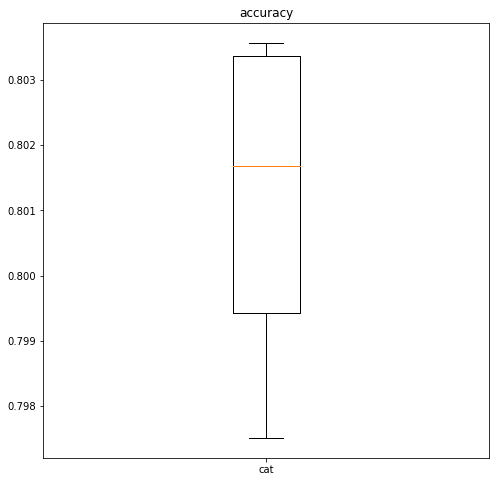

In [281]:
#prueba
models = []
models.append(('cat', best_model))
model_evaluation(models, y = y_prueba)

Este modelo es muy competitivo. Lo subí a la plataforma del concurso y obtuve 0.8210. Hasta el momento, el mejor

# BaggingClassifier

In [370]:
from sklearn.ensemble import BaggingClassifier

best_bagging_model = BaggingClassifier(random_state = 42, n_estimators = 1000, max_features = 0.4)
best_bagging_model.fit(X, y_prueba)

BaggingClassifier(max_features=0.4, n_estimators=1000, random_state=42)

In [371]:
# Realizar predicciones con el modelo ajustado en los datos de prueba
y_pred = best_model.predict(X)

precision = accuracy_score(y_prueba, y_pred)
print(precision)

0.0


bag: 0.8008754208754209


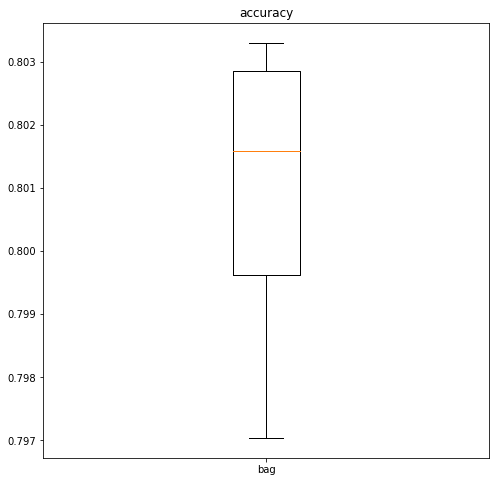

In [275]:
# prueba
models = []
models.append(('bag', best_bagging_model))
model_evaluation(models)

## MLP Classifier

In [306]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Especificar que la variable objetivo es categórica multiclase
mlp.out_activation_ = 'softmax'

mlp.fit(X, y_prueba)

# Hacer predicciones en el conjunto de prueba
y_pred = mlp.predict(X)

# Calcular la exactitud del modelo
accuracy = accuracy_score(y_prueba, y_pred)
print("Exactitud del modelo: {:.2f}".format(accuracy))

Exactitud del modelo: 0.53


mlp: 0.4505892255892256


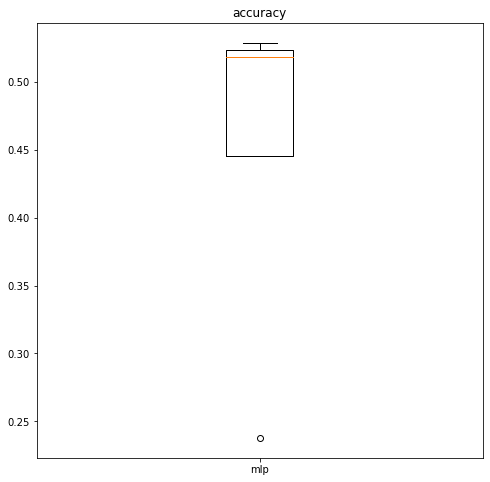

In [307]:
#prueba
models = []
models.append(('mlp', mlp))
model_evaluation(models)

El modelo MLPClassifier es muy muy pobre para este problema así que no lo tendremos en cuenta a partir de ahora.

# Tuneo de DecisionTreeClassifier:

In [342]:
from sklearn.model_selection import GridSearchCV

# Crear una instancia del modelo DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# Definir los hiperparámetros y sus posibles valores para ajustar
param_grid = {'max_depth': [None, 5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Crear una instancia de GridSearchCV con el modelo y los hiperparámetros a ajustar
grid_search = GridSearchCV(dtc, param_grid = param_grid, cv = 5, scoring = 'accuracy')

# Ajustar el modelo usando GridSearchCV
grid_search.fit(X, y)

#Sacamos los mejores parámetros
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

# Crear una nueva instancia del modelo DecisionTreeClassifier con los mejores hiperparámetros
best_dtc = DecisionTreeClassifier(**best_params)

In [285]:
print(best_params)
print(best_model)
print(best_score)

{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 5}
DecisionTreeClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=5)
0.7705387205387205


DTC: 0.765993265993266


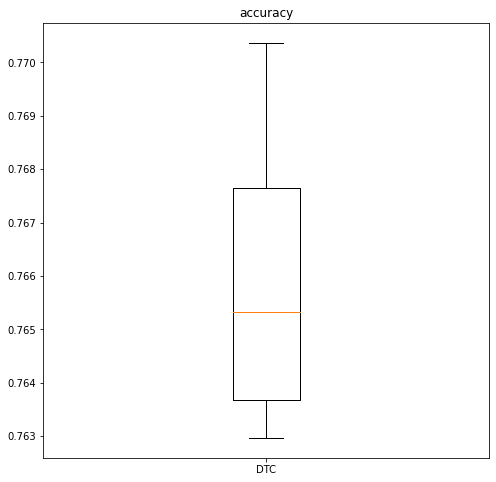

In [286]:
#prueba
models = []
models.append(('DTC', best_dtc))
model_evaluation(models)

# Tuneo del random Forest

In [287]:
from sklearn.model_selection import GridSearchCV  # Para búsqueda de hiperparámetros
rf_model = RandomForestClassifier(random_state = 42)  # O RandomForestRegressor para regresión
parametros = {
    'n_estimators': [10, 50, 100], #[300,600,900] Número de árboles en el bosque
    'max_depth': [None, 10, 20], # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10], # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4], # Número mínimo de muestras requeridas en un nodo hoja
    'max_features': ['auto', 'sqrt', 'log2'], # Número de características a considerar en cada división
    # Otros hiperparámetros del modelo de Random Forest
}

#Creamos el grid
grid_search = GridSearchCV(estimator = rf_model, param_grid = parametros, cv = 5, scoring = 'accuracy')  # 5-fold cross-validation
grid_search.fit(X, y)

#Sacamos los mejores parámetros
mejores_parametros = grid_search.best_params_
modelo_ajustado = grid_search.best_estimator_
best_score = grid_search.best_score_

In [288]:
#Sacamos los mejores parámetros
print(mejores_parametros)
print(modelo_ajustado)
print(best_score)

{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)
0.8151683501683502


Apuramos un poco más

In [290]:
from sklearn.model_selection import GridSearchCV  # Para búsqueda de hiperparámetros
rf_model = RandomForestClassifier(random_state = 42)  # O RandomForestRegressor para regresión
parametros = {
    'n_estimators': [600,1000], #Número de árboles en el bosque
    'max_depth': [20,23], # Profundidad máxima de los árboles
    'min_samples_split': [5], # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [2], # Número mínimo de muestras requeridas en un nodo hoja
    'max_features': ['auto'], # Número de características a considerar en cada división
    # Otros hiperparámetros del modelo de Random Forest
}

#Creamos el grid
grid_search = GridSearchCV(estimator = rf_model, param_grid = parametros, cv = 5, scoring = 'accuracy')  # 5-fold cross-validation
grid_search.fit(X, y)

#Sacamos los mejores parámetros
mejores_parametros = grid_search.best_params_
modelo_ajustado = grid_search.best_estimator_
best_score = grid_search.best_score_

In [291]:
#Sacamos los mejores parámetros
print(mejores_parametros)
print(modelo_ajustado)
print(best_score)

{'max_depth': 23, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000}
RandomForestClassifier(max_depth=23, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1000, random_state=42)
0.8168855218855219


RF_tuneado: 0.8118855218855219


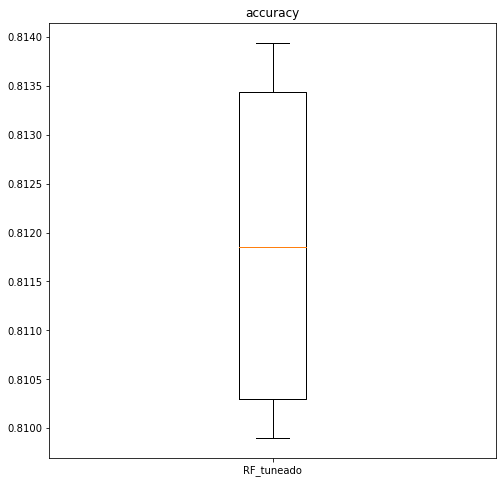

In [308]:
#prueba
models = []
models.append(('RF_tuneado', modelo_ajustado))
model_evaluation(models)

In [343]:
best_rf_model = RandomForestClassifier(max_depth = 23, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 150,
                       random_state = 42)
best_rf_model.fit(X, y)

RandomForestClassifier(max_depth=23, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150, random_state=42)

In [344]:
#Lanzamos el modelo para los datos test para ver la puntuación
y_pred = best_rf_model.predict(test)
prediccion_RF_tuneado = pd.concat([test_id, pd.DataFrame(y_pred, columns = ['status_group'])], axis = 1)
# Exportar el DataFrame a un archivo CSV
prediccion_RF_tuneado.to_csv('prediccion_RF_tuneado.csv', index = False)

Muy probablemente este es un de los mejores modelos que podamos conseguir, así que se sube el archivo 'prediccion_RF_tuneado.csv' a la plataforma para obtener una puntuación:

### Puntuación 'prediccion_RF_tuneado.csv': 0.8211

Se ve claramente que es un modelo competitivo. No obstante, a continuación se van a realizar una serie de pruebas con modelos de ensamblado, que suelen ser muy competitivos.

Se comprueba la importancia de las variables:

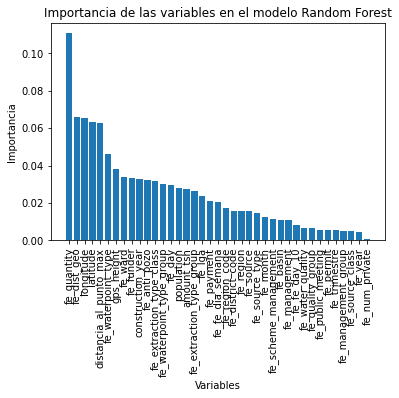

In [345]:
# Obtener la importancia de las variables
importances = best_rf_model.feature_importances_

# Obtener los nombres de las variables
nombres_variables = X.columns

# Crear una figura y un eje
fig, ax = plt.subplots()

# Ordenar las importancias de las variables en forma descendente
indices = importances.argsort()[::-1]

# Graficar las barras de la importancia de las variables
ax.bar(range(len(importances)), importances[indices])

# Establecer los nombres de las variables en el eje x
ax.set_xticks(range(len(importances)))
ax.set_xticklabels(nombres_variables[indices], rotation = 90)

# Establecer el título y etiquetas de los ejes
ax.set_title('Importancia de las variables en el modelo Random Forest')
ax.set_xlabel('Variables')
ax.set_ylabel('Importancia')

# Mostrar la figura
plt.show()

La mayoría de variables que se han generado tienen bastante importancia, especialmente las relacionadas con la distancia 'fe_distance_geo' y 'distancia_al_punto_max'. La variable 'fe_anti_pozo' también es interesante para este modelo.

# Ensamblado

## VotingClassifier

0:	learn: 0.9634382	total: 38.4ms	remaining: 11.5s
1:	learn: 0.8796850	total: 77.4ms	remaining: 11.5s
2:	learn: 0.8202458	total: 116ms	remaining: 11.5s
3:	learn: 0.7772188	total: 155ms	remaining: 11.5s
4:	learn: 0.7440815	total: 198ms	remaining: 11.7s
5:	learn: 0.7188547	total: 247ms	remaining: 12.1s
6:	learn: 0.7005307	total: 297ms	remaining: 12.4s
7:	learn: 0.6851296	total: 342ms	remaining: 12.5s
8:	learn: 0.6709112	total: 381ms	remaining: 12.3s
9:	learn: 0.6584712	total: 417ms	remaining: 12.1s
10:	learn: 0.6499652	total: 453ms	remaining: 11.9s
11:	learn: 0.6414573	total: 494ms	remaining: 11.8s
12:	learn: 0.6331137	total: 533ms	remaining: 11.8s
13:	learn: 0.6271087	total: 569ms	remaining: 11.6s
14:	learn: 0.6215273	total: 604ms	remaining: 11.5s
15:	learn: 0.6168707	total: 642ms	remaining: 11.4s
16:	learn: 0.6131251	total: 683ms	remaining: 11.4s
17:	learn: 0.6072888	total: 722ms	remaining: 11.3s
18:	learn: 0.6015121	total: 761ms	remaining: 11.3s
19:	learn: 0.5976555	total: 799ms	remai

162:	learn: 0.4303709	total: 6.36s	remaining: 5.35s
163:	learn: 0.4300177	total: 6.4s	remaining: 5.31s
164:	learn: 0.4293647	total: 6.44s	remaining: 5.27s
165:	learn: 0.4287410	total: 6.47s	remaining: 5.22s
166:	learn: 0.4283571	total: 6.51s	remaining: 5.18s
167:	learn: 0.4276588	total: 6.54s	remaining: 5.14s
168:	learn: 0.4271634	total: 6.58s	remaining: 5.1s
169:	learn: 0.4268813	total: 6.61s	remaining: 5.05s
170:	learn: 0.4265145	total: 6.64s	remaining: 5.01s
171:	learn: 0.4261061	total: 6.68s	remaining: 4.97s
172:	learn: 0.4257133	total: 6.71s	remaining: 4.93s
173:	learn: 0.4252619	total: 6.75s	remaining: 4.89s
174:	learn: 0.4245791	total: 6.79s	remaining: 4.85s
175:	learn: 0.4235400	total: 6.83s	remaining: 4.81s
176:	learn: 0.4231668	total: 6.87s	remaining: 4.77s
177:	learn: 0.4228249	total: 6.9s	remaining: 4.73s
178:	learn: 0.4224058	total: 6.94s	remaining: 4.69s
179:	learn: 0.4220826	total: 6.97s	remaining: 4.65s
180:	learn: 0.4217986	total: 7.01s	remaining: 4.61s
181:	learn: 0.4

25:	learn: 0.5862777	total: 977ms	remaining: 10.3s
26:	learn: 0.5842159	total: 1.01s	remaining: 10.2s
27:	learn: 0.5798860	total: 1.05s	remaining: 10.2s
28:	learn: 0.5778284	total: 1.08s	remaining: 10.1s
29:	learn: 0.5760863	total: 1.12s	remaining: 10.1s
30:	learn: 0.5746141	total: 1.15s	remaining: 10s
31:	learn: 0.5714947	total: 1.19s	remaining: 9.98s
32:	learn: 0.5683295	total: 1.23s	remaining: 9.97s
33:	learn: 0.5657768	total: 1.27s	remaining: 9.91s
34:	learn: 0.5639229	total: 1.3s	remaining: 9.85s
35:	learn: 0.5618435	total: 1.34s	remaining: 9.8s
36:	learn: 0.5600826	total: 1.37s	remaining: 9.76s
37:	learn: 0.5566023	total: 1.41s	remaining: 9.73s
38:	learn: 0.5551374	total: 1.45s	remaining: 9.71s
39:	learn: 0.5539515	total: 1.49s	remaining: 9.67s
40:	learn: 0.5524312	total: 1.52s	remaining: 9.63s
41:	learn: 0.5510363	total: 1.56s	remaining: 9.6s
42:	learn: 0.5489988	total: 1.6s	remaining: 9.55s
43:	learn: 0.5462417	total: 1.63s	remaining: 9.51s
44:	learn: 0.5454903	total: 1.68s	rem

189:	learn: 0.4247055	total: 7.12s	remaining: 4.12s
190:	learn: 0.4242976	total: 7.16s	remaining: 4.08s
191:	learn: 0.4236201	total: 7.19s	remaining: 4.04s
192:	learn: 0.4230478	total: 7.22s	remaining: 4s
193:	learn: 0.4227372	total: 7.26s	remaining: 3.97s
194:	learn: 0.4222609	total: 7.29s	remaining: 3.93s
195:	learn: 0.4212610	total: 7.33s	remaining: 3.89s
196:	learn: 0.4207044	total: 7.37s	remaining: 3.85s
197:	learn: 0.4200740	total: 7.4s	remaining: 3.81s
198:	learn: 0.4197321	total: 7.43s	remaining: 3.77s
199:	learn: 0.4193299	total: 7.47s	remaining: 3.74s
200:	learn: 0.4189562	total: 7.51s	remaining: 3.7s
201:	learn: 0.4186366	total: 7.54s	remaining: 3.66s
202:	learn: 0.4182964	total: 7.57s	remaining: 3.62s
203:	learn: 0.4177749	total: 7.61s	remaining: 3.58s
204:	learn: 0.4173180	total: 7.64s	remaining: 3.54s
205:	learn: 0.4169457	total: 7.67s	remaining: 3.5s
206:	learn: 0.4165499	total: 7.71s	remaining: 3.46s
207:	learn: 0.4159020	total: 7.75s	remaining: 3.42s
208:	learn: 0.4155

52:	learn: 0.5215578	total: 1.83s	remaining: 8.53s
53:	learn: 0.5199064	total: 1.86s	remaining: 8.5s
54:	learn: 0.5189839	total: 1.9s	remaining: 8.47s
55:	learn: 0.5175786	total: 1.93s	remaining: 8.43s
56:	learn: 0.5163192	total: 1.97s	remaining: 8.4s
57:	learn: 0.5152581	total: 2s	remaining: 8.36s
58:	learn: 0.5146559	total: 2.04s	remaining: 8.33s
59:	learn: 0.5131849	total: 2.07s	remaining: 8.3s
60:	learn: 0.5123274	total: 2.11s	remaining: 8.26s
61:	learn: 0.5107614	total: 2.15s	remaining: 8.23s
62:	learn: 0.5099285	total: 2.18s	remaining: 8.21s
63:	learn: 0.5083220	total: 2.22s	remaining: 8.18s
64:	learn: 0.5078841	total: 2.25s	remaining: 8.14s
65:	learn: 0.5069667	total: 2.28s	remaining: 8.1s
66:	learn: 0.5063155	total: 2.32s	remaining: 8.07s
67:	learn: 0.5051635	total: 2.35s	remaining: 8.03s
68:	learn: 0.5039515	total: 2.39s	remaining: 8s
69:	learn: 0.5026897	total: 2.42s	remaining: 7.96s
70:	learn: 0.5018924	total: 2.45s	remaining: 7.92s
71:	learn: 0.5007568	total: 2.49s	remainin

214:	learn: 0.4064863	total: 7.61s	remaining: 3.01s
215:	learn: 0.4060536	total: 7.65s	remaining: 2.97s
216:	learn: 0.4054747	total: 7.68s	remaining: 2.94s
217:	learn: 0.4050664	total: 7.72s	remaining: 2.9s
218:	learn: 0.4046099	total: 7.76s	remaining: 2.87s
219:	learn: 0.4040849	total: 7.8s	remaining: 2.83s
220:	learn: 0.4035406	total: 7.83s	remaining: 2.8s
221:	learn: 0.4032334	total: 7.87s	remaining: 2.77s
222:	learn: 0.4027946	total: 7.91s	remaining: 2.73s
223:	learn: 0.4024587	total: 7.95s	remaining: 2.7s
224:	learn: 0.4020142	total: 7.99s	remaining: 2.66s
225:	learn: 0.4015992	total: 8.03s	remaining: 2.63s
226:	learn: 0.4011428	total: 8.06s	remaining: 2.59s
227:	learn: 0.4007859	total: 8.1s	remaining: 2.56s
228:	learn: 0.4002498	total: 8.14s	remaining: 2.52s
229:	learn: 0.3999211	total: 8.18s	remaining: 2.49s
230:	learn: 0.3995970	total: 8.22s	remaining: 2.46s
231:	learn: 0.3991593	total: 8.26s	remaining: 2.42s
232:	learn: 0.3986071	total: 8.3s	remaining: 2.39s
233:	learn: 0.3981

79:	learn: 0.4996027	total: 2.96s	remaining: 8.14s
80:	learn: 0.4984905	total: 2.99s	remaining: 8.1s
81:	learn: 0.4974418	total: 3.03s	remaining: 8.07s
82:	learn: 0.4970681	total: 3.08s	remaining: 8.06s
83:	learn: 0.4958084	total: 3.13s	remaining: 8.04s
84:	learn: 0.4943219	total: 3.16s	remaining: 8s
85:	learn: 0.4933226	total: 3.2s	remaining: 7.97s
86:	learn: 0.4926424	total: 3.24s	remaining: 7.93s
87:	learn: 0.4914967	total: 3.28s	remaining: 7.9s
88:	learn: 0.4905287	total: 3.32s	remaining: 7.87s
89:	learn: 0.4894137	total: 3.35s	remaining: 7.83s
90:	learn: 0.4877177	total: 3.39s	remaining: 7.78s
91:	learn: 0.4868401	total: 3.42s	remaining: 7.74s
92:	learn: 0.4858636	total: 3.46s	remaining: 7.7s
93:	learn: 0.4847126	total: 3.49s	remaining: 7.66s
94:	learn: 0.4836376	total: 3.53s	remaining: 7.62s
95:	learn: 0.4829725	total: 3.56s	remaining: 7.58s
96:	learn: 0.4819664	total: 3.6s	remaining: 7.53s
97:	learn: 0.4810806	total: 3.63s	remaining: 7.49s
98:	learn: 0.4802036	total: 3.67s	remai

243:	learn: 0.4007981	total: 8.8s	remaining: 2.02s
244:	learn: 0.4006243	total: 8.84s	remaining: 1.98s
245:	learn: 0.4004518	total: 8.88s	remaining: 1.95s
246:	learn: 0.3999738	total: 8.91s	remaining: 1.91s
247:	learn: 0.3992245	total: 8.95s	remaining: 1.88s
248:	learn: 0.3988488	total: 8.98s	remaining: 1.84s
249:	learn: 0.3983025	total: 9.02s	remaining: 1.8s
250:	learn: 0.3978626	total: 9.05s	remaining: 1.77s
251:	learn: 0.3977356	total: 9.09s	remaining: 1.73s
252:	learn: 0.3975025	total: 9.12s	remaining: 1.69s
253:	learn: 0.3969805	total: 9.15s	remaining: 1.66s
254:	learn: 0.3966460	total: 9.19s	remaining: 1.62s
255:	learn: 0.3964872	total: 9.22s	remaining: 1.58s
256:	learn: 0.3960515	total: 9.26s	remaining: 1.55s
257:	learn: 0.3957861	total: 9.29s	remaining: 1.51s
258:	learn: 0.3954638	total: 9.32s	remaining: 1.48s
259:	learn: 0.3950880	total: 9.36s	remaining: 1.44s
260:	learn: 0.3949566	total: 9.39s	remaining: 1.4s
261:	learn: 0.3947526	total: 9.43s	remaining: 1.37s
262:	learn: 0.3

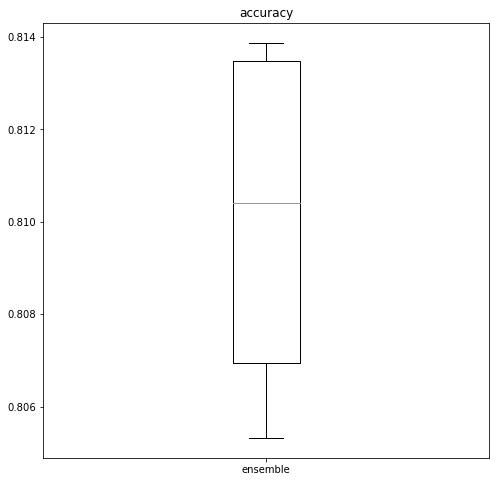

In [346]:
#Quiero probar un ensamblado
from sklearn.ensemble import VotingClassifier

# Las instancias de los modelos ya están creadas
#best_logreg_model = LogisticRegression(multi_class = 'multinomial', C = 0.001, penalty = 'none', solver = 'lbfgs')
#best_dtc_model = DecisionTreeClassifier(min_samples_leaf = 4, min_samples_split = 10)
best_cat_model = CatBoostClassifier(depth= 8, learning_rate= 0.2, n_estimators= 300,random_state=42)
#best_bagging_model = BaggingClassifier(random_state = 42, n_estimators = 1000, max_features = 0.4)
#svm = SVC()
#gbc = GradientBoostingClassifier('meter parametros nuevos')
    
# Crear el ensamblado (voting classifier)
ensemble_model = VotingClassifier(
    estimators = [('logreg', best_logreg_model), ('dtc', best_dtc), ('rf', best_rf_model), ('bag', best_bagging_model), 
                 ('cat', best_cat_model), ('xgboost', modelo_xgb)],
    voting = 'soft' # Puedes cambiar el tipo de votación ('hard' o 'soft')
)

models = []
models.append(('ensemble', ensemble_model))
model_evaluation(models, y = y_prueba)


In [375]:
ensemble_model = VotingClassifier(
    estimators = [('logreg', best_logreg_model), ('dtc', best_dtc), ('rf', best_rf_model), ('bag', best_bagging_model), 
                 ('cat', best_cat_model), ('xgboost', modelo_xgb)],
    voting = 'soft' # Puedes cambiar el tipo de votación ('hard' o 'soft')
)

ensemble_model.fit(X, y_prueba)

y_pred = best_model.predict(X)

#Para volver a los nombres en vez de a los números:
# Crear un diccionario invertido del mapeo de valores
#mapeo_invertido = {0: 'functional', 1: 'functional needs repair', 2: 'non functional'}

# Aplicar el mapeo invertido a la columna 'columna_deseada' en el DataFrame 'y'
#y_pred = pd.Series(y_pred).map(mapeo_invertido)

precision = accuracy_score(y_prueba, y_pred)
print('Precisión: ', precision)

0:	learn: 0.9632165	total: 40.3ms	remaining: 12s
1:	learn: 0.8788088	total: 80.1ms	remaining: 11.9s
2:	learn: 0.8197406	total: 120ms	remaining: 11.9s
3:	learn: 0.7766620	total: 160ms	remaining: 11.9s
4:	learn: 0.7463786	total: 202ms	remaining: 11.9s
5:	learn: 0.7205201	total: 242ms	remaining: 11.9s
6:	learn: 0.7011986	total: 289ms	remaining: 12.1s
7:	learn: 0.6838014	total: 331ms	remaining: 12.1s
8:	learn: 0.6712621	total: 370ms	remaining: 12s
9:	learn: 0.6576736	total: 408ms	remaining: 11.8s
10:	learn: 0.6490267	total: 446ms	remaining: 11.7s
11:	learn: 0.6382827	total: 484ms	remaining: 11.6s
12:	learn: 0.6332473	total: 523ms	remaining: 11.5s
13:	learn: 0.6270404	total: 559ms	remaining: 11.4s
14:	learn: 0.6211239	total: 596ms	remaining: 11.3s
15:	learn: 0.6156490	total: 633ms	remaining: 11.2s
16:	learn: 0.6114978	total: 668ms	remaining: 11.1s
17:	learn: 0.6066535	total: 706ms	remaining: 11.1s
18:	learn: 0.6023613	total: 746ms	remaining: 11s
19:	learn: 0.5966283	total: 782ms	remaining: 

161:	learn: 0.4410922	total: 6.22s	remaining: 5.3s
162:	learn: 0.4404437	total: 6.26s	remaining: 5.26s
163:	learn: 0.4399582	total: 6.3s	remaining: 5.23s
164:	learn: 0.4394672	total: 6.34s	remaining: 5.19s
165:	learn: 0.4391480	total: 6.38s	remaining: 5.15s
166:	learn: 0.4387819	total: 6.42s	remaining: 5.11s
167:	learn: 0.4383652	total: 6.46s	remaining: 5.07s
168:	learn: 0.4379197	total: 6.49s	remaining: 5.03s
169:	learn: 0.4374576	total: 6.53s	remaining: 5s
170:	learn: 0.4371383	total: 6.57s	remaining: 4.96s
171:	learn: 0.4365677	total: 6.61s	remaining: 4.92s
172:	learn: 0.4361464	total: 6.64s	remaining: 4.88s
173:	learn: 0.4357977	total: 6.68s	remaining: 4.84s
174:	learn: 0.4355290	total: 6.72s	remaining: 4.8s
175:	learn: 0.4349379	total: 6.76s	remaining: 4.76s
176:	learn: 0.4346803	total: 6.8s	remaining: 4.73s
177:	learn: 0.4343233	total: 6.84s	remaining: 4.69s
178:	learn: 0.4338006	total: 6.88s	remaining: 4.65s
179:	learn: 0.4334124	total: 6.92s	remaining: 4.61s
180:	learn: 0.43315

In [ ]:
#Lanzamos el modelo para los datos test para ver la puntuación
y_pred = ensemble_model.predict(test)

#Para volver a los nombres en vez de a los números:
# Crear un diccionario invertido del mapeo de valores
mapeo_invertido = {0: 'functional', 1: 'functional needs repair', 2: 'non functional'}

# Aplicar el mapeo invertido a la columna 'columna_deseada' en el DataFrame 'y'
y_pred = pd.Series(y_pred).map(mapeo_invertido)

prediccion_ensemble = pd.concat([test_id, pd.DataFrame(y_pred, columns = ['status_group'])], axis = 1)
# Exportar el DataFrame a un archivo CSV
prediccion_ensemble.to_csv('prediccion_ensemble.csv', index = False)


Este primer ensamblado es muy comptetitivo pero no mejora al mejor Random Forest. Pasamos al siguiente tipo de ensamblado.

# Ensamblado stack

In [353]:
from sklearn.ensemble import StackingClassifier

#best_logreg_model = LogisticRegression(multi_class = 'multinomial', C = 0.001, penalty = 'none', solver = 'lbfgs')
#best_dtc_model = DecisionTreeClassifier(min_samples_leaf = 4, min_samples_split = 10)
#best_rf_model = RandomForestClassifier(n_estimators = 200, max_depth = 30, min_samples_split = 10, min_samples_leaf = 2, 
#                                      max_features = 'auto', bootstrap = False, random_state = 42)
#best_cat_model = CatBoostClassifier(random_state = 42, rsm = 0.2, max_depth = 9, iterations = 1000)
#best_bagging_model = BaggingClassifier(random_state = 42, n_estimators = 1000, max_features = 0.4)
stack = StackingClassifier([  ('logreg', best_logreg_model), 
                              ('dtc', best_dtc), 
                              ('rf', best_rf_model), 
                              ('bag', best_bagging_model), 
                              ('cat', best_cat_model), 
                              ('xgboost', modelo_xgb)], final_estimator = LogisticRegression())

#fit and predict
stack.fit(X , y_prueba)
pred = stack.predict(X)
pred_train = stack.predict(X)

#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_prueba, pred_train)))
#print("Accuracy score test: {}".format(accuracy_score(y_test, pred)))

0:	learn: 0.9632165	total: 44.5ms	remaining: 13.3s
1:	learn: 0.8788088	total: 89.4ms	remaining: 13.3s
2:	learn: 0.8197406	total: 131ms	remaining: 13s
3:	learn: 0.7766620	total: 172ms	remaining: 12.7s
4:	learn: 0.7463786	total: 213ms	remaining: 12.6s
5:	learn: 0.7205201	total: 254ms	remaining: 12.4s
6:	learn: 0.7011986	total: 296ms	remaining: 12.4s
7:	learn: 0.6838014	total: 336ms	remaining: 12.3s
8:	learn: 0.6712621	total: 375ms	remaining: 12.1s
9:	learn: 0.6576736	total: 415ms	remaining: 12s
10:	learn: 0.6490267	total: 455ms	remaining: 12s
11:	learn: 0.6382827	total: 497ms	remaining: 11.9s
12:	learn: 0.6332473	total: 537ms	remaining: 11.9s
13:	learn: 0.6270404	total: 580ms	remaining: 11.8s
14:	learn: 0.6211239	total: 620ms	remaining: 11.8s
15:	learn: 0.6156490	total: 658ms	remaining: 11.7s
16:	learn: 0.6114978	total: 698ms	remaining: 11.6s
17:	learn: 0.6066535	total: 742ms	remaining: 11.6s
18:	learn: 0.6023613	total: 784ms	remaining: 11.6s
19:	learn: 0.5966283	total: 828ms	remaining: 

161:	learn: 0.4410922	total: 6.51s	remaining: 5.55s
162:	learn: 0.4404437	total: 6.55s	remaining: 5.51s
163:	learn: 0.4399582	total: 6.59s	remaining: 5.47s
164:	learn: 0.4394672	total: 6.63s	remaining: 5.42s
165:	learn: 0.4391480	total: 6.67s	remaining: 5.38s
166:	learn: 0.4387819	total: 6.71s	remaining: 5.34s
167:	learn: 0.4383652	total: 6.75s	remaining: 5.3s
168:	learn: 0.4379197	total: 6.79s	remaining: 5.26s
169:	learn: 0.4374576	total: 6.83s	remaining: 5.22s
170:	learn: 0.4371383	total: 6.87s	remaining: 5.18s
171:	learn: 0.4365677	total: 6.91s	remaining: 5.14s
172:	learn: 0.4361464	total: 6.95s	remaining: 5.1s
173:	learn: 0.4357977	total: 6.99s	remaining: 5.06s
174:	learn: 0.4355290	total: 7.03s	remaining: 5.02s
175:	learn: 0.4349379	total: 7.07s	remaining: 4.98s
176:	learn: 0.4346803	total: 7.11s	remaining: 4.94s
177:	learn: 0.4343233	total: 7.15s	remaining: 4.9s
178:	learn: 0.4338006	total: 7.19s	remaining: 4.86s
179:	learn: 0.4334124	total: 7.23s	remaining: 4.82s
180:	learn: 0.4

25:	learn: 0.5803845	total: 917ms	remaining: 9.67s
26:	learn: 0.5788046	total: 951ms	remaining: 9.62s
27:	learn: 0.5758776	total: 984ms	remaining: 9.56s
28:	learn: 0.5737061	total: 1.02s	remaining: 9.5s
29:	learn: 0.5699443	total: 1.05s	remaining: 9.44s
30:	learn: 0.5677693	total: 1.08s	remaining: 9.39s
31:	learn: 0.5643765	total: 1.12s	remaining: 9.37s
32:	learn: 0.5630679	total: 1.16s	remaining: 9.36s
33:	learn: 0.5615608	total: 1.2s	remaining: 9.41s
34:	learn: 0.5591801	total: 1.24s	remaining: 9.38s
35:	learn: 0.5571801	total: 1.27s	remaining: 9.35s
36:	learn: 0.5546006	total: 1.31s	remaining: 9.32s
37:	learn: 0.5530847	total: 1.34s	remaining: 9.28s
38:	learn: 0.5518183	total: 1.38s	remaining: 9.23s
39:	learn: 0.5497539	total: 1.44s	remaining: 9.33s
40:	learn: 0.5473615	total: 1.48s	remaining: 9.36s
41:	learn: 0.5459398	total: 1.52s	remaining: 9.35s
42:	learn: 0.5430730	total: 1.56s	remaining: 9.33s
43:	learn: 0.5413060	total: 1.6s	remaining: 9.29s
44:	learn: 0.5400500	total: 1.63s	

188:	learn: 0.4211975	total: 6.85s	remaining: 4.02s
189:	learn: 0.4204689	total: 6.89s	remaining: 3.99s
190:	learn: 0.4200026	total: 6.92s	remaining: 3.95s
191:	learn: 0.4196756	total: 6.95s	remaining: 3.91s
192:	learn: 0.4193801	total: 6.99s	remaining: 3.87s
193:	learn: 0.4190062	total: 7.02s	remaining: 3.83s
194:	learn: 0.4186008	total: 7.05s	remaining: 3.8s
195:	learn: 0.4183020	total: 7.09s	remaining: 3.76s
196:	learn: 0.4179724	total: 7.12s	remaining: 3.72s
197:	learn: 0.4175020	total: 7.15s	remaining: 3.68s
198:	learn: 0.4171912	total: 7.19s	remaining: 3.65s
199:	learn: 0.4168084	total: 7.22s	remaining: 3.61s
200:	learn: 0.4160912	total: 7.25s	remaining: 3.57s
201:	learn: 0.4158190	total: 7.29s	remaining: 3.54s
202:	learn: 0.4155088	total: 7.32s	remaining: 3.5s
203:	learn: 0.4150048	total: 7.36s	remaining: 3.46s
204:	learn: 0.4147659	total: 7.39s	remaining: 3.42s
205:	learn: 0.4141769	total: 7.42s	remaining: 3.38s
206:	learn: 0.4137614	total: 7.45s	remaining: 3.35s
207:	learn: 0.

50:	learn: 0.5352226	total: 1.78s	remaining: 8.7s
51:	learn: 0.5333255	total: 1.81s	remaining: 8.65s
52:	learn: 0.5320005	total: 1.85s	remaining: 8.61s
53:	learn: 0.5301456	total: 1.88s	remaining: 8.57s
54:	learn: 0.5290950	total: 1.91s	remaining: 8.53s
55:	learn: 0.5277470	total: 1.95s	remaining: 8.49s
56:	learn: 0.5265357	total: 1.98s	remaining: 8.45s
57:	learn: 0.5248716	total: 2.02s	remaining: 8.41s
58:	learn: 0.5236094	total: 2.05s	remaining: 8.38s
59:	learn: 0.5230382	total: 2.08s	remaining: 8.34s
60:	learn: 0.5218060	total: 2.12s	remaining: 8.3s
61:	learn: 0.5204223	total: 2.15s	remaining: 8.27s
62:	learn: 0.5185353	total: 2.19s	remaining: 8.24s
63:	learn: 0.5173754	total: 2.23s	remaining: 8.21s
64:	learn: 0.5164054	total: 2.27s	remaining: 8.19s
65:	learn: 0.5143827	total: 2.3s	remaining: 8.17s
66:	learn: 0.5122096	total: 2.34s	remaining: 8.13s
67:	learn: 0.5107274	total: 2.37s	remaining: 8.09s
68:	learn: 0.5101574	total: 2.4s	remaining: 8.05s
69:	learn: 0.5092414	total: 2.44s	r

212:	learn: 0.4147816	total: 7.38s	remaining: 3.01s
213:	learn: 0.4145188	total: 7.41s	remaining: 2.98s
214:	learn: 0.4140684	total: 7.44s	remaining: 2.94s
215:	learn: 0.4135843	total: 7.47s	remaining: 2.91s
216:	learn: 0.4132077	total: 7.51s	remaining: 2.87s
217:	learn: 0.4128843	total: 7.54s	remaining: 2.84s
218:	learn: 0.4126231	total: 7.57s	remaining: 2.8s
219:	learn: 0.4122762	total: 7.61s	remaining: 2.77s
220:	learn: 0.4119864	total: 7.64s	remaining: 2.73s
221:	learn: 0.4116399	total: 7.67s	remaining: 2.7s
222:	learn: 0.4113859	total: 7.71s	remaining: 2.66s
223:	learn: 0.4111697	total: 7.74s	remaining: 2.63s
224:	learn: 0.4106723	total: 7.77s	remaining: 2.59s
225:	learn: 0.4103008	total: 7.81s	remaining: 2.56s
226:	learn: 0.4100127	total: 7.84s	remaining: 2.52s
227:	learn: 0.4094447	total: 7.87s	remaining: 2.48s
228:	learn: 0.4091400	total: 7.91s	remaining: 2.45s
229:	learn: 0.4083791	total: 7.94s	remaining: 2.42s
230:	learn: 0.4079969	total: 7.98s	remaining: 2.38s
231:	learn: 0.

75:	learn: 0.5037301	total: 2.66s	remaining: 7.83s
76:	learn: 0.5030566	total: 2.69s	remaining: 7.79s
77:	learn: 0.5013247	total: 2.72s	remaining: 7.75s
78:	learn: 0.5004733	total: 2.76s	remaining: 7.71s
79:	learn: 0.4993591	total: 2.79s	remaining: 7.68s
80:	learn: 0.4985542	total: 2.83s	remaining: 7.64s
81:	learn: 0.4970835	total: 2.86s	remaining: 7.61s
82:	learn: 0.4961576	total: 2.9s	remaining: 7.58s
83:	learn: 0.4946618	total: 2.94s	remaining: 7.55s
84:	learn: 0.4941490	total: 2.97s	remaining: 7.52s
85:	learn: 0.4935204	total: 3.01s	remaining: 7.49s
86:	learn: 0.4924019	total: 3.05s	remaining: 7.46s
87:	learn: 0.4912129	total: 3.08s	remaining: 7.42s
88:	learn: 0.4907718	total: 3.12s	remaining: 7.39s
89:	learn: 0.4899504	total: 3.15s	remaining: 7.35s
90:	learn: 0.4892569	total: 3.18s	remaining: 7.3s
91:	learn: 0.4885822	total: 3.21s	remaining: 7.27s
92:	learn: 0.4875134	total: 3.25s	remaining: 7.23s
93:	learn: 0.4864318	total: 3.28s	remaining: 7.19s
94:	learn: 0.4854168	total: 3.31s

239:	learn: 0.4052365	total: 8.45s	remaining: 2.11s
240:	learn: 0.4048912	total: 8.48s	remaining: 2.08s
241:	learn: 0.4045212	total: 8.51s	remaining: 2.04s
242:	learn: 0.4040582	total: 8.55s	remaining: 2s
243:	learn: 0.4038480	total: 8.58s	remaining: 1.97s
244:	learn: 0.4032244	total: 8.62s	remaining: 1.93s
245:	learn: 0.4027146	total: 8.65s	remaining: 1.9s
246:	learn: 0.4022191	total: 8.68s	remaining: 1.86s
247:	learn: 0.4020229	total: 8.72s	remaining: 1.83s
248:	learn: 0.4016796	total: 8.75s	remaining: 1.79s
249:	learn: 0.4012123	total: 8.78s	remaining: 1.76s
250:	learn: 0.4008942	total: 8.81s	remaining: 1.72s
251:	learn: 0.4004298	total: 8.85s	remaining: 1.69s
252:	learn: 0.4001374	total: 8.88s	remaining: 1.65s
253:	learn: 0.3997211	total: 8.92s	remaining: 1.61s
254:	learn: 0.3992949	total: 8.95s	remaining: 1.58s
255:	learn: 0.3988236	total: 8.98s	remaining: 1.54s
256:	learn: 0.3985016	total: 9.01s	remaining: 1.51s
257:	learn: 0.3980034	total: 9.04s	remaining: 1.47s
258:	learn: 0.39

102:	learn: 0.4767815	total: 3.59s	remaining: 6.86s
103:	learn: 0.4758509	total: 3.62s	remaining: 6.82s
104:	learn: 0.4750381	total: 3.65s	remaining: 6.79s
105:	learn: 0.4743714	total: 3.69s	remaining: 6.75s
106:	learn: 0.4735326	total: 3.72s	remaining: 6.71s
107:	learn: 0.4728770	total: 3.76s	remaining: 6.68s
108:	learn: 0.4723837	total: 3.79s	remaining: 6.64s
109:	learn: 0.4717605	total: 3.83s	remaining: 6.61s
110:	learn: 0.4707371	total: 3.86s	remaining: 6.58s
111:	learn: 0.4699945	total: 3.9s	remaining: 6.54s
112:	learn: 0.4691439	total: 3.93s	remaining: 6.51s
113:	learn: 0.4685181	total: 3.97s	remaining: 6.48s
114:	learn: 0.4683357	total: 4s	remaining: 6.44s
115:	learn: 0.4678145	total: 4.04s	remaining: 6.4s
116:	learn: 0.4674832	total: 4.07s	remaining: 6.37s
117:	learn: 0.4668792	total: 4.1s	remaining: 6.33s
118:	learn: 0.4661931	total: 4.14s	remaining: 6.3s
119:	learn: 0.4658576	total: 4.17s	remaining: 6.26s
120:	learn: 0.4653709	total: 4.21s	remaining: 6.23s
121:	learn: 0.46437

266:	learn: 0.3938032	total: 9.35s	remaining: 1.16s
267:	learn: 0.3932099	total: 9.38s	remaining: 1.12s
268:	learn: 0.3927366	total: 9.41s	remaining: 1.08s
269:	learn: 0.3925167	total: 9.45s	remaining: 1.05s
270:	learn: 0.3921261	total: 9.48s	remaining: 1.01s
271:	learn: 0.3917018	total: 9.51s	remaining: 979ms
272:	learn: 0.3914597	total: 9.54s	remaining: 944ms
273:	learn: 0.3913195	total: 9.58s	remaining: 909ms
274:	learn: 0.3911134	total: 9.62s	remaining: 874ms
275:	learn: 0.3906713	total: 9.65s	remaining: 839ms
276:	learn: 0.3900310	total: 9.69s	remaining: 804ms
277:	learn: 0.3895740	total: 9.72s	remaining: 770ms
278:	learn: 0.3893144	total: 9.76s	remaining: 735ms
279:	learn: 0.3891181	total: 9.79s	remaining: 700ms
280:	learn: 0.3885141	total: 9.83s	remaining: 665ms
281:	learn: 0.3880349	total: 9.86s	remaining: 629ms
282:	learn: 0.3876016	total: 9.9s	remaining: 594ms
283:	learn: 0.3874110	total: 9.93s	remaining: 560ms
284:	learn: 0.3870419	total: 9.97s	remaining: 525ms
285:	learn: 0

128:	learn: 0.4568814	total: 4.63s	remaining: 6.13s
129:	learn: 0.4560797	total: 4.67s	remaining: 6.1s
130:	learn: 0.4551356	total: 4.7s	remaining: 6.07s
131:	learn: 0.4542916	total: 4.74s	remaining: 6.03s
132:	learn: 0.4534572	total: 4.77s	remaining: 5.99s
133:	learn: 0.4526237	total: 4.81s	remaining: 5.95s
134:	learn: 0.4515972	total: 4.84s	remaining: 5.92s
135:	learn: 0.4510031	total: 4.88s	remaining: 5.88s
136:	learn: 0.4506137	total: 4.91s	remaining: 5.84s
137:	learn: 0.4501759	total: 4.95s	remaining: 5.8s
138:	learn: 0.4492444	total: 4.98s	remaining: 5.77s
139:	learn: 0.4486681	total: 5.01s	remaining: 5.73s
140:	learn: 0.4482637	total: 5.05s	remaining: 5.69s
141:	learn: 0.4474436	total: 5.08s	remaining: 5.65s
142:	learn: 0.4467706	total: 5.11s	remaining: 5.62s
143:	learn: 0.4460916	total: 5.15s	remaining: 5.58s
144:	learn: 0.4451930	total: 5.18s	remaining: 5.54s
145:	learn: 0.4449119	total: 5.22s	remaining: 5.5s
146:	learn: 0.4446426	total: 5.25s	remaining: 5.46s
147:	learn: 0.44

292:	learn: 0.3818086	total: 10.3s	remaining: 246ms
293:	learn: 0.3814441	total: 10.4s	remaining: 211ms
294:	learn: 0.3811207	total: 10.4s	remaining: 176ms
295:	learn: 0.3808984	total: 10.4s	remaining: 141ms
296:	learn: 0.3806833	total: 10.5s	remaining: 106ms
297:	learn: 0.3804532	total: 10.5s	remaining: 70.4ms
298:	learn: 0.3802598	total: 10.5s	remaining: 35.2ms
299:	learn: 0.3800310	total: 10.6s	remaining: 0us
Accuracy score train: 0.9375925925925926


0:	learn: 0.9634382	total: 38.7ms	remaining: 11.6s
1:	learn: 0.8796850	total: 75.4ms	remaining: 11.2s
2:	learn: 0.8202458	total: 116ms	remaining: 11.5s
3:	learn: 0.7772188	total: 155ms	remaining: 11.5s
4:	learn: 0.7440815	total: 194ms	remaining: 11.5s
5:	learn: 0.7188547	total: 234ms	remaining: 11.5s
6:	learn: 0.7005307	total: 280ms	remaining: 11.7s
7:	learn: 0.6851296	total: 318ms	remaining: 11.6s
8:	learn: 0.6709112	total: 354ms	remaining: 11.4s
9:	learn: 0.6584712	total: 391ms	remaining: 11.3s
10:	learn: 0.6499652	total: 424ms	remaining: 11.1s
11:	learn: 0.6414573	total: 459ms	remaining: 11s
12:	learn: 0.6331137	total: 495ms	remaining: 10.9s
13:	learn: 0.6271087	total: 530ms	remaining: 10.8s
14:	learn: 0.6215273	total: 564ms	remaining: 10.7s
15:	learn: 0.6168707	total: 599ms	remaining: 10.6s
16:	learn: 0.6131251	total: 634ms	remaining: 10.6s
17:	learn: 0.6072888	total: 671ms	remaining: 10.5s
18:	learn: 0.6015121	total: 707ms	remaining: 10.5s
19:	learn: 0.5976555	total: 745ms	remaini

164:	learn: 0.4293647	total: 6.06s	remaining: 4.96s
165:	learn: 0.4287410	total: 6.1s	remaining: 4.92s
166:	learn: 0.4283571	total: 6.13s	remaining: 4.88s
167:	learn: 0.4276588	total: 6.17s	remaining: 4.84s
168:	learn: 0.4271634	total: 6.2s	remaining: 4.81s
169:	learn: 0.4268813	total: 6.24s	remaining: 4.77s
170:	learn: 0.4265145	total: 6.27s	remaining: 4.73s
171:	learn: 0.4261061	total: 6.3s	remaining: 4.69s
172:	learn: 0.4257133	total: 6.34s	remaining: 4.66s
173:	learn: 0.4252619	total: 6.38s	remaining: 4.62s
174:	learn: 0.4245791	total: 6.42s	remaining: 4.58s
175:	learn: 0.4235400	total: 6.46s	remaining: 4.55s
176:	learn: 0.4231668	total: 6.49s	remaining: 4.51s
177:	learn: 0.4228249	total: 6.53s	remaining: 4.47s
178:	learn: 0.4224058	total: 6.57s	remaining: 4.44s
179:	learn: 0.4220826	total: 6.6s	remaining: 4.4s
180:	learn: 0.4217986	total: 6.63s	remaining: 4.36s
181:	learn: 0.4214324	total: 6.67s	remaining: 4.33s
182:	learn: 0.4210289	total: 6.71s	remaining: 4.29s
183:	learn: 0.420

27:	learn: 0.5749762	total: 964ms	remaining: 9.37s
28:	learn: 0.5713931	total: 1s	remaining: 9.35s
29:	learn: 0.5687005	total: 1.03s	remaining: 9.3s
30:	learn: 0.5668091	total: 1.06s	remaining: 9.24s
31:	learn: 0.5639690	total: 1.1s	remaining: 9.19s
32:	learn: 0.5620599	total: 1.13s	remaining: 9.14s
33:	learn: 0.5597335	total: 1.16s	remaining: 9.1s
34:	learn: 0.5585950	total: 1.2s	remaining: 9.05s
35:	learn: 0.5557938	total: 1.23s	remaining: 9.02s
36:	learn: 0.5530078	total: 1.26s	remaining: 8.98s
37:	learn: 0.5511149	total: 1.3s	remaining: 8.95s
38:	learn: 0.5486118	total: 1.33s	remaining: 8.92s
39:	learn: 0.5468328	total: 1.36s	remaining: 8.86s
40:	learn: 0.5452381	total: 1.4s	remaining: 8.82s
41:	learn: 0.5439438	total: 1.43s	remaining: 8.8s
42:	learn: 0.5424846	total: 1.47s	remaining: 8.76s
43:	learn: 0.5398980	total: 1.5s	remaining: 8.72s
44:	learn: 0.5386718	total: 1.53s	remaining: 8.67s
45:	learn: 0.5373892	total: 1.57s	remaining: 8.69s
46:	learn: 0.5360968	total: 1.62s	remainin

193:	learn: 0.4091795	total: 6.53s	remaining: 3.57s
194:	learn: 0.4088657	total: 6.56s	remaining: 3.53s
195:	learn: 0.4082425	total: 6.6s	remaining: 3.5s
196:	learn: 0.4075186	total: 6.63s	remaining: 3.47s
197:	learn: 0.4070910	total: 6.66s	remaining: 3.43s
198:	learn: 0.4064817	total: 6.69s	remaining: 3.4s
199:	learn: 0.4060898	total: 6.73s	remaining: 3.36s
200:	learn: 0.4056392	total: 6.76s	remaining: 3.33s
201:	learn: 0.4051796	total: 6.8s	remaining: 3.3s
202:	learn: 0.4048795	total: 6.83s	remaining: 3.26s
203:	learn: 0.4045145	total: 6.86s	remaining: 3.23s
204:	learn: 0.4041447	total: 6.89s	remaining: 3.19s
205:	learn: 0.4039174	total: 6.92s	remaining: 3.16s
206:	learn: 0.4036468	total: 6.96s	remaining: 3.13s
207:	learn: 0.4034821	total: 6.99s	remaining: 3.09s
208:	learn: 0.4029935	total: 7.02s	remaining: 3.06s
209:	learn: 0.4024409	total: 7.06s	remaining: 3.02s
210:	learn: 0.4017944	total: 7.09s	remaining: 2.99s
211:	learn: 0.4012866	total: 7.12s	remaining: 2.96s
212:	learn: 0.400

53:	learn: 0.5295195	total: 1.84s	remaining: 8.39s
54:	learn: 0.5279677	total: 1.88s	remaining: 8.36s
55:	learn: 0.5264711	total: 1.91s	remaining: 8.32s
56:	learn: 0.5239319	total: 1.94s	remaining: 8.27s
57:	learn: 0.5216462	total: 1.97s	remaining: 8.24s
58:	learn: 0.5200703	total: 2.01s	remaining: 8.2s
59:	learn: 0.5177765	total: 2.04s	remaining: 8.16s
60:	learn: 0.5162056	total: 2.08s	remaining: 8.13s
61:	learn: 0.5151540	total: 2.11s	remaining: 8.1s
62:	learn: 0.5136718	total: 2.14s	remaining: 8.06s
63:	learn: 0.5125839	total: 2.17s	remaining: 8.02s
64:	learn: 0.5115658	total: 2.21s	remaining: 7.99s
65:	learn: 0.5107608	total: 2.24s	remaining: 7.95s
66:	learn: 0.5091071	total: 2.27s	remaining: 7.91s
67:	learn: 0.5078726	total: 2.31s	remaining: 7.88s
68:	learn: 0.5067580	total: 2.34s	remaining: 7.85s
69:	learn: 0.5051285	total: 2.38s	remaining: 7.81s
70:	learn: 0.5039226	total: 2.41s	remaining: 7.78s
71:	learn: 0.5022387	total: 2.44s	remaining: 7.74s
72:	learn: 0.5012929	total: 2.48s

214:	learn: 0.4009672	total: 7.33s	remaining: 2.9s
215:	learn: 0.4000927	total: 7.36s	remaining: 2.86s
216:	learn: 0.3993550	total: 7.4s	remaining: 2.83s
217:	learn: 0.3991495	total: 7.43s	remaining: 2.79s
218:	learn: 0.3988160	total: 7.47s	remaining: 2.76s
219:	learn: 0.3981938	total: 7.5s	remaining: 2.73s
220:	learn: 0.3971813	total: 7.54s	remaining: 2.69s
221:	learn: 0.3965614	total: 7.58s	remaining: 2.66s
222:	learn: 0.3961783	total: 7.62s	remaining: 2.63s
223:	learn: 0.3958509	total: 7.66s	remaining: 2.6s
224:	learn: 0.3952027	total: 7.69s	remaining: 2.56s
225:	learn: 0.3949344	total: 7.73s	remaining: 2.53s
226:	learn: 0.3946416	total: 7.77s	remaining: 2.5s
227:	learn: 0.3940984	total: 7.8s	remaining: 2.46s
228:	learn: 0.3932236	total: 7.83s	remaining: 2.43s
229:	learn: 0.3926220	total: 7.87s	remaining: 2.39s
230:	learn: 0.3921573	total: 7.9s	remaining: 2.36s
231:	learn: 0.3918156	total: 7.93s	remaining: 2.33s
232:	learn: 0.3914290	total: 7.97s	remaining: 2.29s
233:	learn: 0.39112

78:	learn: 0.4938035	total: 2.63s	remaining: 7.35s
79:	learn: 0.4931908	total: 2.66s	remaining: 7.31s
80:	learn: 0.4923948	total: 2.69s	remaining: 7.27s
81:	learn: 0.4911304	total: 2.72s	remaining: 7.24s
82:	learn: 0.4900745	total: 2.75s	remaining: 7.2s
83:	learn: 0.4892067	total: 2.79s	remaining: 7.17s
84:	learn: 0.4884425	total: 2.82s	remaining: 7.13s
85:	learn: 0.4877243	total: 2.85s	remaining: 7.1s
86:	learn: 0.4868281	total: 2.89s	remaining: 7.07s
87:	learn: 0.4859167	total: 2.92s	remaining: 7.04s
88:	learn: 0.4851415	total: 2.95s	remaining: 7s
89:	learn: 0.4845129	total: 2.99s	remaining: 6.97s
90:	learn: 0.4837144	total: 3.02s	remaining: 6.94s
91:	learn: 0.4828916	total: 3.05s	remaining: 6.9s
92:	learn: 0.4821125	total: 3.08s	remaining: 6.87s
93:	learn: 0.4810330	total: 3.12s	remaining: 6.83s
94:	learn: 0.4800372	total: 3.15s	remaining: 6.81s
95:	learn: 0.4794659	total: 3.19s	remaining: 6.77s
96:	learn: 0.4779703	total: 3.22s	remaining: 6.74s
97:	learn: 0.4770021	total: 3.25s	rem

239:	learn: 0.3889400	total: 7.99s	remaining: 2s
240:	learn: 0.3884836	total: 8.02s	remaining: 1.96s
241:	learn: 0.3881543	total: 8.05s	remaining: 1.93s
242:	learn: 0.3876782	total: 8.09s	remaining: 1.9s
243:	learn: 0.3872284	total: 8.12s	remaining: 1.86s
244:	learn: 0.3868065	total: 8.15s	remaining: 1.83s
245:	learn: 0.3864921	total: 8.18s	remaining: 1.8s
246:	learn: 0.3861008	total: 8.22s	remaining: 1.76s
247:	learn: 0.3857548	total: 8.25s	remaining: 1.73s
248:	learn: 0.3853073	total: 8.29s	remaining: 1.7s
249:	learn: 0.3849964	total: 8.32s	remaining: 1.66s
250:	learn: 0.3845193	total: 8.35s	remaining: 1.63s
251:	learn: 0.3841677	total: 8.38s	remaining: 1.6s
252:	learn: 0.3837679	total: 8.42s	remaining: 1.56s
253:	learn: 0.3831471	total: 8.45s	remaining: 1.53s
254:	learn: 0.3826078	total: 8.48s	remaining: 1.5s
255:	learn: 0.3821860	total: 8.52s	remaining: 1.46s
256:	learn: 0.3818095	total: 8.55s	remaining: 1.43s
257:	learn: 0.3813377	total: 8.58s	remaining: 1.4s
258:	learn: 0.3810520

103:	learn: 0.4698658	total: 3.62s	remaining: 6.82s
104:	learn: 0.4689814	total: 3.65s	remaining: 6.78s
105:	learn: 0.4677214	total: 3.68s	remaining: 6.74s
106:	learn: 0.4670426	total: 3.71s	remaining: 6.7s
107:	learn: 0.4659476	total: 3.75s	remaining: 6.66s
108:	learn: 0.4652311	total: 3.78s	remaining: 6.63s
109:	learn: 0.4646099	total: 3.81s	remaining: 6.59s
110:	learn: 0.4635061	total: 3.85s	remaining: 6.55s
111:	learn: 0.4626737	total: 3.88s	remaining: 6.51s
112:	learn: 0.4622203	total: 3.92s	remaining: 6.48s
113:	learn: 0.4612941	total: 3.95s	remaining: 6.44s
114:	learn: 0.4607634	total: 3.98s	remaining: 6.4s
115:	learn: 0.4597888	total: 4.01s	remaining: 6.37s
116:	learn: 0.4587813	total: 4.05s	remaining: 6.33s
117:	learn: 0.4582716	total: 4.08s	remaining: 6.29s
118:	learn: 0.4573553	total: 4.11s	remaining: 6.26s
119:	learn: 0.4566977	total: 4.15s	remaining: 6.22s
120:	learn: 0.4557295	total: 4.18s	remaining: 6.18s
121:	learn: 0.4547950	total: 4.21s	remaining: 6.15s
122:	learn: 0.

266:	learn: 0.3779837	total: 9.05s	remaining: 1.12s
267:	learn: 0.3775495	total: 9.09s	remaining: 1.08s
268:	learn: 0.3769536	total: 9.12s	remaining: 1.05s
269:	learn: 0.3767141	total: 9.15s	remaining: 1.02s
270:	learn: 0.3763504	total: 9.18s	remaining: 983ms
271:	learn: 0.3757816	total: 9.22s	remaining: 949ms
272:	learn: 0.3753862	total: 9.25s	remaining: 915ms
273:	learn: 0.3750248	total: 9.29s	remaining: 881ms
274:	learn: 0.3747049	total: 9.32s	remaining: 847ms
275:	learn: 0.3742833	total: 9.35s	remaining: 813ms
276:	learn: 0.3738335	total: 9.38s	remaining: 779ms
277:	learn: 0.3734974	total: 9.42s	remaining: 745ms
278:	learn: 0.3733356	total: 9.45s	remaining: 711ms
279:	learn: 0.3729787	total: 9.48s	remaining: 677ms
280:	learn: 0.3727642	total: 9.52s	remaining: 643ms
281:	learn: 0.3720541	total: 9.55s	remaining: 610ms
282:	learn: 0.3715802	total: 9.58s	remaining: 576ms
283:	learn: 0.3712825	total: 9.61s	remaining: 542ms
284:	learn: 0.3709276	total: 9.65s	remaining: 508ms
285:	learn: 

130:	learn: 0.4469206	total: 4.34s	remaining: 5.61s
131:	learn: 0.4461419	total: 4.38s	remaining: 5.57s
132:	learn: 0.4451545	total: 4.41s	remaining: 5.54s
133:	learn: 0.4447132	total: 4.44s	remaining: 5.5s
134:	learn: 0.4441007	total: 4.48s	remaining: 5.47s
135:	learn: 0.4431922	total: 4.51s	remaining: 5.44s
136:	learn: 0.4427632	total: 4.54s	remaining: 5.4s
137:	learn: 0.4420646	total: 4.58s	remaining: 5.37s
138:	learn: 0.4410563	total: 4.61s	remaining: 5.34s
139:	learn: 0.4400159	total: 4.64s	remaining: 5.31s
140:	learn: 0.4396214	total: 4.68s	remaining: 5.28s
141:	learn: 0.4392016	total: 4.71s	remaining: 5.24s
142:	learn: 0.4383929	total: 4.74s	remaining: 5.21s
143:	learn: 0.4378945	total: 4.78s	remaining: 5.17s
144:	learn: 0.4372555	total: 4.81s	remaining: 5.14s
145:	learn: 0.4365607	total: 4.84s	remaining: 5.11s
146:	learn: 0.4359416	total: 4.88s	remaining: 5.08s
147:	learn: 0.4352522	total: 4.91s	remaining: 5.04s
148:	learn: 0.4345507	total: 4.95s	remaining: 5.01s
149:	learn: 0.

289:	learn: 0.3683343	total: 9.75s	remaining: 336ms
290:	learn: 0.3679003	total: 9.78s	remaining: 303ms
291:	learn: 0.3676587	total: 9.82s	remaining: 269ms
292:	learn: 0.3671394	total: 9.85s	remaining: 235ms
293:	learn: 0.3665486	total: 9.88s	remaining: 202ms
294:	learn: 0.3661488	total: 9.91s	remaining: 168ms
295:	learn: 0.3657818	total: 9.95s	remaining: 134ms
296:	learn: 0.3655614	total: 9.98s	remaining: 101ms
297:	learn: 0.3653366	total: 10s	remaining: 67.2ms
298:	learn: 0.3650599	total: 10s	remaining: 33.6ms
299:	learn: 0.3645726	total: 10.1s	remaining: 0us
0:	learn: 0.9633407	total: 38.6ms	remaining: 11.5s
1:	learn: 0.8796503	total: 75.7ms	remaining: 11.3s
2:	learn: 0.8177214	total: 111ms	remaining: 11s
3:	learn: 0.7770167	total: 146ms	remaining: 10.8s
4:	learn: 0.7475776	total: 179ms	remaining: 10.6s
5:	learn: 0.7234342	total: 212ms	remaining: 10.4s
6:	learn: 0.7024119	total: 247ms	remaining: 10.3s
7:	learn: 0.6850771	total: 287ms	remaining: 10.5s
8:	learn: 0.6708994	total: 321ms

154:	learn: 0.4443452	total: 5.47s	remaining: 5.12s
155:	learn: 0.4437747	total: 5.51s	remaining: 5.09s
156:	learn: 0.4431189	total: 5.55s	remaining: 5.05s
157:	learn: 0.4424104	total: 5.58s	remaining: 5.01s
158:	learn: 0.4418217	total: 5.61s	remaining: 4.98s
159:	learn: 0.4410928	total: 5.65s	remaining: 4.94s
160:	learn: 0.4405435	total: 5.68s	remaining: 4.91s
161:	learn: 0.4400983	total: 5.72s	remaining: 4.87s
162:	learn: 0.4393429	total: 5.76s	remaining: 4.84s
163:	learn: 0.4385778	total: 5.79s	remaining: 4.8s
164:	learn: 0.4379984	total: 5.83s	remaining: 4.77s
165:	learn: 0.4375528	total: 5.87s	remaining: 4.74s
166:	learn: 0.4369449	total: 5.91s	remaining: 4.71s
167:	learn: 0.4359226	total: 5.94s	remaining: 4.67s
168:	learn: 0.4356623	total: 5.98s	remaining: 4.63s
169:	learn: 0.4351139	total: 6.01s	remaining: 4.6s
170:	learn: 0.4347565	total: 6.05s	remaining: 4.56s
171:	learn: 0.4344474	total: 6.08s	remaining: 4.53s
172:	learn: 0.4339361	total: 6.11s	remaining: 4.49s
173:	learn: 0.

13:	learn: 0.6296381	total: 462ms	remaining: 9.44s
14:	learn: 0.6235814	total: 497ms	remaining: 9.44s
15:	learn: 0.6174423	total: 529ms	remaining: 9.39s
16:	learn: 0.6126419	total: 562ms	remaining: 9.36s
17:	learn: 0.6078589	total: 594ms	remaining: 9.3s
18:	learn: 0.6031969	total: 626ms	remaining: 9.26s
19:	learn: 0.6010770	total: 659ms	remaining: 9.23s
20:	learn: 0.5969643	total: 702ms	remaining: 9.32s
21:	learn: 0.5940405	total: 741ms	remaining: 9.37s
22:	learn: 0.5888844	total: 773ms	remaining: 9.31s
23:	learn: 0.5861038	total: 804ms	remaining: 9.24s
24:	learn: 0.5833544	total: 835ms	remaining: 9.18s
25:	learn: 0.5811117	total: 864ms	remaining: 9.11s
26:	learn: 0.5789479	total: 895ms	remaining: 9.05s
27:	learn: 0.5766267	total: 927ms	remaining: 9.01s
28:	learn: 0.5746447	total: 958ms	remaining: 8.95s
29:	learn: 0.5717962	total: 990ms	remaining: 8.91s
30:	learn: 0.5701752	total: 1.02s	remaining: 8.88s
31:	learn: 0.5669092	total: 1.05s	remaining: 8.84s
32:	learn: 0.5653612	total: 1.09

178:	learn: 0.4189025	total: 5.94s	remaining: 4.02s
179:	learn: 0.4182206	total: 5.97s	remaining: 3.98s
180:	learn: 0.4173123	total: 6.01s	remaining: 3.95s
181:	learn: 0.4166932	total: 6.04s	remaining: 3.91s
182:	learn: 0.4158964	total: 6.07s	remaining: 3.88s
183:	learn: 0.4152768	total: 6.1s	remaining: 3.85s
184:	learn: 0.4150357	total: 6.13s	remaining: 3.81s
185:	learn: 0.4146345	total: 6.16s	remaining: 3.78s
186:	learn: 0.4142812	total: 6.2s	remaining: 3.74s
187:	learn: 0.4138420	total: 6.23s	remaining: 3.71s
188:	learn: 0.4130892	total: 6.26s	remaining: 3.68s
189:	learn: 0.4126311	total: 6.29s	remaining: 3.64s
190:	learn: 0.4120066	total: 6.33s	remaining: 3.61s
191:	learn: 0.4113414	total: 6.36s	remaining: 3.58s
192:	learn: 0.4108987	total: 6.39s	remaining: 3.54s
193:	learn: 0.4104713	total: 6.42s	remaining: 3.51s
194:	learn: 0.4100647	total: 6.46s	remaining: 3.48s
195:	learn: 0.4096899	total: 6.49s	remaining: 3.44s
196:	learn: 0.4092182	total: 6.52s	remaining: 3.41s
197:	learn: 0.

38:	learn: 0.5498053	total: 1.26s	remaining: 8.41s
39:	learn: 0.5487351	total: 1.3s	remaining: 8.44s
40:	learn: 0.5472191	total: 1.34s	remaining: 8.44s
41:	learn: 0.5454639	total: 1.37s	remaining: 8.42s
42:	learn: 0.5439159	total: 1.4s	remaining: 8.38s
43:	learn: 0.5416008	total: 1.43s	remaining: 8.34s
44:	learn: 0.5402878	total: 1.47s	remaining: 8.3s
45:	learn: 0.5387136	total: 1.5s	remaining: 8.29s
46:	learn: 0.5377539	total: 1.53s	remaining: 8.26s
47:	learn: 0.5360419	total: 1.56s	remaining: 8.22s
48:	learn: 0.5345464	total: 1.6s	remaining: 8.18s
49:	learn: 0.5337450	total: 1.63s	remaining: 8.14s
50:	learn: 0.5329196	total: 1.66s	remaining: 8.12s
51:	learn: 0.5310944	total: 1.69s	remaining: 8.08s
52:	learn: 0.5297902	total: 1.73s	remaining: 8.05s
53:	learn: 0.5286065	total: 1.76s	remaining: 8.01s
54:	learn: 0.5275492	total: 1.79s	remaining: 7.99s
55:	learn: 0.5252368	total: 1.83s	remaining: 7.96s
56:	learn: 0.5241067	total: 1.86s	remaining: 7.92s
57:	learn: 0.5214261	total: 1.89s	re

201:	learn: 0.4076953	total: 6.83s	remaining: 3.31s
202:	learn: 0.4073057	total: 6.87s	remaining: 3.28s
203:	learn: 0.4066411	total: 6.9s	remaining: 3.25s
204:	learn: 0.4060823	total: 6.93s	remaining: 3.21s
205:	learn: 0.4057884	total: 6.96s	remaining: 3.17s
206:	learn: 0.4052137	total: 6.99s	remaining: 3.14s
207:	learn: 0.4046073	total: 7.02s	remaining: 3.11s
208:	learn: 0.4041894	total: 7.06s	remaining: 3.07s
209:	learn: 0.4037525	total: 7.09s	remaining: 3.04s
210:	learn: 0.4031792	total: 7.12s	remaining: 3s
211:	learn: 0.4026710	total: 7.16s	remaining: 2.97s
212:	learn: 0.4020885	total: 7.19s	remaining: 2.94s
213:	learn: 0.4018536	total: 7.22s	remaining: 2.9s
214:	learn: 0.4013756	total: 7.25s	remaining: 2.87s
215:	learn: 0.4010326	total: 7.29s	remaining: 2.83s
216:	learn: 0.4007665	total: 7.32s	remaining: 2.8s
217:	learn: 0.4005787	total: 7.36s	remaining: 2.77s
218:	learn: 0.3998474	total: 7.39s	remaining: 2.73s
219:	learn: 0.3995398	total: 7.42s	remaining: 2.7s
220:	learn: 0.39901

66:	learn: 0.5132186	total: 2.25s	remaining: 7.81s
67:	learn: 0.5119354	total: 2.28s	remaining: 7.77s
68:	learn: 0.5105960	total: 2.31s	remaining: 7.74s
69:	learn: 0.5100145	total: 2.35s	remaining: 7.71s
70:	learn: 0.5083654	total: 2.38s	remaining: 7.68s
71:	learn: 0.5074060	total: 2.41s	remaining: 7.64s
72:	learn: 0.5060873	total: 2.45s	remaining: 7.62s
73:	learn: 0.5051832	total: 2.48s	remaining: 7.58s
74:	learn: 0.5026492	total: 2.51s	remaining: 7.54s
75:	learn: 0.5007837	total: 2.55s	remaining: 7.51s
76:	learn: 0.5000964	total: 2.58s	remaining: 7.47s
77:	learn: 0.4991132	total: 2.62s	remaining: 7.44s
78:	learn: 0.4983477	total: 2.65s	remaining: 7.41s
79:	learn: 0.4969600	total: 2.68s	remaining: 7.37s
80:	learn: 0.4955829	total: 2.71s	remaining: 7.34s
81:	learn: 0.4941502	total: 2.75s	remaining: 7.3s
82:	learn: 0.4930152	total: 2.78s	remaining: 7.28s
83:	learn: 0.4920185	total: 2.82s	remaining: 7.24s
84:	learn: 0.4905202	total: 2.85s	remaining: 7.21s
85:	learn: 0.4896221	total: 2.88

228:	learn: 0.3976409	total: 7.67s	remaining: 2.38s
229:	learn: 0.3969819	total: 7.7s	remaining: 2.34s
230:	learn: 0.3966431	total: 7.73s	remaining: 2.31s
231:	learn: 0.3962740	total: 7.76s	remaining: 2.27s
232:	learn: 0.3958405	total: 7.79s	remaining: 2.24s
233:	learn: 0.3955470	total: 7.83s	remaining: 2.21s
234:	learn: 0.3948971	total: 7.86s	remaining: 2.17s
235:	learn: 0.3945792	total: 7.89s	remaining: 2.14s
236:	learn: 0.3941972	total: 7.92s	remaining: 2.11s
237:	learn: 0.3935266	total: 7.96s	remaining: 2.07s
238:	learn: 0.3928655	total: 7.99s	remaining: 2.04s
239:	learn: 0.3925241	total: 8.03s	remaining: 2.01s
240:	learn: 0.3921929	total: 8.06s	remaining: 1.97s
241:	learn: 0.3918327	total: 8.09s	remaining: 1.94s
242:	learn: 0.3916540	total: 8.13s	remaining: 1.91s
243:	learn: 0.3911854	total: 8.16s	remaining: 1.87s
244:	learn: 0.3906947	total: 8.19s	remaining: 1.84s
245:	learn: 0.3903818	total: 8.22s	remaining: 1.8s
246:	learn: 0.3900602	total: 8.26s	remaining: 1.77s
247:	learn: 0.

93:	learn: 0.4819698	total: 3.2s	remaining: 7s
94:	learn: 0.4811500	total: 3.23s	remaining: 6.97s
95:	learn: 0.4806806	total: 3.27s	remaining: 6.95s
96:	learn: 0.4799687	total: 3.31s	remaining: 6.92s
97:	learn: 0.4791291	total: 3.34s	remaining: 6.88s
98:	learn: 0.4779702	total: 3.37s	remaining: 6.85s
99:	learn: 0.4771696	total: 3.41s	remaining: 6.81s
100:	learn: 0.4757312	total: 3.44s	remaining: 6.78s
101:	learn: 0.4747794	total: 3.48s	remaining: 6.75s
102:	learn: 0.4740058	total: 3.52s	remaining: 6.72s
103:	learn: 0.4726090	total: 3.55s	remaining: 6.69s
104:	learn: 0.4720040	total: 3.59s	remaining: 6.66s
105:	learn: 0.4712129	total: 3.62s	remaining: 6.63s
106:	learn: 0.4699701	total: 3.66s	remaining: 6.6s
107:	learn: 0.4691630	total: 3.69s	remaining: 6.56s
108:	learn: 0.4683243	total: 3.72s	remaining: 6.53s
109:	learn: 0.4675498	total: 3.75s	remaining: 6.49s
110:	learn: 0.4670370	total: 3.79s	remaining: 6.45s
111:	learn: 0.4662505	total: 3.82s	remaining: 6.42s
112:	learn: 0.4654677	to

254:	learn: 0.3874260	total: 8.63s	remaining: 1.52s
255:	learn: 0.3869137	total: 8.66s	remaining: 1.49s
256:	learn: 0.3862612	total: 8.69s	remaining: 1.45s
257:	learn: 0.3858631	total: 8.72s	remaining: 1.42s
258:	learn: 0.3852924	total: 8.76s	remaining: 1.39s
259:	learn: 0.3848895	total: 8.79s	remaining: 1.35s
260:	learn: 0.3845002	total: 8.82s	remaining: 1.32s
261:	learn: 0.3842857	total: 8.86s	remaining: 1.28s
262:	learn: 0.3839913	total: 8.89s	remaining: 1.25s
263:	learn: 0.3837219	total: 8.92s	remaining: 1.22s
264:	learn: 0.3833308	total: 8.96s	remaining: 1.18s
265:	learn: 0.3828956	total: 8.99s	remaining: 1.15s
266:	learn: 0.3822762	total: 9.02s	remaining: 1.11s
267:	learn: 0.3819381	total: 9.06s	remaining: 1.08s
268:	learn: 0.3811818	total: 9.09s	remaining: 1.05s
269:	learn: 0.3806884	total: 9.13s	remaining: 1.01s
270:	learn: 0.3803461	total: 9.16s	remaining: 980ms
271:	learn: 0.3798018	total: 9.19s	remaining: 946ms
272:	learn: 0.3794886	total: 9.22s	remaining: 912ms
273:	learn: 

116:	learn: 0.4601916	total: 3.86s	remaining: 6.04s
117:	learn: 0.4598490	total: 3.9s	remaining: 6.01s
118:	learn: 0.4586635	total: 3.93s	remaining: 5.98s
119:	learn: 0.4578361	total: 3.96s	remaining: 5.95s
120:	learn: 0.4573415	total: 4s	remaining: 5.92s
121:	learn: 0.4564753	total: 4.03s	remaining: 5.88s
122:	learn: 0.4556357	total: 4.06s	remaining: 5.85s
123:	learn: 0.4551332	total: 4.1s	remaining: 5.82s
124:	learn: 0.4543336	total: 4.13s	remaining: 5.78s
125:	learn: 0.4536399	total: 4.16s	remaining: 5.75s
126:	learn: 0.4530303	total: 4.19s	remaining: 5.71s
127:	learn: 0.4525754	total: 4.22s	remaining: 5.68s
128:	learn: 0.4517063	total: 4.26s	remaining: 5.64s
129:	learn: 0.4512938	total: 4.29s	remaining: 5.61s
130:	learn: 0.4506775	total: 4.32s	remaining: 5.58s
131:	learn: 0.4502074	total: 4.36s	remaining: 5.54s
132:	learn: 0.4497339	total: 4.39s	remaining: 5.51s
133:	learn: 0.4490153	total: 4.42s	remaining: 5.48s
134:	learn: 0.4484610	total: 4.45s	remaining: 5.44s
135:	learn: 0.447

281:	learn: 0.3749399	total: 9.41s	remaining: 601ms
282:	learn: 0.3745500	total: 9.44s	remaining: 567ms
283:	learn: 0.3741189	total: 9.48s	remaining: 534ms
284:	learn: 0.3738877	total: 9.51s	remaining: 501ms
285:	learn: 0.3733770	total: 9.54s	remaining: 467ms
286:	learn: 0.3728713	total: 9.58s	remaining: 434ms
287:	learn: 0.3722964	total: 9.61s	remaining: 400ms
288:	learn: 0.3719456	total: 9.64s	remaining: 367ms
289:	learn: 0.3716496	total: 9.68s	remaining: 334ms
290:	learn: 0.3713589	total: 9.71s	remaining: 300ms
291:	learn: 0.3711050	total: 9.74s	remaining: 267ms
292:	learn: 0.3707714	total: 9.78s	remaining: 234ms
293:	learn: 0.3704235	total: 9.81s	remaining: 200ms
294:	learn: 0.3700277	total: 9.84s	remaining: 167ms
295:	learn: 0.3697128	total: 9.87s	remaining: 133ms
296:	learn: 0.3693332	total: 9.91s	remaining: 100ms
297:	learn: 0.3687369	total: 9.94s	remaining: 66.7ms
298:	learn: 0.3682487	total: 9.97s	remaining: 33.4ms
299:	learn: 0.3677821	total: 10s	remaining: 0us
0:	learn: 0.96

146:	learn: 0.4417248	total: 5.22s	remaining: 5.43s
147:	learn: 0.4412966	total: 5.26s	remaining: 5.4s
148:	learn: 0.4405317	total: 5.29s	remaining: 5.37s
149:	learn: 0.4400182	total: 5.33s	remaining: 5.33s
150:	learn: 0.4392621	total: 5.37s	remaining: 5.3s
151:	learn: 0.4384239	total: 5.41s	remaining: 5.26s
152:	learn: 0.4376978	total: 5.44s	remaining: 5.23s
153:	learn: 0.4365834	total: 5.48s	remaining: 5.19s
154:	learn: 0.4362315	total: 5.51s	remaining: 5.16s
155:	learn: 0.4356764	total: 5.55s	remaining: 5.12s
156:	learn: 0.4354722	total: 5.58s	remaining: 5.08s
157:	learn: 0.4348522	total: 5.61s	remaining: 5.04s
158:	learn: 0.4341832	total: 5.65s	remaining: 5.01s
159:	learn: 0.4336441	total: 5.68s	remaining: 4.97s
160:	learn: 0.4333756	total: 5.72s	remaining: 4.94s
161:	learn: 0.4327221	total: 5.75s	remaining: 4.9s
162:	learn: 0.4321879	total: 5.79s	remaining: 4.86s
163:	learn: 0.4316859	total: 5.82s	remaining: 4.83s
164:	learn: 0.4312188	total: 5.86s	remaining: 4.79s
165:	learn: 0.4

7:	learn: 0.6916430	total: 248ms	remaining: 9.04s
8:	learn: 0.6750034	total: 278ms	remaining: 8.99s
9:	learn: 0.6644784	total: 308ms	remaining: 8.94s
10:	learn: 0.6547354	total: 340ms	remaining: 8.95s
11:	learn: 0.6460607	total: 372ms	remaining: 8.92s
12:	learn: 0.6385857	total: 401ms	remaining: 8.86s
13:	learn: 0.6318473	total: 434ms	remaining: 8.86s
14:	learn: 0.6253630	total: 465ms	remaining: 8.84s
15:	learn: 0.6196061	total: 495ms	remaining: 8.79s
16:	learn: 0.6153978	total: 526ms	remaining: 8.76s
17:	learn: 0.6095842	total: 556ms	remaining: 8.71s
18:	learn: 0.6044939	total: 588ms	remaining: 8.7s
19:	learn: 0.6004666	total: 619ms	remaining: 8.67s
20:	learn: 0.5980400	total: 650ms	remaining: 8.64s
21:	learn: 0.5946921	total: 682ms	remaining: 8.62s
22:	learn: 0.5919947	total: 712ms	remaining: 8.57s
23:	learn: 0.5898473	total: 742ms	remaining: 8.53s
24:	learn: 0.5845581	total: 772ms	remaining: 8.49s
25:	learn: 0.5806559	total: 803ms	remaining: 8.46s
26:	learn: 0.5769431	total: 834ms	r

174:	learn: 0.4193307	total: 5.5s	remaining: 3.93s
175:	learn: 0.4185094	total: 5.54s	remaining: 3.9s
176:	learn: 0.4180168	total: 5.57s	remaining: 3.87s
177:	learn: 0.4172761	total: 5.6s	remaining: 3.84s
178:	learn: 0.4167823	total: 5.63s	remaining: 3.8s
179:	learn: 0.4164331	total: 5.66s	remaining: 3.77s
180:	learn: 0.4158353	total: 5.69s	remaining: 3.74s
181:	learn: 0.4153186	total: 5.72s	remaining: 3.71s
182:	learn: 0.4147901	total: 5.75s	remaining: 3.67s
183:	learn: 0.4142003	total: 5.78s	remaining: 3.64s
184:	learn: 0.4136203	total: 5.81s	remaining: 3.61s
185:	learn: 0.4131459	total: 5.85s	remaining: 3.58s
186:	learn: 0.4125658	total: 5.88s	remaining: 3.55s
187:	learn: 0.4120962	total: 5.91s	remaining: 3.52s
188:	learn: 0.4113476	total: 5.95s	remaining: 3.49s
189:	learn: 0.4109220	total: 5.98s	remaining: 3.46s
190:	learn: 0.4103040	total: 6.01s	remaining: 3.43s
191:	learn: 0.4101281	total: 6.04s	remaining: 3.4s
192:	learn: 0.4092071	total: 6.07s	remaining: 3.37s
193:	learn: 0.408

36:	learn: 0.5517550	total: 1.16s	remaining: 8.25s
37:	learn: 0.5498043	total: 1.19s	remaining: 8.22s
38:	learn: 0.5489690	total: 1.22s	remaining: 8.18s
39:	learn: 0.5464754	total: 1.25s	remaining: 8.15s
40:	learn: 0.5435941	total: 1.28s	remaining: 8.11s
41:	learn: 0.5425048	total: 1.31s	remaining: 8.08s
42:	learn: 0.5410977	total: 1.34s	remaining: 8.04s
43:	learn: 0.5402166	total: 1.38s	remaining: 8.02s
44:	learn: 0.5393141	total: 1.41s	remaining: 7.99s
45:	learn: 0.5364169	total: 1.44s	remaining: 7.96s
46:	learn: 0.5337401	total: 1.47s	remaining: 7.93s
47:	learn: 0.5322188	total: 1.5s	remaining: 7.89s
48:	learn: 0.5299765	total: 1.53s	remaining: 7.86s
49:	learn: 0.5286518	total: 1.56s	remaining: 7.83s
50:	learn: 0.5273159	total: 1.59s	remaining: 7.79s
51:	learn: 0.5258716	total: 1.63s	remaining: 7.76s
52:	learn: 0.5234190	total: 1.66s	remaining: 7.73s
53:	learn: 0.5213319	total: 1.69s	remaining: 7.69s
54:	learn: 0.5195979	total: 1.73s	remaining: 7.69s
55:	learn: 0.5189144	total: 1.76

201:	learn: 0.4045835	total: 6.41s	remaining: 3.11s
202:	learn: 0.4042629	total: 6.45s	remaining: 3.08s
203:	learn: 0.4038941	total: 6.48s	remaining: 3.05s
204:	learn: 0.4032768	total: 6.51s	remaining: 3.02s
205:	learn: 0.4029338	total: 6.55s	remaining: 2.99s
206:	learn: 0.4026089	total: 6.58s	remaining: 2.96s
207:	learn: 0.4015138	total: 6.62s	remaining: 2.93s
208:	learn: 0.4009145	total: 6.65s	remaining: 2.89s
209:	learn: 0.4005892	total: 6.68s	remaining: 2.86s
210:	learn: 0.4002405	total: 6.71s	remaining: 2.83s
211:	learn: 0.3999360	total: 6.74s	remaining: 2.8s
212:	learn: 0.3992721	total: 6.78s	remaining: 2.77s
213:	learn: 0.3985254	total: 6.81s	remaining: 2.73s
214:	learn: 0.3981240	total: 6.84s	remaining: 2.7s
215:	learn: 0.3975272	total: 6.87s	remaining: 2.67s
216:	learn: 0.3969688	total: 6.9s	remaining: 2.64s
217:	learn: 0.3961961	total: 6.93s	remaining: 2.61s
218:	learn: 0.3957359	total: 6.97s	remaining: 2.58s
219:	learn: 0.3949350	total: 7s	remaining: 2.54s
220:	learn: 0.3946

63:	learn: 0.5107344	total: 2.03s	remaining: 7.5s
64:	learn: 0.5094705	total: 2.06s	remaining: 7.47s
65:	learn: 0.5083484	total: 2.1s	remaining: 7.44s
66:	learn: 0.5073594	total: 2.13s	remaining: 7.4s
67:	learn: 0.5064565	total: 2.16s	remaining: 7.36s
68:	learn: 0.5055241	total: 2.19s	remaining: 7.33s
69:	learn: 0.5041982	total: 2.22s	remaining: 7.29s
70:	learn: 0.5034458	total: 2.25s	remaining: 7.26s
71:	learn: 0.5020900	total: 2.28s	remaining: 7.23s
72:	learn: 0.5008427	total: 2.31s	remaining: 7.2s
73:	learn: 0.4995412	total: 2.35s	remaining: 7.16s
74:	learn: 0.4978251	total: 2.38s	remaining: 7.13s
75:	learn: 0.4967272	total: 2.41s	remaining: 7.1s
76:	learn: 0.4958693	total: 2.44s	remaining: 7.06s
77:	learn: 0.4943037	total: 2.47s	remaining: 7.03s
78:	learn: 0.4931138	total: 2.5s	remaining: 7s
79:	learn: 0.4914087	total: 2.53s	remaining: 6.96s
80:	learn: 0.4903498	total: 2.56s	remaining: 6.93s
81:	learn: 0.4886096	total: 2.6s	remaining: 6.9s
82:	learn: 0.4880297	total: 2.63s	remainin

224:	learn: 0.3910710	total: 7.14s	remaining: 2.38s
225:	learn: 0.3907632	total: 7.17s	remaining: 2.35s
226:	learn: 0.3902705	total: 7.2s	remaining: 2.31s
227:	learn: 0.3896460	total: 7.23s	remaining: 2.28s
228:	learn: 0.3890162	total: 7.26s	remaining: 2.25s
229:	learn: 0.3886854	total: 7.29s	remaining: 2.22s
230:	learn: 0.3879721	total: 7.32s	remaining: 2.19s
231:	learn: 0.3873619	total: 7.36s	remaining: 2.16s
232:	learn: 0.3866071	total: 7.39s	remaining: 2.12s
233:	learn: 0.3863830	total: 7.42s	remaining: 2.09s
234:	learn: 0.3859611	total: 7.45s	remaining: 2.06s
235:	learn: 0.3853207	total: 7.48s	remaining: 2.03s
236:	learn: 0.3848201	total: 7.51s	remaining: 2s
237:	learn: 0.3845597	total: 7.54s	remaining: 1.97s
238:	learn: 0.3840121	total: 7.57s	remaining: 1.93s
239:	learn: 0.3831315	total: 7.61s	remaining: 1.9s
240:	learn: 0.3829225	total: 7.63s	remaining: 1.87s
241:	learn: 0.3824032	total: 7.67s	remaining: 1.84s
242:	learn: 0.3818965	total: 7.7s	remaining: 1.81s
243:	learn: 0.3813

89:	learn: 0.4792001	total: 2.95s	remaining: 6.89s
90:	learn: 0.4774615	total: 2.99s	remaining: 6.86s
91:	learn: 0.4763672	total: 3.02s	remaining: 6.84s
92:	learn: 0.4753347	total: 3.06s	remaining: 6.81s
93:	learn: 0.4743211	total: 3.09s	remaining: 6.78s
94:	learn: 0.4731922	total: 3.13s	remaining: 6.75s
95:	learn: 0.4726594	total: 3.16s	remaining: 6.72s
96:	learn: 0.4722903	total: 3.19s	remaining: 6.69s
97:	learn: 0.4709249	total: 3.23s	remaining: 6.66s
98:	learn: 0.4698282	total: 3.26s	remaining: 6.63s
99:	learn: 0.4684621	total: 3.3s	remaining: 6.6s
100:	learn: 0.4671647	total: 3.34s	remaining: 6.58s
101:	learn: 0.4663589	total: 3.37s	remaining: 6.55s
102:	learn: 0.4654510	total: 3.41s	remaining: 6.52s
103:	learn: 0.4647082	total: 3.44s	remaining: 6.49s
104:	learn: 0.4641013	total: 3.48s	remaining: 6.46s
105:	learn: 0.4637714	total: 3.51s	remaining: 6.42s
106:	learn: 0.4630609	total: 3.54s	remaining: 6.39s
107:	learn: 0.4621292	total: 3.58s	remaining: 6.36s
108:	learn: 0.4612175	tot

248:	learn: 0.3816006	total: 8.2s	remaining: 1.68s
249:	learn: 0.3810419	total: 8.23s	remaining: 1.65s
250:	learn: 0.3807044	total: 8.26s	remaining: 1.61s
251:	learn: 0.3801405	total: 8.3s	remaining: 1.58s
252:	learn: 0.3798517	total: 8.33s	remaining: 1.55s
253:	learn: 0.3796269	total: 8.36s	remaining: 1.51s
254:	learn: 0.3793530	total: 8.39s	remaining: 1.48s
255:	learn: 0.3789501	total: 8.43s	remaining: 1.45s
256:	learn: 0.3786327	total: 8.46s	remaining: 1.42s
257:	learn: 0.3784843	total: 8.49s	remaining: 1.38s
258:	learn: 0.3778001	total: 8.52s	remaining: 1.35s
259:	learn: 0.3774171	total: 8.55s	remaining: 1.31s
260:	learn: 0.3768259	total: 8.59s	remaining: 1.28s
261:	learn: 0.3765443	total: 8.62s	remaining: 1.25s
262:	learn: 0.3762608	total: 8.65s	remaining: 1.22s
263:	learn: 0.3760070	total: 8.69s	remaining: 1.18s
264:	learn: 0.3755780	total: 8.72s	remaining: 1.15s
265:	learn: 0.3747091	total: 8.75s	remaining: 1.12s
266:	learn: 0.3744130	total: 8.78s	remaining: 1.08s
267:	learn: 0.

109:	learn: 0.4632231	total: 3.6s	remaining: 6.23s
110:	learn: 0.4628188	total: 3.64s	remaining: 6.19s
111:	learn: 0.4622273	total: 3.67s	remaining: 6.16s
112:	learn: 0.4613984	total: 3.7s	remaining: 6.12s
113:	learn: 0.4607181	total: 3.73s	remaining: 6.09s
114:	learn: 0.4601202	total: 3.76s	remaining: 6.05s
115:	learn: 0.4595032	total: 3.8s	remaining: 6.02s
116:	learn: 0.4587753	total: 3.83s	remaining: 6s
117:	learn: 0.4582508	total: 3.87s	remaining: 5.96s
118:	learn: 0.4571939	total: 3.9s	remaining: 5.94s
119:	learn: 0.4564609	total: 3.93s	remaining: 5.9s
120:	learn: 0.4556670	total: 3.96s	remaining: 5.87s
121:	learn: 0.4549716	total: 4s	remaining: 5.83s
122:	learn: 0.4544069	total: 4.03s	remaining: 5.8s
123:	learn: 0.4532805	total: 4.07s	remaining: 5.77s
124:	learn: 0.4527513	total: 4.1s	remaining: 5.74s
125:	learn: 0.4522787	total: 4.13s	remaining: 5.71s
126:	learn: 0.4514561	total: 4.17s	remaining: 5.68s
127:	learn: 0.4502789	total: 4.2s	remaining: 5.64s
128:	learn: 0.4497235	tota

268:	learn: 0.3756303	total: 8.71s	remaining: 1s
269:	learn: 0.3751917	total: 8.74s	remaining: 971ms
270:	learn: 0.3748627	total: 8.77s	remaining: 939ms
271:	learn: 0.3744825	total: 8.8s	remaining: 906ms
272:	learn: 0.3742555	total: 8.84s	remaining: 874ms
273:	learn: 0.3737086	total: 8.87s	remaining: 842ms
274:	learn: 0.3734980	total: 8.9s	remaining: 809ms
275:	learn: 0.3732338	total: 8.93s	remaining: 777ms
276:	learn: 0.3730324	total: 8.97s	remaining: 745ms
277:	learn: 0.3727151	total: 9s	remaining: 712ms
278:	learn: 0.3724812	total: 9.03s	remaining: 680ms
279:	learn: 0.3720577	total: 9.06s	remaining: 647ms
280:	learn: 0.3716907	total: 9.1s	remaining: 615ms
281:	learn: 0.3714190	total: 9.13s	remaining: 583ms
282:	learn: 0.3709209	total: 9.16s	remaining: 550ms
283:	learn: 0.3706626	total: 9.19s	remaining: 518ms
284:	learn: 0.3704112	total: 9.23s	remaining: 486ms
285:	learn: 0.3702598	total: 9.26s	remaining: 453ms
286:	learn: 0.3699268	total: 9.29s	remaining: 421ms
287:	learn: 0.3696673

134:	learn: 0.4538943	total: 4.51s	remaining: 5.51s
135:	learn: 0.4531168	total: 4.54s	remaining: 5.48s
136:	learn: 0.4526682	total: 4.57s	remaining: 5.44s
137:	learn: 0.4520253	total: 4.61s	remaining: 5.41s
138:	learn: 0.4512883	total: 4.64s	remaining: 5.37s
139:	learn: 0.4505298	total: 4.67s	remaining: 5.34s
140:	learn: 0.4497762	total: 4.71s	remaining: 5.3s
141:	learn: 0.4492192	total: 4.74s	remaining: 5.27s
142:	learn: 0.4487302	total: 4.77s	remaining: 5.24s
143:	learn: 0.4484732	total: 4.8s	remaining: 5.2s
144:	learn: 0.4477657	total: 4.83s	remaining: 5.17s
145:	learn: 0.4474999	total: 4.87s	remaining: 5.13s
146:	learn: 0.4468226	total: 4.9s	remaining: 5.1s
147:	learn: 0.4462765	total: 4.93s	remaining: 5.07s
148:	learn: 0.4457027	total: 4.97s	remaining: 5.03s
149:	learn: 0.4452870	total: 5s	remaining: 5s
150:	learn: 0.4447752	total: 5.03s	remaining: 4.96s
151:	learn: 0.4443308	total: 5.06s	remaining: 4.93s
152:	learn: 0.4436633	total: 5.1s	remaining: 4.9s
153:	learn: 0.4427715	tot

297:	learn: 0.3814439	total: 9.93s	remaining: 66.6ms
298:	learn: 0.3811081	total: 9.96s	remaining: 33.3ms
299:	learn: 0.3806269	total: 10s	remaining: 0us
0:	learn: 0.9637614	total: 31.4ms	remaining: 9.4s
1:	learn: 0.8811692	total: 62.6ms	remaining: 9.33s
2:	learn: 0.8219054	total: 95ms	remaining: 9.4s
3:	learn: 0.7772495	total: 126ms	remaining: 9.34s
4:	learn: 0.7477872	total: 159ms	remaining: 9.4s
5:	learn: 0.7228362	total: 190ms	remaining: 9.31s
6:	learn: 0.7037261	total: 221ms	remaining: 9.26s
7:	learn: 0.6875653	total: 253ms	remaining: 9.22s
8:	learn: 0.6729995	total: 284ms	remaining: 9.18s
9:	learn: 0.6644081	total: 315ms	remaining: 9.13s
10:	learn: 0.6566175	total: 347ms	remaining: 9.11s
11:	learn: 0.6477876	total: 377ms	remaining: 9.05s
12:	learn: 0.6404350	total: 408ms	remaining: 9s
13:	learn: 0.6327728	total: 439ms	remaining: 8.97s
14:	learn: 0.6268401	total: 471ms	remaining: 8.95s
15:	learn: 0.6216926	total: 501ms	remaining: 8.89s
16:	learn: 0.6168151	total: 531ms	remaining: 

159:	learn: 0.4320071	total: 5.01s	remaining: 4.39s
160:	learn: 0.4314811	total: 5.05s	remaining: 4.36s
161:	learn: 0.4304320	total: 5.08s	remaining: 4.33s
162:	learn: 0.4299254	total: 5.11s	remaining: 4.29s
163:	learn: 0.4291648	total: 5.14s	remaining: 4.26s
164:	learn: 0.4284777	total: 5.17s	remaining: 4.23s
165:	learn: 0.4273374	total: 5.2s	remaining: 4.2s
166:	learn: 0.4265508	total: 5.23s	remaining: 4.17s
167:	learn: 0.4262174	total: 5.26s	remaining: 4.14s
168:	learn: 0.4255939	total: 5.3s	remaining: 4.11s
169:	learn: 0.4247693	total: 5.33s	remaining: 4.08s
170:	learn: 0.4241756	total: 5.36s	remaining: 4.04s
171:	learn: 0.4237630	total: 5.39s	remaining: 4.01s
172:	learn: 0.4230441	total: 5.42s	remaining: 3.98s
173:	learn: 0.4220155	total: 5.46s	remaining: 3.95s
174:	learn: 0.4211451	total: 5.49s	remaining: 3.92s
175:	learn: 0.4205436	total: 5.52s	remaining: 3.89s
176:	learn: 0.4200704	total: 5.55s	remaining: 3.86s
177:	learn: 0.4193525	total: 5.59s	remaining: 3.83s
178:	learn: 0.4

22:	learn: 0.5949125	total: 734ms	remaining: 8.84s
23:	learn: 0.5918518	total: 764ms	remaining: 8.78s
24:	learn: 0.5874504	total: 793ms	remaining: 8.72s
25:	learn: 0.5828795	total: 823ms	remaining: 8.67s
26:	learn: 0.5798368	total: 853ms	remaining: 8.63s
27:	learn: 0.5771401	total: 883ms	remaining: 8.58s
28:	learn: 0.5745832	total: 913ms	remaining: 8.53s
29:	learn: 0.5728135	total: 943ms	remaining: 8.49s
30:	learn: 0.5712619	total: 974ms	remaining: 8.45s
31:	learn: 0.5674704	total: 1s	remaining: 8.42s
32:	learn: 0.5652725	total: 1.04s	remaining: 8.39s
33:	learn: 0.5632974	total: 1.07s	remaining: 8.34s
34:	learn: 0.5613505	total: 1.09s	remaining: 8.3s
35:	learn: 0.5597158	total: 1.13s	remaining: 8.27s
36:	learn: 0.5574975	total: 1.16s	remaining: 8.24s
37:	learn: 0.5552994	total: 1.19s	remaining: 8.2s
38:	learn: 0.5522636	total: 1.22s	remaining: 8.17s
39:	learn: 0.5506323	total: 1.25s	remaining: 8.14s
40:	learn: 0.5488966	total: 1.28s	remaining: 8.11s
41:	learn: 0.5476535	total: 1.31s	re

184:	learn: 0.4178145	total: 5.81s	remaining: 3.61s
185:	learn: 0.4172797	total: 5.84s	remaining: 3.58s
186:	learn: 0.4169407	total: 5.88s	remaining: 3.55s
187:	learn: 0.4160500	total: 5.91s	remaining: 3.52s
188:	learn: 0.4155498	total: 5.94s	remaining: 3.49s
189:	learn: 0.4151141	total: 5.97s	remaining: 3.46s
190:	learn: 0.4142491	total: 6.01s	remaining: 3.43s
191:	learn: 0.4137750	total: 6.04s	remaining: 3.4s
192:	learn: 0.4135223	total: 6.07s	remaining: 3.37s
193:	learn: 0.4129941	total: 6.1s	remaining: 3.33s
194:	learn: 0.4126274	total: 6.13s	remaining: 3.3s
195:	learn: 0.4120843	total: 6.17s	remaining: 3.27s
196:	learn: 0.4118360	total: 6.2s	remaining: 3.24s
197:	learn: 0.4115109	total: 6.23s	remaining: 3.21s
198:	learn: 0.4110200	total: 6.26s	remaining: 3.18s
199:	learn: 0.4104405	total: 6.29s	remaining: 3.15s
200:	learn: 0.4099190	total: 6.32s	remaining: 3.11s
201:	learn: 0.4092640	total: 6.35s	remaining: 3.08s
202:	learn: 0.4087222	total: 6.38s	remaining: 3.05s
203:	learn: 0.40

50:	learn: 0.5313194	total: 1.58s	remaining: 7.7s
51:	learn: 0.5300851	total: 1.61s	remaining: 7.67s
52:	learn: 0.5287847	total: 1.64s	remaining: 7.63s
53:	learn: 0.5277622	total: 1.67s	remaining: 7.6s
54:	learn: 0.5268065	total: 1.7s	remaining: 7.56s
55:	learn: 0.5262788	total: 1.73s	remaining: 7.53s
56:	learn: 0.5247026	total: 1.76s	remaining: 7.5s
57:	learn: 0.5229421	total: 1.79s	remaining: 7.47s
58:	learn: 0.5214582	total: 1.82s	remaining: 7.44s
59:	learn: 0.5204503	total: 1.85s	remaining: 7.41s
60:	learn: 0.5193213	total: 1.88s	remaining: 7.38s
61:	learn: 0.5178579	total: 1.92s	remaining: 7.35s
62:	learn: 0.5167309	total: 1.95s	remaining: 7.34s
63:	learn: 0.5156233	total: 1.98s	remaining: 7.31s
64:	learn: 0.5143523	total: 2.02s	remaining: 7.3s
65:	learn: 0.5125963	total: 2.05s	remaining: 7.28s
66:	learn: 0.5118844	total: 2.09s	remaining: 7.26s
67:	learn: 0.5110204	total: 2.12s	remaining: 7.23s
68:	learn: 0.5094501	total: 2.15s	remaining: 7.2s
69:	learn: 0.5083158	total: 2.18s	rem

210:	learn: 0.4057938	total: 6.66s	remaining: 2.81s
211:	learn: 0.4053484	total: 6.69s	remaining: 2.78s
212:	learn: 0.4049649	total: 6.72s	remaining: 2.75s
213:	learn: 0.4046751	total: 6.75s	remaining: 2.71s
214:	learn: 0.4041185	total: 6.79s	remaining: 2.68s
215:	learn: 0.4033508	total: 6.82s	remaining: 2.65s
216:	learn: 0.4028770	total: 6.85s	remaining: 2.62s
217:	learn: 0.4025077	total: 6.88s	remaining: 2.59s
218:	learn: 0.4020767	total: 6.91s	remaining: 2.56s
219:	learn: 0.4014531	total: 6.94s	remaining: 2.52s
220:	learn: 0.4010011	total: 6.97s	remaining: 2.49s
221:	learn: 0.4008146	total: 7s	remaining: 2.46s
222:	learn: 0.4002498	total: 7.03s	remaining: 2.43s
223:	learn: 0.3996999	total: 7.06s	remaining: 2.4s
224:	learn: 0.3992632	total: 7.09s	remaining: 2.36s
225:	learn: 0.3987200	total: 7.12s	remaining: 2.33s
226:	learn: 0.3982404	total: 7.16s	remaining: 2.3s
227:	learn: 0.3978692	total: 7.19s	remaining: 2.27s
228:	learn: 0.3973327	total: 7.22s	remaining: 2.24s
229:	learn: 0.397

71:	learn: 0.5046845	total: 2.25s	remaining: 7.12s
72:	learn: 0.5037339	total: 2.28s	remaining: 7.09s
73:	learn: 0.5024452	total: 2.31s	remaining: 7.05s
74:	learn: 0.5001596	total: 2.34s	remaining: 7.02s
75:	learn: 0.4992623	total: 2.37s	remaining: 6.99s
76:	learn: 0.4980860	total: 2.4s	remaining: 6.95s
77:	learn: 0.4965716	total: 2.43s	remaining: 6.92s
78:	learn: 0.4958894	total: 2.46s	remaining: 6.89s
79:	learn: 0.4952053	total: 2.49s	remaining: 6.86s
80:	learn: 0.4937984	total: 2.52s	remaining: 6.83s
81:	learn: 0.4928619	total: 2.56s	remaining: 6.8s
82:	learn: 0.4914135	total: 2.59s	remaining: 6.76s
83:	learn: 0.4905440	total: 2.62s	remaining: 6.73s
84:	learn: 0.4888427	total: 2.65s	remaining: 6.69s
85:	learn: 0.4876573	total: 2.68s	remaining: 6.66s
86:	learn: 0.4867415	total: 2.71s	remaining: 6.63s
87:	learn: 0.4847783	total: 2.74s	remaining: 6.6s
88:	learn: 0.4831441	total: 2.77s	remaining: 6.57s
89:	learn: 0.4823603	total: 2.8s	remaining: 6.54s
90:	learn: 0.4817510	total: 2.83s	r

230:	learn: 0.3927944	total: 7.21s	remaining: 2.15s
231:	learn: 0.3922957	total: 7.25s	remaining: 2.12s
232:	learn: 0.3917264	total: 7.28s	remaining: 2.09s
233:	learn: 0.3913945	total: 7.31s	remaining: 2.06s
234:	learn: 0.3909873	total: 7.34s	remaining: 2.03s
235:	learn: 0.3903823	total: 7.37s	remaining: 2s
236:	learn: 0.3900662	total: 7.4s	remaining: 1.97s
237:	learn: 0.3896683	total: 7.43s	remaining: 1.94s
238:	learn: 0.3893313	total: 7.46s	remaining: 1.9s
239:	learn: 0.3889868	total: 7.49s	remaining: 1.87s
240:	learn: 0.3887209	total: 7.52s	remaining: 1.84s
241:	learn: 0.3885582	total: 7.55s	remaining: 1.81s
242:	learn: 0.3881655	total: 7.59s	remaining: 1.78s
243:	learn: 0.3876124	total: 7.62s	remaining: 1.75s
244:	learn: 0.3871651	total: 7.65s	remaining: 1.72s
245:	learn: 0.3867447	total: 7.68s	remaining: 1.69s
246:	learn: 0.3864373	total: 7.71s	remaining: 1.65s
247:	learn: 0.3860787	total: 7.74s	remaining: 1.62s
248:	learn: 0.3858119	total: 7.77s	remaining: 1.59s
249:	learn: 0.385

92:	learn: 0.4808067	total: 2.93s	remaining: 6.53s
93:	learn: 0.4798444	total: 2.96s	remaining: 6.49s
94:	learn: 0.4782608	total: 2.99s	remaining: 6.46s
95:	learn: 0.4772646	total: 3.03s	remaining: 6.43s
96:	learn: 0.4765374	total: 3.06s	remaining: 6.4s
97:	learn: 0.4755900	total: 3.09s	remaining: 6.36s
98:	learn: 0.4750044	total: 3.12s	remaining: 6.33s
99:	learn: 0.4740113	total: 3.15s	remaining: 6.3s
100:	learn: 0.4733996	total: 3.18s	remaining: 6.27s
101:	learn: 0.4722555	total: 3.21s	remaining: 6.23s
102:	learn: 0.4710573	total: 3.24s	remaining: 6.2s
103:	learn: 0.4700038	total: 3.27s	remaining: 6.17s
104:	learn: 0.4695012	total: 3.3s	remaining: 6.13s
105:	learn: 0.4689287	total: 3.33s	remaining: 6.1s
106:	learn: 0.4683498	total: 3.37s	remaining: 6.07s
107:	learn: 0.4674165	total: 3.4s	remaining: 6.04s
108:	learn: 0.4667113	total: 3.43s	remaining: 6.01s
109:	learn: 0.4663117	total: 3.46s	remaining: 5.97s
110:	learn: 0.4650534	total: 3.49s	remaining: 5.95s
111:	learn: 0.4638314	tota

254:	learn: 0.3821462	total: 7.99s	remaining: 1.41s
255:	learn: 0.3818169	total: 8.02s	remaining: 1.38s
256:	learn: 0.3810265	total: 8.05s	remaining: 1.35s
257:	learn: 0.3805116	total: 8.08s	remaining: 1.31s
258:	learn: 0.3799654	total: 8.11s	remaining: 1.28s
259:	learn: 0.3794573	total: 8.14s	remaining: 1.25s
260:	learn: 0.3791381	total: 8.17s	remaining: 1.22s
261:	learn: 0.3788347	total: 8.2s	remaining: 1.19s
262:	learn: 0.3784418	total: 8.24s	remaining: 1.16s
263:	learn: 0.3782914	total: 8.27s	remaining: 1.13s
264:	learn: 0.3780522	total: 8.3s	remaining: 1.1s
265:	learn: 0.3777989	total: 8.33s	remaining: 1.06s
266:	learn: 0.3771119	total: 8.36s	remaining: 1.03s
267:	learn: 0.3765891	total: 8.39s	remaining: 1s
268:	learn: 0.3761909	total: 8.42s	remaining: 971ms
269:	learn: 0.3758688	total: 8.46s	remaining: 939ms
270:	learn: 0.3755463	total: 8.49s	remaining: 908ms
271:	learn: 0.3749210	total: 8.52s	remaining: 877ms
272:	learn: 0.3746575	total: 8.55s	remaining: 846ms
273:	learn: 0.3743

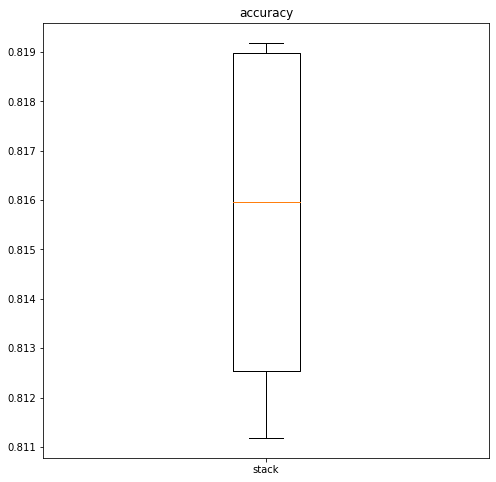

In [356]:
models = []
models.append(('stack', stack))
model_evaluation(models, y = y_prueba)


La mayor precisión, a priori, la obtiene el ensamblado_stack. Vamos a evaluar los resultados en la plataforma y compartimos la puntuación; pero mi impresión es que será buena:

In [355]:
#Lanzamos el modelo para los datos test para ver la puntuación
y_pred = stack.predict(test)

#Para volver a los nombres en vez de a los números:
# Crear un diccionario invertido del mapeo de valores
mapeo_invertido = {0: 'functional', 1: 'functional needs repair', 2: 'non functional'}

# Aplicar el mapeo invertido a la columna 'columna_deseada' en el DataFrame 'y'
y_pred = pd.Series(y_pred).map(mapeo_invertido)

prediccion_ensemble_stack = pd.concat([test_id, pd.DataFrame(y_pred, columns = ['status_group'])], axis = 1)
# Exportar el DataFrame a un archivo CSV
prediccion_ensemble_stack.to_csv('prediccion_ensemble_stack.csv', index = False)

### Puntuación 'prediccion_ensemble_stack': 0.8236
Efectivamente, este modelo predictivo, basado en un ensamblado de todos los modelos anteriores tuneados, es el mejor hasta el momento, con una puntuación de 0.8236. Mi puntuación más alta.

A continuación, se realiza una última prueba con un ensamblado ponderado, pero dificilmente podamos usperar ya esta puntuación. Para mejorar la puntuación debemos volver al proceso de feature ingeniering y generar nuevas variables que puedan guardar poder predictivo.

# Ensamblado ponderado (Weighted vote)

0:	learn: 0.9632165	total: 40ms	remaining: 12s
1:	learn: 0.8788088	total: 77.7ms	remaining: 11.6s
2:	learn: 0.8197406	total: 115ms	remaining: 11.4s
3:	learn: 0.7766620	total: 150ms	remaining: 11.1s
4:	learn: 0.7463786	total: 187ms	remaining: 11s
5:	learn: 0.7205201	total: 222ms	remaining: 10.9s
6:	learn: 0.7011986	total: 260ms	remaining: 10.9s
7:	learn: 0.6838014	total: 303ms	remaining: 11.1s
8:	learn: 0.6712621	total: 339ms	remaining: 11s
9:	learn: 0.6576736	total: 374ms	remaining: 10.9s
10:	learn: 0.6490267	total: 410ms	remaining: 10.8s
11:	learn: 0.6382827	total: 444ms	remaining: 10.6s
12:	learn: 0.6332473	total: 481ms	remaining: 10.6s
13:	learn: 0.6270404	total: 519ms	remaining: 10.6s
14:	learn: 0.6211239	total: 555ms	remaining: 10.5s
15:	learn: 0.6156490	total: 592ms	remaining: 10.5s
16:	learn: 0.6114978	total: 627ms	remaining: 10.4s
17:	learn: 0.6066535	total: 663ms	remaining: 10.4s
18:	learn: 0.6023613	total: 698ms	remaining: 10.3s
19:	learn: 0.5966283	total: 732ms	remaining: 10

164:	learn: 0.4394672	total: 6.2s	remaining: 5.07s
165:	learn: 0.4391480	total: 6.24s	remaining: 5.03s
166:	learn: 0.4387819	total: 6.27s	remaining: 4.99s
167:	learn: 0.4383652	total: 6.31s	remaining: 4.96s
168:	learn: 0.4379197	total: 6.34s	remaining: 4.92s
169:	learn: 0.4374576	total: 6.38s	remaining: 4.88s
170:	learn: 0.4371383	total: 6.41s	remaining: 4.84s
171:	learn: 0.4365677	total: 6.45s	remaining: 4.8s
172:	learn: 0.4361464	total: 6.49s	remaining: 4.76s
173:	learn: 0.4357977	total: 6.53s	remaining: 4.72s
174:	learn: 0.4355290	total: 6.56s	remaining: 4.69s
175:	learn: 0.4349379	total: 6.6s	remaining: 4.65s
176:	learn: 0.4346803	total: 6.64s	remaining: 4.61s
177:	learn: 0.4343233	total: 6.67s	remaining: 4.58s
178:	learn: 0.4338006	total: 6.71s	remaining: 4.54s
179:	learn: 0.4334124	total: 6.75s	remaining: 4.5s
180:	learn: 0.4331595	total: 6.78s	remaining: 4.46s
181:	learn: 0.4327963	total: 6.82s	remaining: 4.42s
182:	learn: 0.4324875	total: 6.86s	remaining: 4.38s
183:	learn: 0.43

27:	learn: 0.5729723	total: 933ms	remaining: 9.07s
28:	learn: 0.5702120	total: 966ms	remaining: 9.03s
29:	learn: 0.5680740	total: 1000ms	remaining: 9s
30:	learn: 0.5666276	total: 1.03s	remaining: 8.96s
31:	learn: 0.5640843	total: 1.06s	remaining: 8.91s
32:	learn: 0.5620643	total: 1.1s	remaining: 8.88s
33:	learn: 0.5589133	total: 1.13s	remaining: 8.83s
34:	learn: 0.5572964	total: 1.16s	remaining: 8.8s
35:	learn: 0.5553300	total: 1.2s	remaining: 8.77s
36:	learn: 0.5536260	total: 1.23s	remaining: 8.73s
37:	learn: 0.5514620	total: 1.26s	remaining: 8.7s
38:	learn: 0.5505543	total: 1.3s	remaining: 8.67s
39:	learn: 0.5489930	total: 1.33s	remaining: 8.64s
40:	learn: 0.5469586	total: 1.36s	remaining: 8.6s
41:	learn: 0.5455900	total: 1.39s	remaining: 8.57s
42:	learn: 0.5428430	total: 1.43s	remaining: 8.53s
43:	learn: 0.5416287	total: 1.46s	remaining: 8.5s
44:	learn: 0.5403688	total: 1.49s	remaining: 8.46s
45:	learn: 0.5386829	total: 1.52s	remaining: 8.42s
46:	learn: 0.5366829	total: 1.56s	remain

187:	learn: 0.4187335	total: 6.25s	remaining: 3.73s
188:	learn: 0.4181412	total: 6.29s	remaining: 3.69s
189:	learn: 0.4177182	total: 6.32s	remaining: 3.66s
190:	learn: 0.4171742	total: 6.35s	remaining: 3.62s
191:	learn: 0.4166780	total: 6.38s	remaining: 3.59s
192:	learn: 0.4163803	total: 6.42s	remaining: 3.56s
193:	learn: 0.4158921	total: 6.45s	remaining: 3.53s
194:	learn: 0.4153836	total: 6.49s	remaining: 3.49s
195:	learn: 0.4149736	total: 6.52s	remaining: 3.46s
196:	learn: 0.4147187	total: 6.55s	remaining: 3.43s
197:	learn: 0.4141904	total: 6.59s	remaining: 3.4s
198:	learn: 0.4137752	total: 6.63s	remaining: 3.36s
199:	learn: 0.4134112	total: 6.66s	remaining: 3.33s
200:	learn: 0.4129899	total: 6.69s	remaining: 3.3s
201:	learn: 0.4124399	total: 6.72s	remaining: 3.26s
202:	learn: 0.4119148	total: 6.76s	remaining: 3.23s
203:	learn: 0.4116781	total: 6.79s	remaining: 3.2s
204:	learn: 0.4111826	total: 6.83s	remaining: 3.16s
205:	learn: 0.4108530	total: 6.86s	remaining: 3.13s
206:	learn: 0.4

47:	learn: 0.5414004	total: 1.64s	remaining: 8.61s
48:	learn: 0.5393392	total: 1.68s	remaining: 8.58s
49:	learn: 0.5375196	total: 1.71s	remaining: 8.54s
50:	learn: 0.5362108	total: 1.74s	remaining: 8.51s
51:	learn: 0.5342883	total: 1.78s	remaining: 8.48s
52:	learn: 0.5331270	total: 1.81s	remaining: 8.44s
53:	learn: 0.5320466	total: 1.85s	remaining: 8.42s
54:	learn: 0.5308326	total: 1.88s	remaining: 8.39s
55:	learn: 0.5297425	total: 1.92s	remaining: 8.35s
56:	learn: 0.5285453	total: 1.95s	remaining: 8.31s
57:	learn: 0.5274985	total: 1.99s	remaining: 8.29s
58:	learn: 0.5262619	total: 2.02s	remaining: 8.27s
59:	learn: 0.5247222	total: 2.06s	remaining: 8.23s
60:	learn: 0.5229530	total: 2.09s	remaining: 8.2s
61:	learn: 0.5213525	total: 2.13s	remaining: 8.17s
62:	learn: 0.5199251	total: 2.16s	remaining: 8.13s
63:	learn: 0.5185437	total: 2.19s	remaining: 8.09s
64:	learn: 0.5171768	total: 2.23s	remaining: 8.05s
65:	learn: 0.5157720	total: 2.26s	remaining: 8.02s
66:	learn: 0.5135426	total: 2.29

211:	learn: 0.4137592	total: 7.21s	remaining: 2.99s
212:	learn: 0.4130718	total: 7.24s	remaining: 2.96s
213:	learn: 0.4123968	total: 7.27s	remaining: 2.92s
214:	learn: 0.4118244	total: 7.31s	remaining: 2.89s
215:	learn: 0.4115573	total: 7.34s	remaining: 2.85s
216:	learn: 0.4111773	total: 7.37s	remaining: 2.82s
217:	learn: 0.4108914	total: 7.4s	remaining: 2.78s
218:	learn: 0.4102757	total: 7.44s	remaining: 2.75s
219:	learn: 0.4099139	total: 7.47s	remaining: 2.72s
220:	learn: 0.4094293	total: 7.5s	remaining: 2.68s
221:	learn: 0.4089996	total: 7.54s	remaining: 2.65s
222:	learn: 0.4086570	total: 7.57s	remaining: 2.61s
223:	learn: 0.4082225	total: 7.6s	remaining: 2.58s
224:	learn: 0.4075648	total: 7.63s	remaining: 2.54s
225:	learn: 0.4072313	total: 7.67s	remaining: 2.51s
226:	learn: 0.4068404	total: 7.7s	remaining: 2.48s
227:	learn: 0.4063372	total: 7.73s	remaining: 2.44s
228:	learn: 0.4058371	total: 7.76s	remaining: 2.41s
229:	learn: 0.4053792	total: 7.8s	remaining: 2.37s
230:	learn: 0.405

76:	learn: 0.4950855	total: 2.52s	remaining: 7.31s
77:	learn: 0.4935635	total: 2.55s	remaining: 7.27s
78:	learn: 0.4927654	total: 2.59s	remaining: 7.24s
79:	learn: 0.4918660	total: 2.63s	remaining: 7.24s
80:	learn: 0.4903556	total: 2.67s	remaining: 7.21s
81:	learn: 0.4892660	total: 2.7s	remaining: 7.17s
82:	learn: 0.4885710	total: 2.73s	remaining: 7.14s
83:	learn: 0.4874236	total: 2.77s	remaining: 7.11s
84:	learn: 0.4868243	total: 2.8s	remaining: 7.08s
85:	learn: 0.4860010	total: 2.84s	remaining: 7.07s
86:	learn: 0.4851331	total: 2.87s	remaining: 7.03s
87:	learn: 0.4841339	total: 2.91s	remaining: 7.01s
88:	learn: 0.4831182	total: 2.95s	remaining: 6.99s
89:	learn: 0.4818854	total: 2.99s	remaining: 6.97s
90:	learn: 0.4808257	total: 3.02s	remaining: 6.93s
91:	learn: 0.4800498	total: 3.07s	remaining: 6.94s
92:	learn: 0.4795715	total: 3.11s	remaining: 6.93s
93:	learn: 0.4788685	total: 3.15s	remaining: 6.9s
94:	learn: 0.4782034	total: 3.18s	remaining: 6.87s
95:	learn: 0.4776232	total: 3.22s	

240:	learn: 0.3956635	total: 8.01s	remaining: 1.96s
241:	learn: 0.3952783	total: 8.04s	remaining: 1.93s
242:	learn: 0.3950756	total: 8.07s	remaining: 1.89s
243:	learn: 0.3947289	total: 8.1s	remaining: 1.86s
244:	learn: 0.3944756	total: 8.13s	remaining: 1.82s
245:	learn: 0.3939309	total: 8.16s	remaining: 1.79s
246:	learn: 0.3934225	total: 8.19s	remaining: 1.76s
247:	learn: 0.3929811	total: 8.22s	remaining: 1.72s
248:	learn: 0.3926550	total: 8.26s	remaining: 1.69s
249:	learn: 0.3922086	total: 8.29s	remaining: 1.66s
250:	learn: 0.3917865	total: 8.32s	remaining: 1.62s
251:	learn: 0.3914242	total: 8.35s	remaining: 1.59s
252:	learn: 0.3912280	total: 8.38s	remaining: 1.56s
253:	learn: 0.3907084	total: 8.41s	remaining: 1.52s
254:	learn: 0.3904723	total: 8.44s	remaining: 1.49s
255:	learn: 0.3898986	total: 8.48s	remaining: 1.46s
256:	learn: 0.3893264	total: 8.51s	remaining: 1.42s
257:	learn: 0.3889327	total: 8.54s	remaining: 1.39s
258:	learn: 0.3884421	total: 8.57s	remaining: 1.36s
259:	learn: 0

107:	learn: 0.4727887	total: 3.62s	remaining: 6.43s
108:	learn: 0.4721684	total: 3.65s	remaining: 6.4s
109:	learn: 0.4716725	total: 3.68s	remaining: 6.36s
110:	learn: 0.4702802	total: 3.71s	remaining: 6.33s
111:	learn: 0.4694623	total: 3.75s	remaining: 6.29s
112:	learn: 0.4689754	total: 3.78s	remaining: 6.25s
113:	learn: 0.4684160	total: 3.81s	remaining: 6.21s
114:	learn: 0.4674491	total: 3.84s	remaining: 6.18s
115:	learn: 0.4665705	total: 3.87s	remaining: 6.14s
116:	learn: 0.4656758	total: 3.9s	remaining: 6.11s
117:	learn: 0.4649973	total: 3.94s	remaining: 6.07s
118:	learn: 0.4638546	total: 3.97s	remaining: 6.03s
119:	learn: 0.4631593	total: 4s	remaining: 6s
120:	learn: 0.4622019	total: 4.03s	remaining: 5.96s
121:	learn: 0.4617634	total: 4.07s	remaining: 5.93s
122:	learn: 0.4610225	total: 4.1s	remaining: 5.9s
123:	learn: 0.4604645	total: 4.13s	remaining: 5.87s
124:	learn: 0.4598927	total: 4.17s	remaining: 5.83s
125:	learn: 0.4590827	total: 4.2s	remaining: 5.8s
126:	learn: 0.4586233	to

270:	learn: 0.3904832	total: 9.02s	remaining: 965ms
271:	learn: 0.3901997	total: 9.05s	remaining: 932ms
272:	learn: 0.3900593	total: 9.08s	remaining: 898ms
273:	learn: 0.3895509	total: 9.11s	remaining: 865ms
274:	learn: 0.3890719	total: 9.15s	remaining: 832ms
275:	learn: 0.3887149	total: 9.18s	remaining: 798ms
276:	learn: 0.3882212	total: 9.21s	remaining: 765ms
277:	learn: 0.3878900	total: 9.24s	remaining: 732ms
278:	learn: 0.3877073	total: 9.28s	remaining: 698ms
279:	learn: 0.3874969	total: 9.31s	remaining: 665ms
280:	learn: 0.3871130	total: 9.34s	remaining: 632ms
281:	learn: 0.3868735	total: 9.38s	remaining: 599ms
282:	learn: 0.3864454	total: 9.41s	remaining: 565ms
283:	learn: 0.3861402	total: 9.44s	remaining: 532ms
284:	learn: 0.3859355	total: 9.47s	remaining: 499ms
285:	learn: 0.3853776	total: 9.51s	remaining: 465ms
286:	learn: 0.3849427	total: 9.54s	remaining: 432ms
287:	learn: 0.3847715	total: 9.57s	remaining: 399ms
288:	learn: 0.3842488	total: 9.61s	remaining: 366ms
289:	learn: 

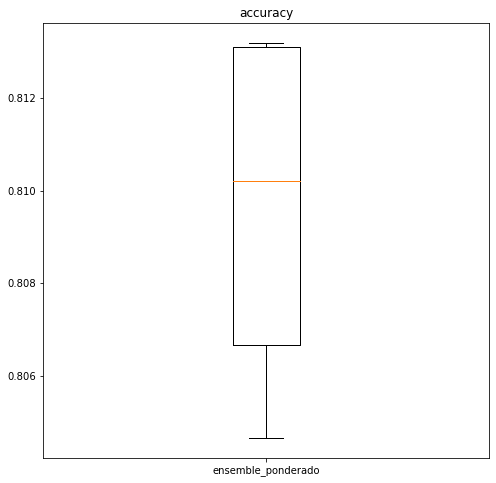

In [373]:
# Ensamblado con votación PONDERADA
# Especificar los pesos para cada estimador
# Los pesos se especifican como una lista de tuplas (nombre_modelo, peso)
# Puedes ajustar los pesos según tus necesidades y preferencias

estimators = [('logreg', best_logreg_model), ('dtc', best_dtc), ('rf', best_rf_model), ('bag', best_bagging_model), 
                 ('cat', best_cat_model), ('xgboost', modelo_xgb)]
weights = [0.5, 0.9, 2.5, 1, 2, 2] # Ejemplo de pesos

# Crear el ensamblado con votación ponderada (weighted voting)
ensemble_model_ponderado = VotingClassifier(
    estimators = estimators,
    voting = 'soft',
    weights = weights)

# Ajustar el ensamblado a tus datos de entrenamiento
ensemble_model_ponderado.fit(X, y_prueba)

ypred = ensemble_model_ponderado.predict(X)
precision = accuracy_score(y_prueba, ypred)
print('Precisión ensemble model ponderado {}'.format(precision))

models = []
models.append(('ensemble_ponderado', ensemble_model))
model_evaluation(models)

In [374]:
#Lanzamos el modelo para los datos test para ver la puntuación
y_pred = ensemble_model_ponderado.predict(test)

#Para volver a los nombres en vez de a los números:
# Crear un diccionario invertido del mapeo de valores
mapeo_invertido = {0: 'functional', 1: 'functional needs repair', 2: 'non functional'}

# Aplicar el mapeo invertido a la columna 'columna_deseada' en el DataFrame 'y'
y_pred = pd.Series(y_pred).map(mapeo_invertido)

#print("Accuracy score train: {}".format(accuracy_score(y, y_pred)))
prediccion_ensemble_ponderado = pd.concat([test_id, pd.DataFrame(y_pred, columns = ['status_group'])], axis = 1)
# Exportar el DataFrame a un archivo CSV
prediccion_ensemble_ponderado.to_csv('prediccion_ensemble_ponderado.csv', index = False)


He probado con distintos 'weigths', dando más prioridad a los modelos con mejor performance, especialmente, RandomForest, CatBoostClassifier y XGBoost, y menos a modelos de menor rendimiento, como regresión logística, bagging y Decision Tree Classifier. Los resultados son competitivos pero no tan buenos como los del ensamblado 'stack'. La puntuación ha sido de 0.8212, inferior a la calculada anteriormente.

Ya he realizado todas las pruebas que se me han ocurrido. El mejor modelo hasta el momento es 'Ensamblado stack' con una puntuación de '0.8236'. A lo largo de este desarrollo he ido comentado las decisiones que he ido tomando, así como, especialmente, los aprendizajes que he ido obteniendo de cada paso que hacía. El concurso, más allá del resultado, me ha resultado una experiencia muy enriquecedora y me ha ayudado a poner en práctica mis conocimientos teóricos y a enfrentarme a una problemática de la vida real.

## FIN